<a href="https://colab.research.google.com/github/khadija267/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation

Purpose of the Project: Build a clustering model using customers category purchases so we can identify cross shopping opportunities for customers with specific category combinations.
Understanding Data Sampling:
- Transactions combined over the past two years
- Lifetime purchase is equal to three or more
- The initial purchase should be of a duration that is equal to or exceeds two years
-Added Active Lesson Flag, RFM group score, Age and Gender to the data


## Helper Functions

In [ ]:
# the following functions take spark df
def printdf(sdf, l=5):
    return sdf.limit(l).toPandas()

def nullcount(sdf):
    return {col: sdf.filter(sdf[col].isNull()).count() for col in sdf.columns}
def null_show(sdf):
    null_counts = sdf.select([sum(col(c).isNull().cast("int")).alias(c) for c in sdf.columns])
    null_counts.show()



def shape(sdf):
    print((sdf.count(), len(sdf.columns)))

def filter_outliers(sdf, columns, factor=1.5):

    for column in columns:
        # Calculate Q1, Q3, and IQR
        quantiles = sdf.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        # Define the upper and lower bounds for outliers
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        # Filter outliers and update the DataFrame
        outliers = sdf.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return outliers
def silhouette(predictions):

    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette")
    score = evaluator.evaluate(predictions)
    print("silhouette score = ", score)

# the following functions take pandas df
def check_ouliers(pdf):
    # Calculate z-score for each value
    z_scores = zscore(pdf[pdf.columns])

    # Select rows where any column has a value outside of 3 standard deviations
    threshold = 3
    outliers = pdf[pdf.columns][(z_scores > threshold).any(axis=1)]
    return outliers

In [ ]:
# install required libraries
!pip install pyspark
!pip install -U seaborn

#!pip install pandas_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=80c6b32a5449bbfc06417762154d0a84c7bd3be8e22f26a69998929c2602439a
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
#!pip install pyspark-dbscan

In [ ]:
# import required libraries
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 8g --executor-memory 8g pyspark-shell'
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
pd.set_option('display.max_columns',None) ### added this to display all columns but did not work- it ran though
## Khadija : It works while displaying the data frame
import pyspark
print("PySpark version:", pyspark.__version__)
from pyspark.sql import SparkSession
from scipy.stats import zscore
from pyspark.sql import functions as F
from pyspark.sql.types import *
from google.colab import drive
drive.mount('/content/drive')
#from sklearn.datasets import make_blobs
#from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from pyspark.sql.functions import *
from pyspark.ml.clustering import KMeans
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import plotly.express as px
# access to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


PySpark version: 3.4.1
Mounted at /content/drive


## 1. Data Gathering


In [ ]:

file_id = '1pLsBeQ_l_YL2FzjCXvPrRl8VaQNvIhVH' #<-- You add in here the id from you google drive file, you can find it

download = drive.CreateFile({'id': file_id})

# Download the file to a local disc
download.GetContentFile('df.csv')


In [ ]:

# create a SparkSession object
spark = SparkSession.builder.appName("Cutomer Segmentation").config("spark.driver.memory", "20g").getOrCreate()

# read a CSV file
sdf = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("df.csv")



In [ ]:
# convert the spark df to pandas df for
pdf=sdf.toPandas()

### YB-
Learning section - hope not taking too much space :)
Khadija: Sure take any space you want

In [ ]:
pip install pandas-profiling

Below crashed so we would choose specific columns for testing


In [ ]:
specific_columns=['Customer_Number', 'cs_active_lesson_flg', 'rfm_group_dsc', 'age_range',
       'gender', 'accessories_for_brass_instruments',
       'accessories_for_orchestral_strings', 'acoustic_bass', 'acoustic_drums',
       'acoustic_electric_guitars']

In [ ]:
pdf_copy=pdf[specific_columns].copy()

In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(pdf_copy)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import os
print(os.getcwd())

/content


Can't access content and this is shared so would ignore, was trying to see the outcome

Mounted at /content/drive


In [ ]:
pdf.dtypes

Customer_Number          object
cs_active_lesson_flg     object
rfm_group_dsc            object
age_range                object
gender                   object
                         ...   
violas                  float64
violins                 float64
warranties              float64
woodwind_accessories    float64
world_percussion        float64
Length: 124, dtype: object

In [ ]:
pdf.head()

Customer_Number cs_active_lesson_flg rfm_group_dsc age_range   gender  \
0            None                    N   02-Loyalist     55-64   Female   
1            None                    N        01-VIP     25-34     Male   
2            None                    N   02-Loyalist     45-54  Unknown   
3            None                    N   02-Loyalist       OOR     Male   
4            None                    N   02-Loyalist     45-54  Unknown   

   accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                NaN                                 NaN   
1                                NaN                                 NaN   
2                                NaN                                 NaN   
3                                NaN                                 NaN   
4                                NaN                                 NaN   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            NaN             NaN                        NaN               NaN   
1            NaN             NaN                        NaN               NaN   
2            NaN             NaN                        NaN               NaN   
3            NaN             NaN                        NaN               NaN   
4            NaN             NaN                        NaN               NaN   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                NaN         NaN              NaN             NaN   
1                NaN      149.99              NaN             NaN   
2                NaN         NaN              NaN             NaN   
3                NaN         NaN              NaN             NaN   
4                NaN         NaN              NaN             NaN   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0             NaN     NaN             NaN             NaN   
1             NaN     NaN           37.99             NaN   
2             NaN     NaN             NaN             NaN   
3             NaN     NaN           14.99             NaN   
4             NaN     NaN             NaN             NaN   

   cases_gig_bags__covers  cds__vinyl  cellos  clarinets  \
0                     NaN         NaN     NaN        NaN   
1                     NaN         NaN     NaN        NaN   
2                     NaN         NaN     NaN        NaN   
3                     NaN         NaN     NaN        NaN   
4                     NaN         NaN     NaN        NaN   

   classical__nylon_guitars  classroom_aids  classroom_furniture  \
0                       NaN             NaN                  NaN   
1                       NaN             NaN                  NaN   
2                       NaN             NaN                  NaN   
3                       NaN             NaN                  NaN   
4                       NaN             NaN                  NaN   

   classroom_musical_instruments  clothing  collectibles  \
0                            NaN       NaN           NaN   
1                            NaN       NaN           NaN   
2                            NaN       NaN           NaN   
3                            NaN       NaN           NaN   
4                            NaN       NaN           NaN   

   computers__peripherals  concert_cymbals  concert_drums  \
0                     NaN              NaN            NaN   
1                     NaN              NaN            NaN   
2                     NaN              NaN            NaN   
3                     NaN              NaN            NaN   
4                     NaN              NaN            NaN   

   concert_hand__mounted_percussion  concert_mallet_percussion  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN 

In [ ]:
pdf.tail(10).transpose()## again just playing around with code for learning

620290   620291   620292       620293  620294  \
Customer_Number              None     None     None         None    None   
cs_active_lesson_flg            N        N        N            N       N   
rfm_group_dsc         02-Loyalist   01-VIP   01-VIP  02-Loyalist  01-VIP   
age_range                     OOR      OOR      OOR        45-54   55-64   
gender                    Unknown  Unknown  Unknown      Unknown    Male   
...                           ...      ...      ...          ...     ...   
violas                        NaN      NaN      NaN          NaN     NaN   
violins                       NaN      NaN      NaN          NaN     NaN   
warranties                    NaN      NaN      NaN          NaN     NaN   
woodwind_accessories          NaN      NaN      NaN          NaN     NaN   
world_percussion              NaN      NaN      NaN          NaN     NaN   

                           620295  620296       620297  620298   620299  
Customer_Number              None    None         None    None     None  
cs_active_lesson_flg            N       N            N       N        N  
rfm_group_dsc         02-Loyalist  01-VIP  02-Loyalist  01-VIP   01-VIP  
age_range                     OOR   35-44        35-44   55-64      OOR  
gender                    Unknown  Female      Unknown    Male  Unknown  
...                           ...     ...          ...     ...      ...  
violas                        NaN     NaN          NaN     NaN      NaN  
violins                       NaN     NaN          NaN     NaN      NaN  
warranties                    NaN  151.32          NaN     NaN    12.43  
woodwind_accessories          NaN     NaN          NaN     NaN      NaN  
world_percussion              NaN     NaN          NaN     NaN      NaN  

[124 rows x 10 columns]

In [ ]:
pdf.describe().round(2)

accessories_for_brass_instruments  accessories_for_orchestral_strings  \
count                            1582.00                             1905.00   
mean                               29.81                               47.48   
std                                53.16                              154.28   
min                                 0.01                                0.01   
25%                                 5.99                               14.95   
50%                                14.86                               24.99   
75%                                28.97                               44.29   
max                               830.76                             4798.50   

       acoustic_bass  acoustic_drums  acoustic_electric_guitars  \
count        3832.00        18912.00                   67562.00   
mean          356.01          540.07                     737.24   
std           211.77          686.07                    1098.34   
min            10.00            1.00                       0.14   
25%           249.99          249.00                     249.99   
50%           289.99          389.99                     419.00   
75%           349.99          649.99                     759.01   
max          3438.98        30592.37                   53904.00   

       acoustic_guitars  alto__tenor_horns  amplifiers  amplifier_parts  \
count          46333.00               1.00   139103.00           722.00   
mean             383.83             511.15      316.72           302.24   
std              945.51                NaN      542.76          4304.87   
min                0.01             511.15        0.01             3.00   
25%              139.99             511.15      114.99            34.99   
50%              189.99             511.15      179.99            69.98   
75%              319.00             511.15      329.99           139.27   
max            53165.00             511.15    51549.89        114154.87   

       audio_playback  baritone_horns  bugles  cables__snakes  care__cleaning  \
count          343.00            4.00    2.00       246011.00        28570.00   
mean           814.88         1503.49   39.95           69.51           17.11   
std           1276.03          672.01    0.00          149.97           18.32   
min             19.99          629.99   39.95            0.01            0.01   
25%            228.64         1169.99   39.95           21.99            8.99   
50%            449.00         1612.00   39.95           36.98           11.99   
75%           1009.98         1945.49   39.95           71.97           21.99   
max          18599.86         2159.97   39.95        24804.22         1383.45   

       cases_gig_bags__covers  cds__vinyl   cellos  clarinets  \
count               110759.00     7970.00    69.00     311.00   
mean                   111.57       53.17  1505.96     379.65   
std                    530.44      321.34  1444.10     655.02   
min                      0.01        0.89   299.99      71.04   
25%                     47.99       24.98   750.43     168.74   
50%                     79.99       32.98  1019.15     239.99   
75%                    139.98       54.96  1640.48     281.66   
max                 130336.99    28280.87  9899.00    8943.78   

       classical__nylon_guitars  classroom_aids  classroom_furniture  \
count                  11762.00           34.00                23.00   
mean                     461.19           65.98               367.29   
std                      616.24          101.19               719.43   
min                       10.00            2.97                 0.25   
25%                      159.99            9.31                17.60   
50%                      280.49           18.98                39.80   
75%                      548.59           79.73               396.10   
max                    12641.91          489.63              3200.00   

       classroom_musical_instruments  clo

In [ ]:
pdf.count()

Customer_Number              0
cs_active_lesson_flg    620300
rfm_group_dsc           620290
age_range               620300
gender                  620300
                         ...  
violas                      48
violins                    991
warranties              234256
woodwind_accessories      3816
world_percussion         28463
Length: 124, dtype: int64

In [ ]:
### Sorting top categories filled for purpose of seeing top categories purchased by # of customers
import pandas as pd

# Assuming you have a DataFrame called 'df'

# Get the count of non-null values in each column
column_counts = pdf.count()

# Sort the column counts in descending order
sorted_counts = column_counts.sort_values(ascending=False)

# Display the top 20 counts
top_sorted_counts = sorted_counts.head(20)

# Display the sorted counts
print(top_sorted_counts)


age_range                                620300
gender                                   620300
cs_active_lesson_flg                     620300
rfm_group_dsc                            620290
cables__snakes                           246011
warranties                               234256
fretted_instrument_accessories__parts    227712
stands__racks                            164822
services__fees                           164217
strings                                  155399
amplifiers                               139103
electric_guitars                         120620
cases_gig_bags__covers                   110759
microphones__wireless_systems             85429
drum__percussion_accessories              77250
acoustic_electric_guitars                 67562
tuners__metronomes                        66760
recording_gear                            58239
headphones                                56850
live_sound                                50428
dtype: int64


In [ ]:
### Wondering how people who purchase this would be segmented
import pandas as pd

# Assuming you have a DataFrame called 'df'

# Get the count of non-null values in each column
column_counts = pdf.count()

# Sort the column counts in descending order
sorted_counts = column_counts.sort_values(ascending=True)

# Display the top 20 counts
bottom_sorted_counts = sorted_counts.head(20)

# Display the sorted counts
print(bottom_sorted_counts)


Customer_Number               0
mellophones                   1
alto__tenor_horns             1
dj_lifestyle                  1
portable_audio_players        2
euphoniums                    2
bugles                        2
baritone_horns                4
recorders                     6
double_reed_instruments       6
home_theater_and_devices      7
gongs                         9
tubas                         9
french_horns                 10
concert_cymbals              10
keyboard__midi_packages      11
connected_home               13
flugelhorns                  17
concert_mallet_percussion    21
classroom_furniture          23
dtype: int64


In [ ]:

import pandas as pd

# Assuming you have a DataFrame called 'df'

# Count the occurrences of all values in the DataFrame
value_counts = pdf.stack().value_counts()

# Create a new DataFrame with the value counts
counts_df = pd.DataFrame({'Counts': value_counts})

# Sort the columns based on their count
sorted_counts = counts_df.sort_values(by='Counts', ascending=False)
display=sorted_counts.head(40)

# Display the sorted counts
print(display)


### so we have top VIP Loyalist Male from age 45-54 as our top customer base
## age would be seen below in detail
## Top payments are about $30->$20->$25->$100 (makes sense as top purchases in quantity won't be instruments instead accessories etc)

              Counts
N             581736
Unknown       361492
OOR           349859
01-VIP        280697
02-Loyalist   258308
Male          189312
45-54          81914
Female         69496
35-44          67796
29.99          67201
19.99          55737
03-Potential   50458
55-64          48164
24.99          43149
Y              38564
99.99          37755
65+            34219
9.99           33800
39.99          33651
6.99           33457
149.99         30823
14.99          30650
119.99         30376
00-New         29938
17.99          29362
199.99         28702
25-34          28592
49.99          25184
21.99          24740
16.99          23766
69.99          23373
7.99           23091
10.99          19090
89.99          18596
59.99          18502
179.99         17315
249.99         16711
12.99          16318
79.99          15386
299.99         15267


In [ ]:
#### I want to see top dollars spent-- should correct for below
## need to learn the nature of those clients later or if amount is too high would be for
## reselling purposes and we would be flagging them later
sorted_counts_desc = counts_df.sort_values(by='Counts', ascending=True)
display2=sorted_counts_desc.head(20)

# Display the sorted counts
print(display2)

          Counts
2099.8         1
334.08         1
2217.04        1
2079.03        1
616.04         1
10896.2        1
15662.35       1
1295.98        1
1243.3         1
1157.92        1
1165.47        1
2084.12        1
12096.0        1
1083.95        1
811.54         1
2077.54        1
720.78         1
1388.28        1
1119.86        1
471.5          1


In [ ]:
##as expected most customers do not take lessons
import pandas as pd

# Assuming you have a DataFrame called 'df' with a column called 'column_name'

# Count the occurrences of each value in the 'column_name' column
test = pdf['cs_active_lesson_flg'].value_counts()

# Create a new DataFrame with the counts
counts_df = pd.DataFrame({'Counts': test})

# Sort the counts in descending order
sorted_counts = counts_df.sort_values(by='Counts', ascending=False)

# Display the top counts
top_counts = sorted_counts.head()
print(top_counts)


   Counts
N  581736
Y   38564


## 2. Data Investigation and Cleansing

In [ ]:
# show the first 5 rows of the spark DataFrame
sdf.show(5)

+---------------+--------------------+-------------+---------+-------+---------------------------------+----------------------------------+-------------+--------------+-------------------------+----------------+-----------------+----------+---------------+--------------+--------------+------+--------------+--------------+----------------------+----------+------+---------+------------------------+--------------+-------------------+-----------------------------+--------+------------+----------------------+---------------+-------------+--------------------------------+-------------------------+--------------+--------------------------------+-----------------+-------+-------+-------+------------+-------------+-----------------------+----------------------------+-------+-------------+----------------+---------------------+----------------+---------------------------+----------+----------+--------------------+-----------+----------------+--------------------------------------+---------------

Data Dimensionality

In [ ]:
num_rows = sdf.count()
num_cols = len(sdf.columns)
print(f"The size of the DataFrame is {num_rows} rows and {num_cols} columns")


The size of the DataFrame is 620300 rows and 124 columns


In [ ]:
sdf.printSchema()

root
 |-- Customer_Number: string (nullable = true)
 |-- cs_active_lesson_flg: string (nullable = true)
 |-- rfm_group_dsc: string (nullable = true)
 |-- age_range: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- accessories_for_brass_instruments: double (nullable = true)
 |-- accessories_for_orchestral_strings: double (nullable = true)
 |-- acoustic_bass: double (nullable = true)
 |-- acoustic_drums: double (nullable = true)
 |-- acoustic_electric_guitars: double (nullable = true)
 |-- acoustic_guitars: double (nullable = true)
 |-- alto__tenor_horns: double (nullable = true)
 |-- amplifiers: double (nullable = true)
 |-- amplifier_parts: double (nullable = true)
 |-- audio_playback: double (nullable = true)
 |-- baritone_horns: double (nullable = true)
 |-- bugles: double (nullable = true)
 |-- cables__snakes: double (nullable = true)
 |-- care__cleaning: double (nullable = true)
 |-- cases_gig_bags__covers: double (nullable = true)
 |-- cds__vinyl: double (nullab

In [ ]:
print(sdf.columns)

['Customer_Number', 'cs_active_lesson_flg', 'rfm_group_dsc', 'age_range', 'gender', 'accessories_for_brass_instruments', 'accessories_for_orchestral_strings', 'acoustic_bass', 'acoustic_drums', 'acoustic_electric_guitars', 'acoustic_guitars', 'alto__tenor_horns', 'amplifiers', 'amplifier_parts', 'audio_playback', 'baritone_horns', 'bugles', 'cables__snakes', 'care__cleaning', 'cases_gig_bags__covers', 'cds__vinyl', 'cellos', 'clarinets', 'classical__nylon_guitars', 'classroom_aids', 'classroom_furniture', 'classroom_musical_instruments', 'clothing', 'collectibles', 'computers__peripherals', 'concert_cymbals', 'concert_drums', 'concert_hand__mounted_percussion', 'concert_mallet_percussion', 'connected_home', 'consumer_electronics_accessories', 'consumer_speakers', 'cornets', 'cymbals', 'dj_gear', 'dj_lifestyle', 'double_basses', 'double_reed_instruments', 'drum__percussion_accessories', 'effects', 'electric_bass', 'electric_guitars', 'electric_upright_bass', 'electronic_drums', 'electro

In [ ]:
pdf.describe()

accessories_for_brass_instruments  accessories_for_orchestral_strings  \
count                        1582.000000                         1905.000000   
mean                           29.812212                           47.483633   
std                            53.162121                          154.282891   
min                             0.010000                            0.010000   
25%                             5.990000                           14.950000   
50%                            14.855000                           24.990000   
75%                            28.972500                           44.290000   
max                           830.760000                         4798.500000   

       acoustic_bass  acoustic_drums  acoustic_electric_guitars  \
count    3832.000000    18912.000000               67562.000000   
mean      356.008766      540.068312                 737.244464   
std       211.765223      686.072557                1098.340780   
min        10.000000        1.000000                   0.140000   
25%       249.990000      249.000000                 249.990000   
50%       289.990000      389.990000                 419.000000   
75%       349.990000      649.990000                 759.010000   
max      3438.980000    30592.370000               53904.000000   

       acoustic_guitars  alto__tenor_horns     amplifiers  amplifier_parts  \
count      46333.000000               1.00  139103.000000       722.000000   
mean         383.828566             511.15     316.717099       302.243283   
std          945.513444                NaN     542.755953      4304.874345   
min            0.010000             511.15       0.010000         3.000000   
25%          139.990000             511.15     114.990000        34.990000   
50%          189.990000             511.15     179.990000        69.980000   
75%          319.000000             511.15     329.990000       139.272500   
max        53165.000000             511.15   51549.890000    114154.870000   

       audio_playback  baritone_horns  bugles  cables__snakes  care__cleaning  \
count      343.000000        4.000000    2.00   246011.000000    28570.000000   
mean       814.878980     1503.487500   39.95       69.507408       17.105544   
std       1276.033402      672.013926    0.00      149.967166       18.319641   
min         19.990000      629.990000   39.95        0.010000        0.010000   
25%        228.640000     1169.990000   39.95       21.990000        8.990000   
50%        449.000000     1611.995000   39.95       36.980000       11.990000   
75%       1009.980000     1945.492500   39.95       71.970000       21.990000   
max      18599.860000     2159.970000   39.95    24804.220000     1383.450000   

       cases_gig_bags__covers    cds__vinyl       cellos    clarinets  \
count           110759.000000   7970.000000    69.000000   311.000000   
mean               111.572559     53.171547  1505.964348   379.652572   
std                530.436658    321.343262  1444.103511   655.023452   
min                  0.010000      0.890000   299.990000    71.040000   
25%                 47.990000     24.980000   750.430000   168.740000   
50%                 79.990000     32.980000  1019.150000   239.990000   
75%                139.980000     54.960000  1640.480000   281.660000   
max             130336.990000  28280.870000  9899.000000  8943.780000   

       classical__nylon_guitars  classroom_aids  classroom_furniture  \
count              11762.000000       34.000000            23.000000   
mean                 461.188482       65.980000           367.288696   
std                  616.238493      101.192905           719.431379   
min                   10.000000        2.970000             0.250000   
25%                  159.990000        9.312500            17.600000   
50%                  280.490000       18.980000            39.800000   
75%                  548.590000       79.730000           396.100000   
max            

#### Null Values

Check for missing values

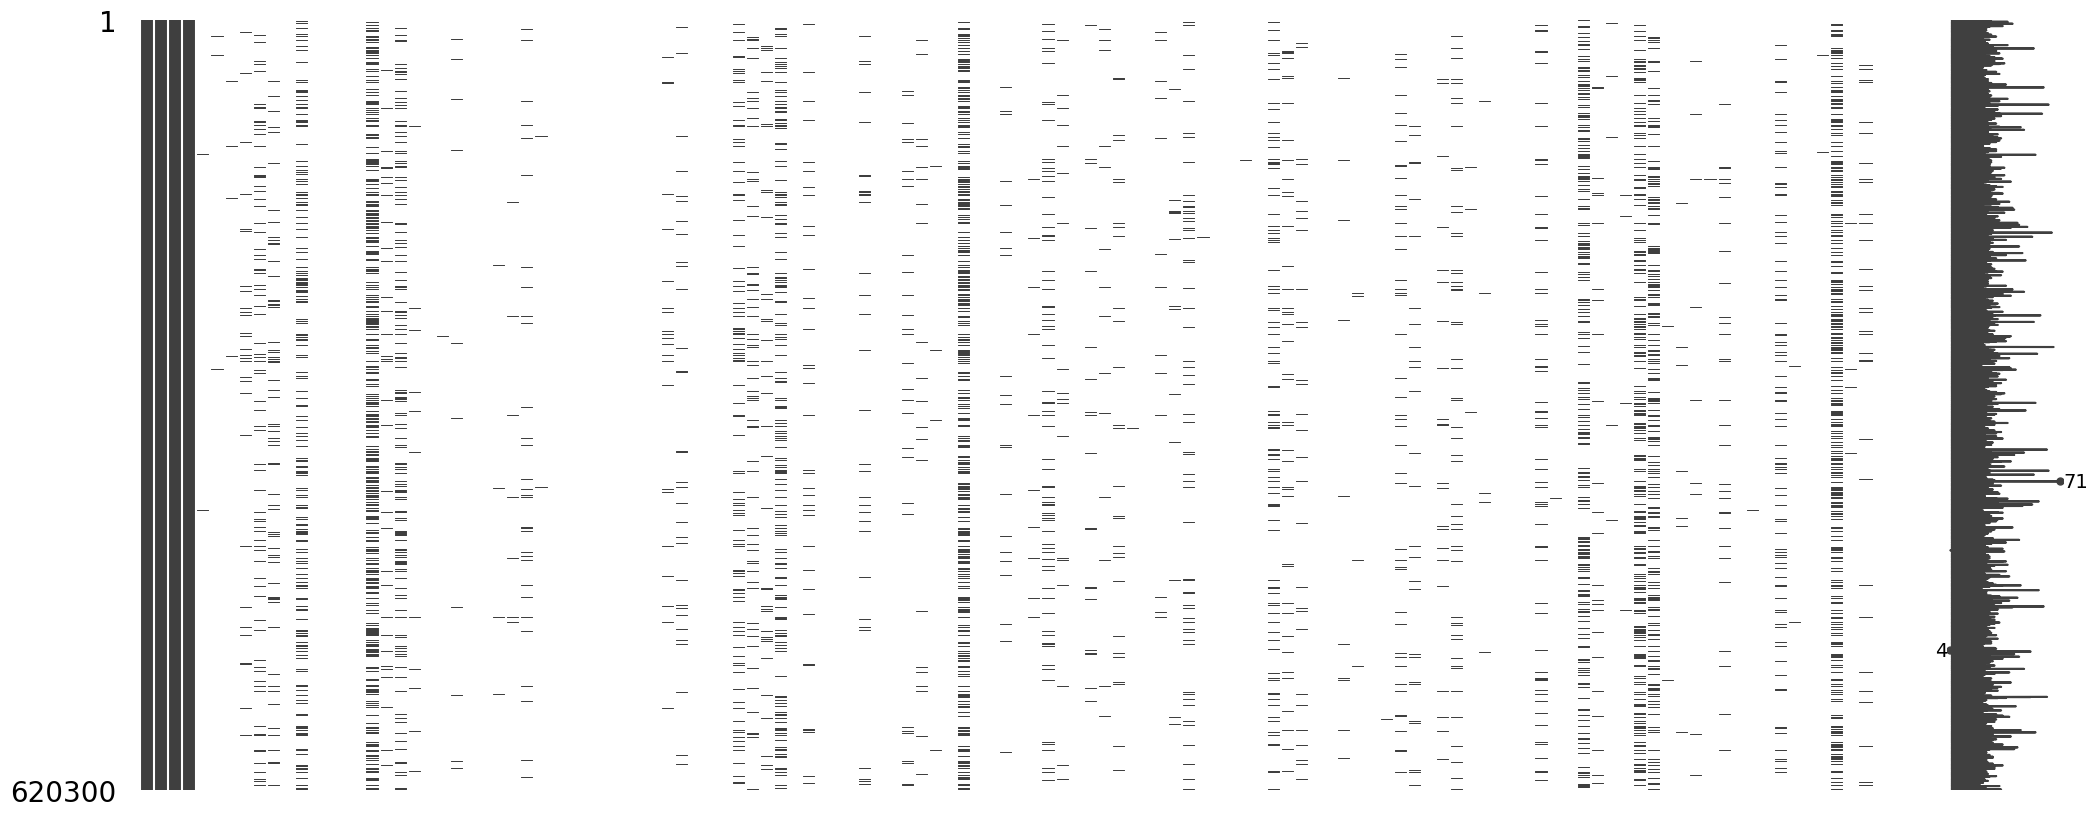

In [ ]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(pdf);

In [ ]:

null_show(sdf)

+--------------------+-------------+---------+------+---------------------------------+----------------------------------+-------------+--------------+-------------------------+----------------+-----------------+----------+---------------+--------------+--------------+------+--------------+--------------+----------------------+----------+------+---------+------------------------+--------------+-------------------+-----------------------------+--------+------------+----------------------+---------------+-------------+--------------------------------+-------------------------+--------------+--------------------------------+-----------------+-------+-------+-------+------------+-------------+-----------------------+----------------------------+-------+-------------+----------------+---------------------+----------------+---------------------------+----------+----------+--------------------+-----------+----------------+--------------------------------------+--------------------------------

Drop the customer number column

In [ ]:
sdf=sdf.drop('Customer_Number')
sdf.show(1)

+--------------------+-------------+---------+------+---------------------------------+----------------------------------+-------------+--------------+-------------------------+----------------+-----------------+----------+---------------+--------------+--------------+------+--------------+--------------+----------------------+----------+------+---------+------------------------+--------------+-------------------+-----------------------------+--------+------------+----------------------+---------------+-------------+--------------------------------+-------------------------+--------------+--------------------------------+-----------------+-------+-------+-------+------------+-------------+-----------------------+----------------------------+-------+-------------+----------------+---------------------+----------------+---------------------------+----------+----------+--------------------+-----------+----------------+--------------------------------------+--------------------------------

Convert the nans to zeros as they represent no-purchase.

Fill the null with zeros

In [ ]:
sdf=sdf.fillna(0)
sdf.show(1)

+--------------------+-------------+---------+------+---------------------------------+----------------------------------+-------------+--------------+-------------------------+----------------+-----------------+----------+---------------+--------------+--------------+------+--------------+--------------+----------------------+----------+------+---------+------------------------+--------------+-------------------+-----------------------------+--------+------------+----------------------+---------------+-------------+--------------------------------+-------------------------+--------------+--------------------------------+-----------------+-------+-------+-------+------------+-------------+-----------------------+----------------------------+-------+-------------+----------------+---------------------+----------------+---------------------------+----------+----------+--------------------+-----------+----------------+--------------------------------------+--------------------------------

#### Duplicated Values

Check for duplicates

In [ ]:
pdf.duplicated().sum()/pdf.shape[0]

0.056314686442044175

In [ ]:
# count total rows
total_rows = sdf.count()

# count distinct rows
distinct_rows = sdf.distinct().count()

# count duplicate rows
duplicate_rows = total_rows - distinct_rows

print("Count of duplicated values:",duplicate_rows)

print("Portion of duplicated values:", round(((duplicate_rows/total_rows)*100),2) , "%")


Count of duplicated values: 34932
Portion of duplicated values: 5.63 %


Drop the duplicates

In [ ]:
sdf = sdf.dropDuplicates()
sdf.count()

585368

In [ ]:
#pdf[pdf.duplicated()==True].to_csv('duplicated.csv')

In [ ]:
# get numerical columns
numerical_cols = [col for col, dtype in sdf.dtypes if dtype in ['int', 'bigint', 'float', 'double']]
# select numerical columns
df_numerical = sdf.select(numerical_cols)

In [ ]:
pdf=sdf.toPandas()

In [ ]:
pdf.to_csv('data_cleaned.csv')

#### Outliers

Check for outliers

In [ ]:
# Calculate z-score for each value
z_scores = zscore(pdf[df_numerical.columns])

# Select rows where any column has a value outside of 3 standard deviations
threshold = 3
outliers = pdf[df_numerical.columns][(z_scores > threshold).any(axis=1)]

In [ ]:
outliers.shape

(206189, 119)

In [ ]:
outliers.shape[0]/pdf.shape[0]

0.3522382501264162

In [ ]:
# takes 20 minutes in runtime
#filter_outliers(sdf, df_numerical.columns, factor=1.5)

<Axes: >

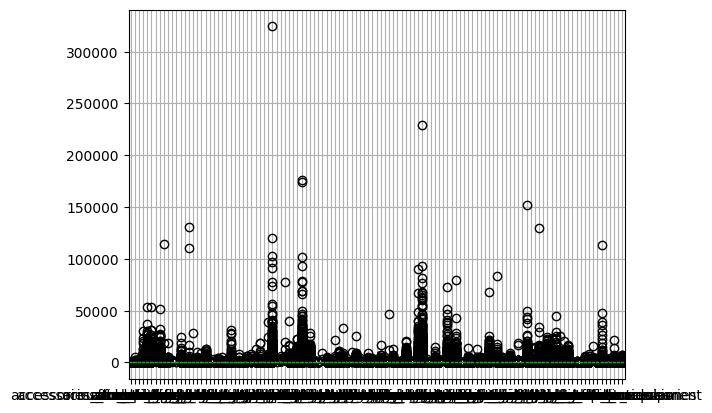

In [ ]:
pdf.boxplot()

<ipython-input-83-43afb6f92e42>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


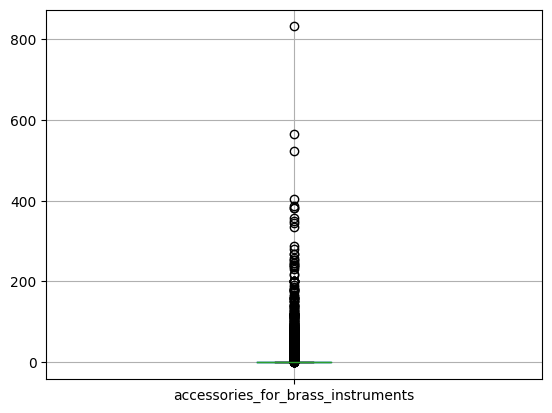

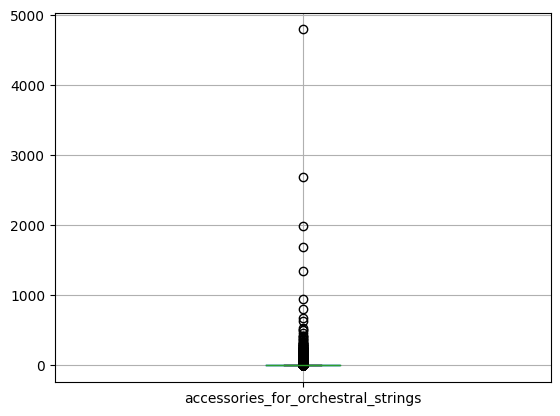

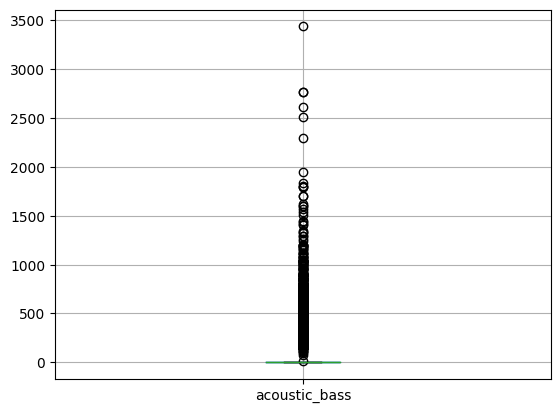

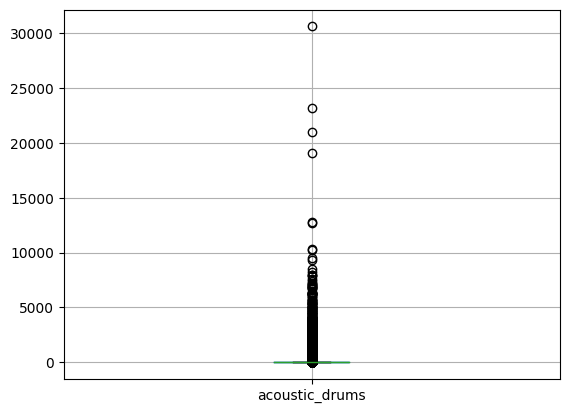

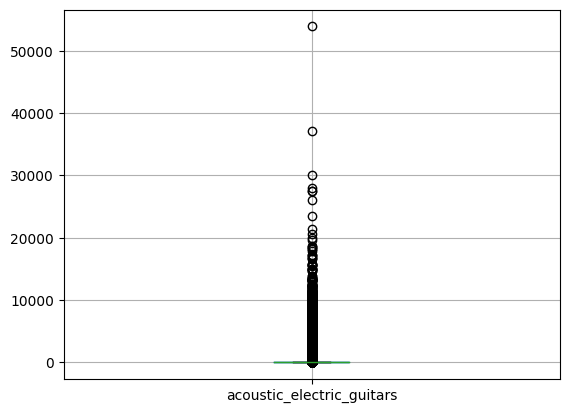

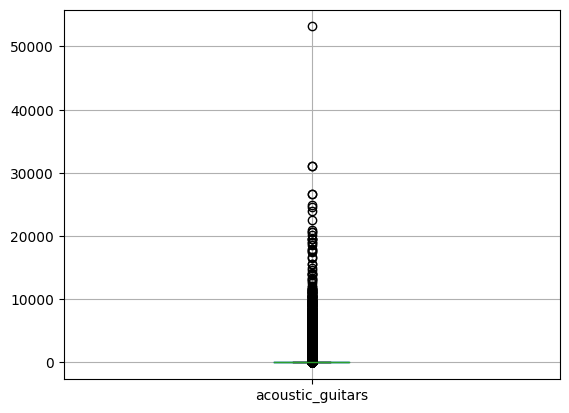

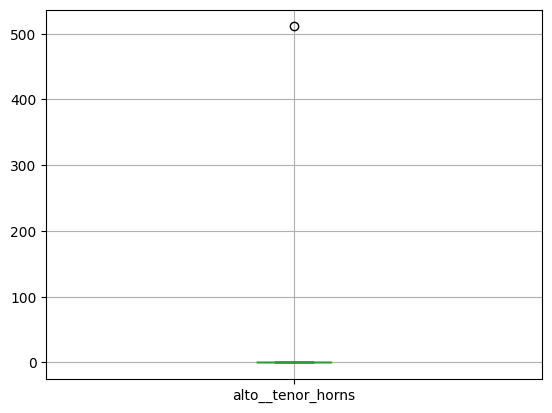

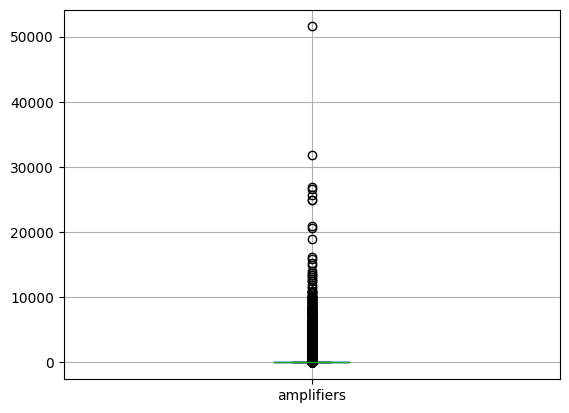

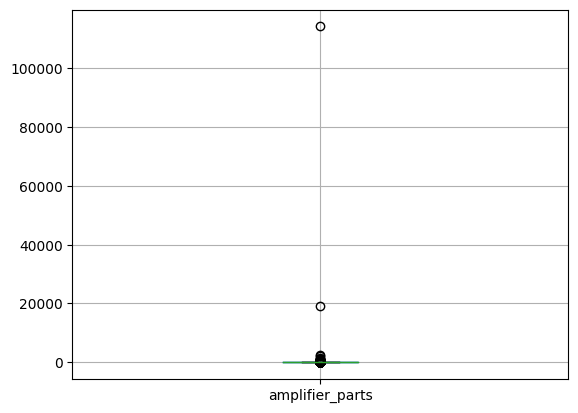

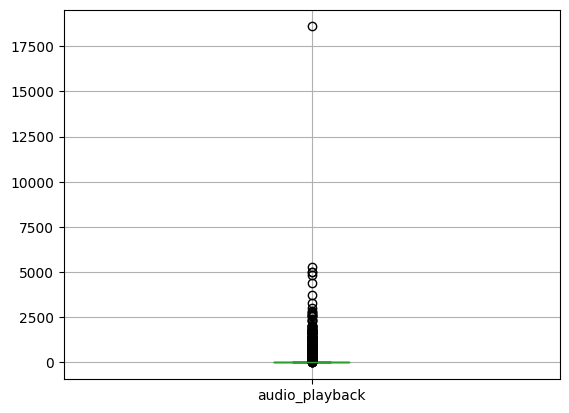

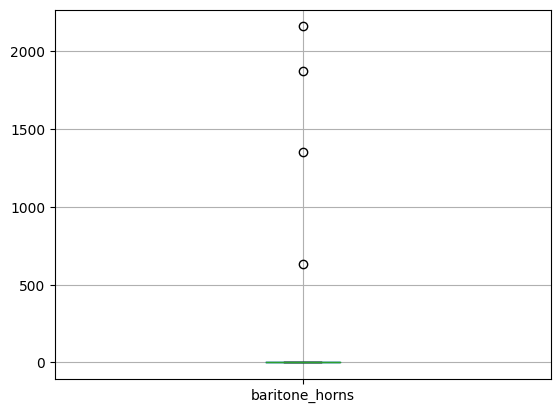

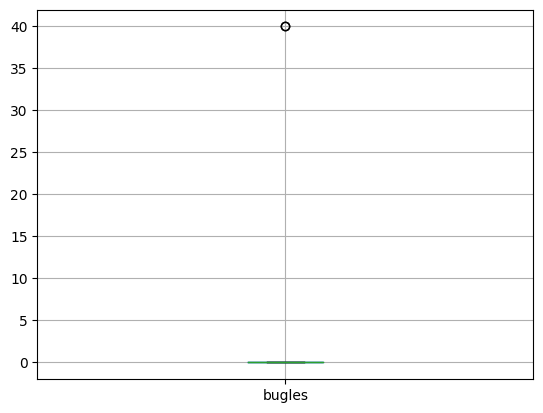

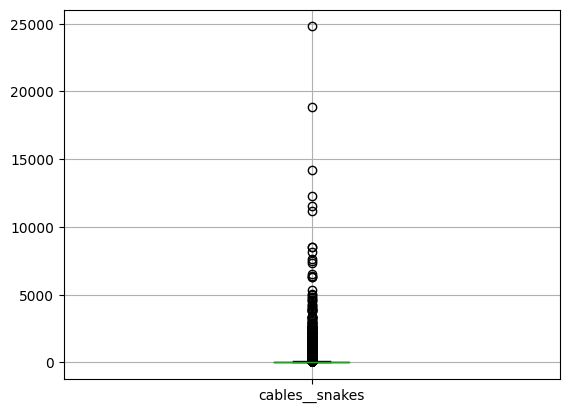

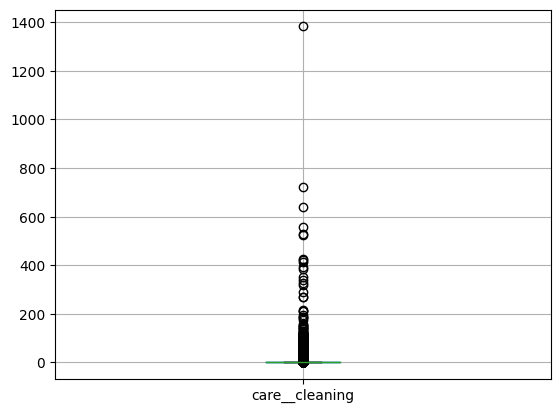

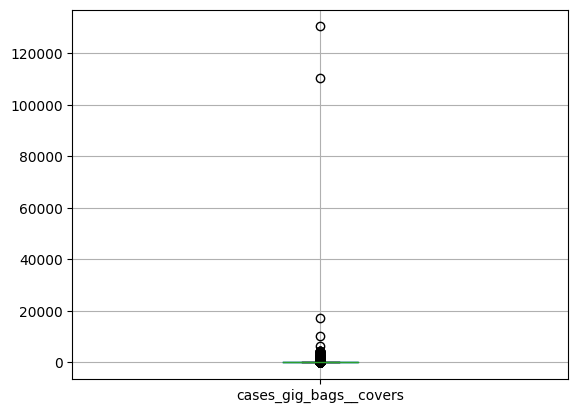

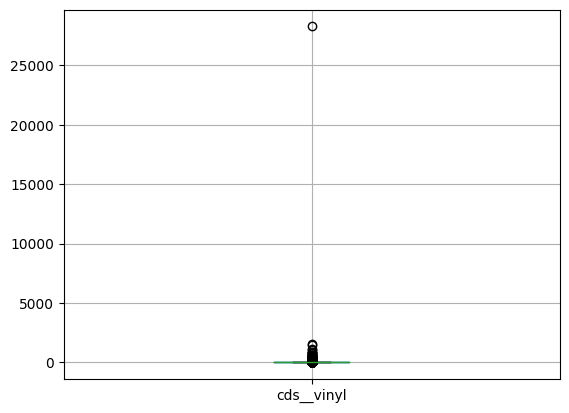

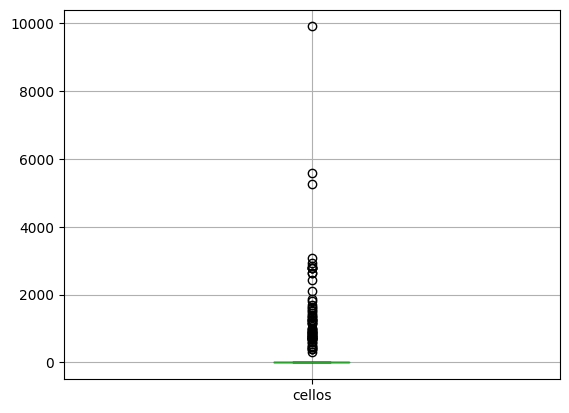

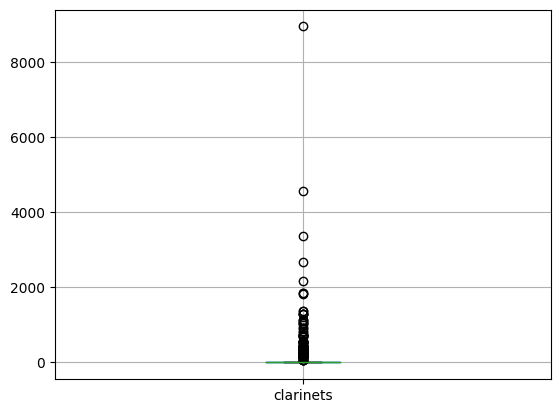

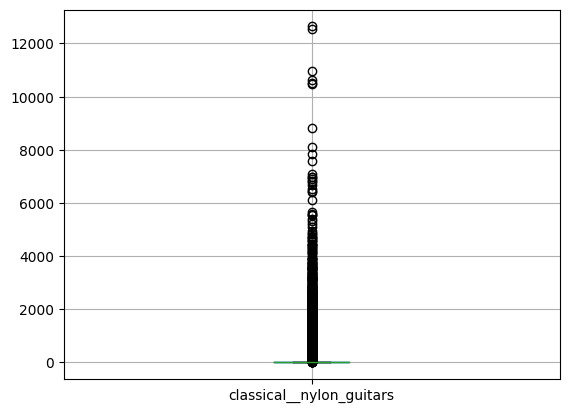

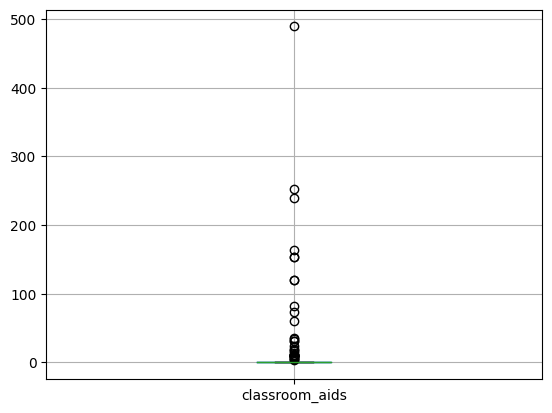

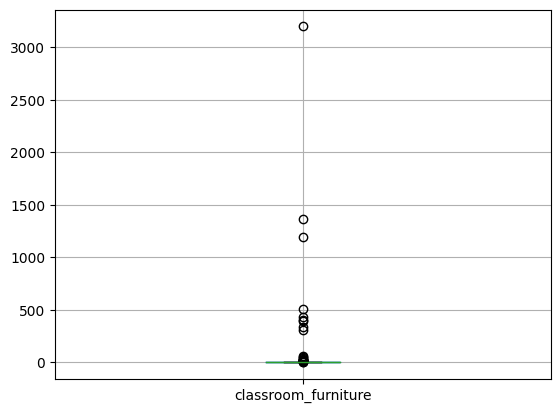

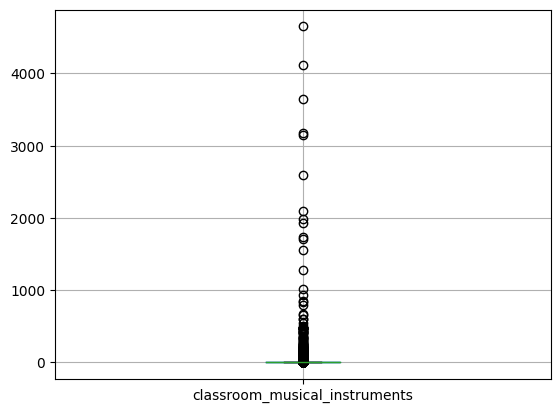

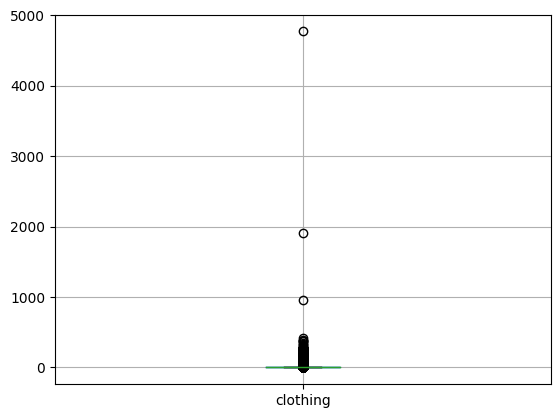

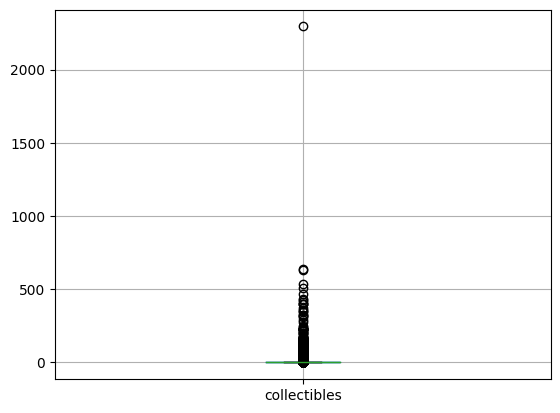

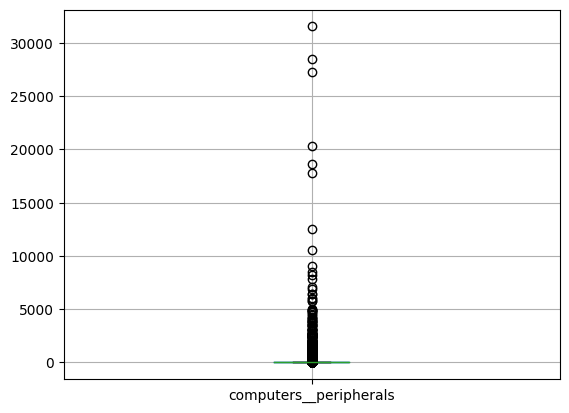

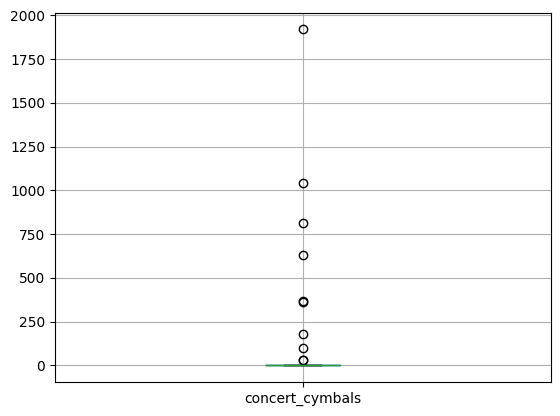

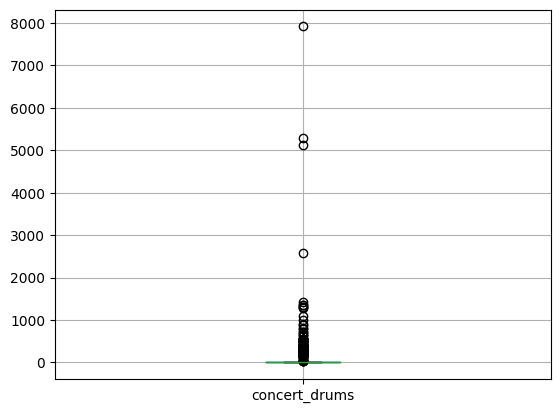

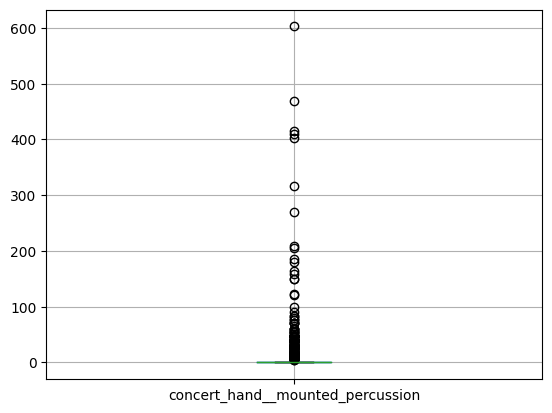

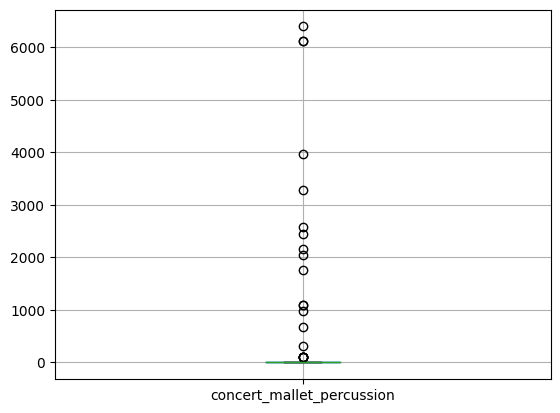

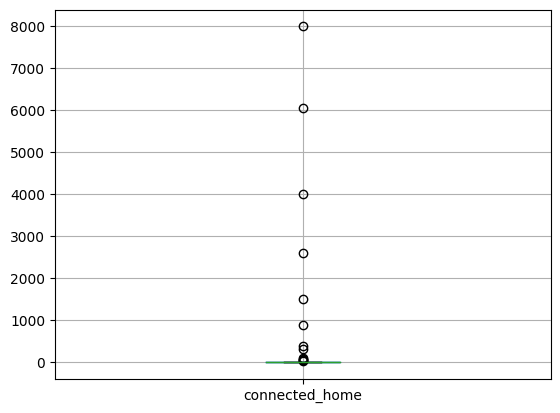

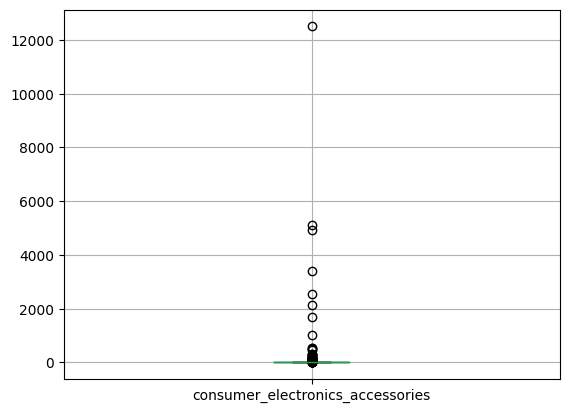

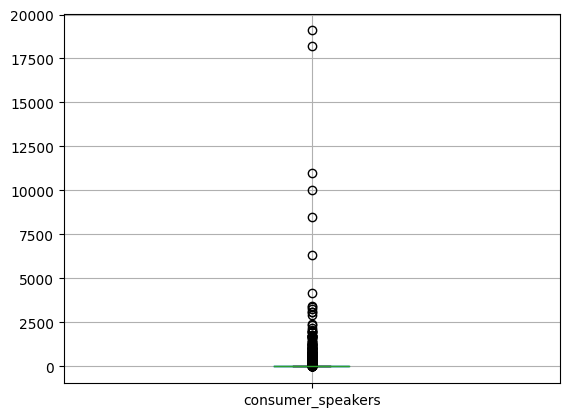

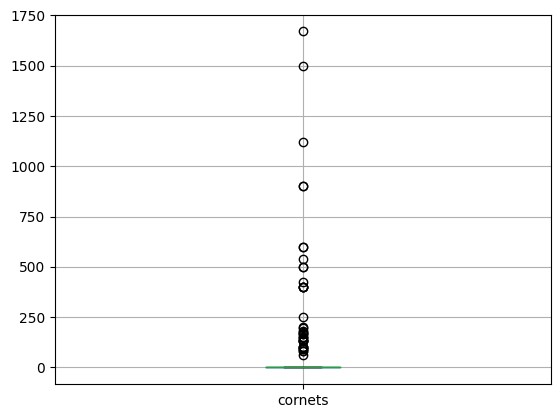

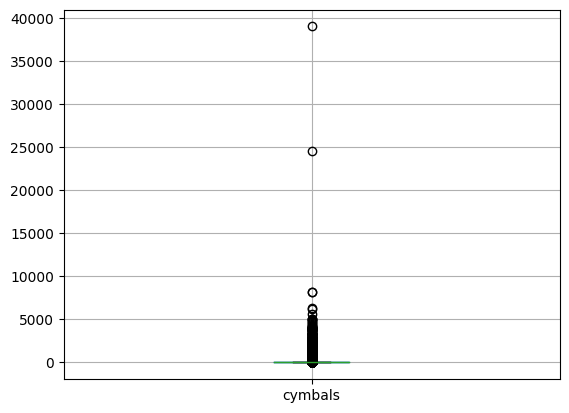

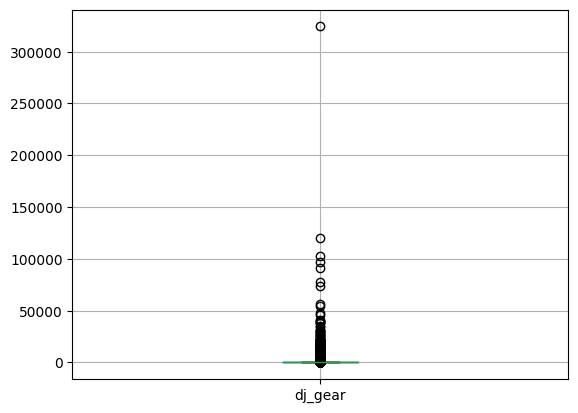

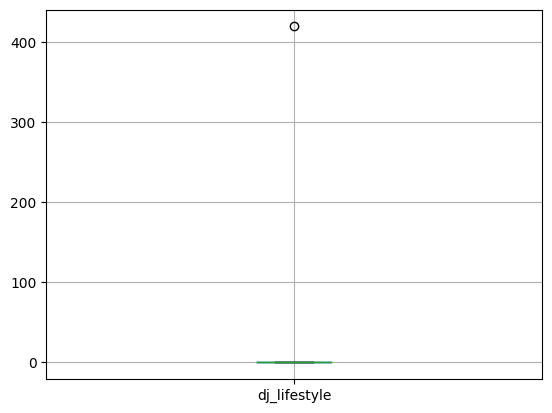

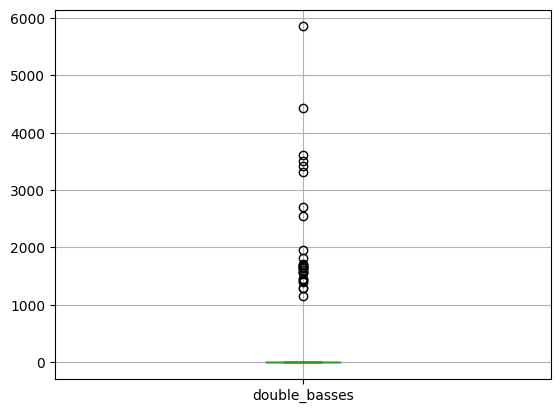

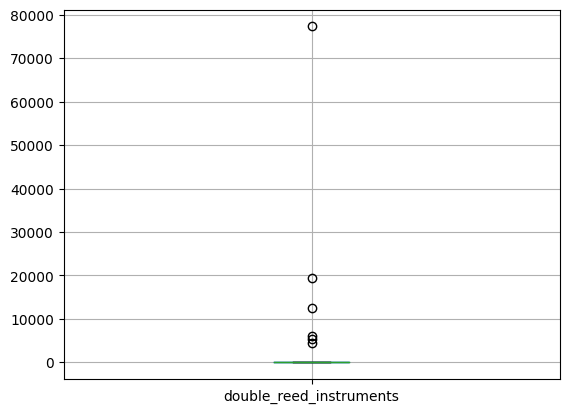

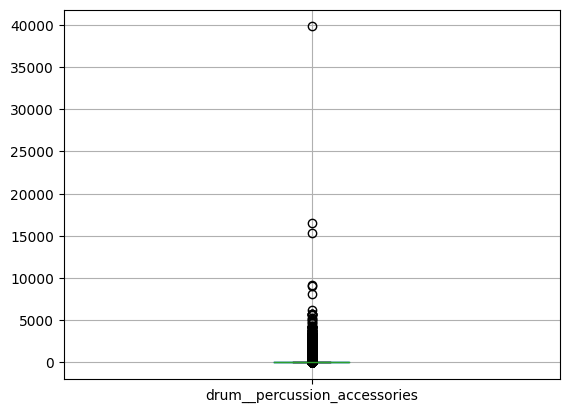

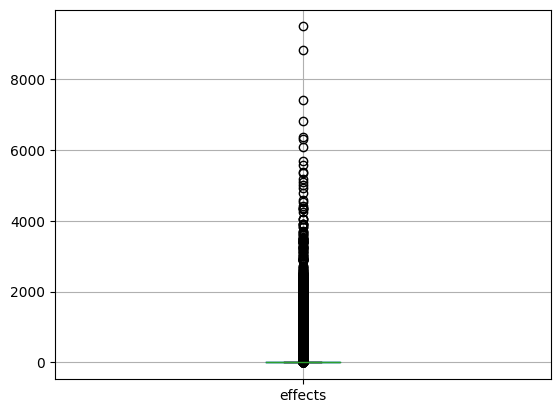

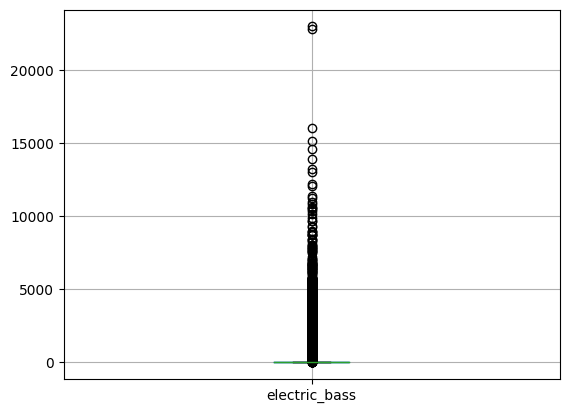

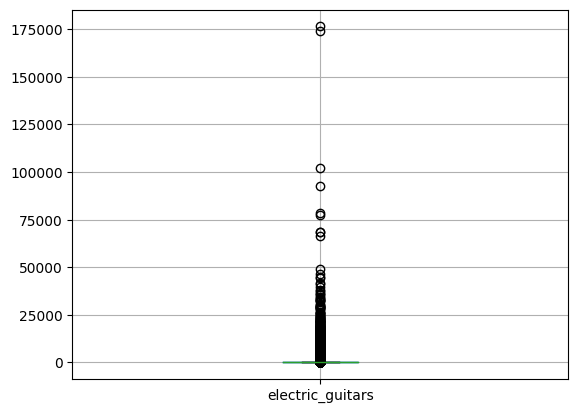

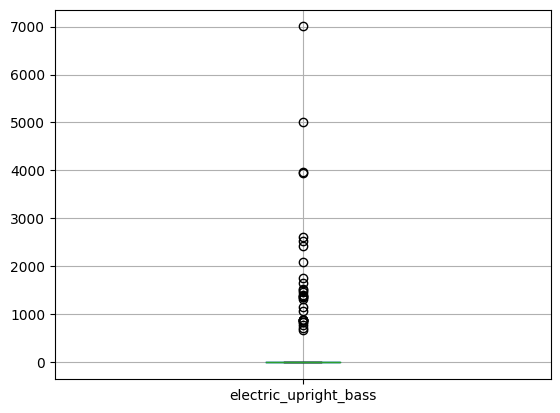

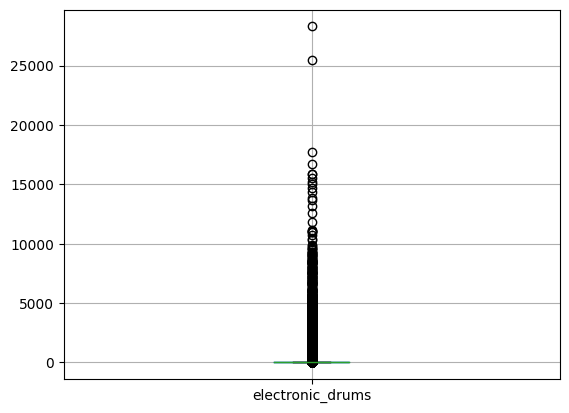

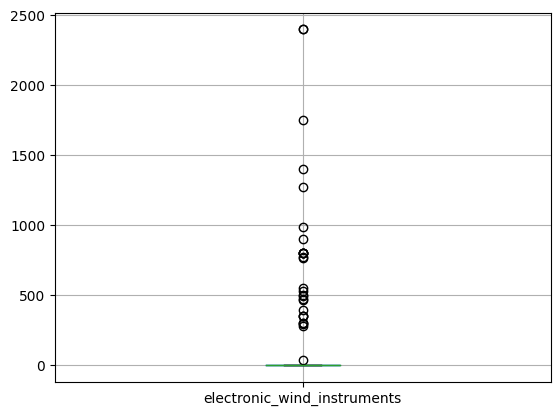

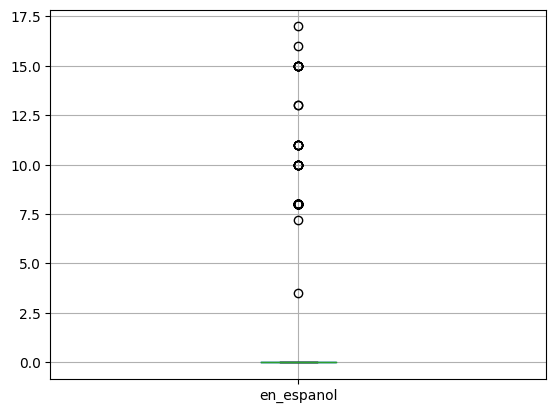

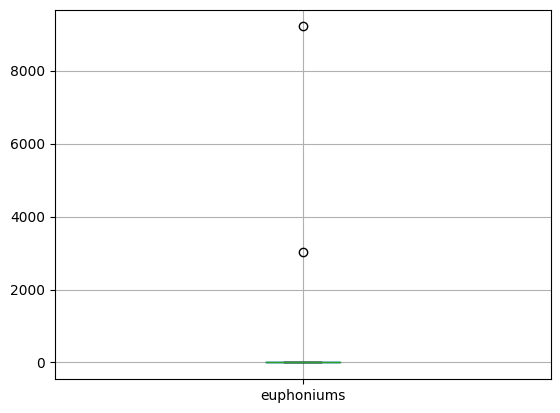

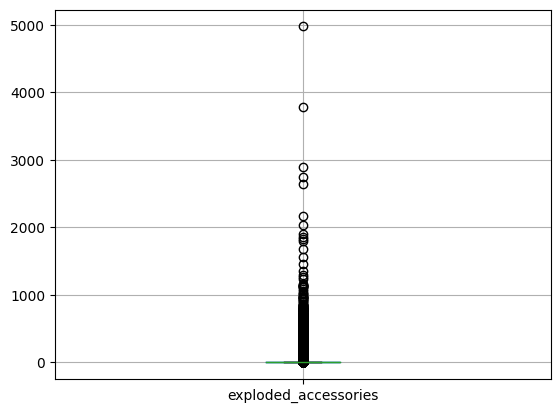

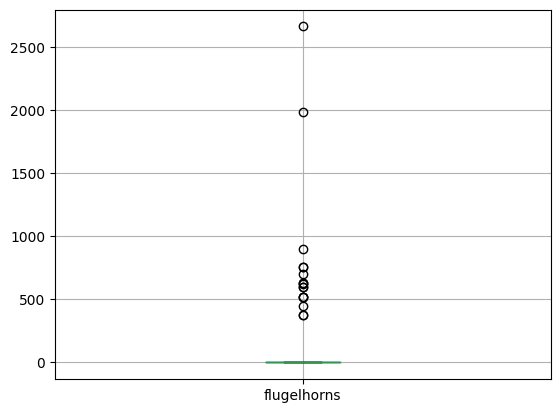

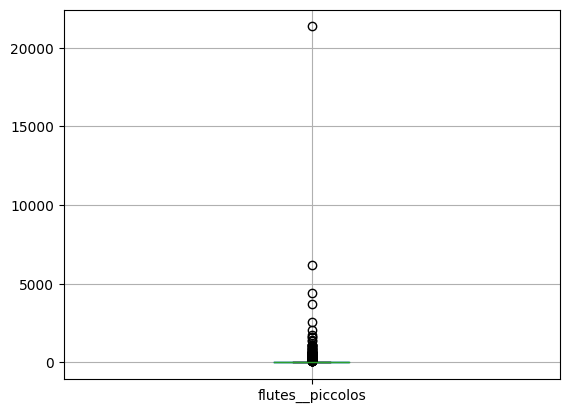

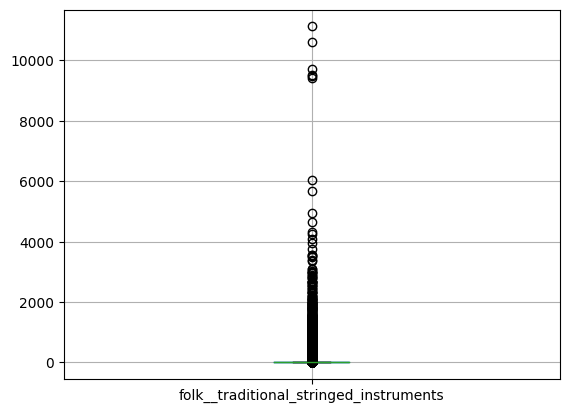

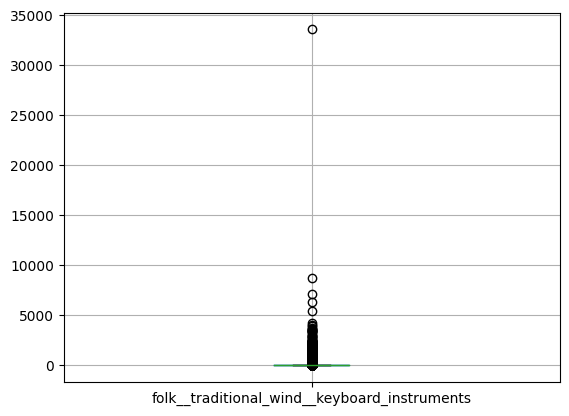

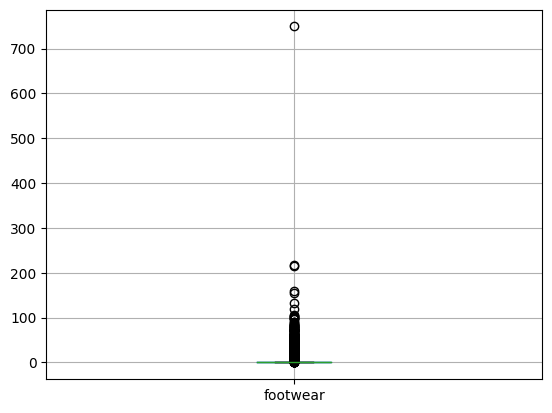

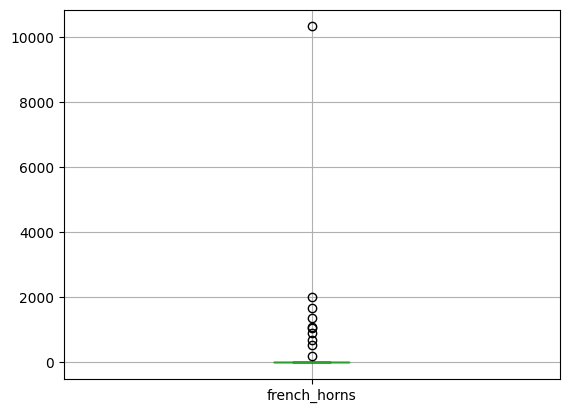

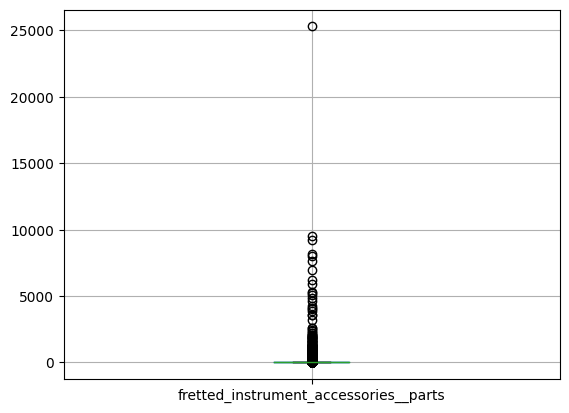

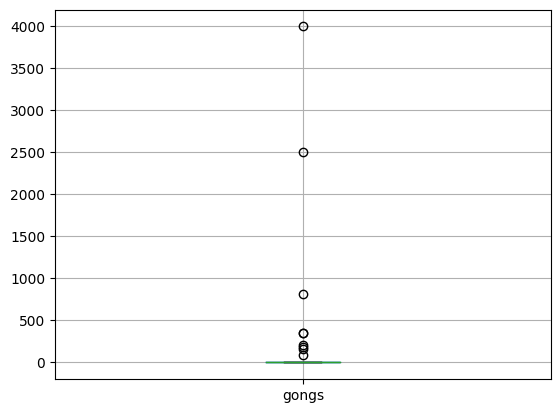

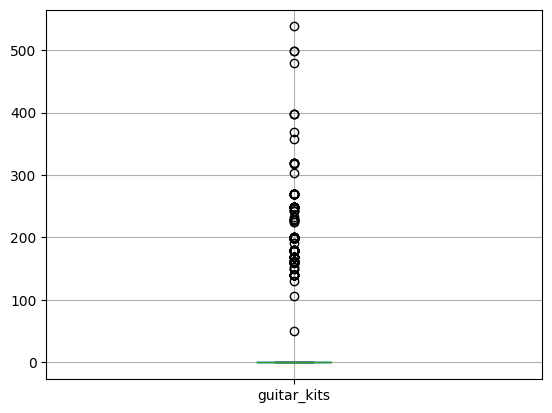

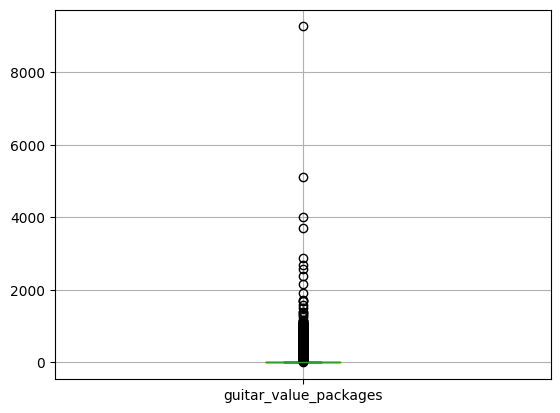

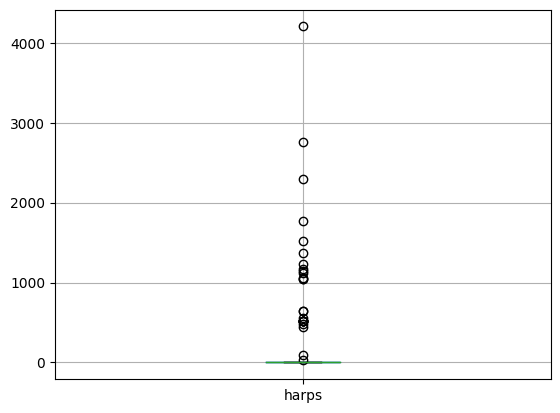

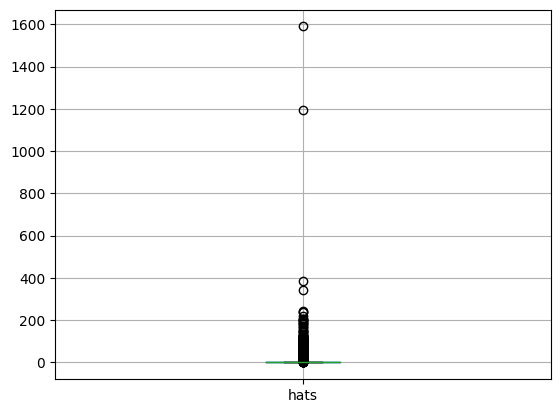

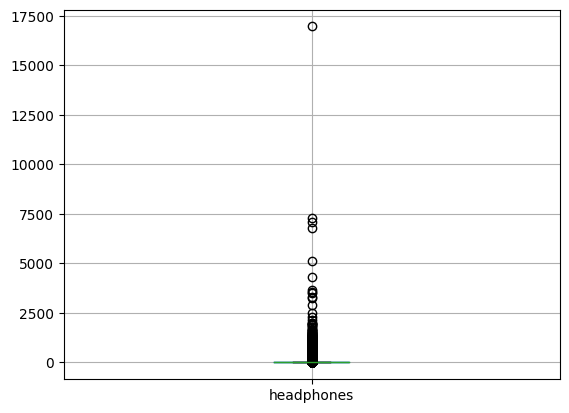

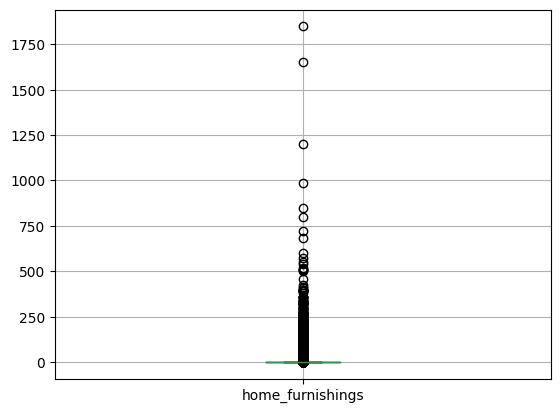

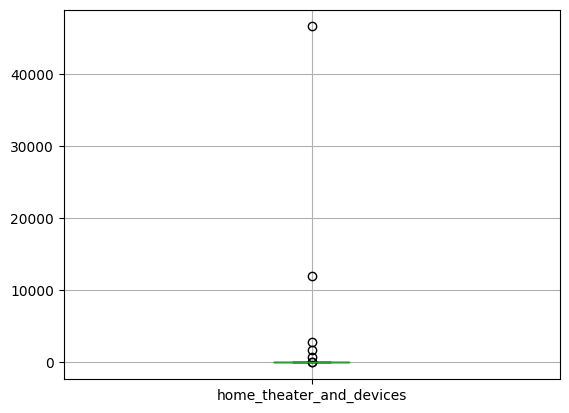

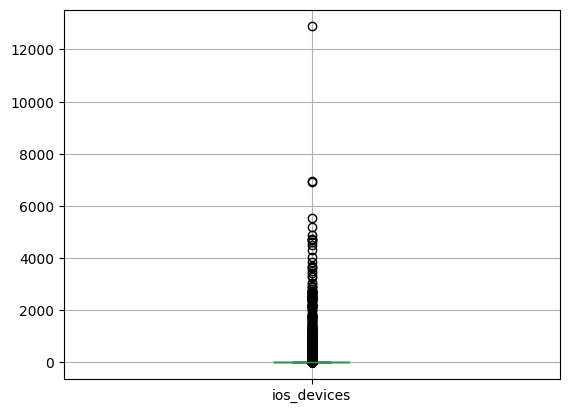

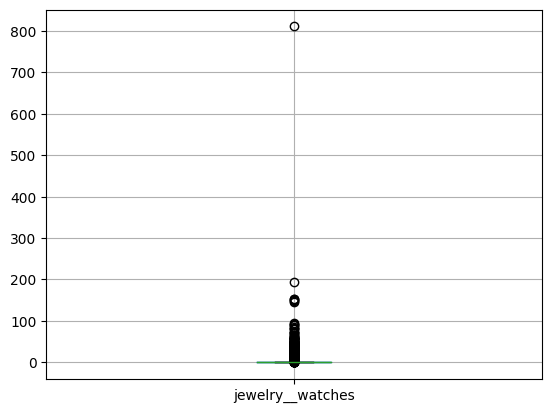

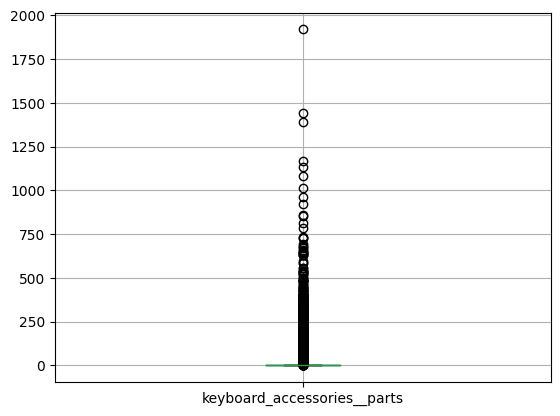

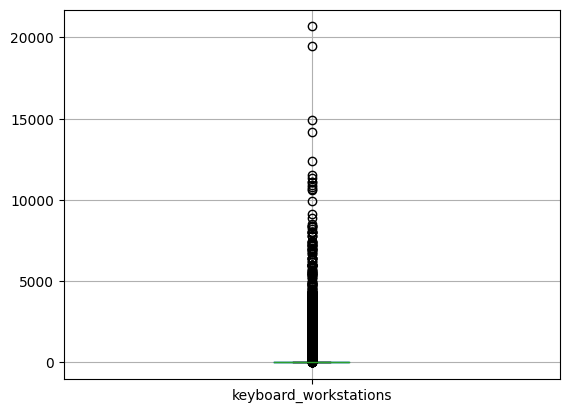

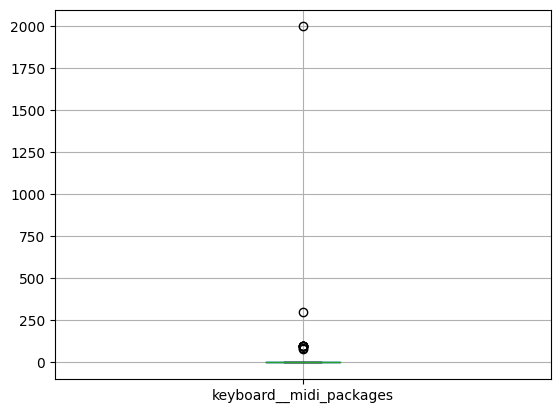

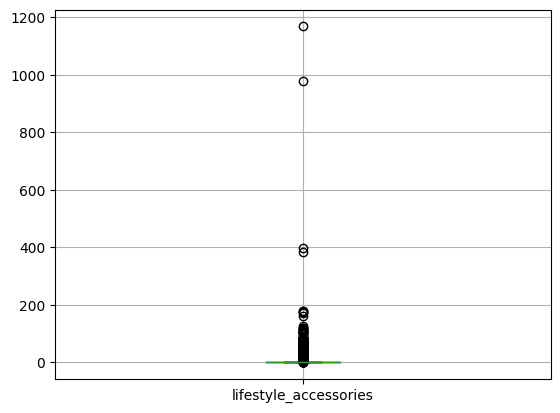

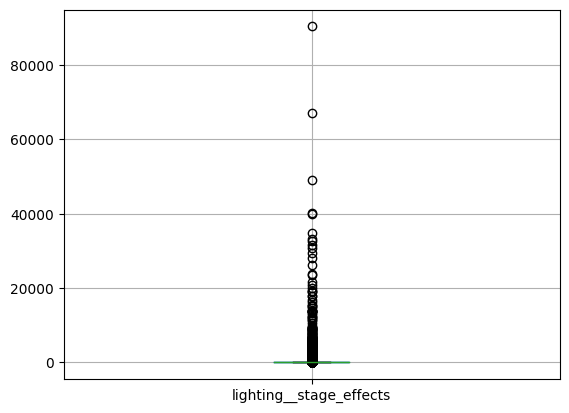

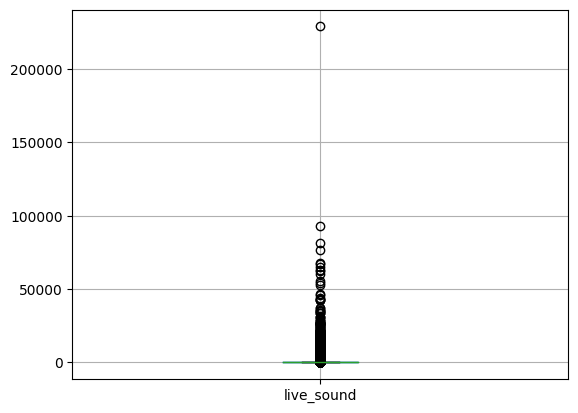

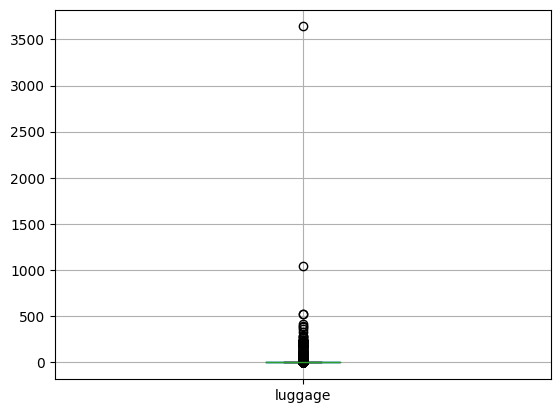

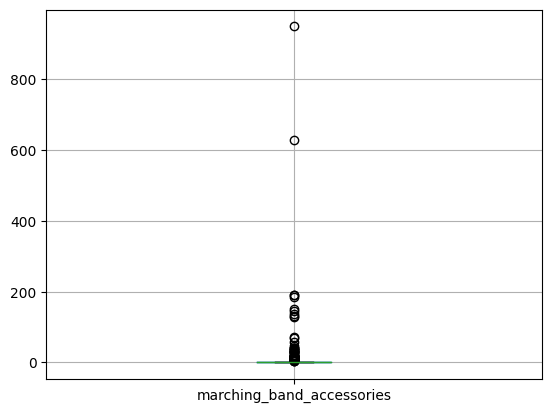

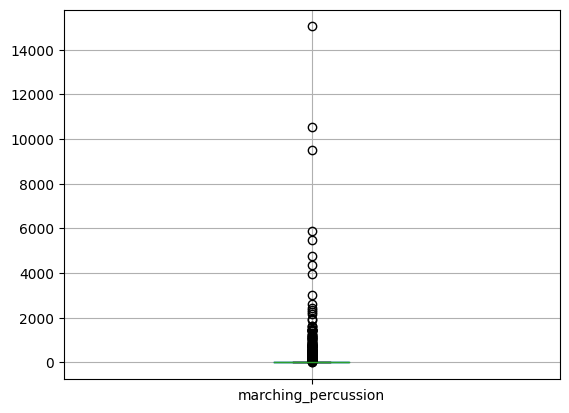

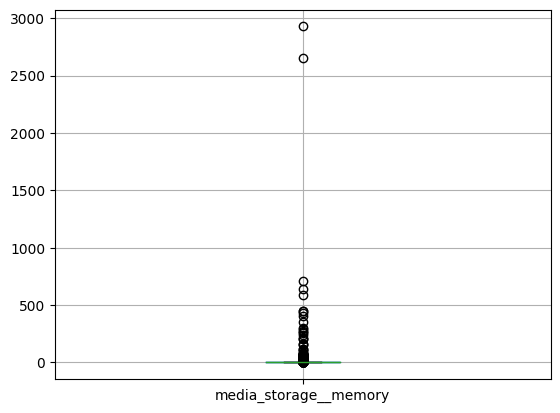

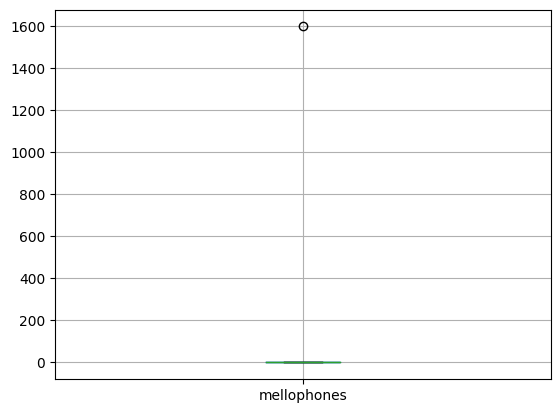

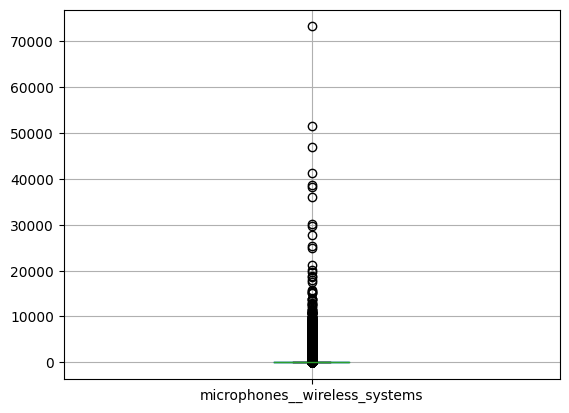

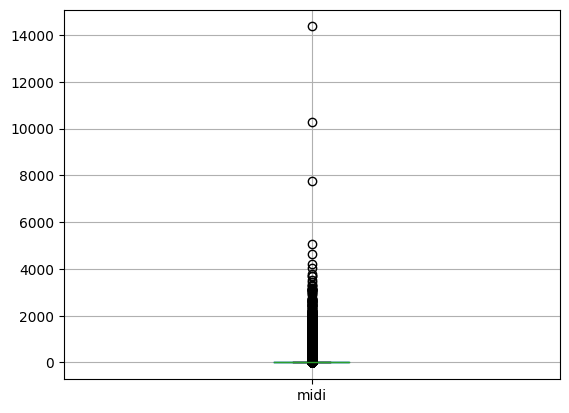

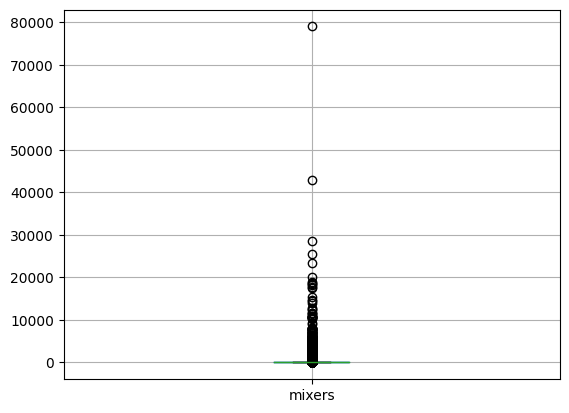

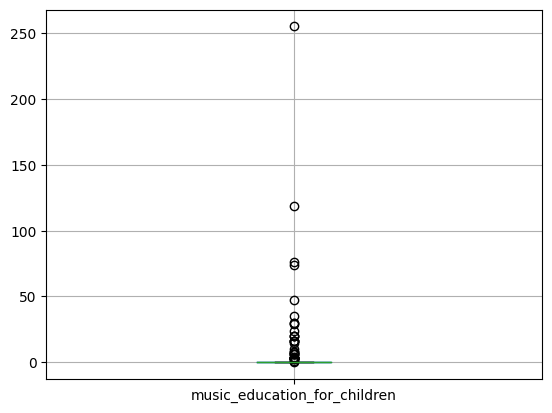

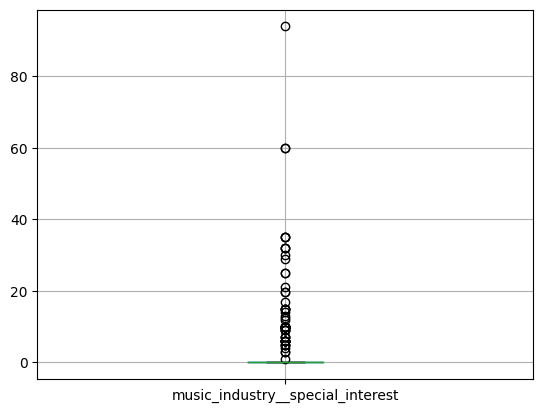

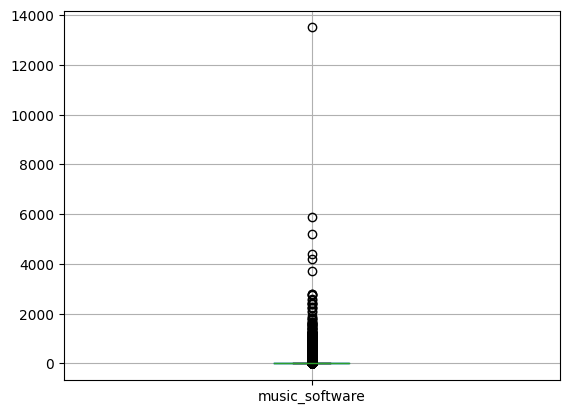

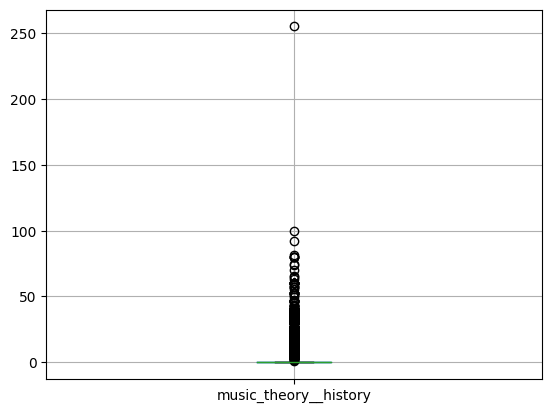

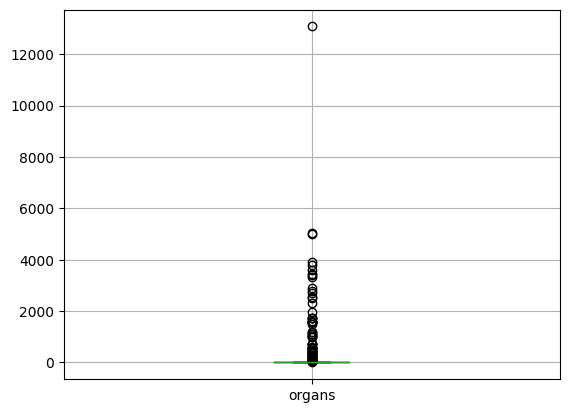

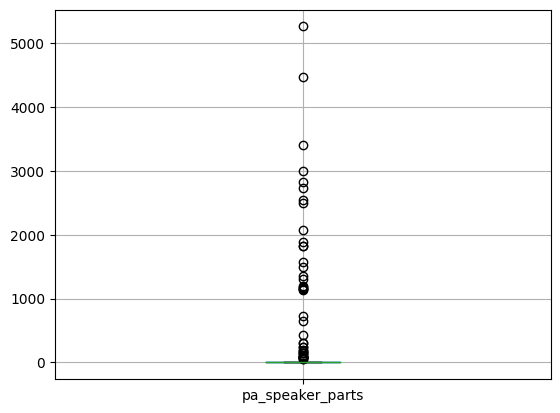

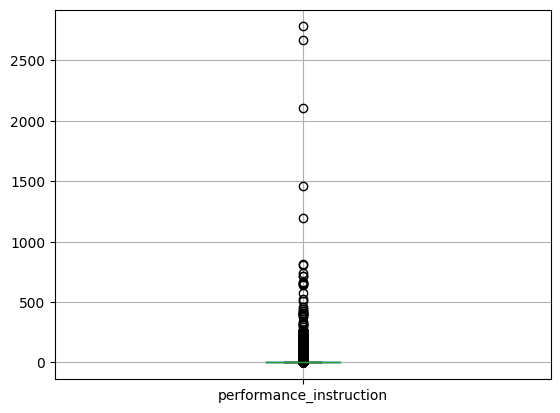

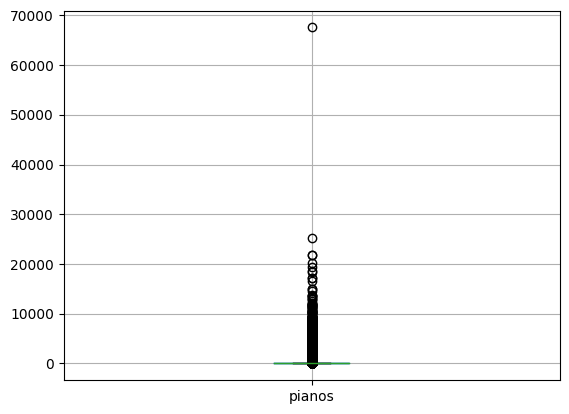

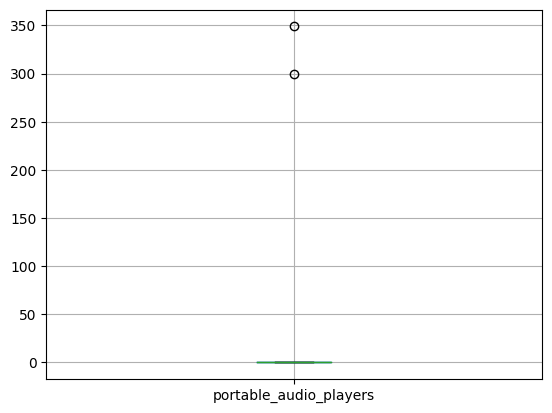

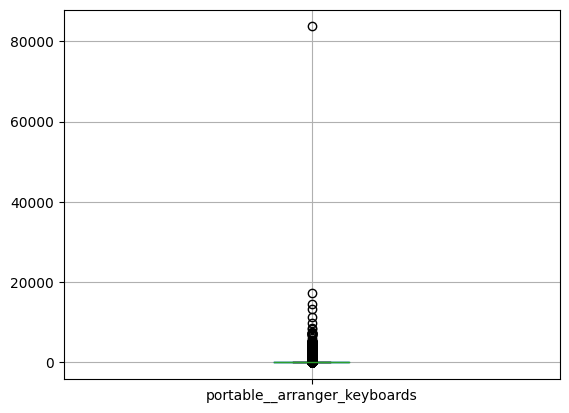

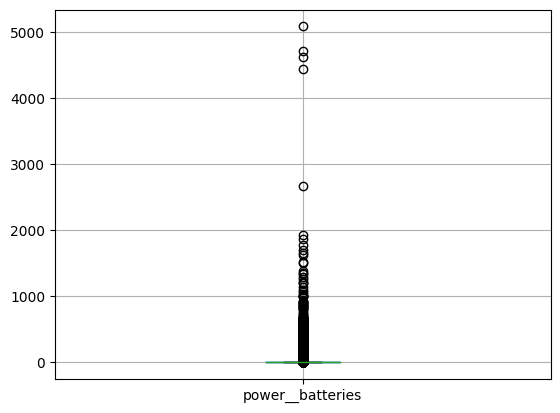

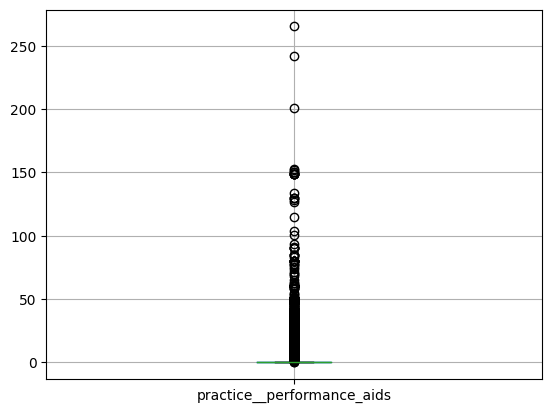

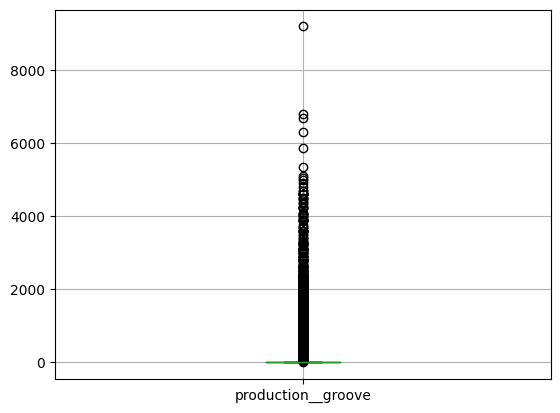

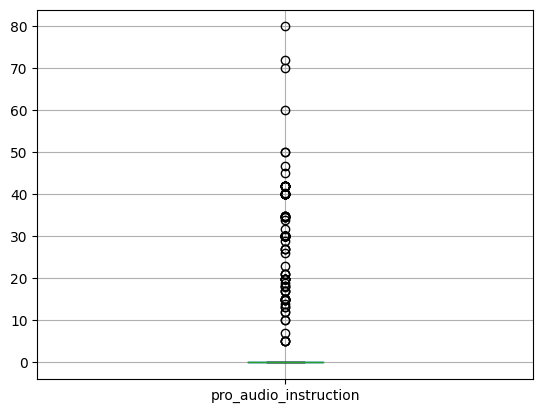

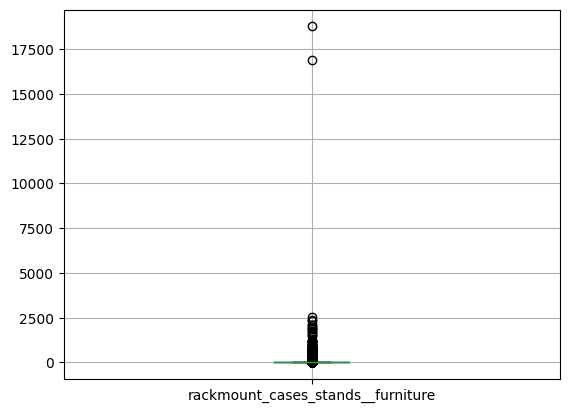

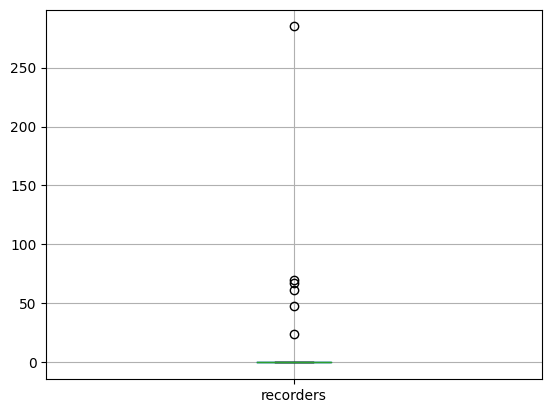

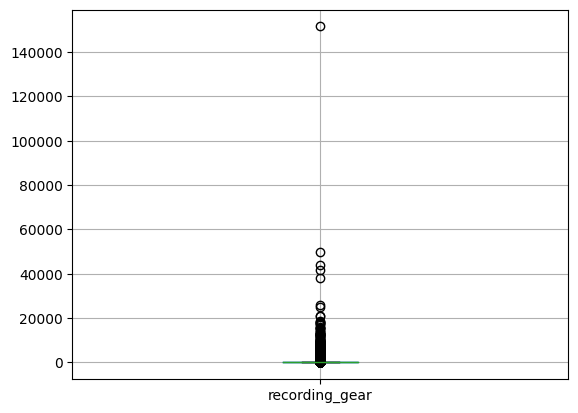

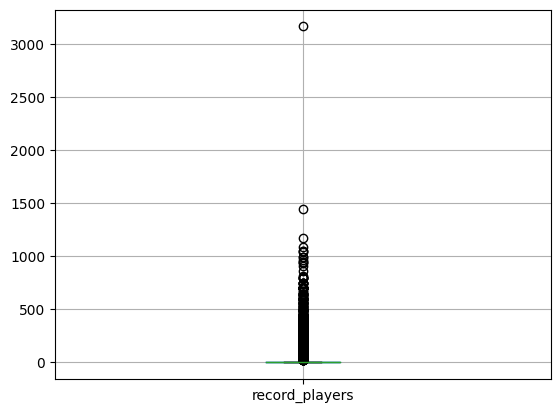

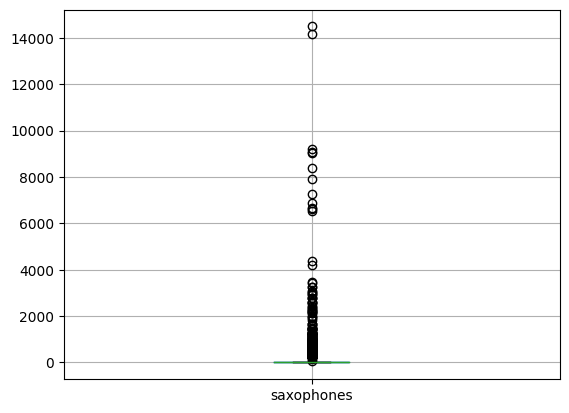

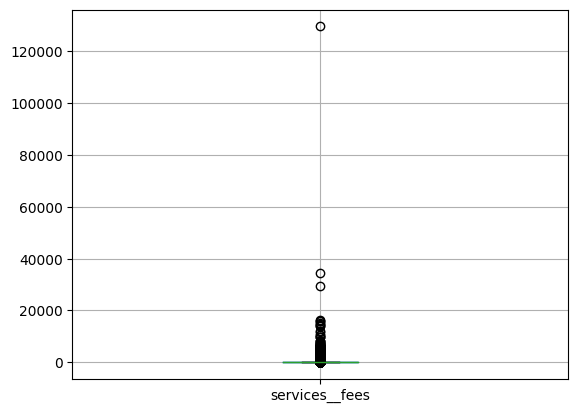

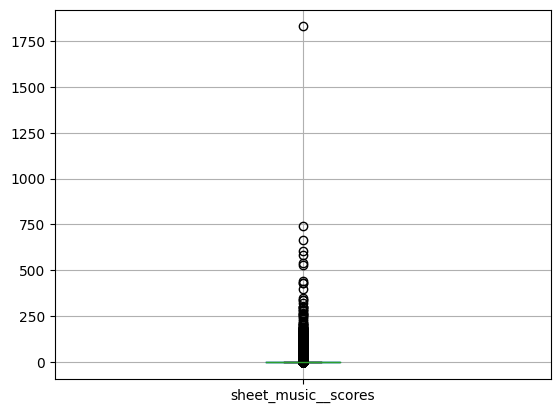

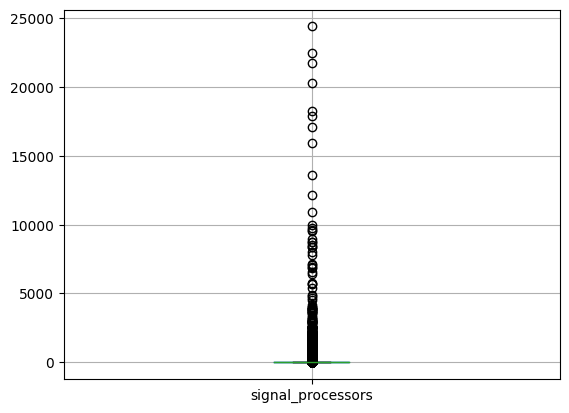

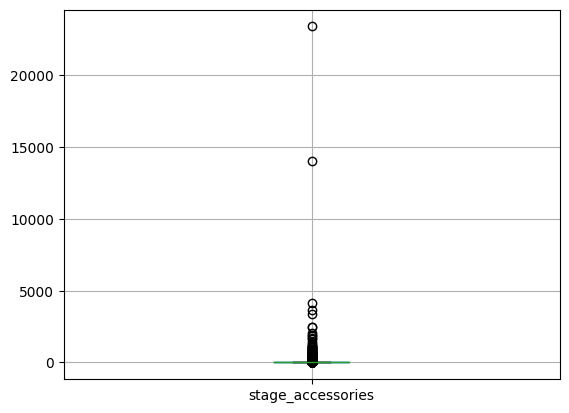

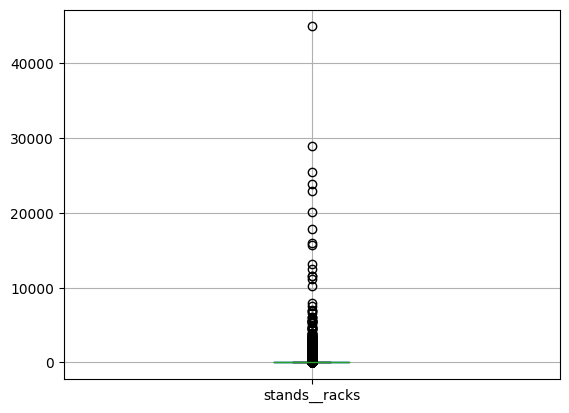

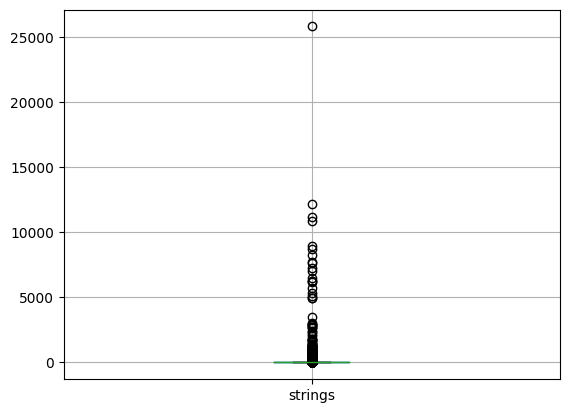

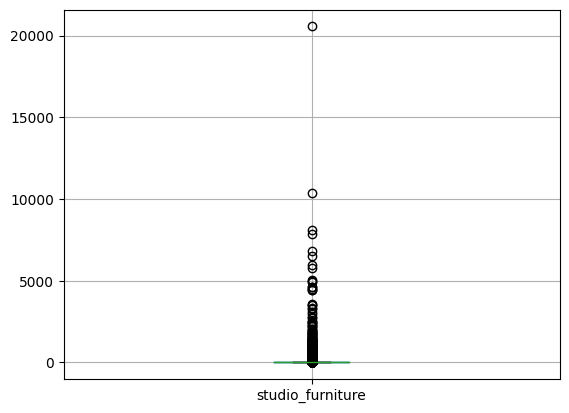

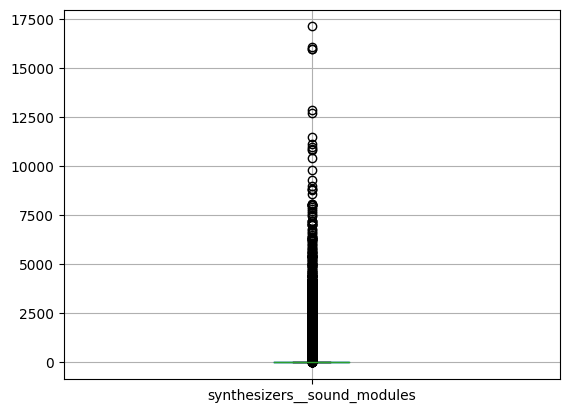

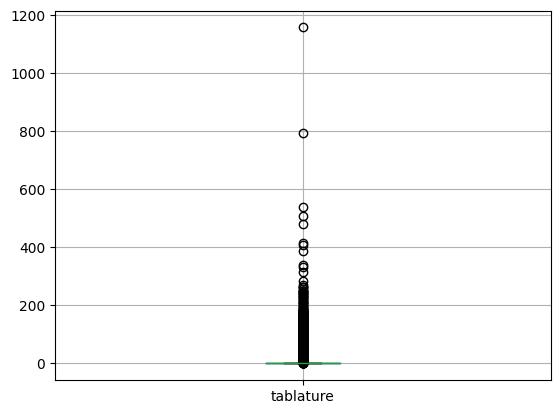

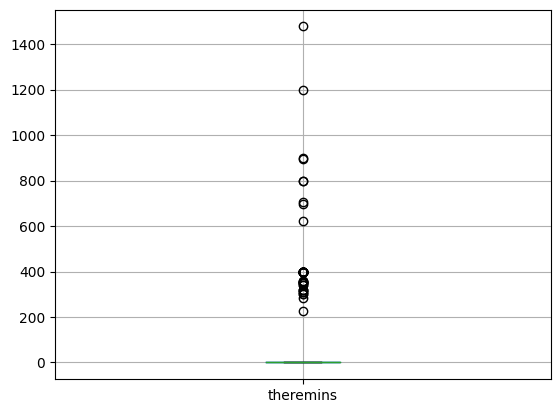

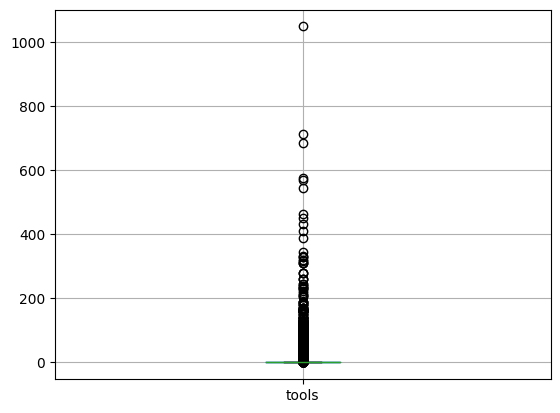

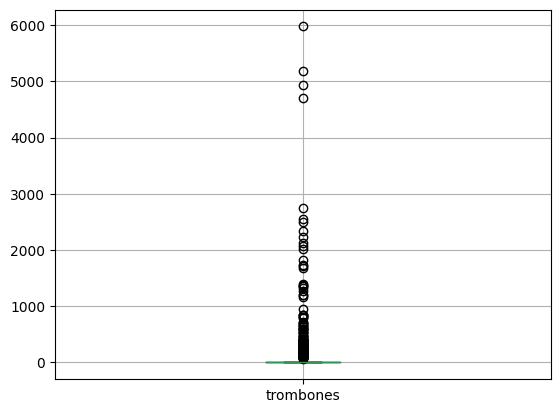

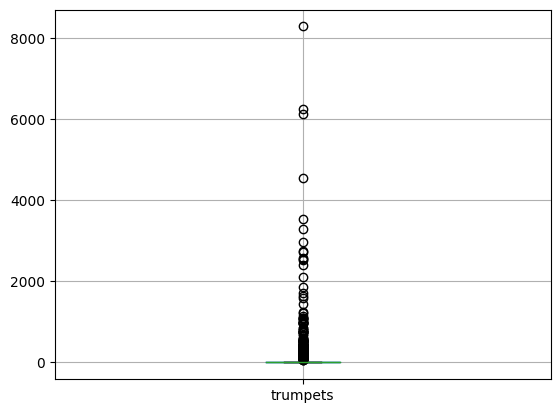

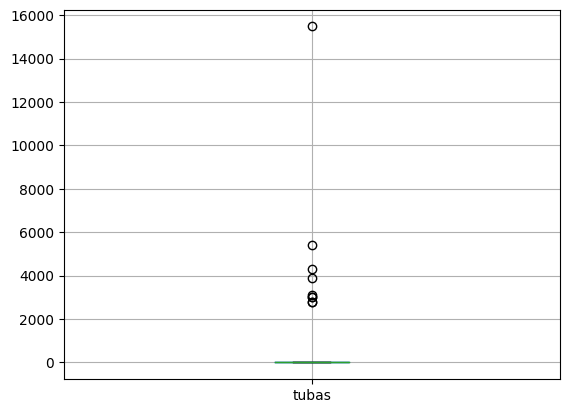

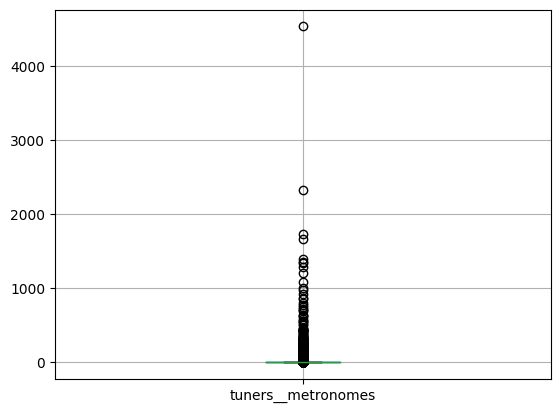

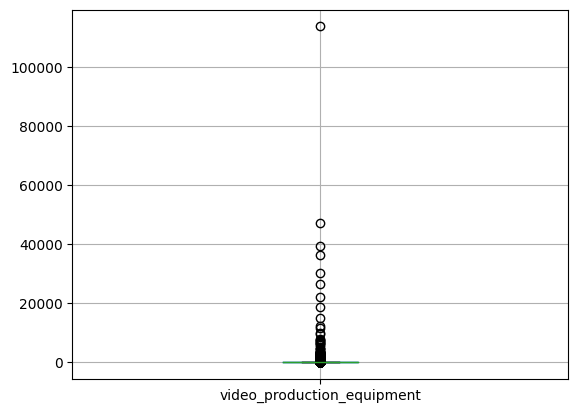

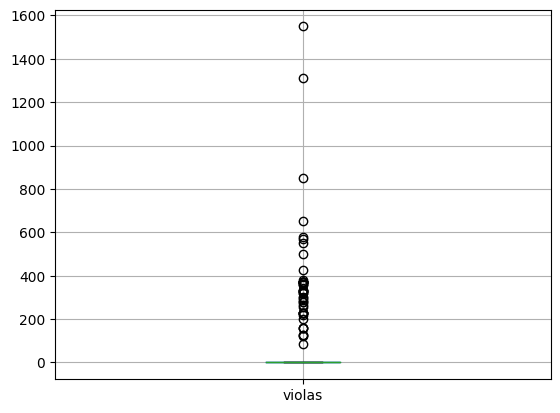

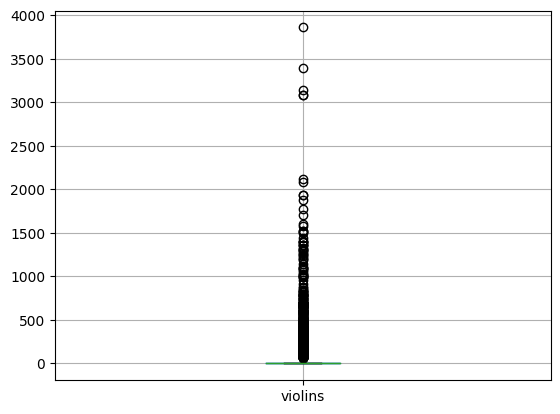

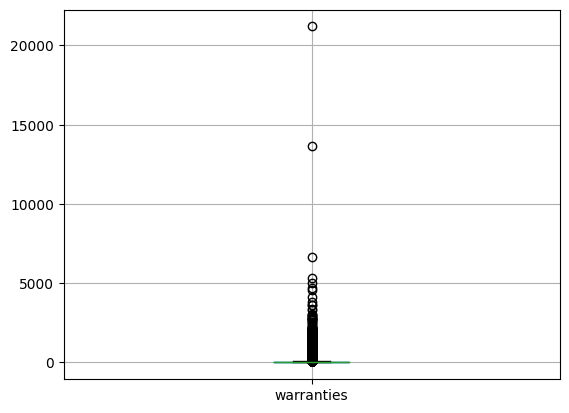

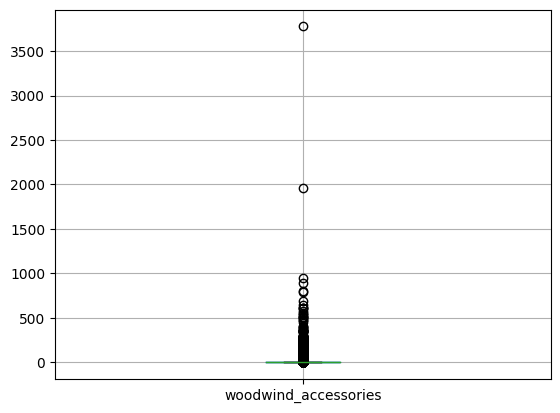

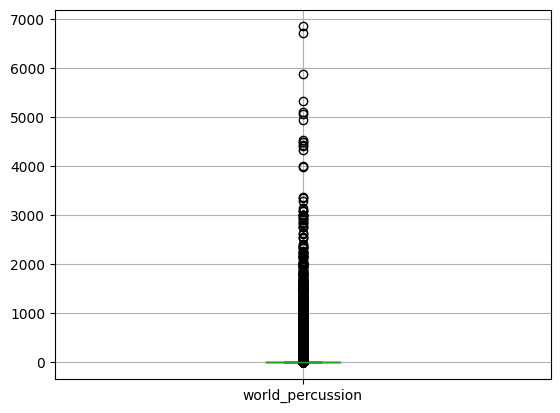

In [ ]:

for column in df_numerical.columns:
    plt.figure()
    pdf.boxplot([column])

In [ ]:
#sdf = spark.createDataFrame(pdf)

## EDA

In [ ]:
categorical_columns=pdf.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['cs_active_lesson_flg', 'rfm_group_dsc', 'age_range', 'gender']

In [ ]:
pdf.gender.value_counts()

Unknown    330675
Male       187069
Female      67624
Name: gender, dtype: int64

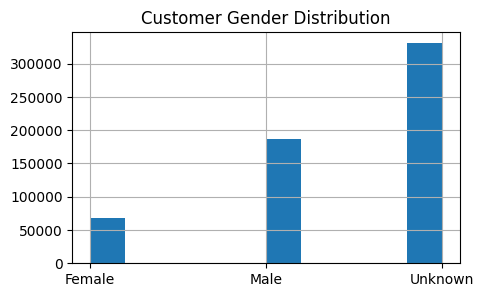

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Customer Gender Distribution');
pdf.gender.hist();


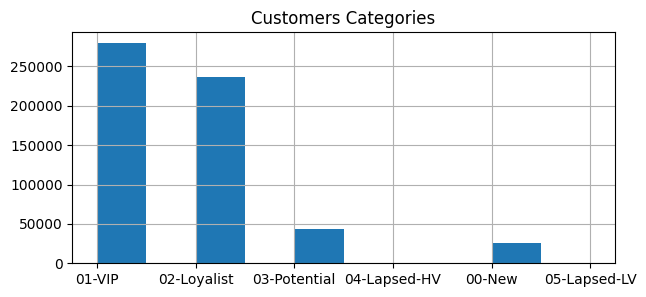

In [ ]:
plt.figure(figsize=(7,3))
plt.title('Customers Categories');
pdf.rfm_group_dsc.hist();

In [ ]:
pdf.age_range.value_counts()

OOR      349859
45-54     81914
35-44     67796
55-64     48164
65+       34219
25-34     28592
18-24      9756
Name: age_range, dtype: int64

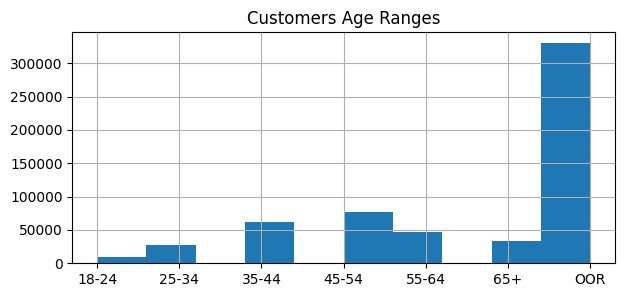

In [ ]:
plt.figure(figsize=(7,3))
plt.title('Customers Age Ranges');
pdf.age_range.hist();

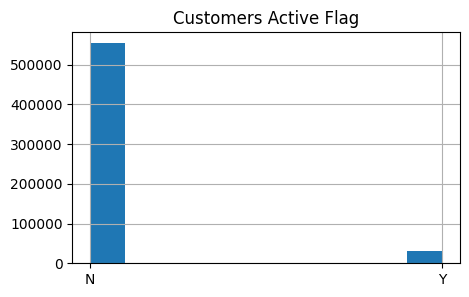

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Customers Active Flag');
pdf.cs_active_lesson_flg.hist();

In [ ]:
# Plot correlation matrix as heatmap
#sns.heatmap(pdf.corr(), annot=True, cmap='coolwarm')
#plt.show()

Check for Data Distribution:

<ipython-input-13-01e6e2fb20cd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

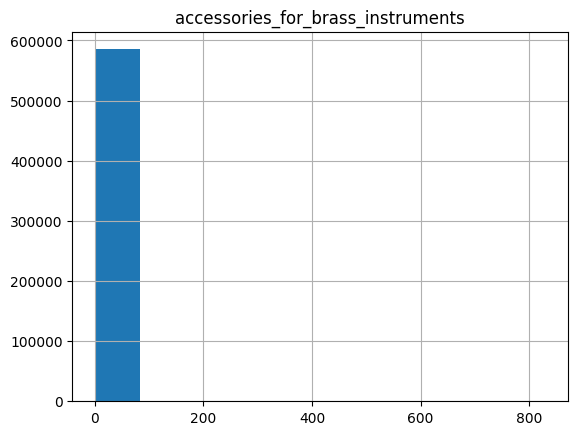

<Figure size 640x480 with 0 Axes>

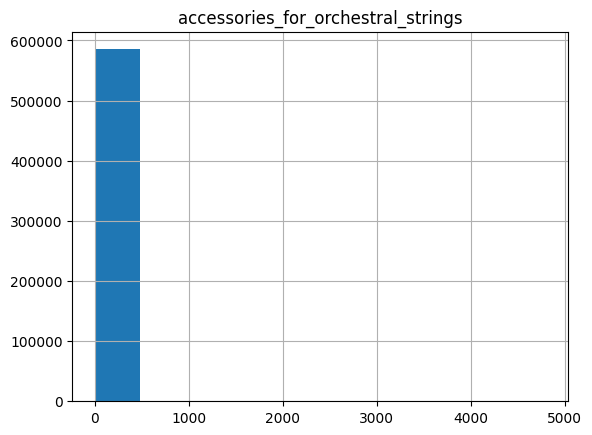

<Figure size 640x480 with 0 Axes>

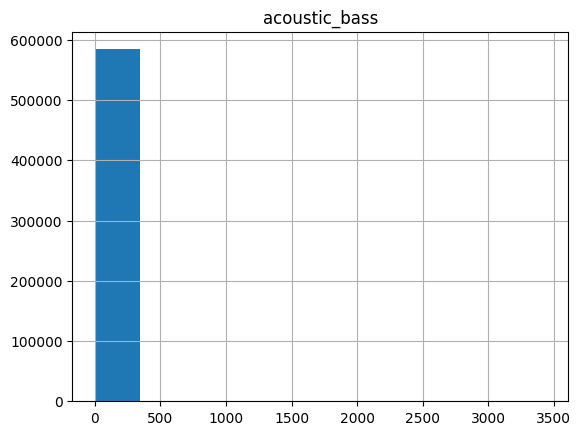

<Figure size 640x480 with 0 Axes>

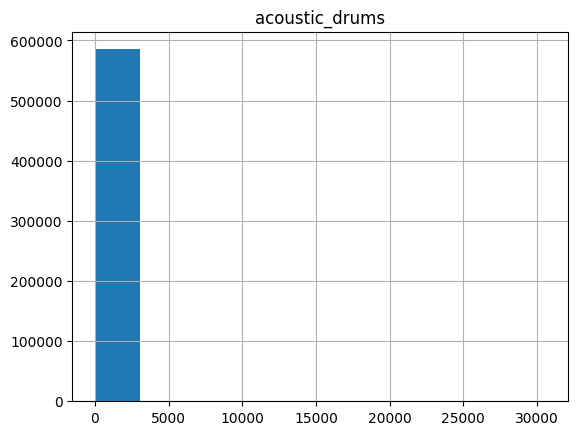

<Figure size 640x480 with 0 Axes>

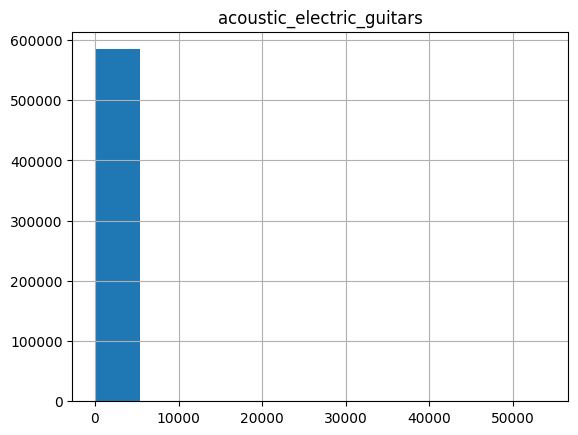

<Figure size 640x480 with 0 Axes>

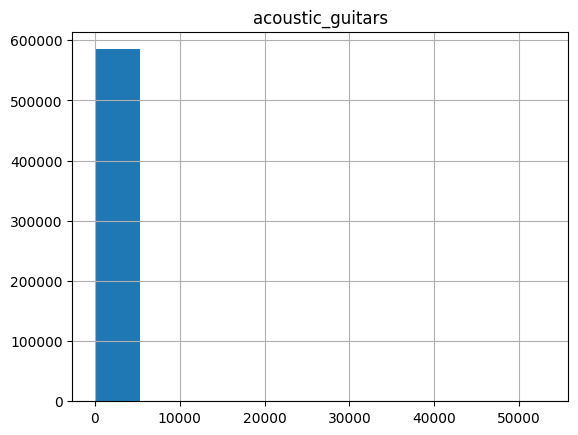

<Figure size 640x480 with 0 Axes>

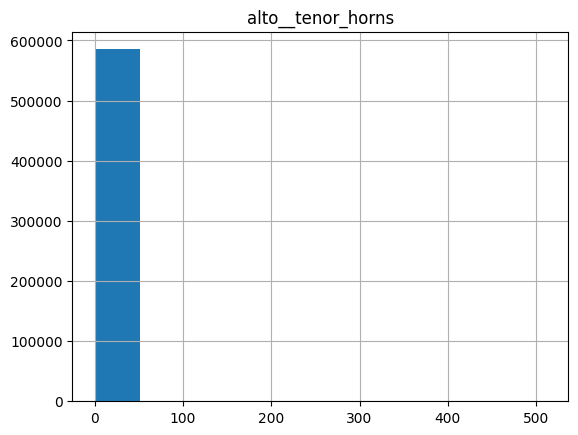

<Figure size 640x480 with 0 Axes>

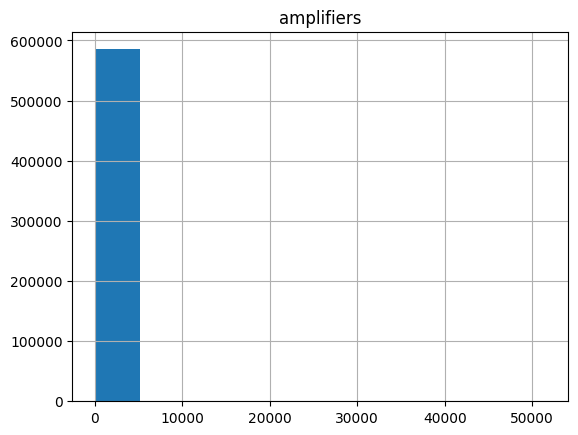

<Figure size 640x480 with 0 Axes>

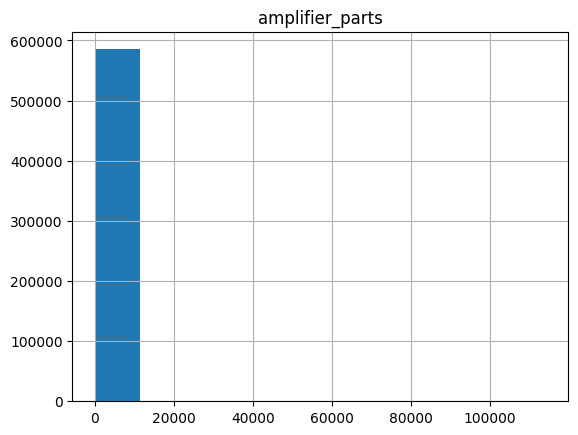

<Figure size 640x480 with 0 Axes>

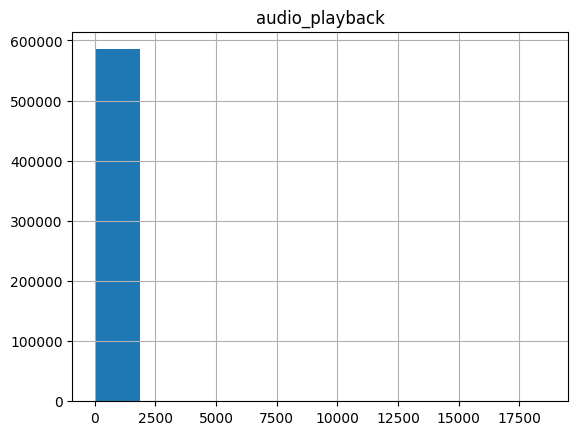

<Figure size 640x480 with 0 Axes>

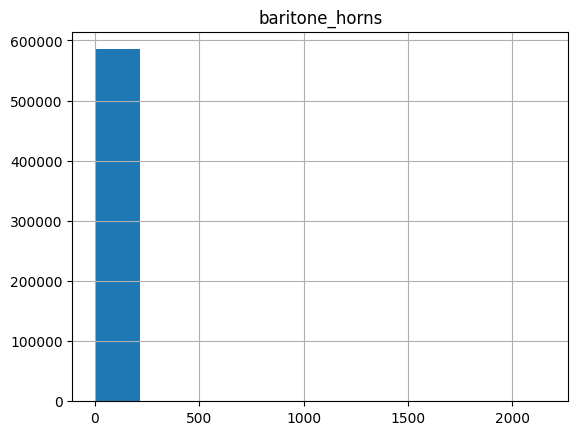

<Figure size 640x480 with 0 Axes>

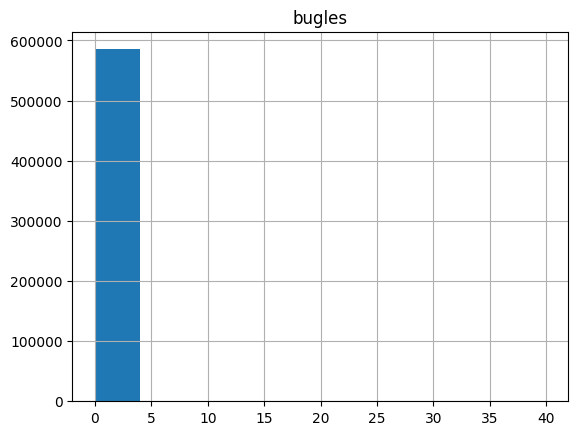

<Figure size 640x480 with 0 Axes>

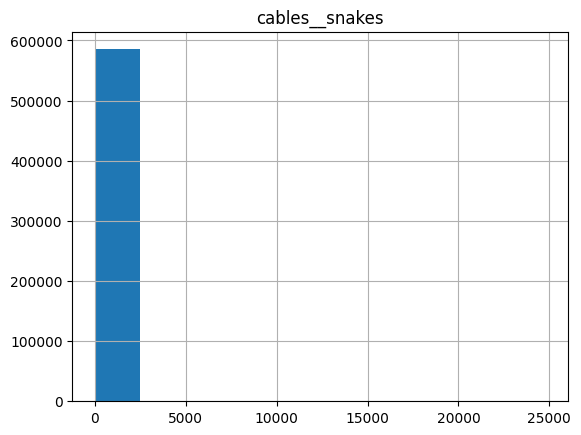

<Figure size 640x480 with 0 Axes>

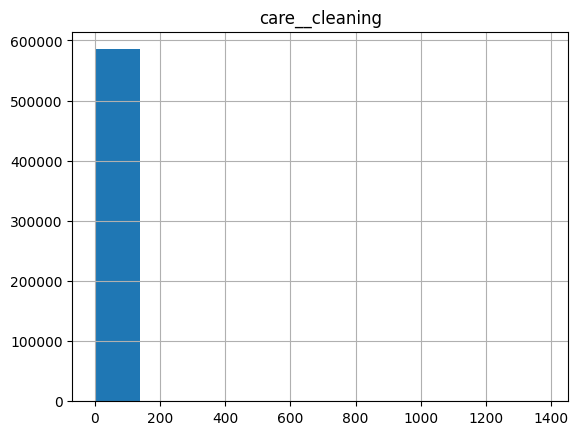

<Figure size 640x480 with 0 Axes>

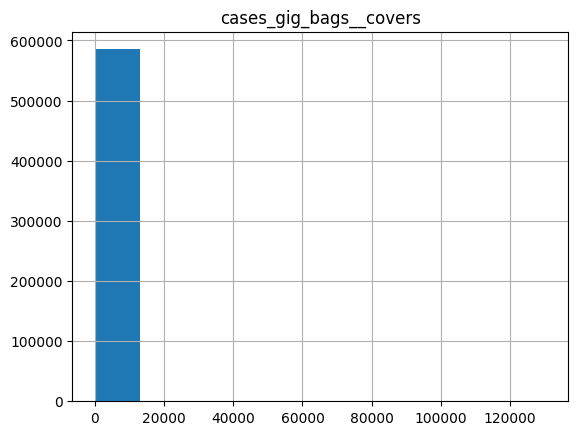

<Figure size 640x480 with 0 Axes>

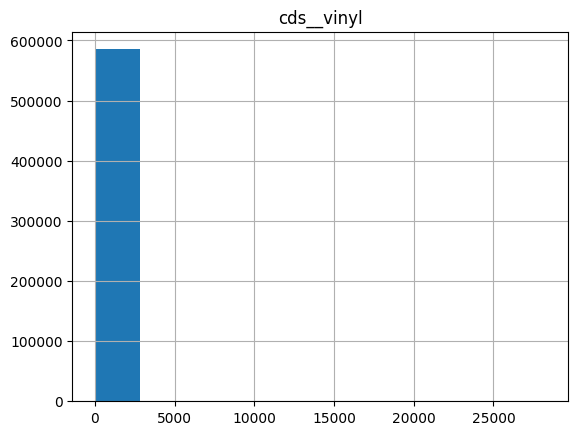

<Figure size 640x480 with 0 Axes>

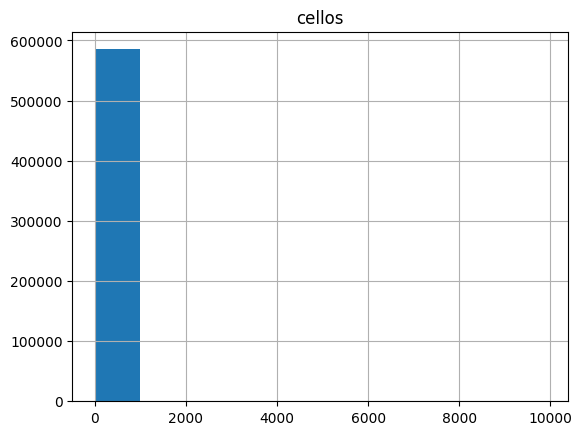

<Figure size 640x480 with 0 Axes>

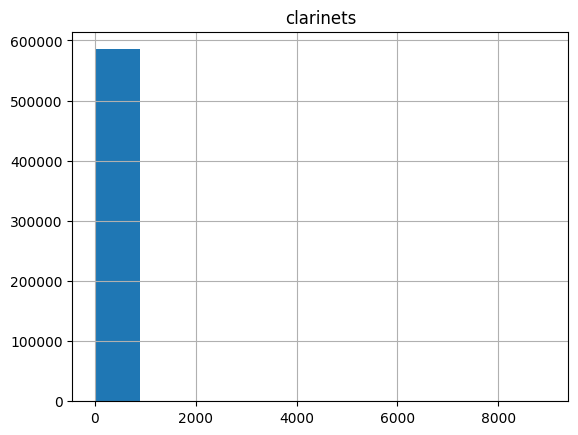

<Figure size 640x480 with 0 Axes>

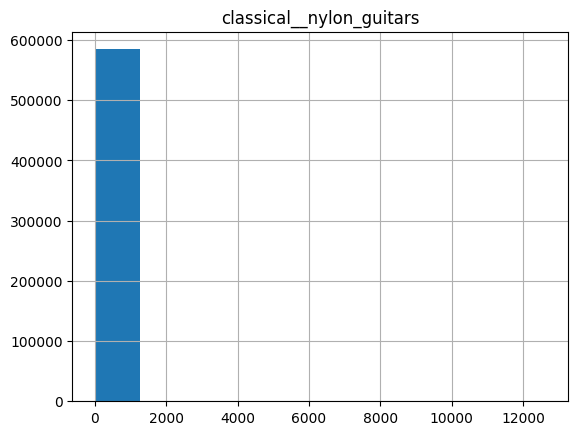

<Figure size 640x480 with 0 Axes>

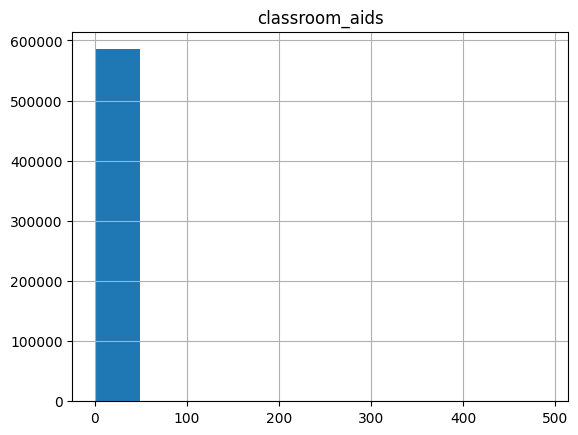

<Figure size 640x480 with 0 Axes>

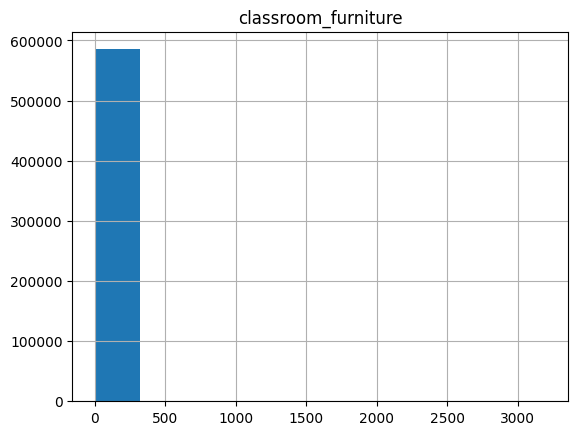

<Figure size 640x480 with 0 Axes>

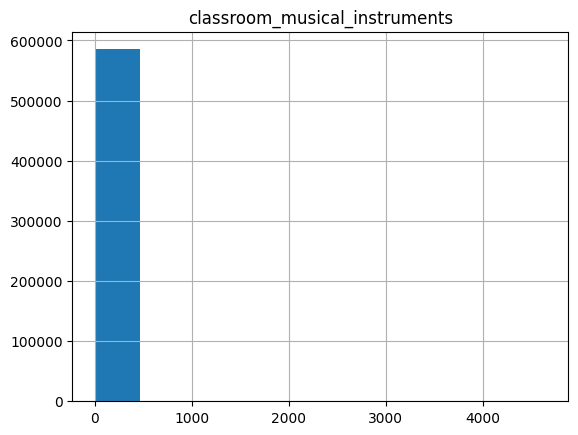

<Figure size 640x480 with 0 Axes>

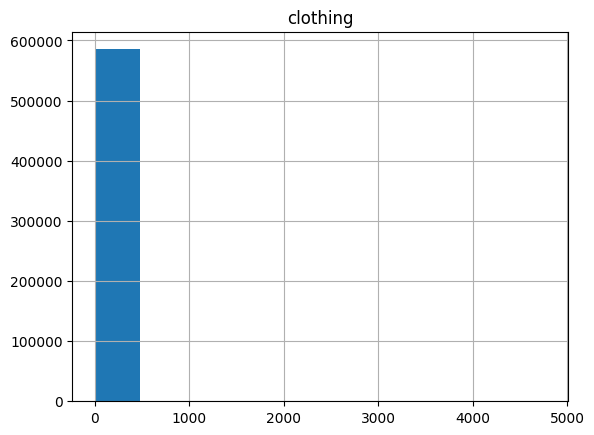

<Figure size 640x480 with 0 Axes>

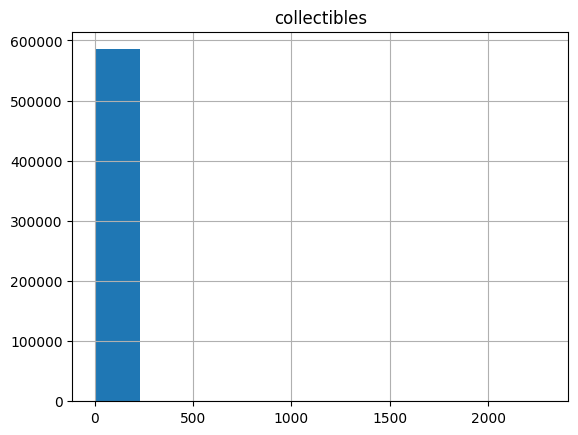

<Figure size 640x480 with 0 Axes>

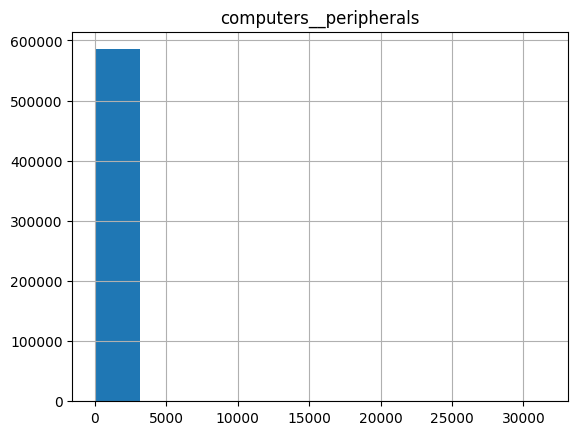

<Figure size 640x480 with 0 Axes>

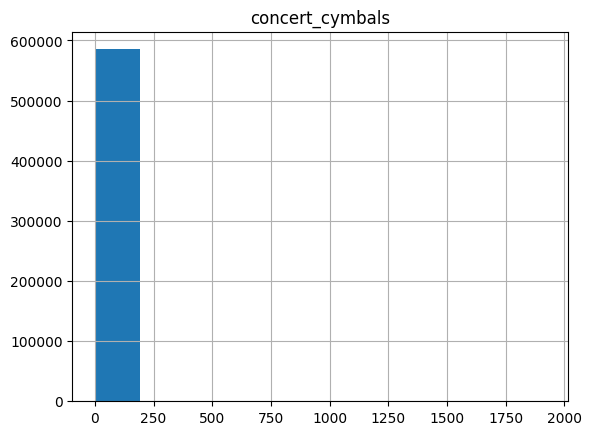

<Figure size 640x480 with 0 Axes>

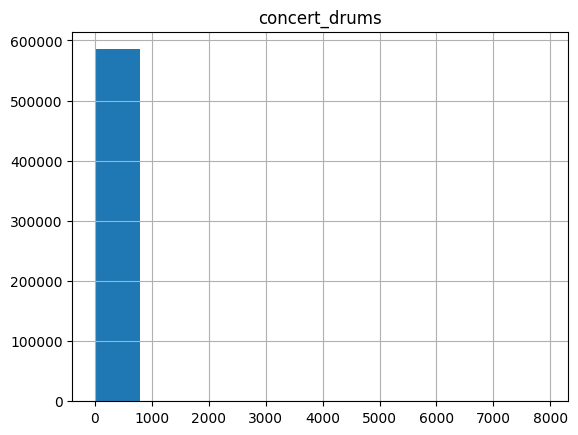

<Figure size 640x480 with 0 Axes>

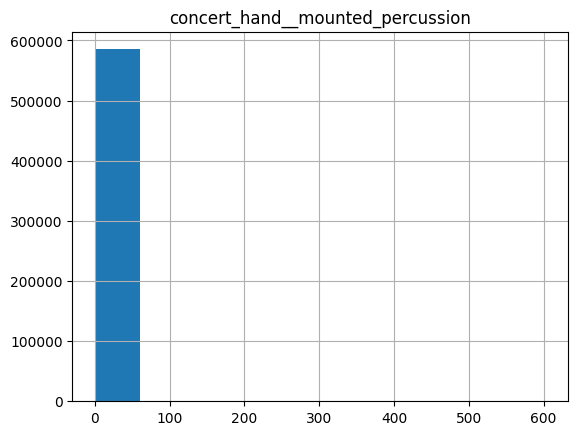

<Figure size 640x480 with 0 Axes>

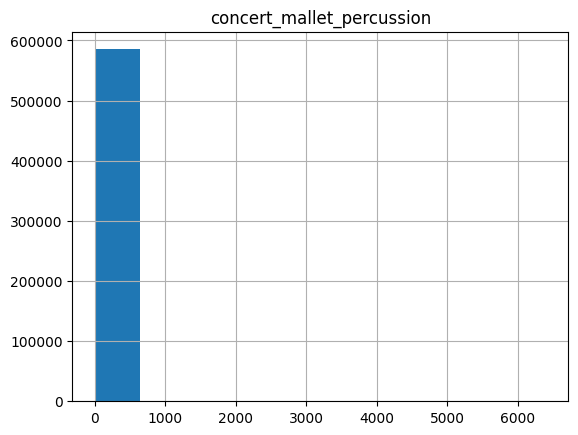

<Figure size 640x480 with 0 Axes>

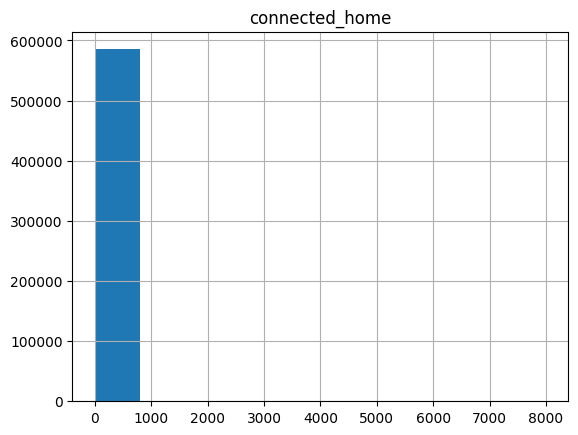

<Figure size 640x480 with 0 Axes>

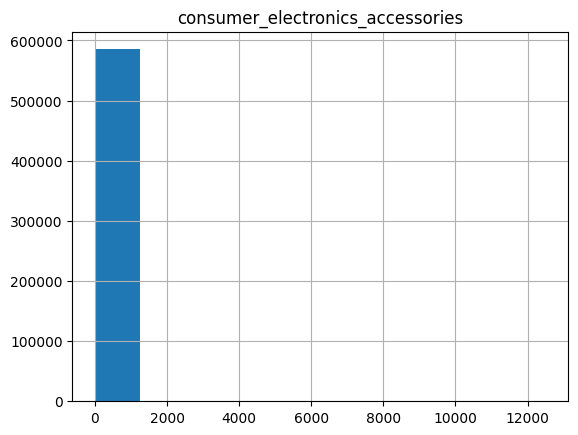

<Figure size 640x480 with 0 Axes>

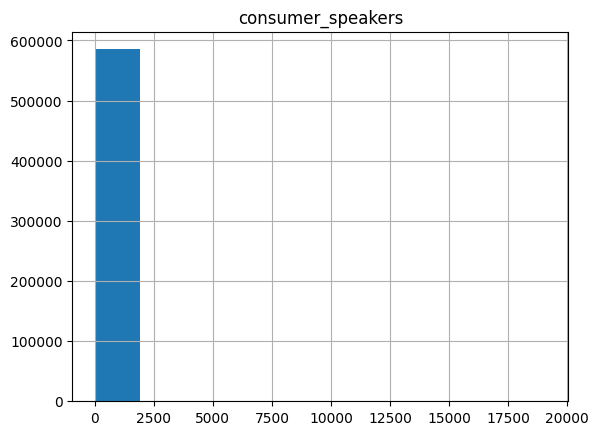

<Figure size 640x480 with 0 Axes>

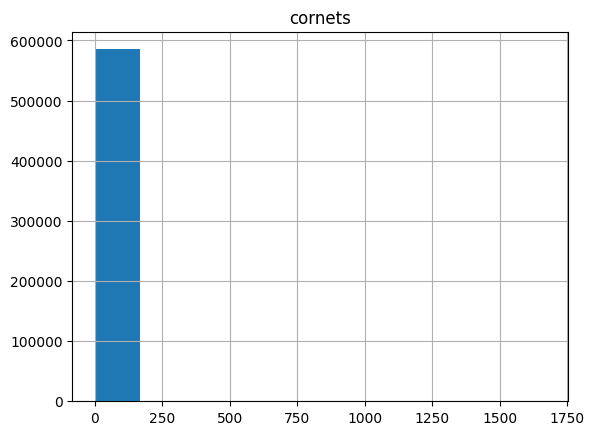

<Figure size 640x480 with 0 Axes>

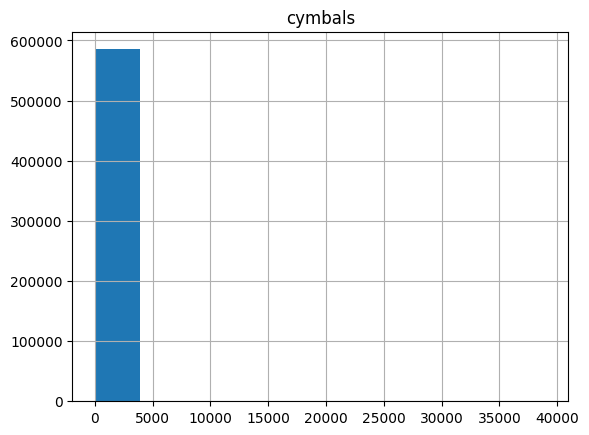

<Figure size 640x480 with 0 Axes>

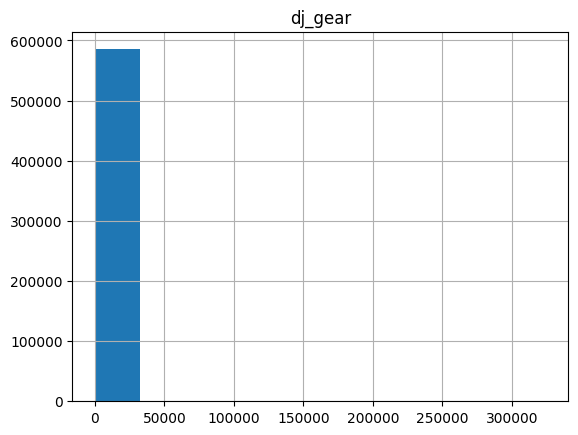

<Figure size 640x480 with 0 Axes>

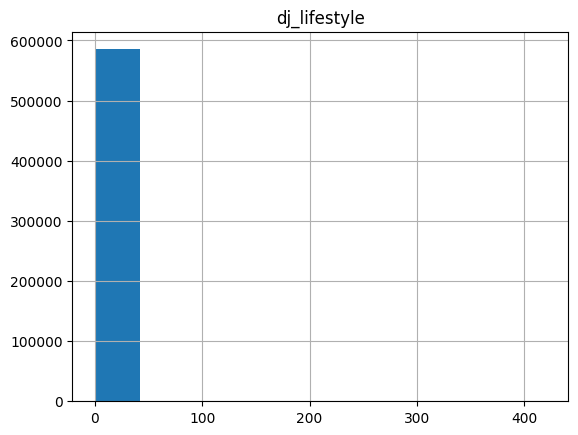

<Figure size 640x480 with 0 Axes>

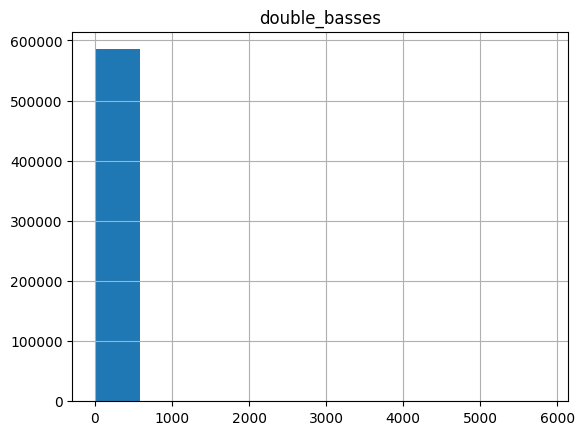

<Figure size 640x480 with 0 Axes>

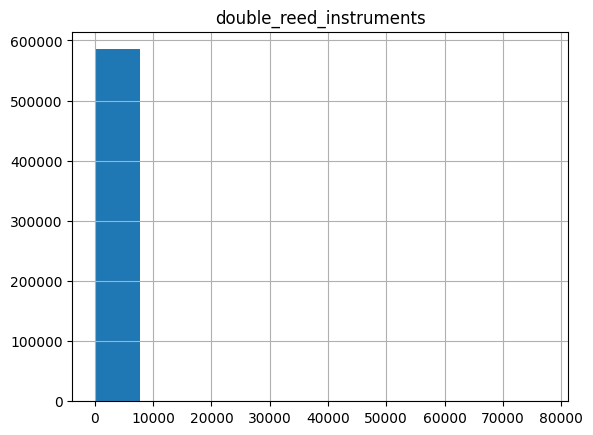

<Figure size 640x480 with 0 Axes>

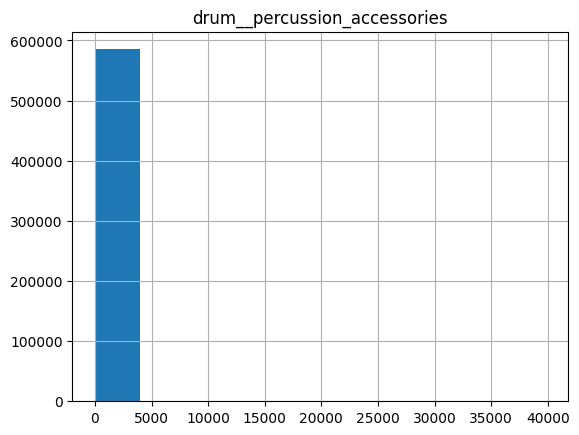

<Figure size 640x480 with 0 Axes>

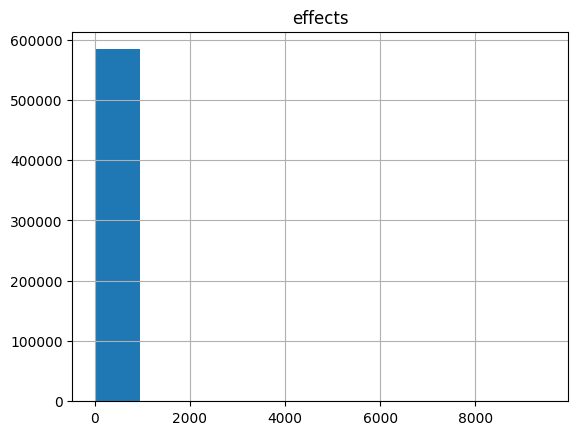

<Figure size 640x480 with 0 Axes>

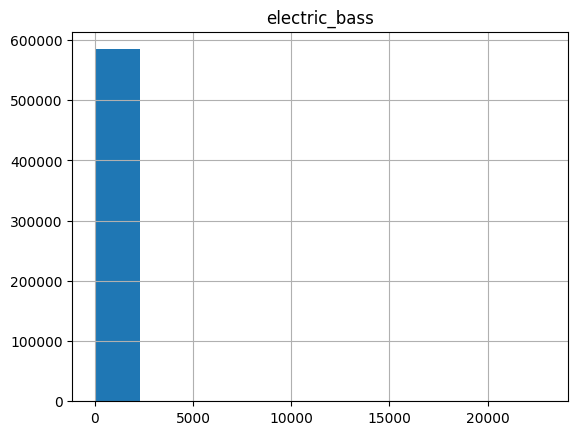

<Figure size 640x480 with 0 Axes>

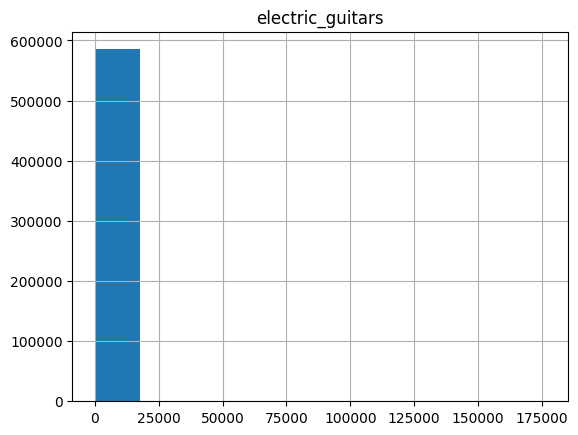

<Figure size 640x480 with 0 Axes>

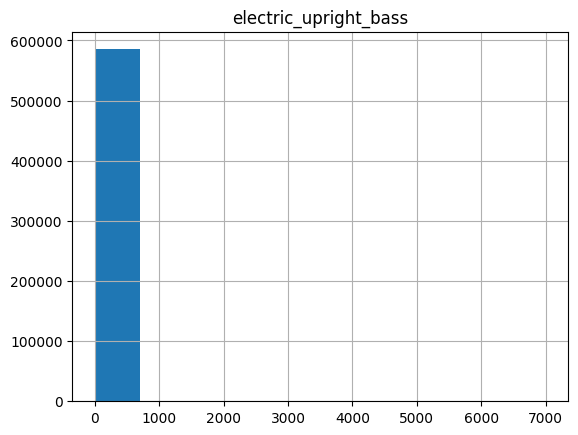

<Figure size 640x480 with 0 Axes>

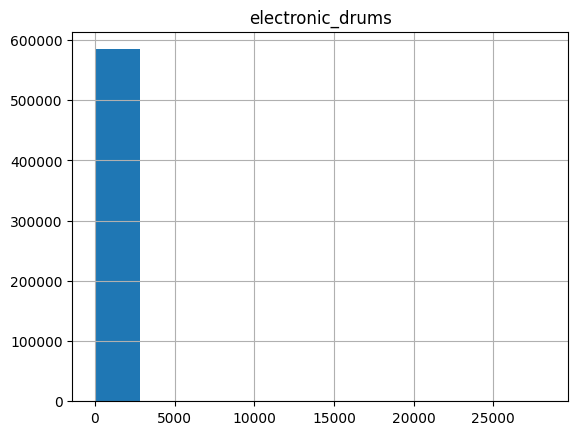

<Figure size 640x480 with 0 Axes>

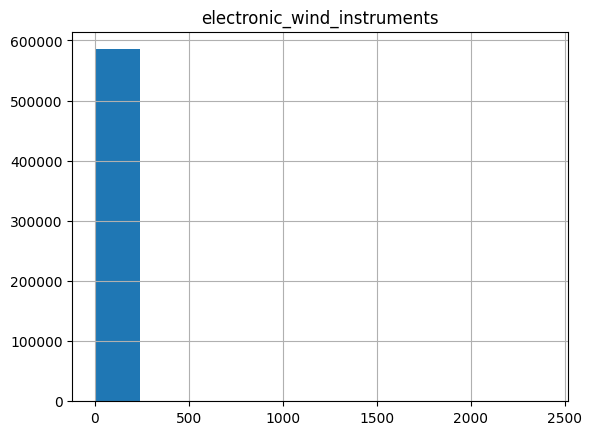

<Figure size 640x480 with 0 Axes>

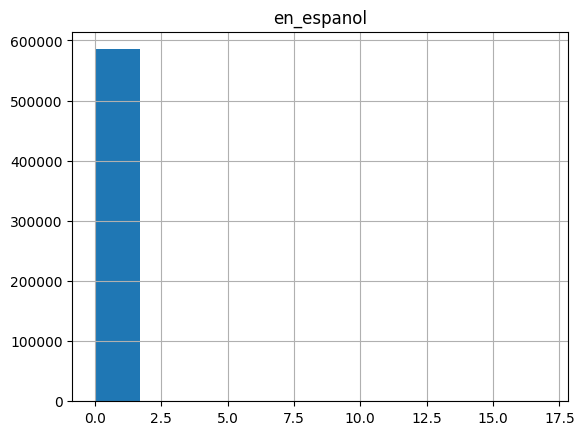

<Figure size 640x480 with 0 Axes>

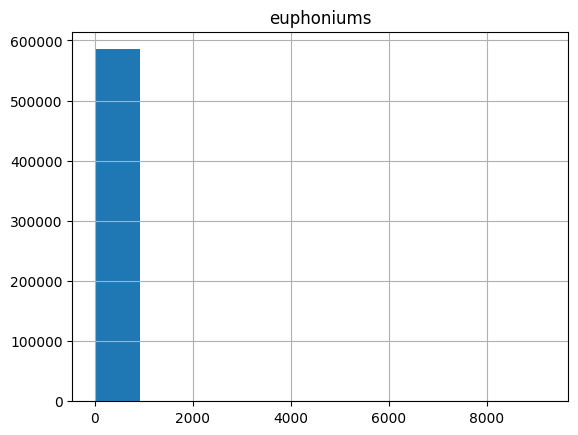

<Figure size 640x480 with 0 Axes>

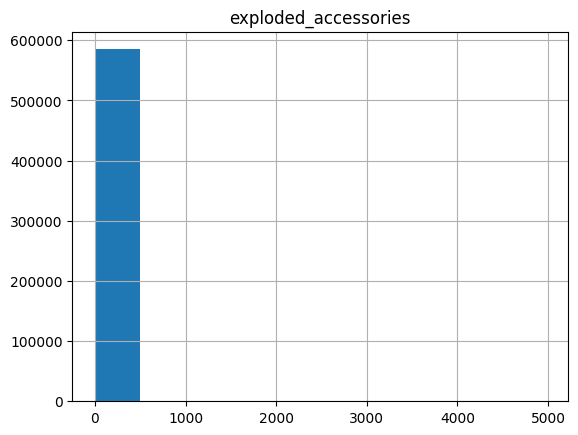

<Figure size 640x480 with 0 Axes>

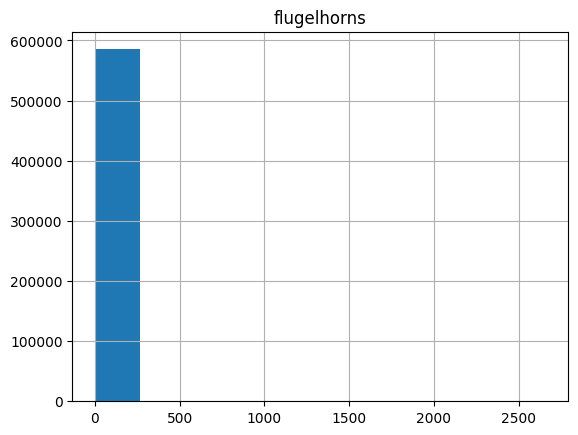

<Figure size 640x480 with 0 Axes>

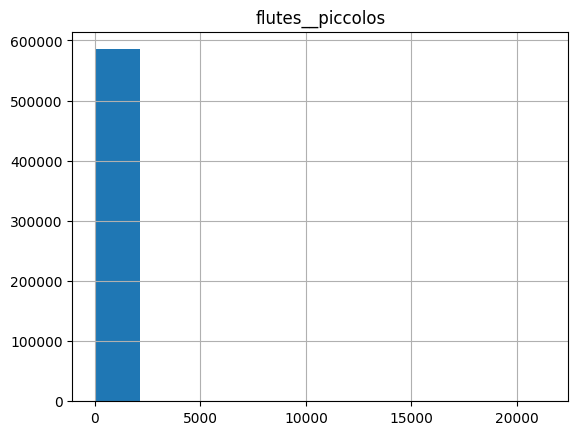

<Figure size 640x480 with 0 Axes>

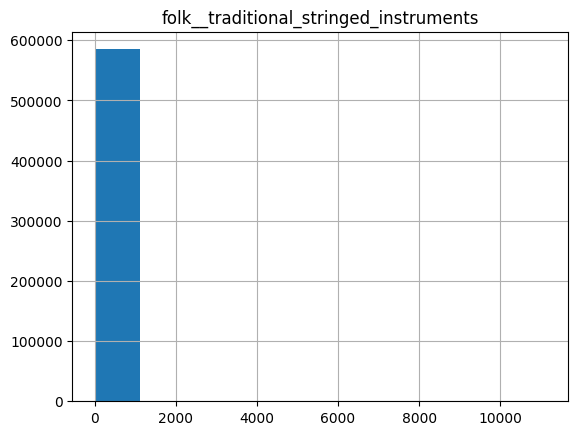

<Figure size 640x480 with 0 Axes>

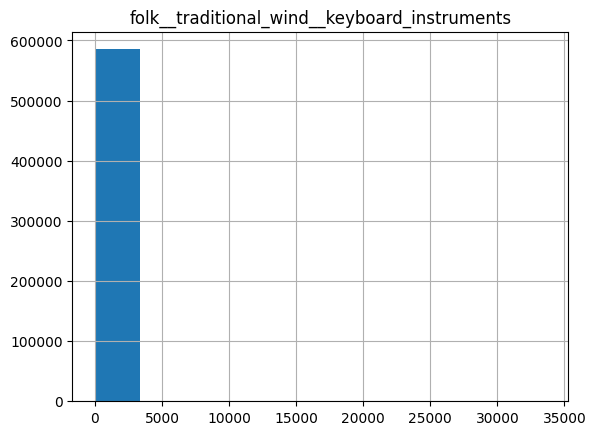

<Figure size 640x480 with 0 Axes>

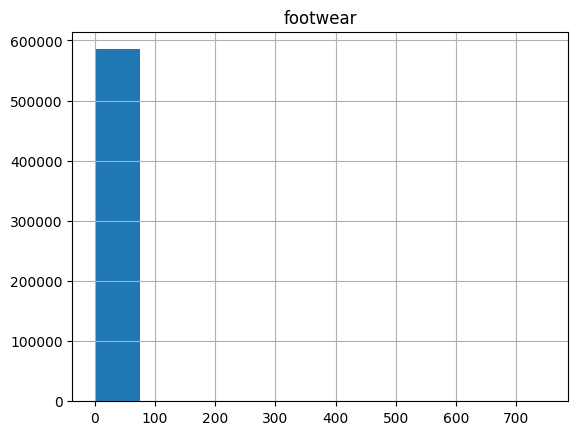

<Figure size 640x480 with 0 Axes>

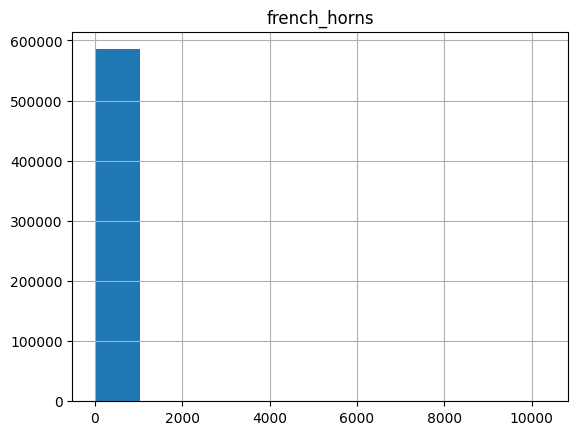

<Figure size 640x480 with 0 Axes>

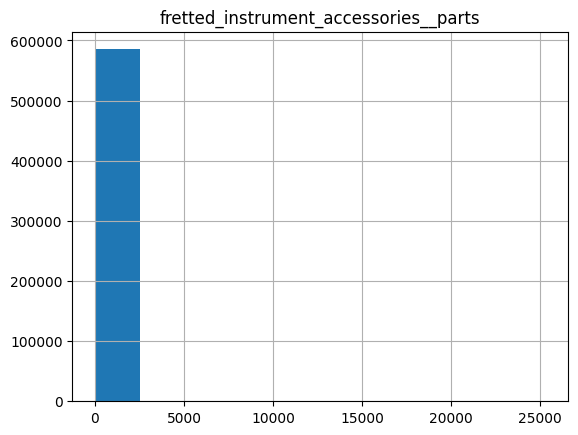

<Figure size 640x480 with 0 Axes>

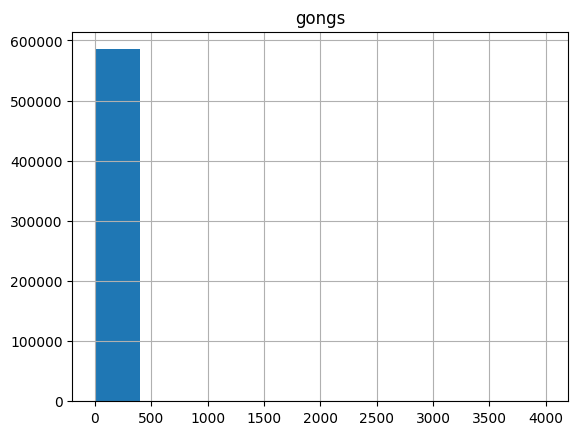

<Figure size 640x480 with 0 Axes>

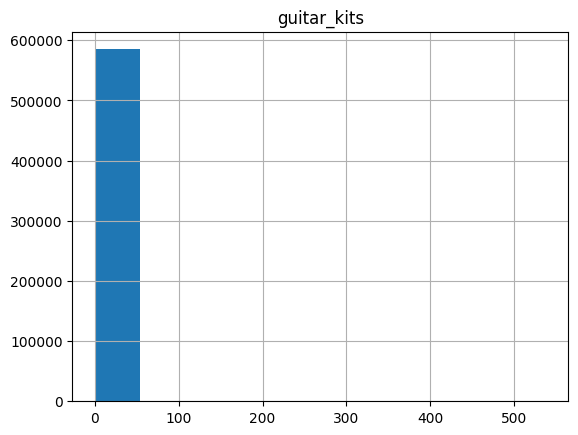

<Figure size 640x480 with 0 Axes>

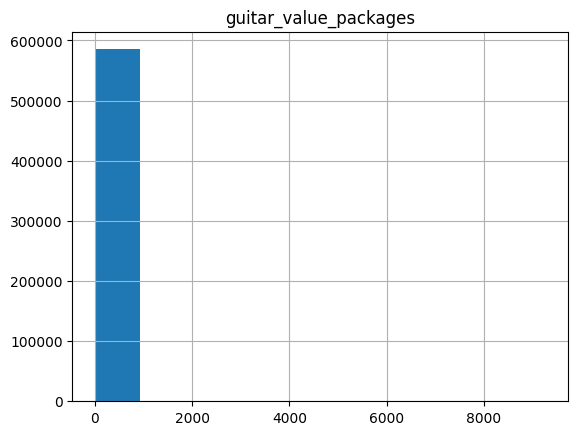

<Figure size 640x480 with 0 Axes>

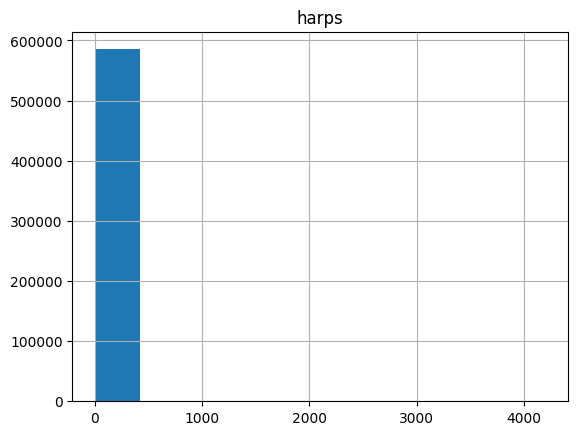

<Figure size 640x480 with 0 Axes>

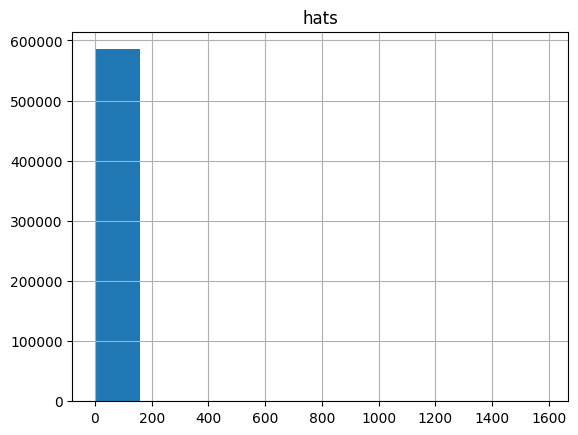

<Figure size 640x480 with 0 Axes>

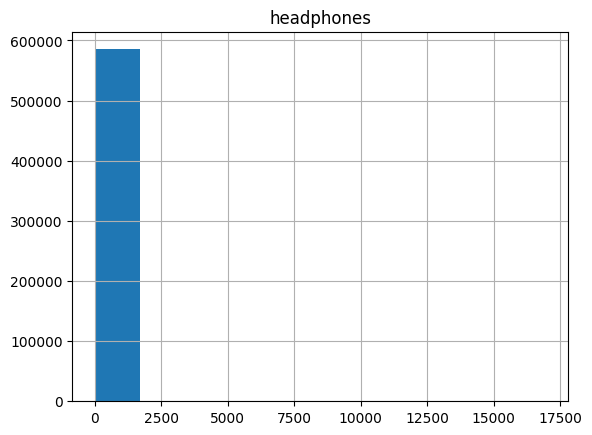

<Figure size 640x480 with 0 Axes>

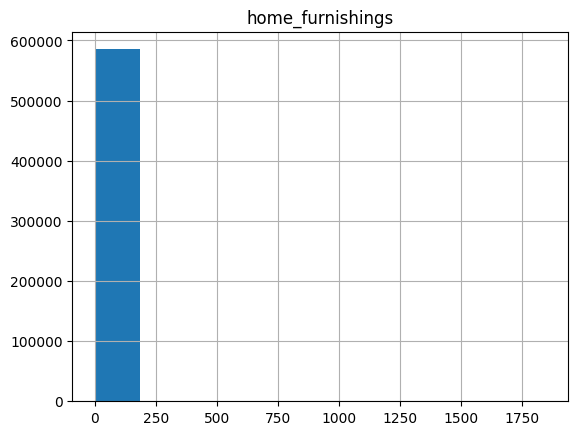

<Figure size 640x480 with 0 Axes>

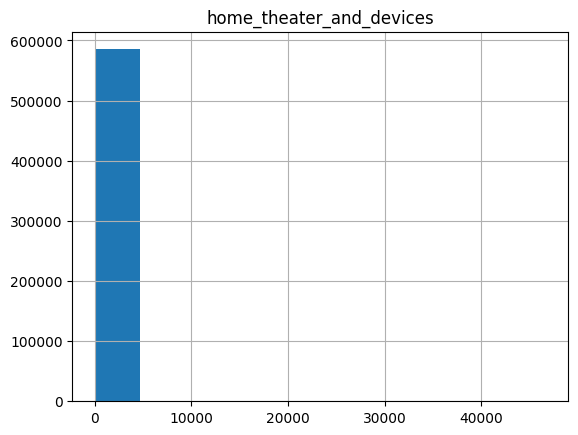

<Figure size 640x480 with 0 Axes>

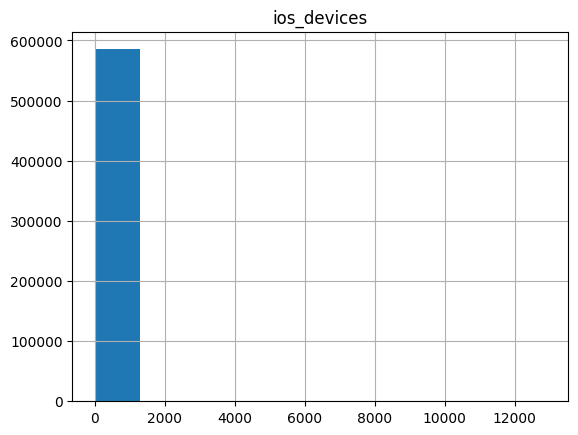

<Figure size 640x480 with 0 Axes>

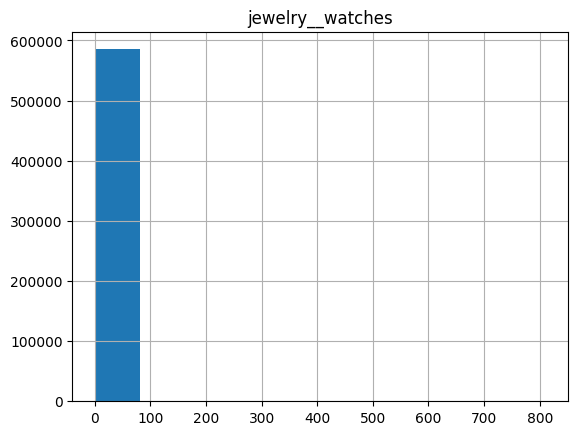

<Figure size 640x480 with 0 Axes>

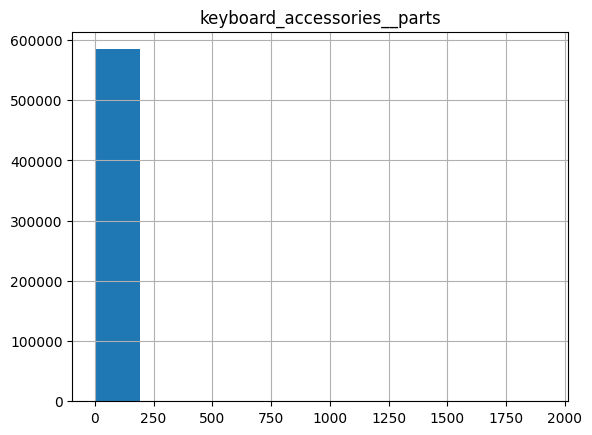

<Figure size 640x480 with 0 Axes>

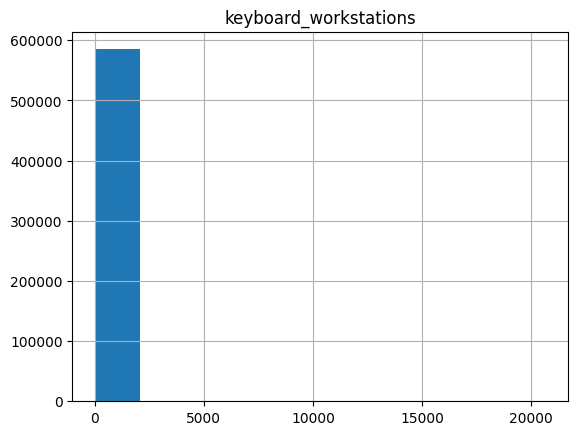

<Figure size 640x480 with 0 Axes>

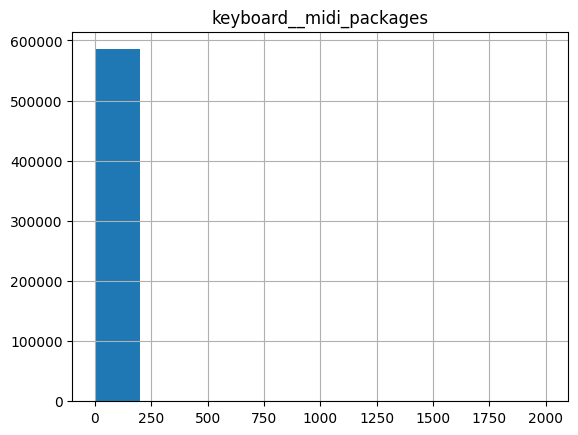

<Figure size 640x480 with 0 Axes>

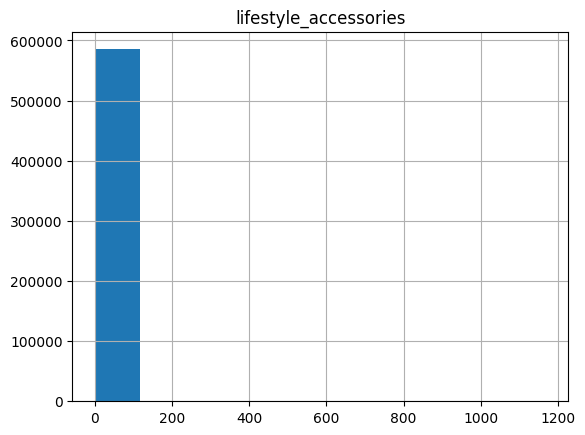

<Figure size 640x480 with 0 Axes>

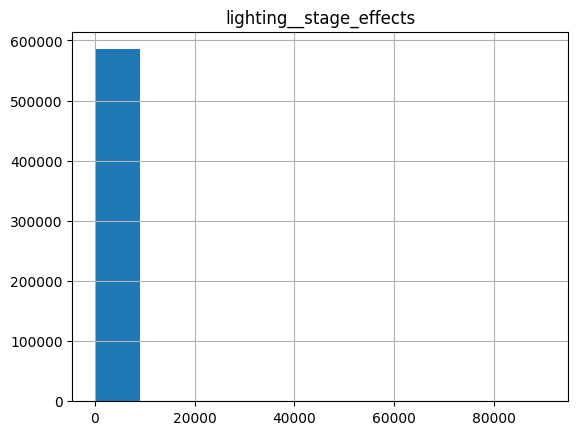

<Figure size 640x480 with 0 Axes>

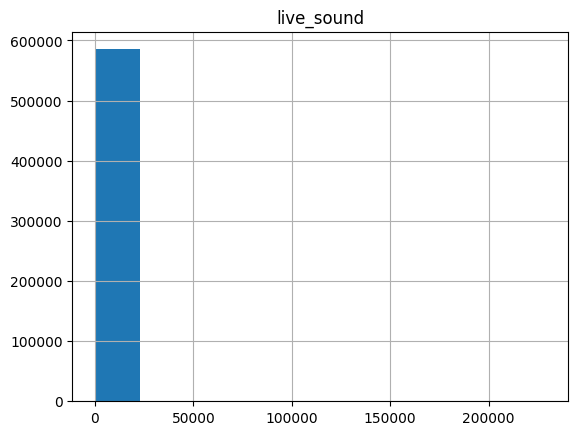

<Figure size 640x480 with 0 Axes>

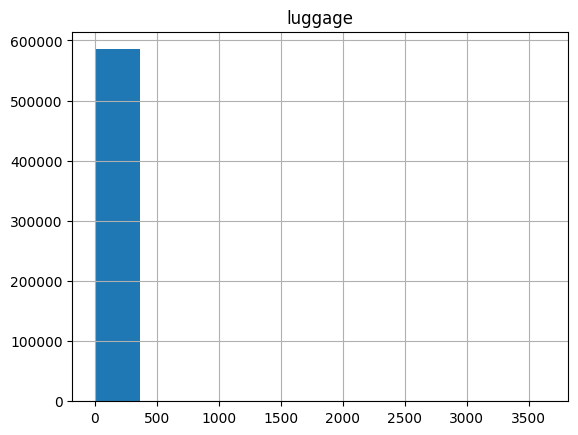

<Figure size 640x480 with 0 Axes>

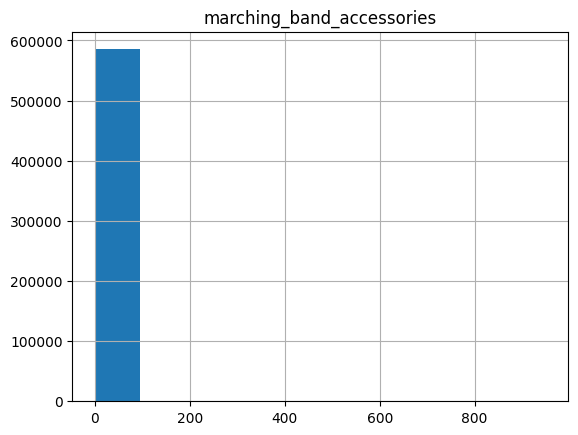

<Figure size 640x480 with 0 Axes>

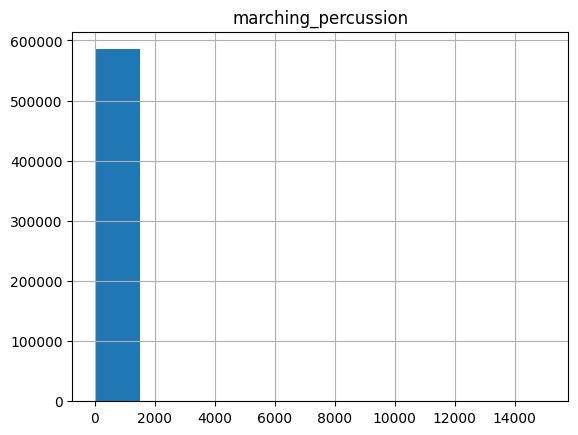

<Figure size 640x480 with 0 Axes>

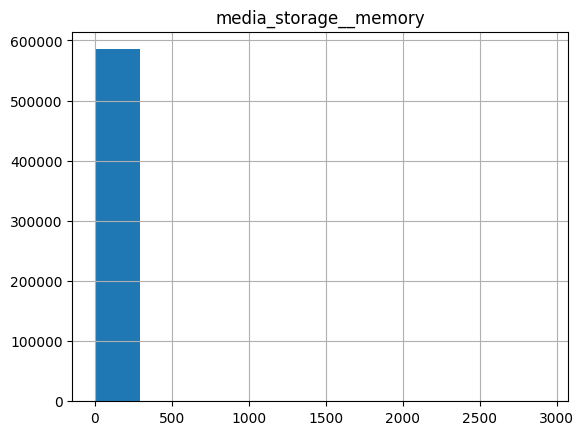

<Figure size 640x480 with 0 Axes>

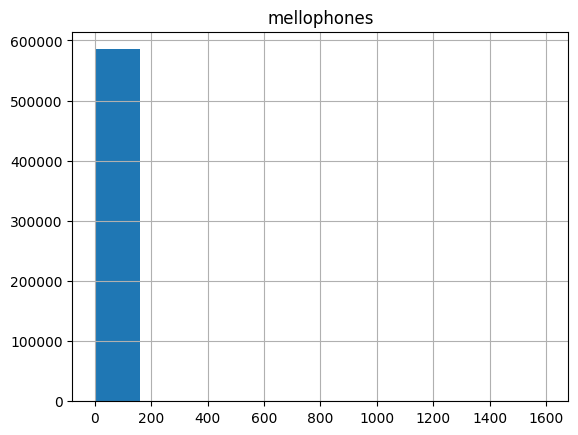

<Figure size 640x480 with 0 Axes>

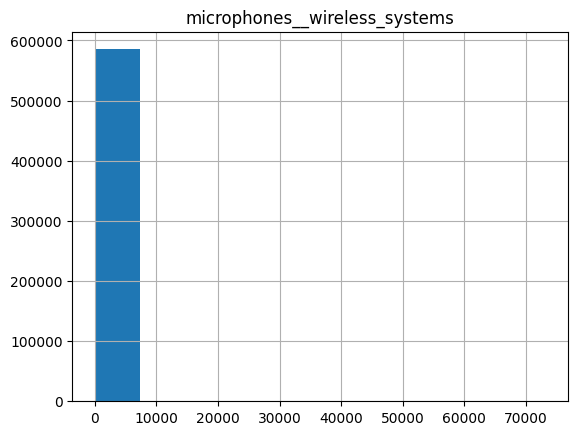

<Figure size 640x480 with 0 Axes>

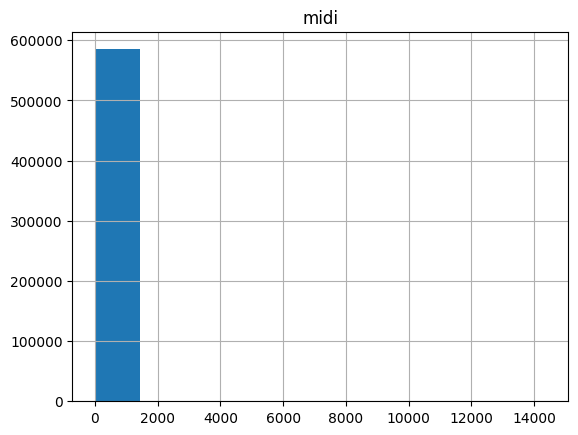

<Figure size 640x480 with 0 Axes>

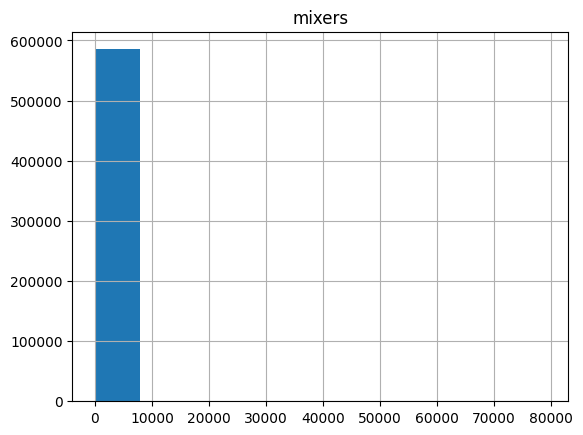

<Figure size 640x480 with 0 Axes>

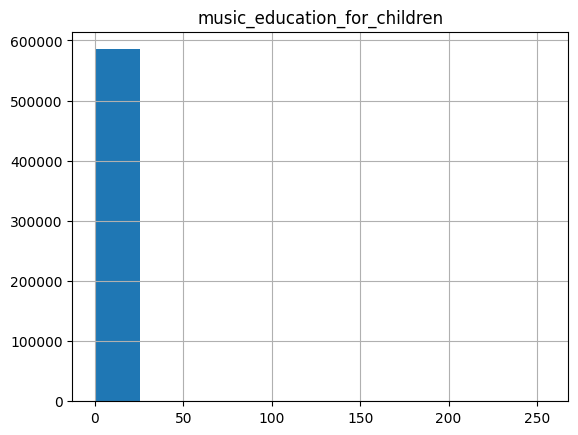

<Figure size 640x480 with 0 Axes>

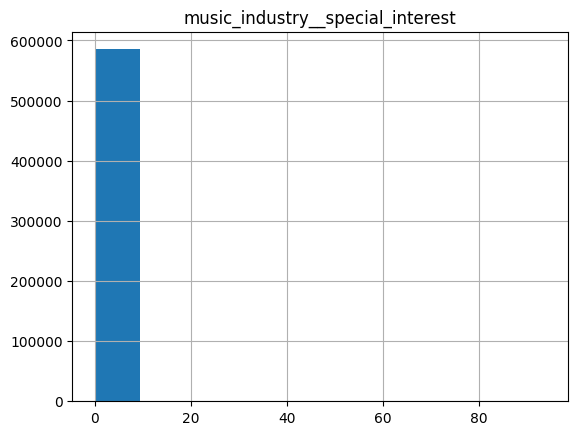

<Figure size 640x480 with 0 Axes>

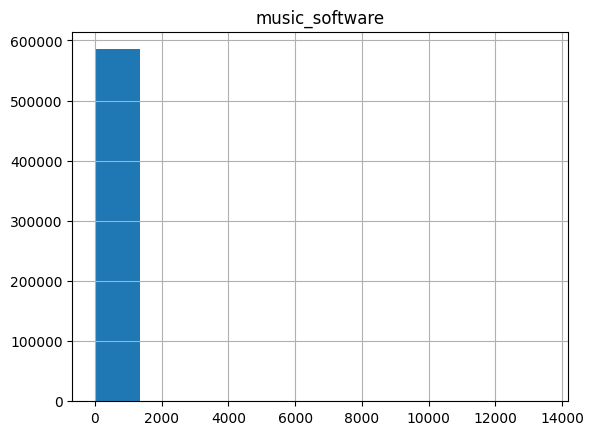

<Figure size 640x480 with 0 Axes>

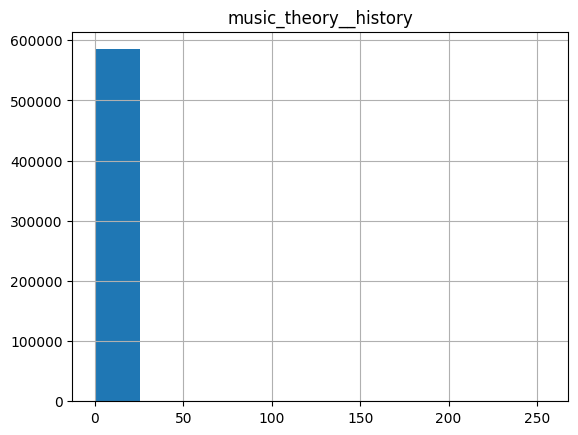

<Figure size 640x480 with 0 Axes>

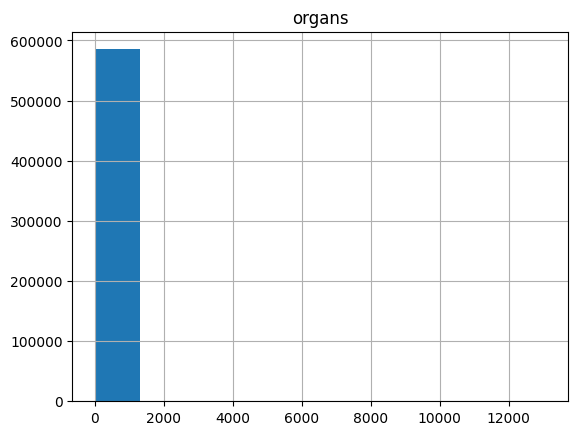

<Figure size 640x480 with 0 Axes>

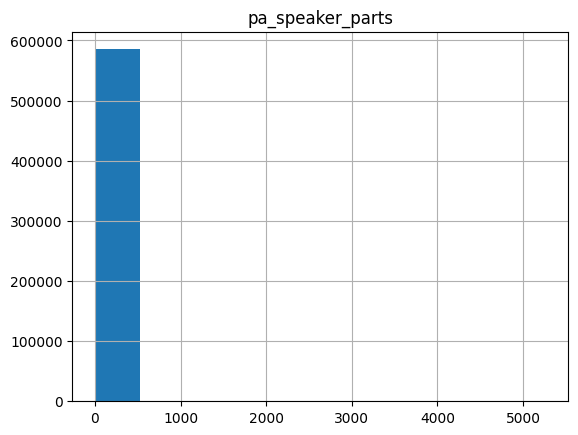

<Figure size 640x480 with 0 Axes>

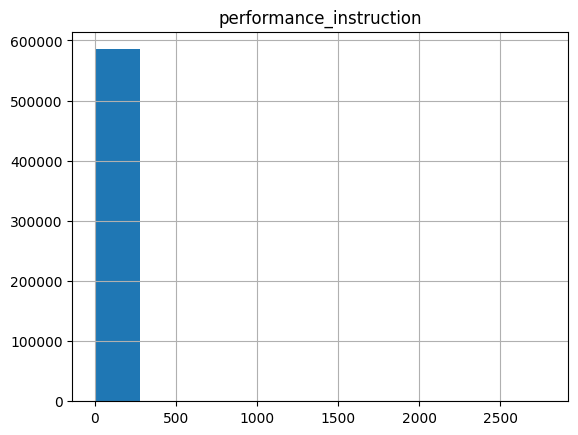

<Figure size 640x480 with 0 Axes>

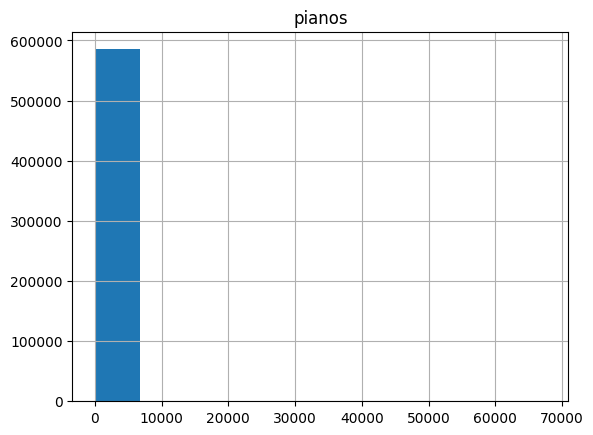

<Figure size 640x480 with 0 Axes>

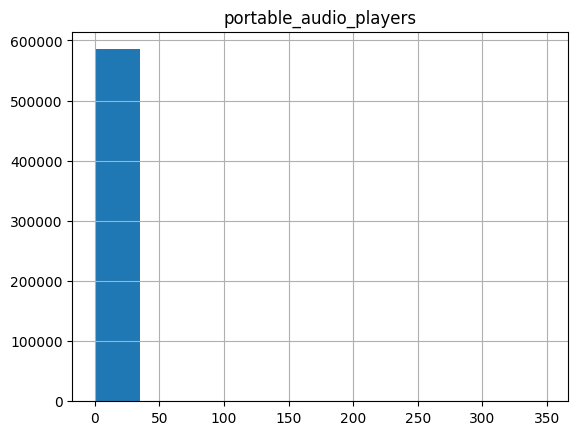

<Figure size 640x480 with 0 Axes>

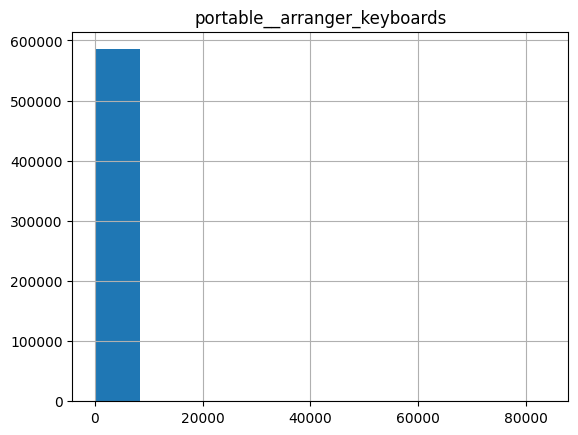

<Figure size 640x480 with 0 Axes>

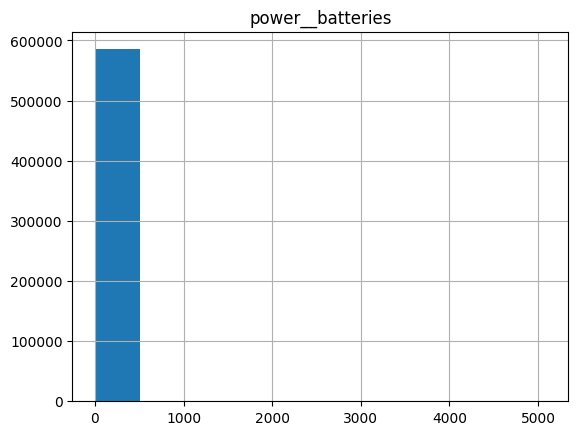

<Figure size 640x480 with 0 Axes>

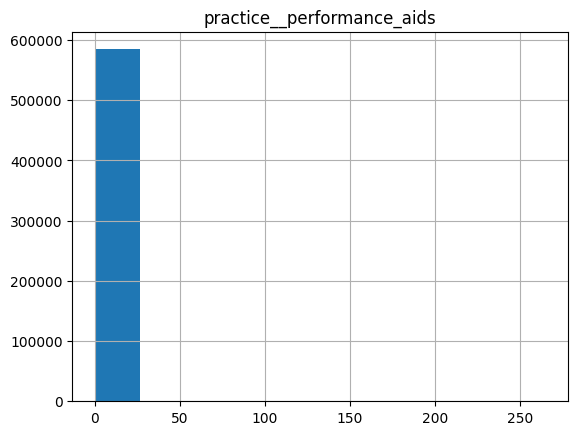

<Figure size 640x480 with 0 Axes>

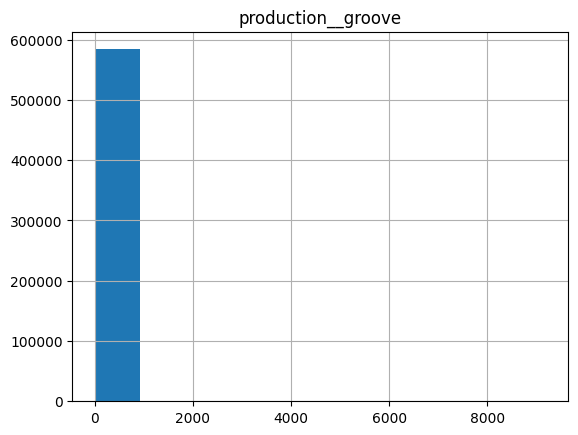

<Figure size 640x480 with 0 Axes>

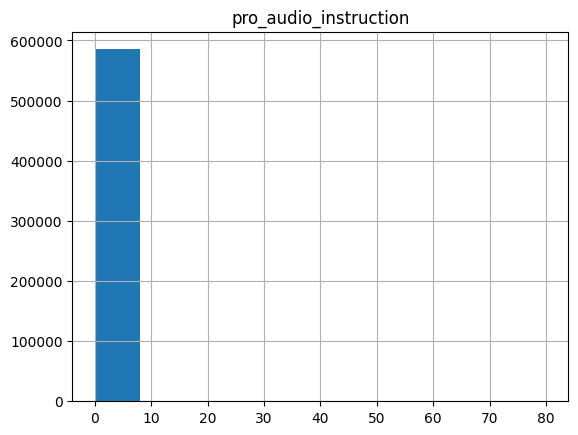

<Figure size 640x480 with 0 Axes>

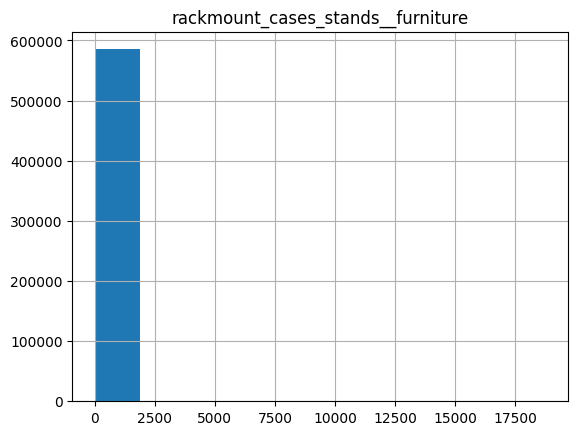

<Figure size 640x480 with 0 Axes>

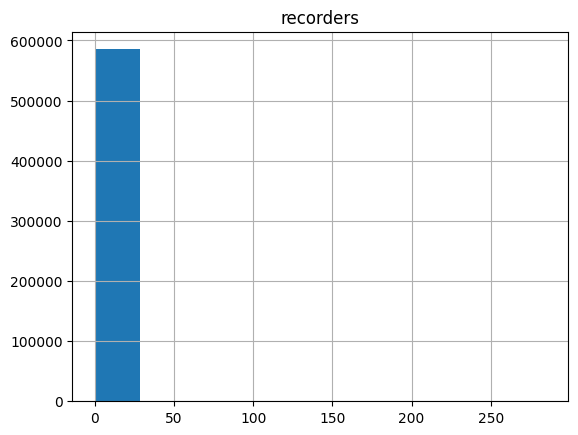

<Figure size 640x480 with 0 Axes>

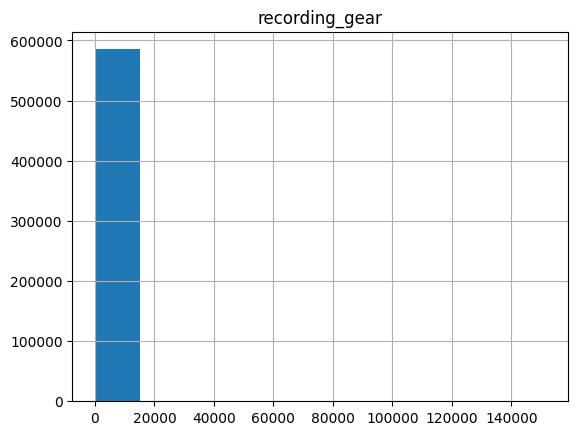

<Figure size 640x480 with 0 Axes>

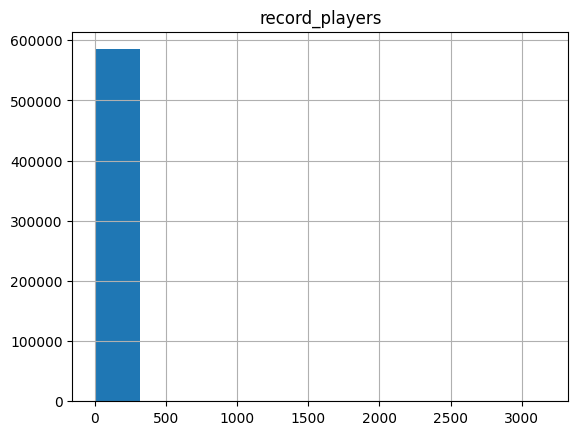

<Figure size 640x480 with 0 Axes>

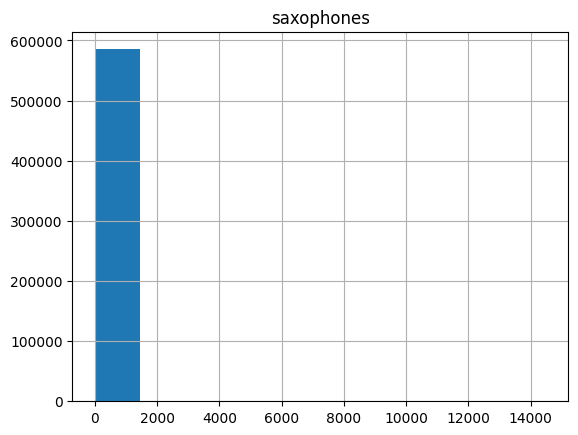

<Figure size 640x480 with 0 Axes>

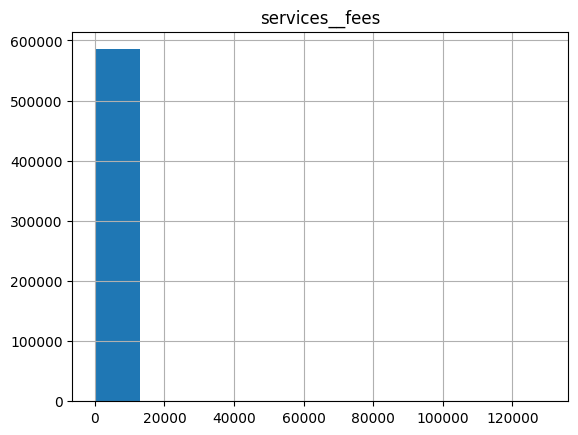

<Figure size 640x480 with 0 Axes>

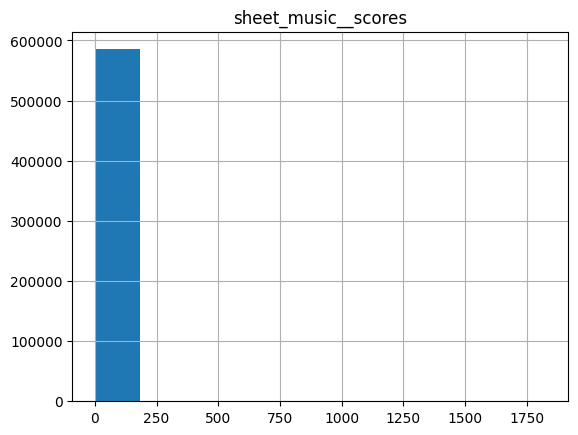

<Figure size 640x480 with 0 Axes>

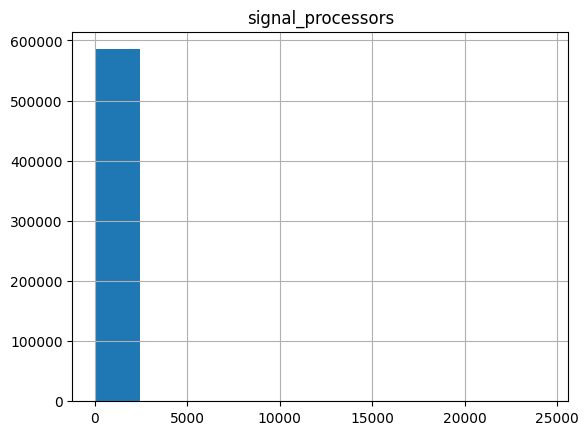

<Figure size 640x480 with 0 Axes>

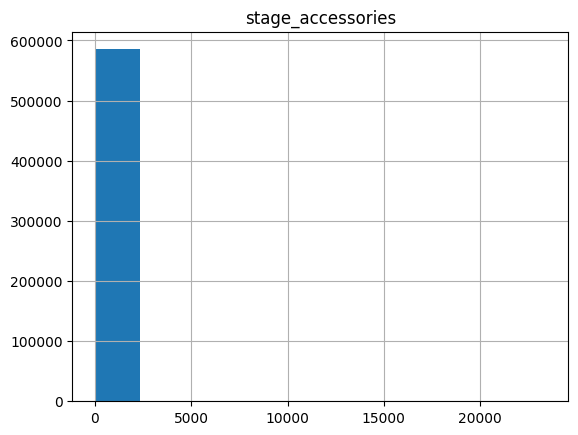

<Figure size 640x480 with 0 Axes>

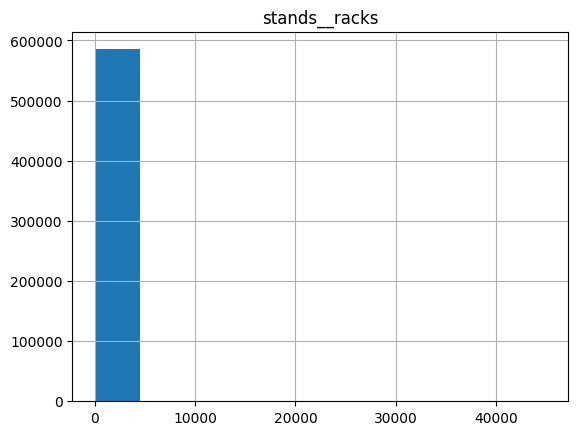

<Figure size 640x480 with 0 Axes>

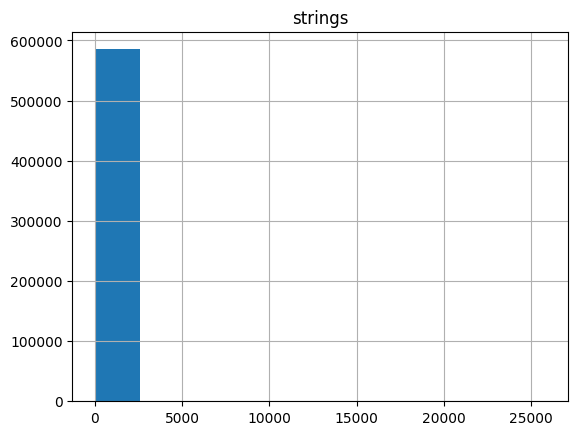

<Figure size 640x480 with 0 Axes>

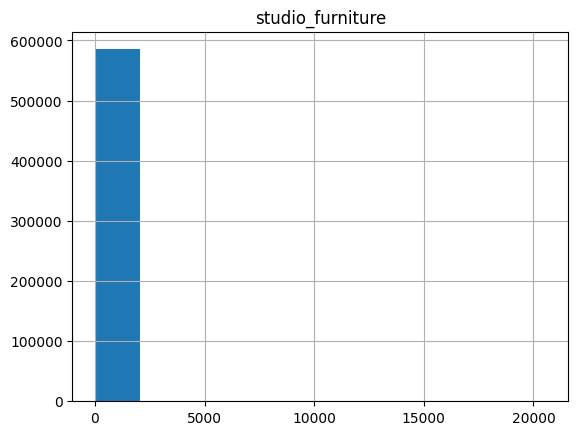

<Figure size 640x480 with 0 Axes>

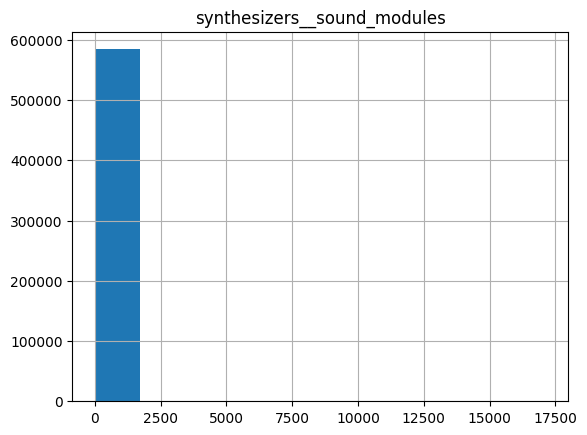

<Figure size 640x480 with 0 Axes>

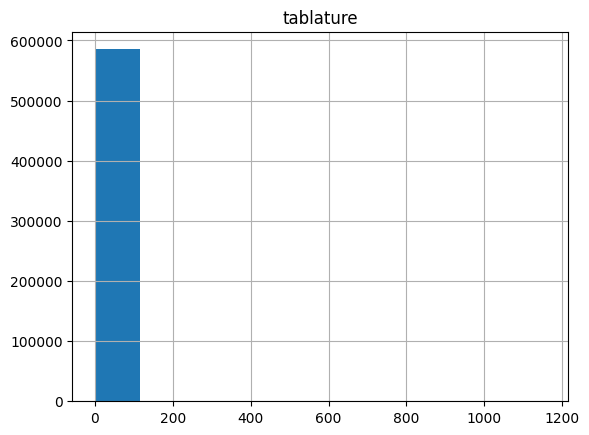

<Figure size 640x480 with 0 Axes>

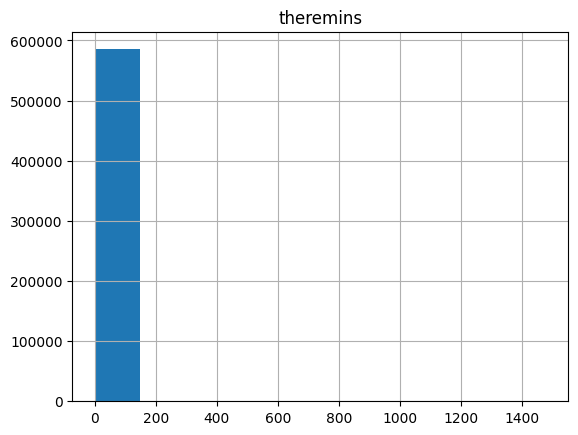

<Figure size 640x480 with 0 Axes>

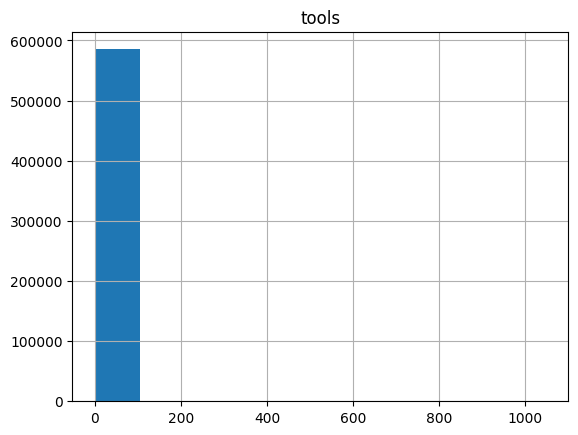

<Figure size 640x480 with 0 Axes>

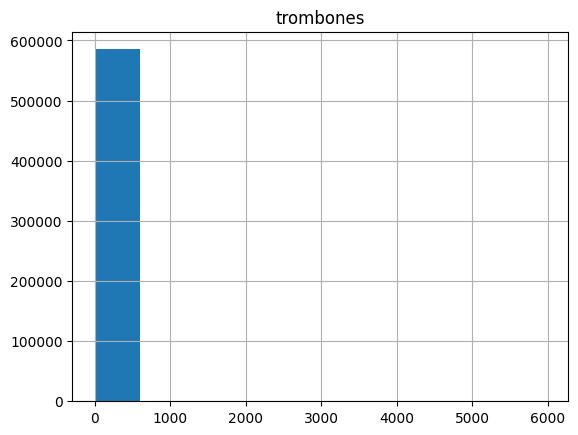

<Figure size 640x480 with 0 Axes>

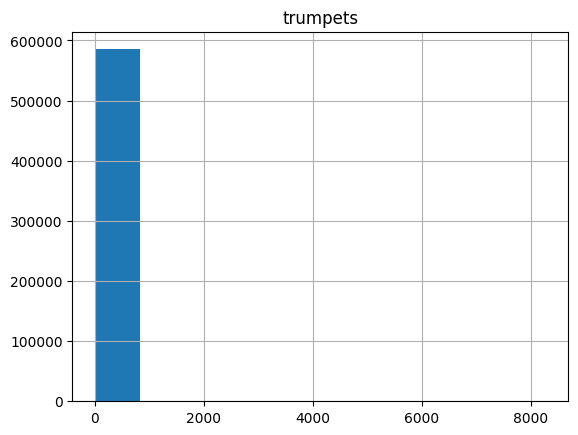

<Figure size 640x480 with 0 Axes>

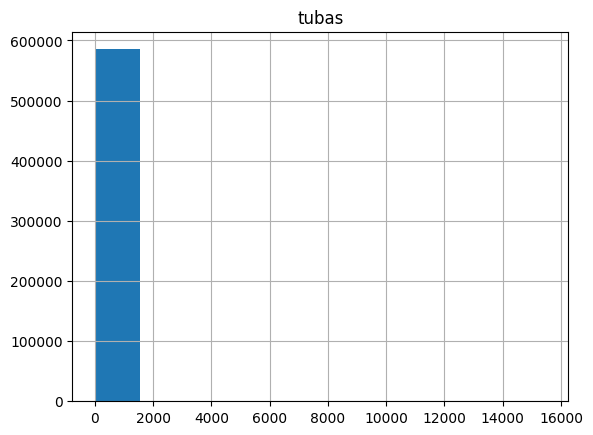

<Figure size 640x480 with 0 Axes>

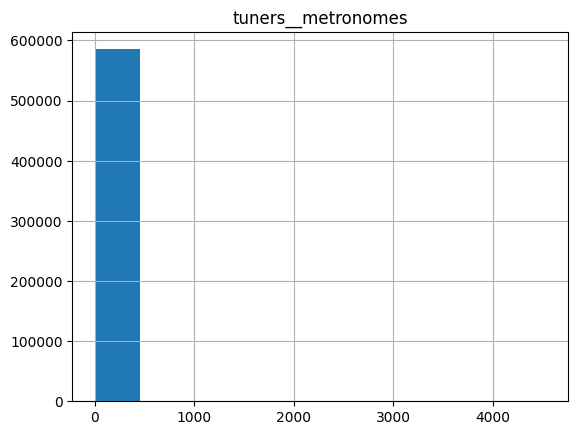

<Figure size 640x480 with 0 Axes>

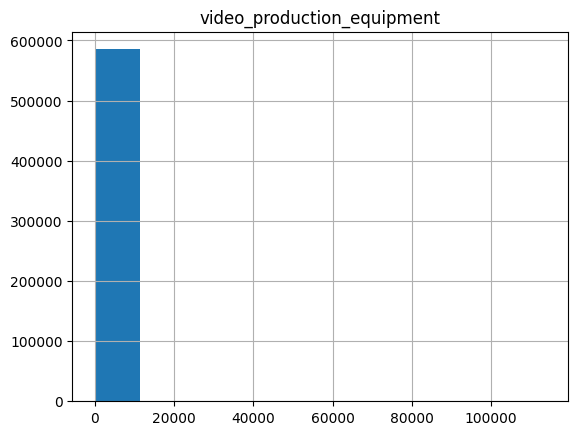

<Figure size 640x480 with 0 Axes>

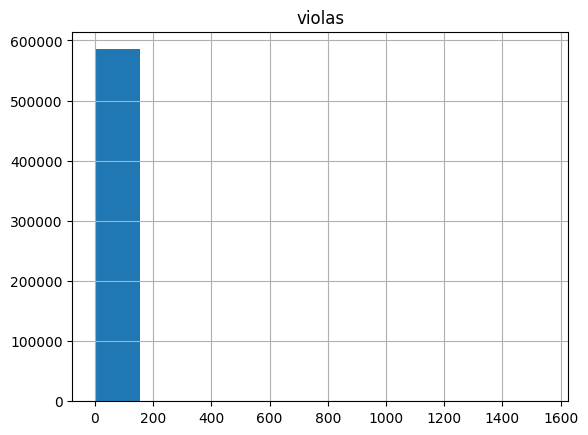

<Figure size 640x480 with 0 Axes>

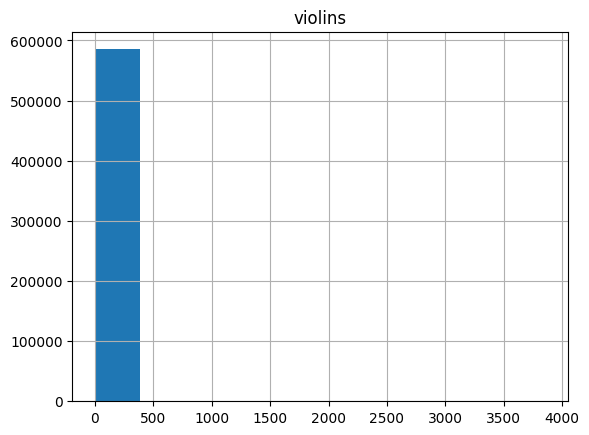

<Figure size 640x480 with 0 Axes>

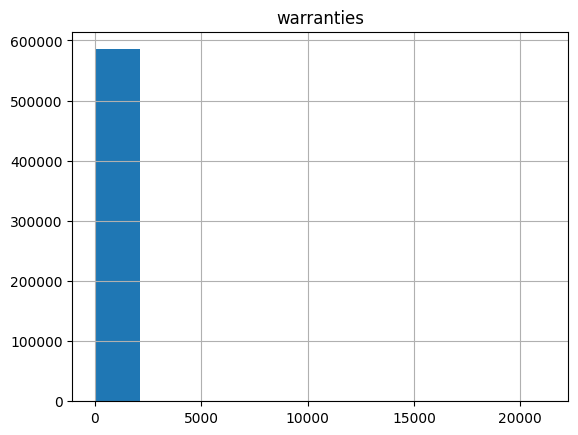

<Figure size 640x480 with 0 Axes>

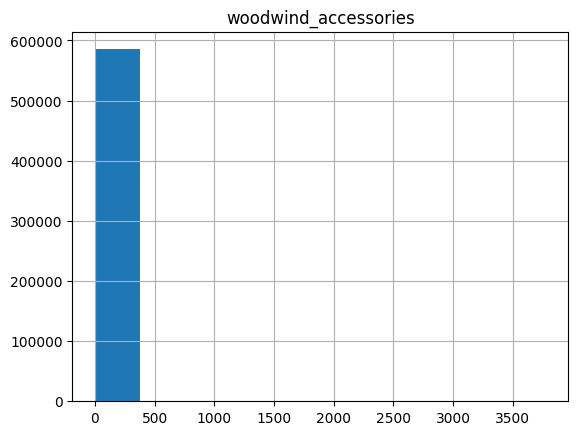

<Figure size 640x480 with 0 Axes>

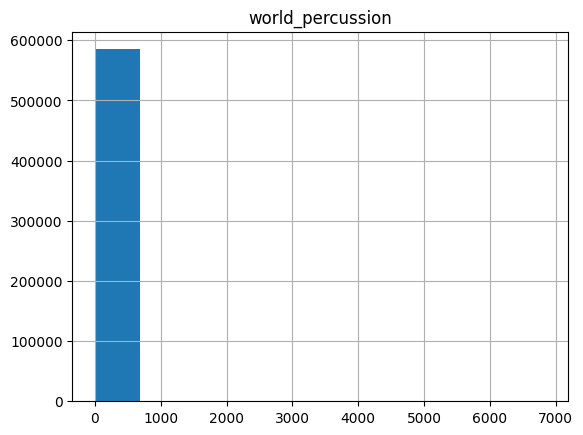

In [ ]:
# look for columns distribution
for column in df_numerical.columns:
    plt.figure()
    pdf.hist([column])

## Data Preparation

#### Log Transformation

In [ ]:
temp=pdf[df_numerical.columns]

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585368 entries, 0 to 585367
Columns: 119 entries, accessories_for_brass_instruments to world_percussion
dtypes: float64(117), int32(2)
memory usage: 527.0 MB


In [ ]:
temp.head(1)

accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                0.0                                 0.0   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            0.0             0.0                        0.0               0.0   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                0.0         0.0              0.0             0.0   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0             0.0     0.0           51.94             0.0   

   cases_gig_bags__covers  cds__vinyl  cellos  clarinets  \
0                     0.0         0.0     0.0        0.0   

   classical__nylon_guitars  classroom_aids  classroom_furniture  \
0                     479.0             0.0                  0.0   

   classroom_musical_instruments  clothing  collectibles  \
0                            0.0       0.0           0.0   

   computers__peripherals  concert_cymbals  concert_drums  \
0                     0.0              0.0            0.0   

   concert_hand__mounted_percussion  concert_mallet_percussion  \
0                               0.0                        0.0   

   connected_home  consumer_electronics_accessories  consumer_speakers  \
0             0.0                               0.0                0.0   

   cornets  cymbals  dj_gear  dj_lifestyle  double_basses  \
0      0.0      0.0      0.0           0.0            0.0   

   double_reed_instruments  drum__percussion_accessories  effects  \
0                      0.0                           0.0      0.0   

   electric_bass  electric_guitars  electric_upright_bass  electronic_drums  \
0         249.99            169.99                    0.0               0.0   

   electronic_wind_instruments  en_espanol  euphoniums  exploded_accessories  \
0                          0.0         0.0         0.0                   0.0   

   flugelhorns  flutes__piccolos  folk__traditional_stringed_instruments  \
0          0.0               0.0                                     0.0   

   folk__traditional_wind__keyboard_instruments  footwear  french_horns  \
0                                           0.0       0.0           0.0   

   fretted_instrument_accessories__parts  gongs  guitar_kits  \
0                                  39.98    0.0          0.0   

   guitar_value_packages  harps  hats  headphones  home_furnishings  \
0                    0.0    0.0   0.0         0.0               0.0   

   home_theater_and_devices  ios_devices  jewelry__watches  \
0                       0.0          0.0               0.0   

   keyboard_accessories__parts  keyboard_workstations  \
0                        17.99                    0.0   

   keyboard__midi_packages  lifestyle_accessories  lighting__stage_effects  \
0                      0.0                    0.0                      0.0   

   live_sound  luggage  marching_band_accessories  marching_percussion  \
0         0.0      0.0                        0.0                  0.0   

   media_storage__memory  mellophones  microphones__wireless_systems   midi  \
0                    0.0            0                           8.99  119.0   

   mixers  music_education_for_children  music_industry__special_interest  \
0     0.0                           0.0                               0.0   

   music_software  music_theory__history  organs  pa_speaker_parts  \
0             0.0                    0.0     0.0               0.0   

   performance_instruction  pianos  portable_audio_players  \
0                     9.99     0.0                       0   

   portable__arranger_keyboards  power__batteries  practice__performance_aids  \
0                           0.0               0.0                         0.0   

   production__groove  pro_audio_instruction  \
0                 0.0                    0.0   

   rackmount_cases_stands__furniture  recorders  recording_gear  \
0                             

In [ ]:
# Apply logarithmic transformation to cash column
# Filter out negative or zero values
# added 1 to all data records, as log(1) is zero,hence data with zeros won't be affected.
temp=temp+1
temp = temp[temp[temp.columns] > 0]

print(temp.isna().sum())
print(temp.shape)
print(temp.head(1))

accessories_for_brass_instruments     0
accessories_for_orchestral_strings    0
acoustic_bass                         0
acoustic_drums                        0
acoustic_electric_guitars             0
                                     ..
violas                                0
violins                               0
warranties                            0
woodwind_accessories                  0
world_percussion                      0
Length: 119, dtype: int64
(585368, 119)
   accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                1.0                                 1.0   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            1.0             1.0                        1.0               1.0   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                1.0         1.0              1.0             1.0   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0   

In [ ]:

temp= np.log10(temp)
#temp.fillna(0,inplace=True)
#temp = temp.replace(-np.inf, 0)
temp.shape

(585368, 119)

In [ ]:
temp.head(20)

accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                 0.0                                 0.0   
1                                 0.0                                 0.0   
2                                 0.0                                 0.0   
3                                 0.0                                 0.0   
4                                 0.0                                 0.0   
5                                 0.0                                 0.0   
6                                 0.0                                 0.0   
7                                 0.0                                 0.0   
8                                 0.0                                 0.0   
9                                 0.0                                 0.0   
10                                0.0                                 0.0   
11                                0.0                                 0.0   
12                                0.0                                 0.0   
13                                0.0                                 0.0   
14                                0.0                                 0.0   
15                                0.0                                 0.0   
16                                0.0                                 0.0   
17                                0.0                                 0.0   
18                                0.0                                 0.0   
19                                0.0                                 0.0   

    acoustic_bass  acoustic_drums  acoustic_electric_guitars  \
0             0.0        0.000000                        0.0   
1             0.0        0.000000                        0.0   
2             0.0        0.000000                        0.0   
3             0.0        0.000000                        0.0   
4             0.0        0.000000                        0.0   
5             0.0        0.000000                        0.0   
6             0.0        0.000000                        0.0   
7             0.0        0.000000                        0.0   
8             0.0        0.000000                        0.0   
9             0.0        0.000000                        0.0   
10            0.0        0.000000                        0.0   
11            0.0        0.000000                        0.0   
12            0.0        0.000000                        0.0   
13            0.0        0.000000                        0.0   
14            0.0        2.608194                        0.0   
15            0.0        2.845712                        0.0   
16            0.0        0.000000                        0.0   
17            0.0        0.000000                        0.0   
18            0.0        0.000000                        0.0   
19            0.0        0.000000                        0.0   

    acoustic_guitars  alto__tenor_horns  amplifiers  amplifier_parts  \
0           0.000000                0.0         0.0              0.0   
1           0.000000                0.0         0.0              0.0   
2           0.000000                0.0         0.0              0.0   
3           0.000000                0.0         0.0              0.0   
4           0.000000                0.0         0.0              0.0   
5           0.000000                0.0         0.0              0.0   
6           0.000000                0.0         0.0              0.0   
7           0.000000                0.0         0.0              0.0   
8           0.000000                0.0         0.0              0.0   
9           0.000000                0.0         0.0              0.0   
10          0.000000                0.0         0.0              0.0   
11          0.000000                0.0         0.0              0.0   
12          0.000000                0.0         0.0              0.0   
13          0.000000             

<ipython-input-128-9dea2979fe08>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure();


<Figure size 640x480 with 0 Axes>

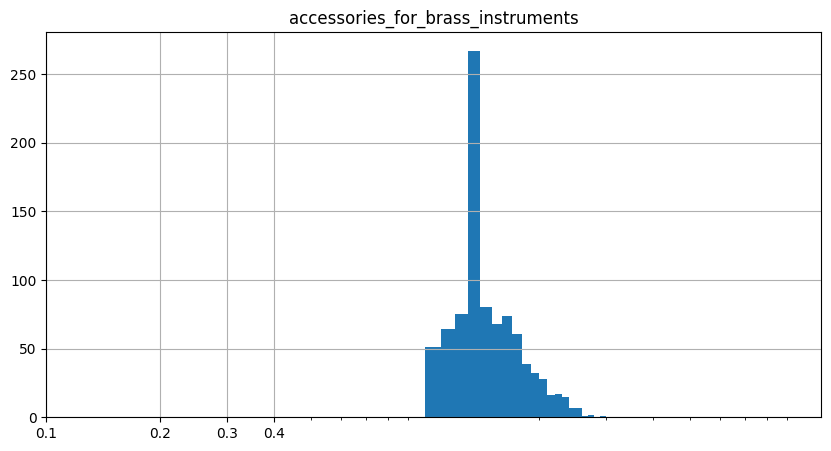

<Figure size 640x480 with 0 Axes>

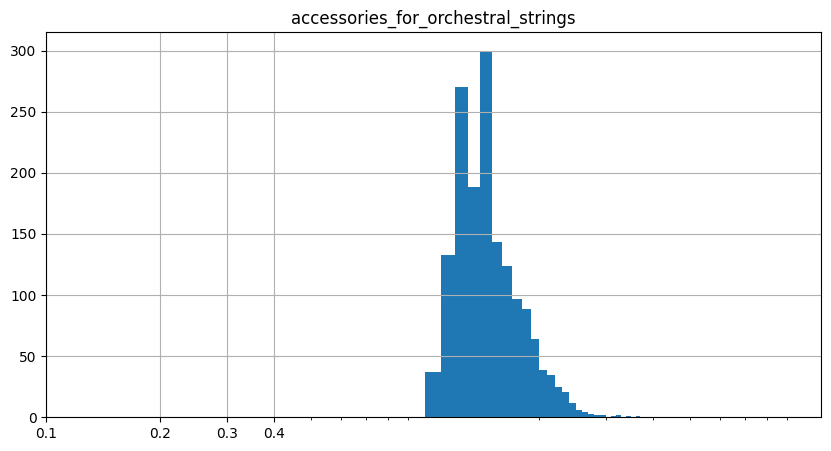

<Figure size 640x480 with 0 Axes>

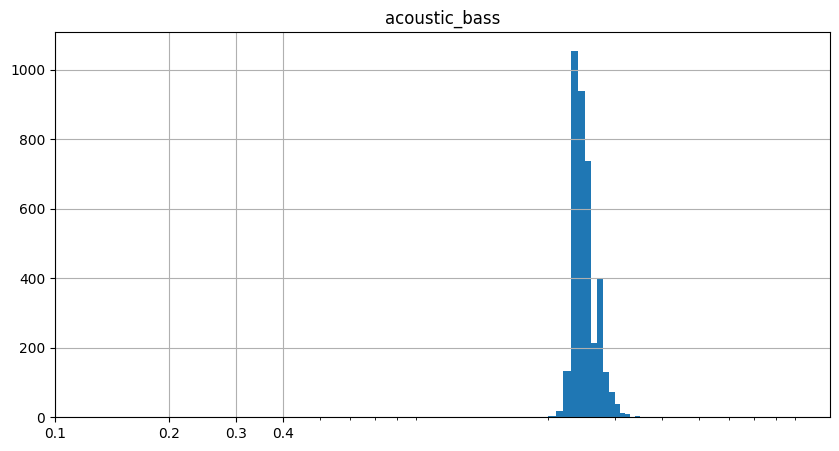

<Figure size 640x480 with 0 Axes>

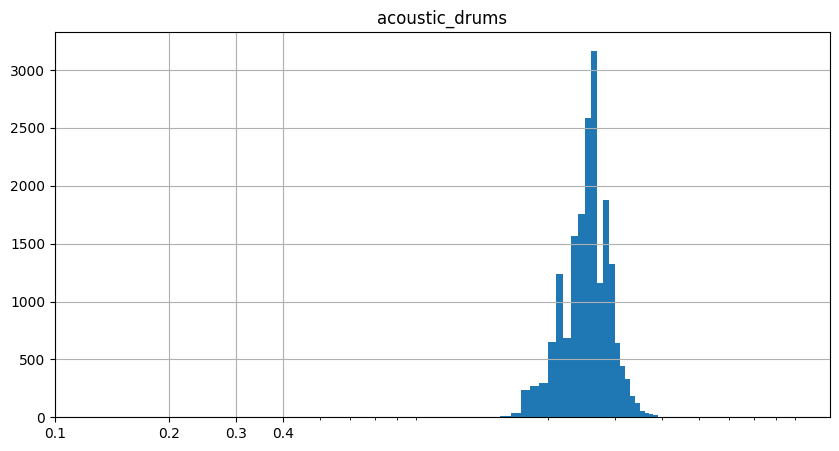

<Figure size 640x480 with 0 Axes>

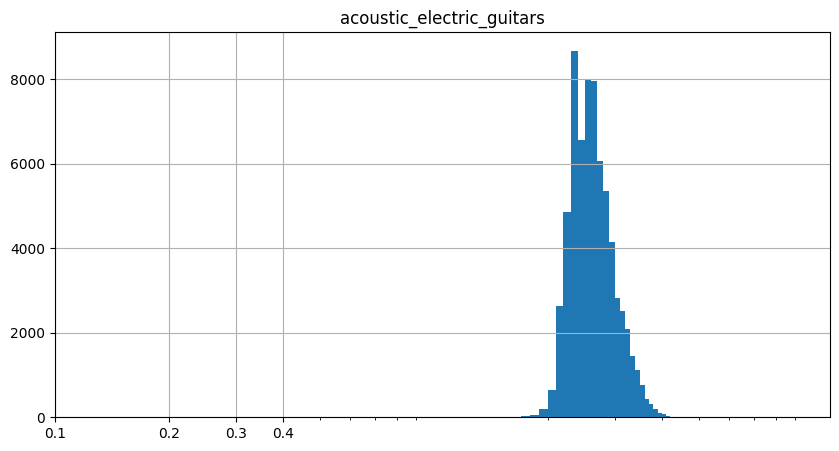

<Figure size 640x480 with 0 Axes>

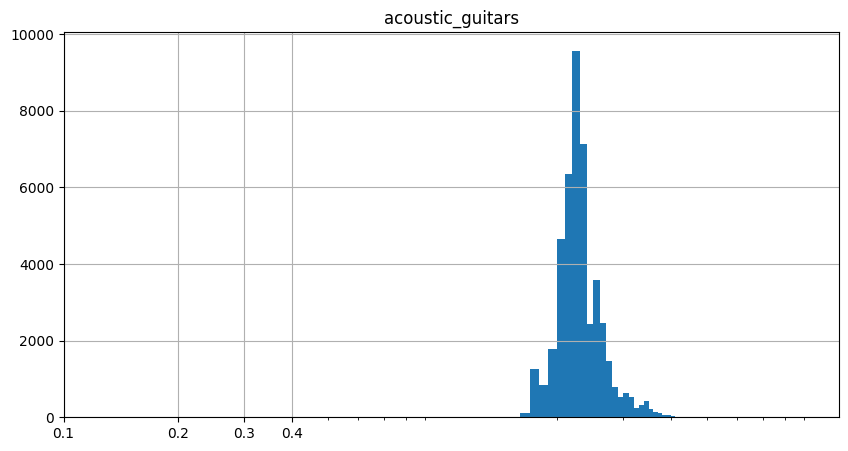

<Figure size 640x480 with 0 Axes>

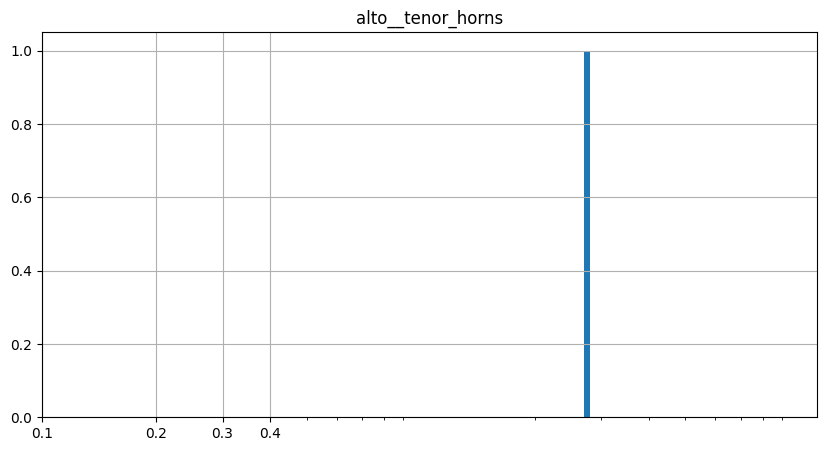

<Figure size 640x480 with 0 Axes>

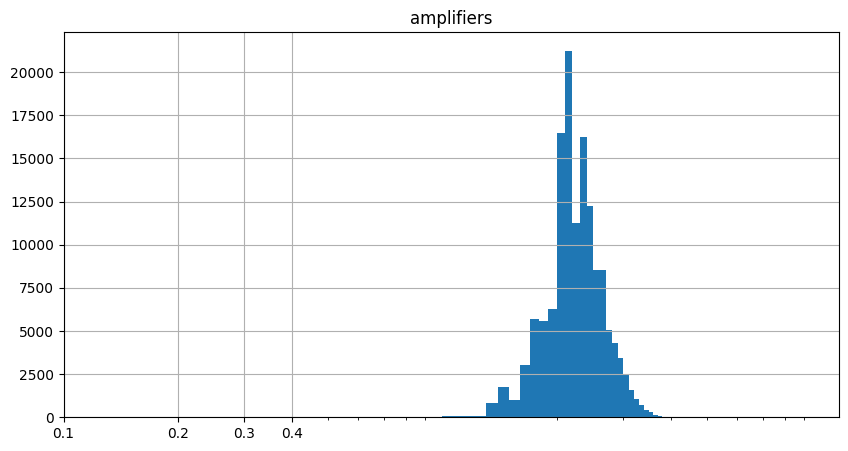

<Figure size 640x480 with 0 Axes>

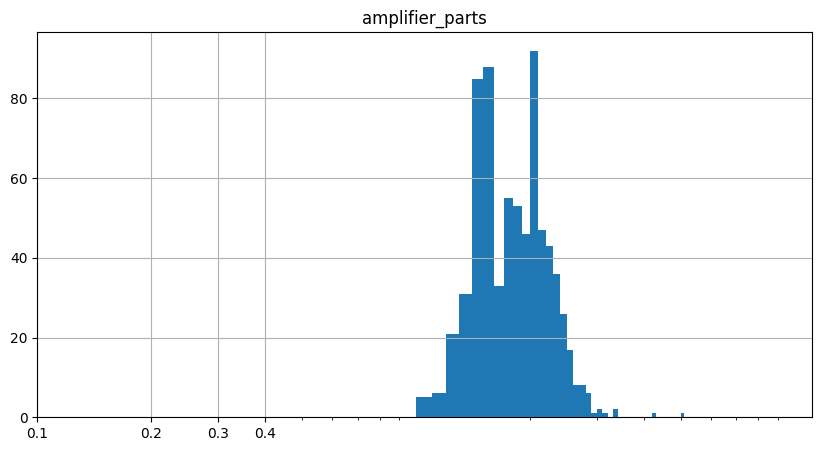

<Figure size 640x480 with 0 Axes>

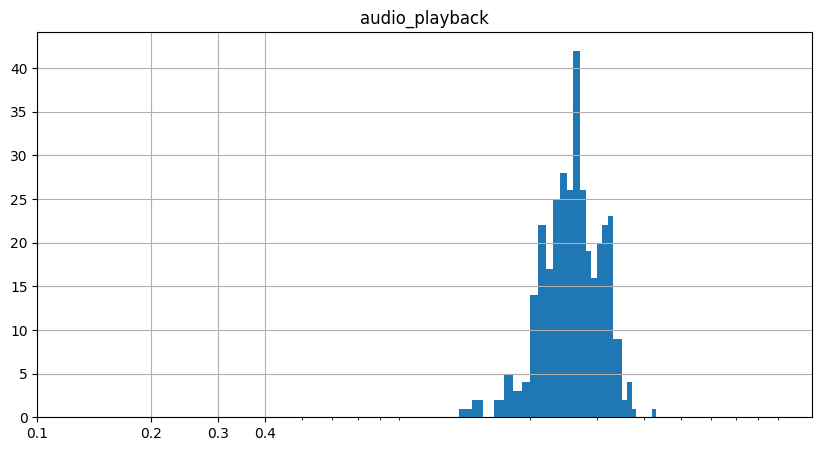

<Figure size 640x480 with 0 Axes>

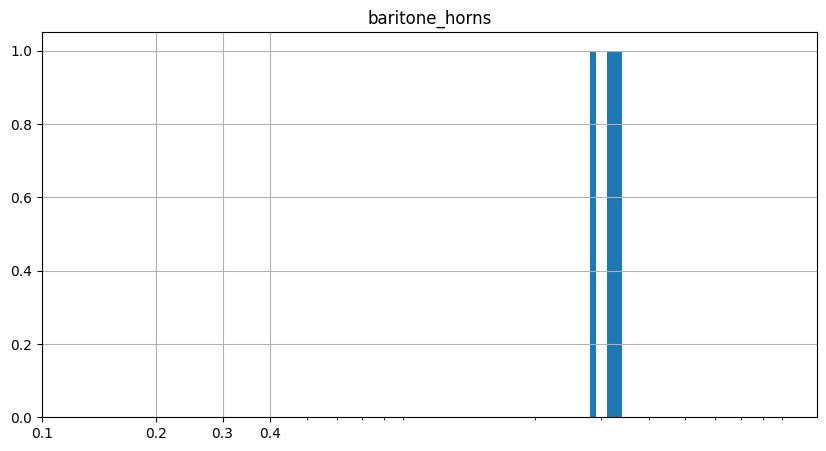

<Figure size 640x480 with 0 Axes>

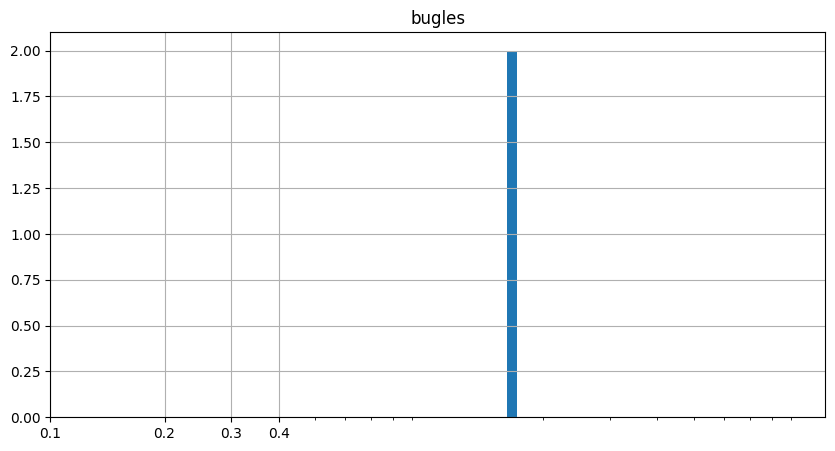

<Figure size 640x480 with 0 Axes>

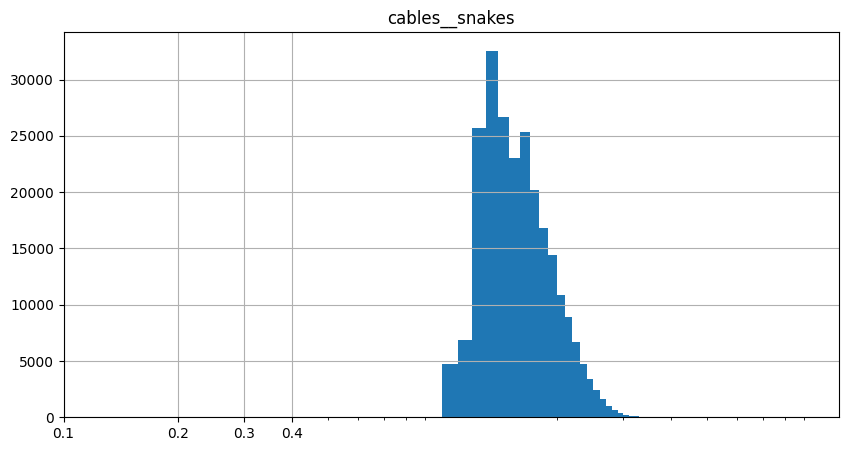

<Figure size 640x480 with 0 Axes>

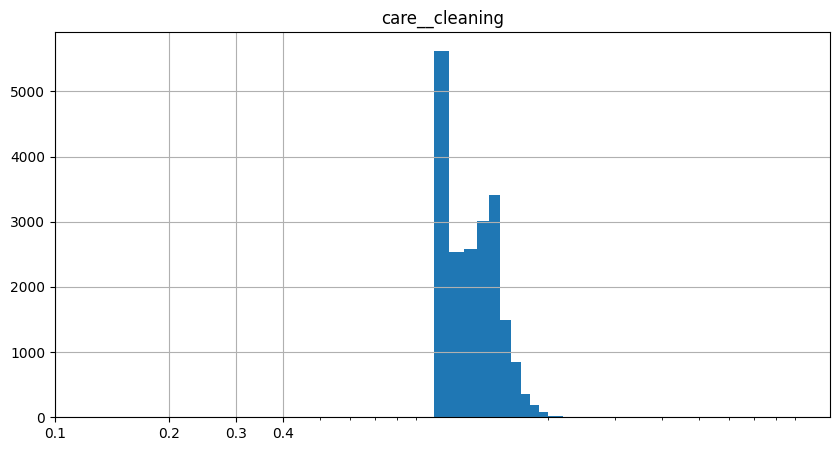

<Figure size 640x480 with 0 Axes>

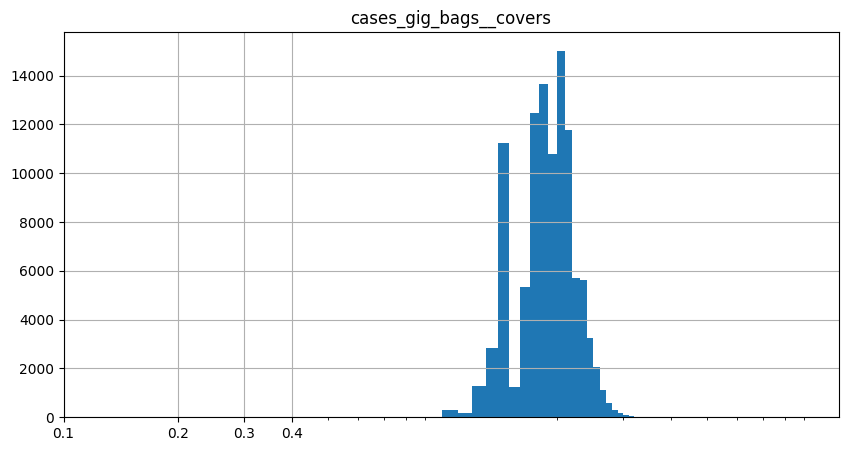

<Figure size 640x480 with 0 Axes>

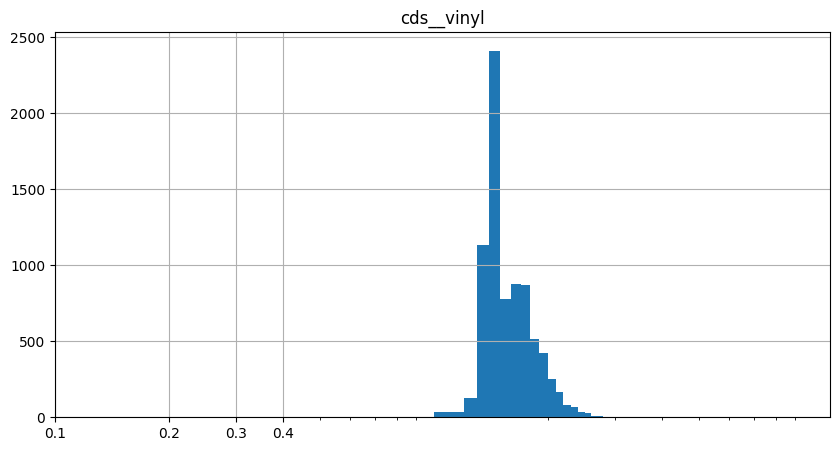

<Figure size 640x480 with 0 Axes>

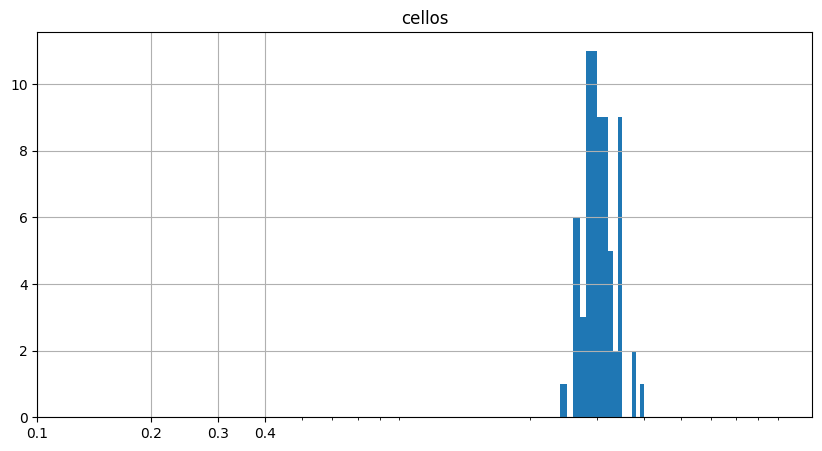

<Figure size 640x480 with 0 Axes>

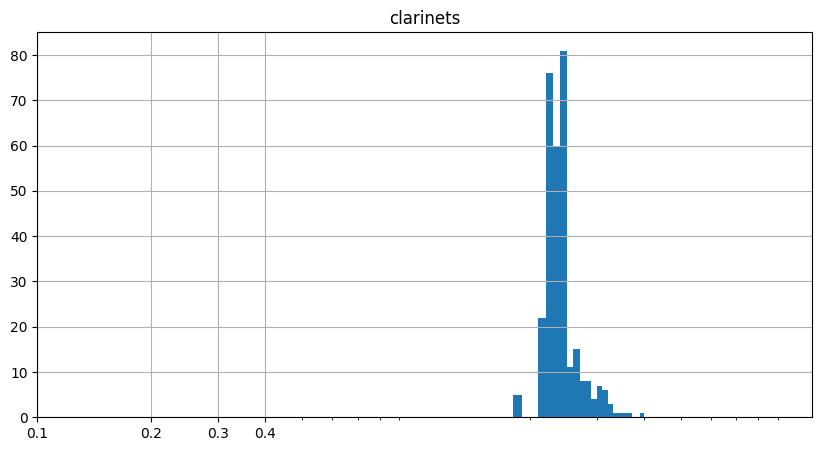

<Figure size 640x480 with 0 Axes>

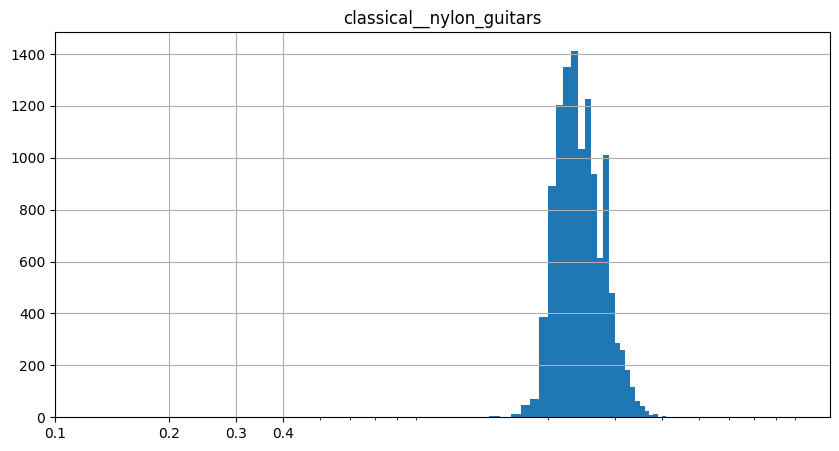

<Figure size 640x480 with 0 Axes>

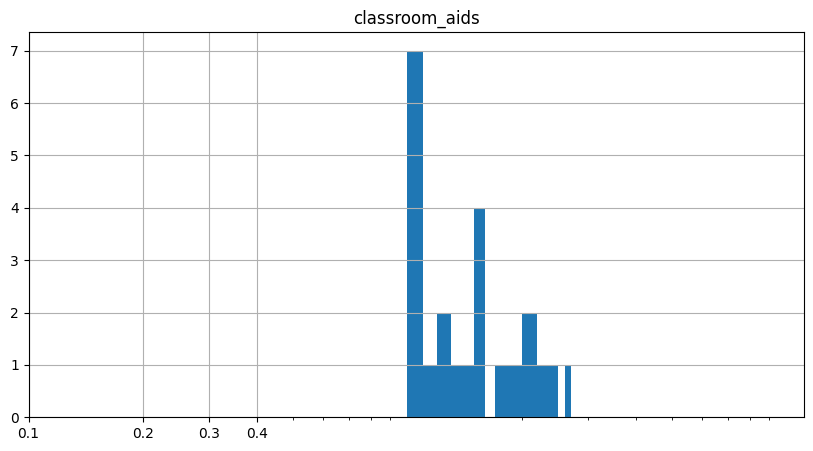

<Figure size 640x480 with 0 Axes>

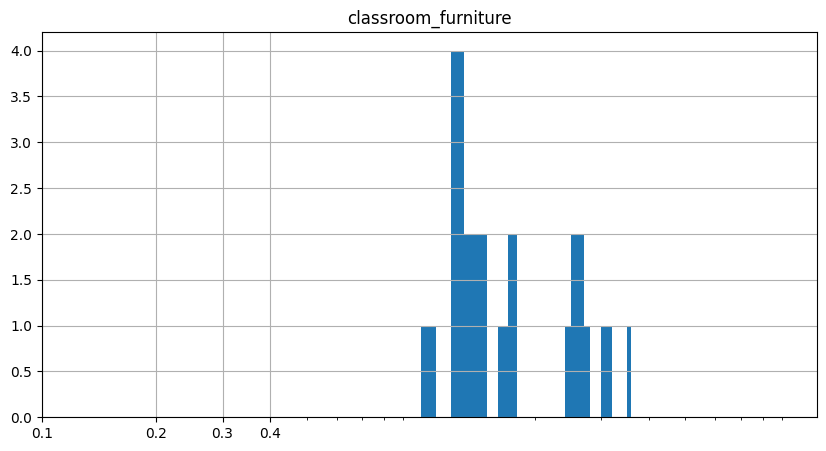

<Figure size 640x480 with 0 Axes>

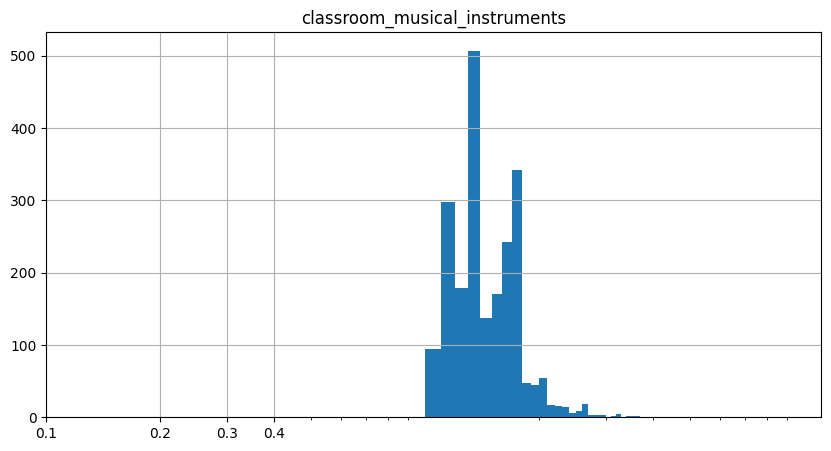

<Figure size 640x480 with 0 Axes>

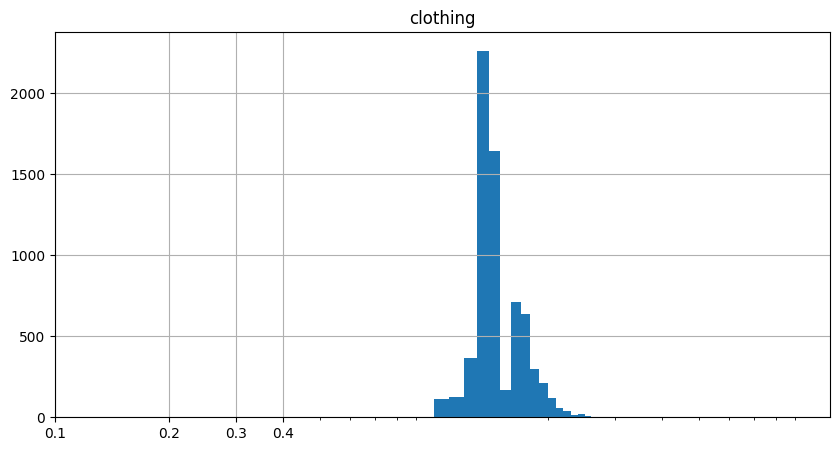

<Figure size 640x480 with 0 Axes>

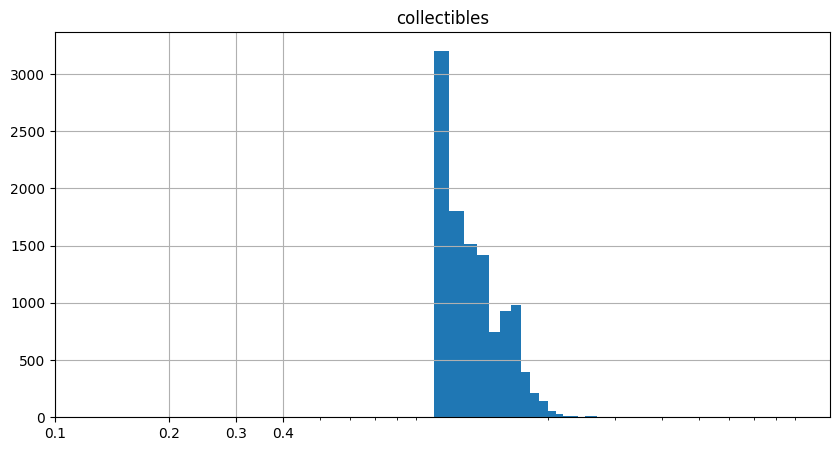

<Figure size 640x480 with 0 Axes>

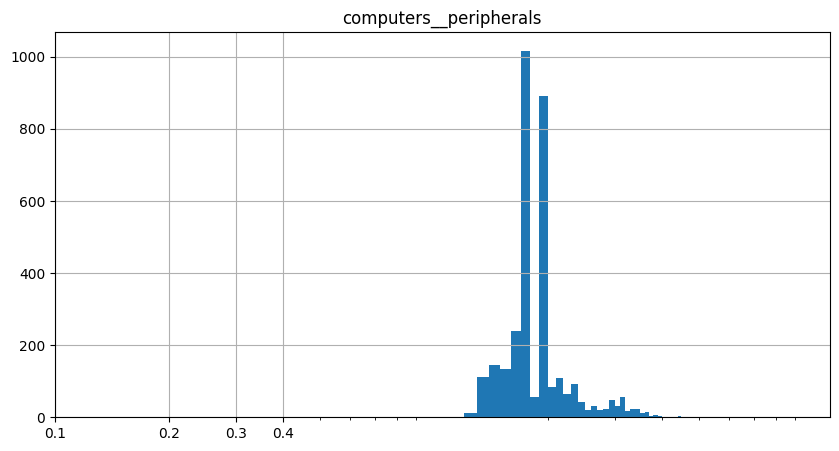

<Figure size 640x480 with 0 Axes>

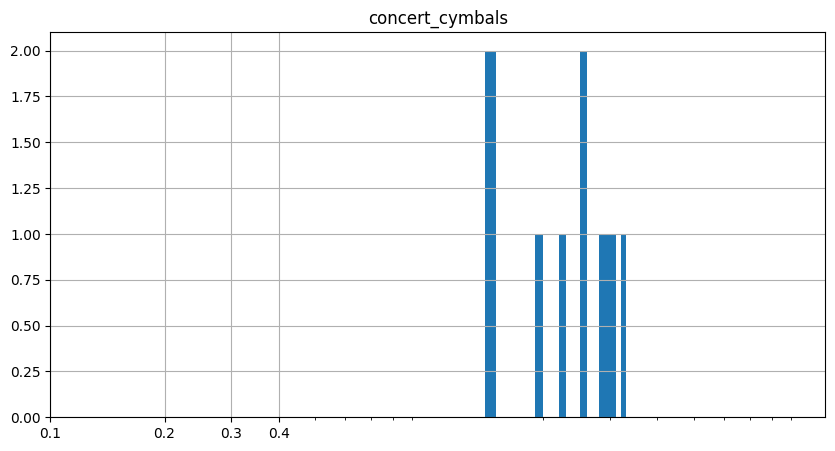

<Figure size 640x480 with 0 Axes>

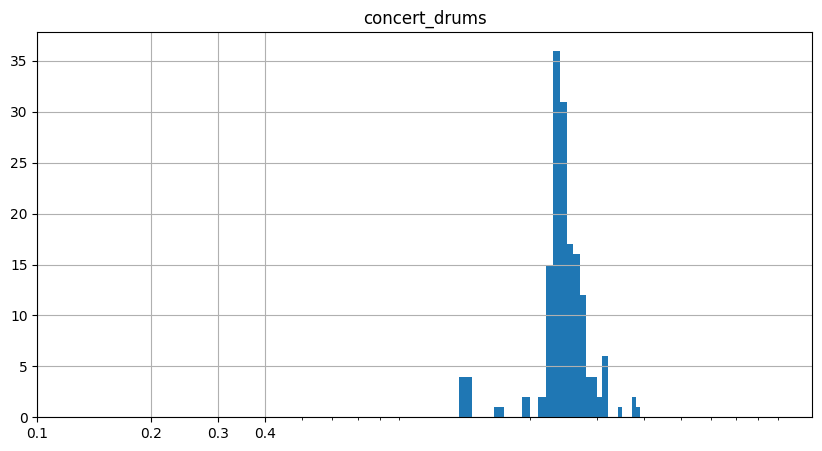

<Figure size 640x480 with 0 Axes>

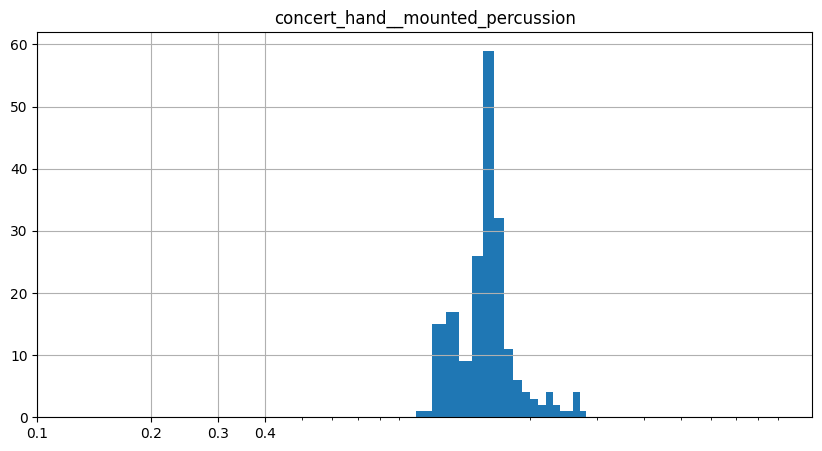

<Figure size 640x480 with 0 Axes>

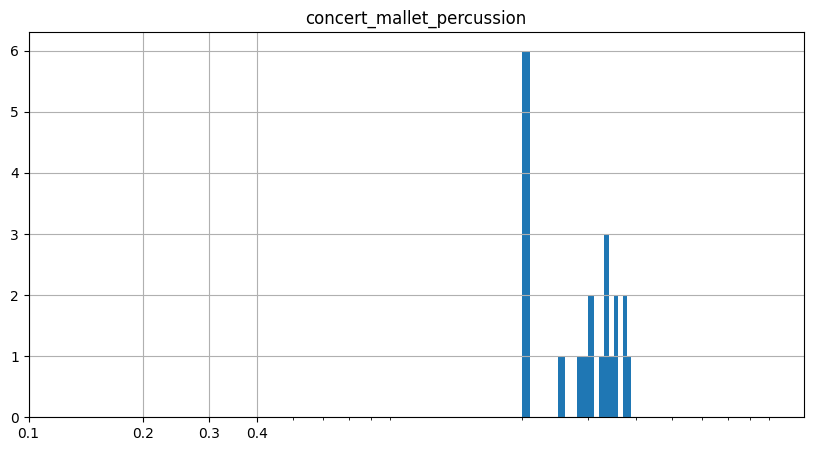

<Figure size 640x480 with 0 Axes>

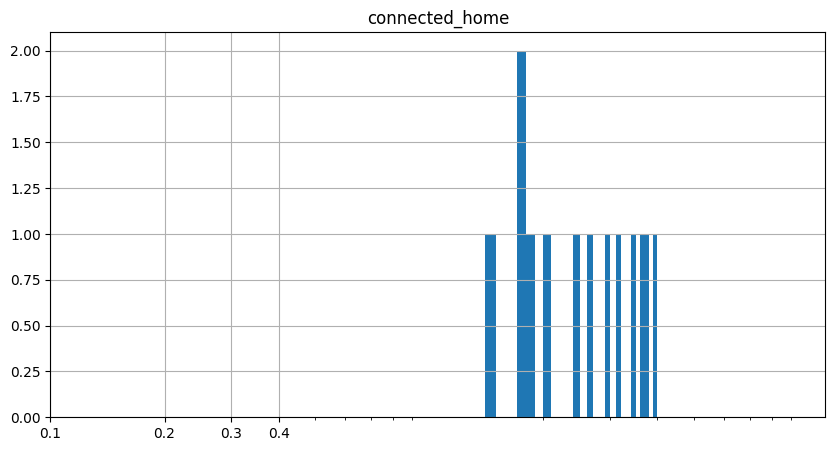

<Figure size 640x480 with 0 Axes>

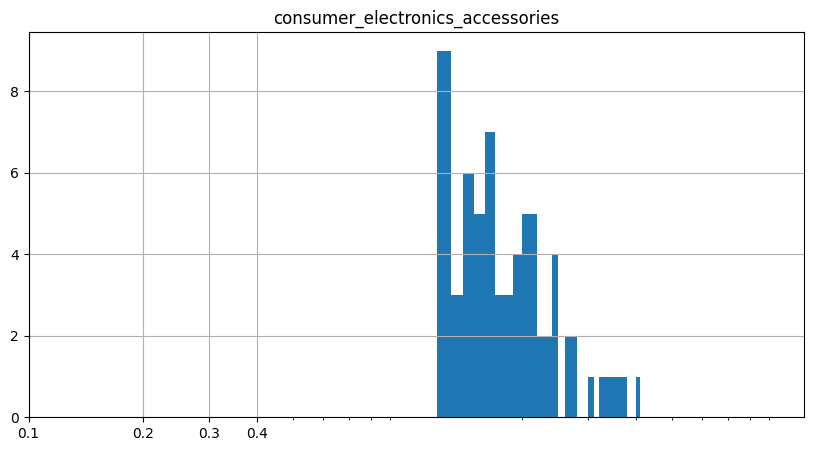

<Figure size 640x480 with 0 Axes>

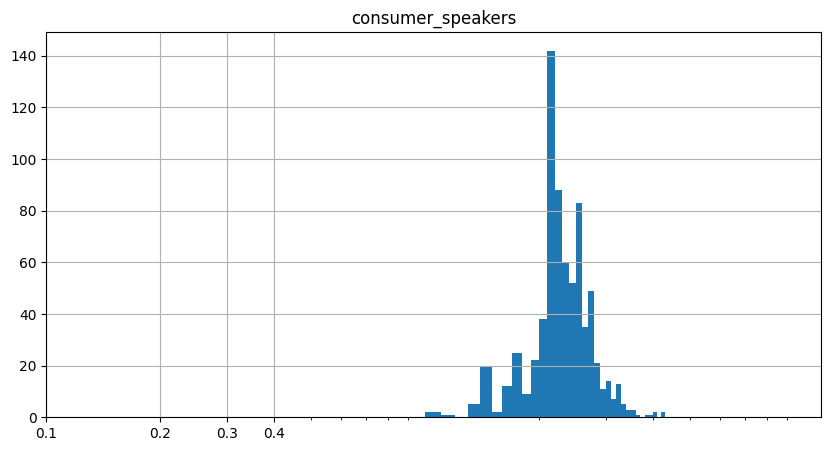

<Figure size 640x480 with 0 Axes>

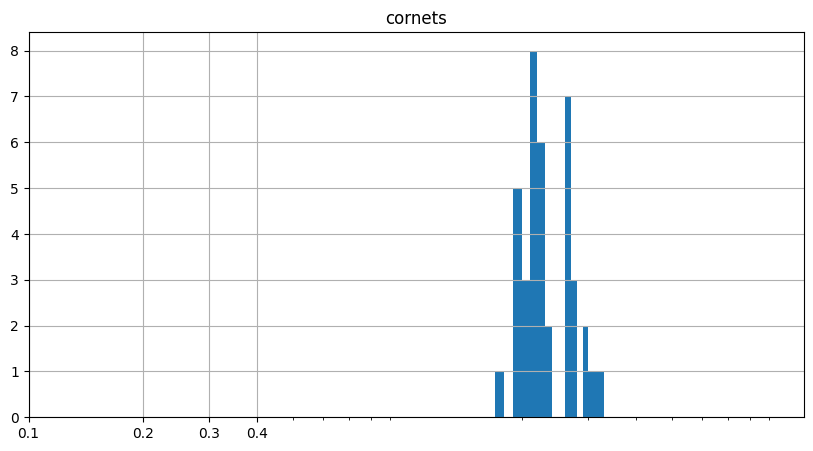

<Figure size 640x480 with 0 Axes>

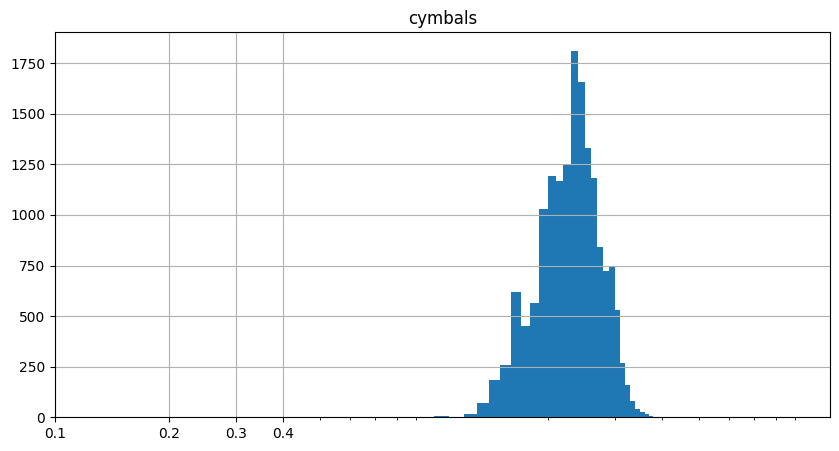

<Figure size 640x480 with 0 Axes>

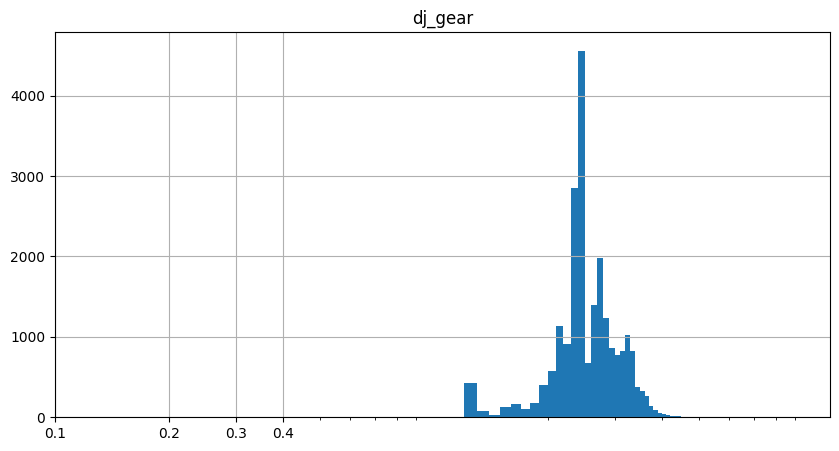

<Figure size 640x480 with 0 Axes>

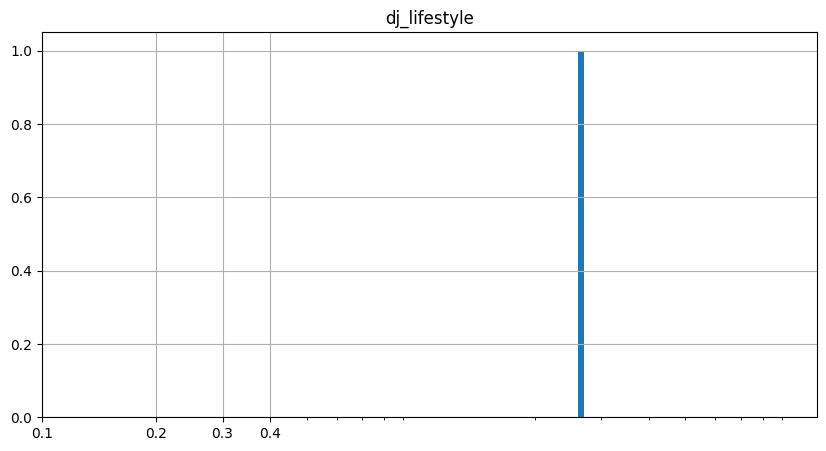

<Figure size 640x480 with 0 Axes>

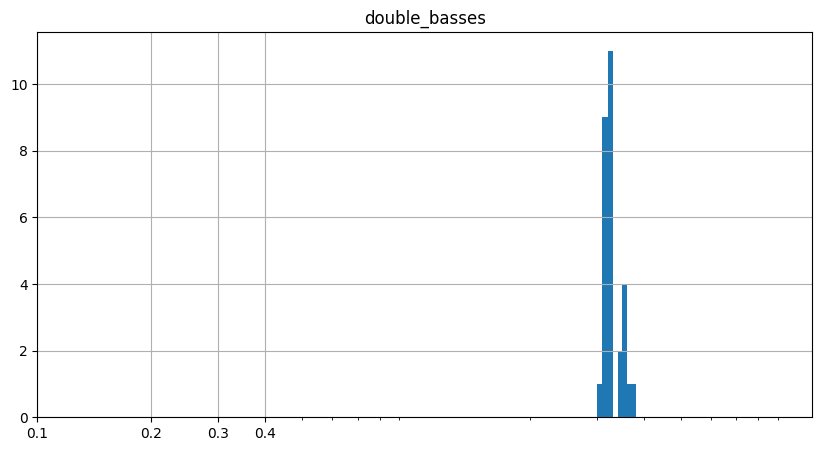

<Figure size 640x480 with 0 Axes>

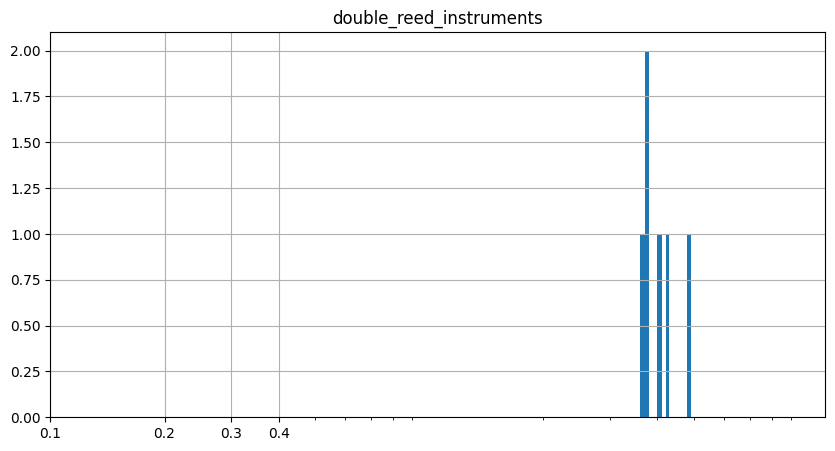

<Figure size 640x480 with 0 Axes>

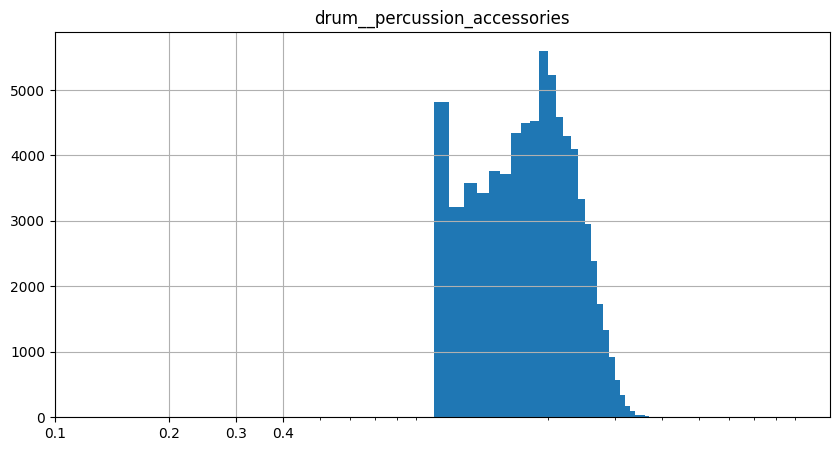

<Figure size 640x480 with 0 Axes>

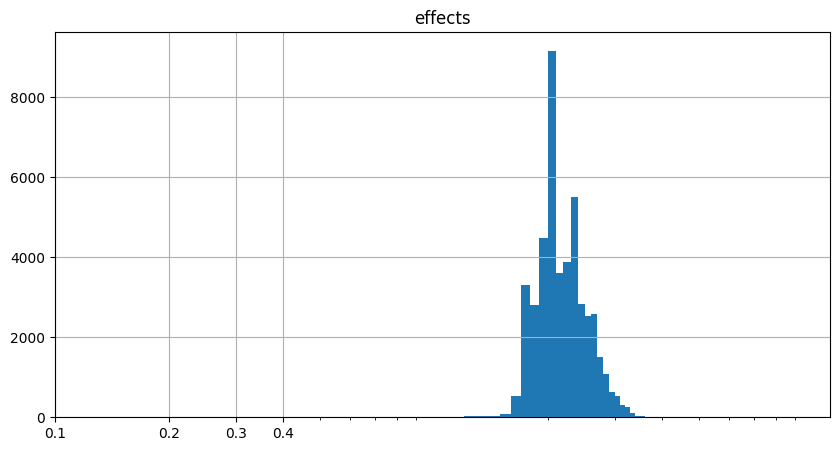

<Figure size 640x480 with 0 Axes>

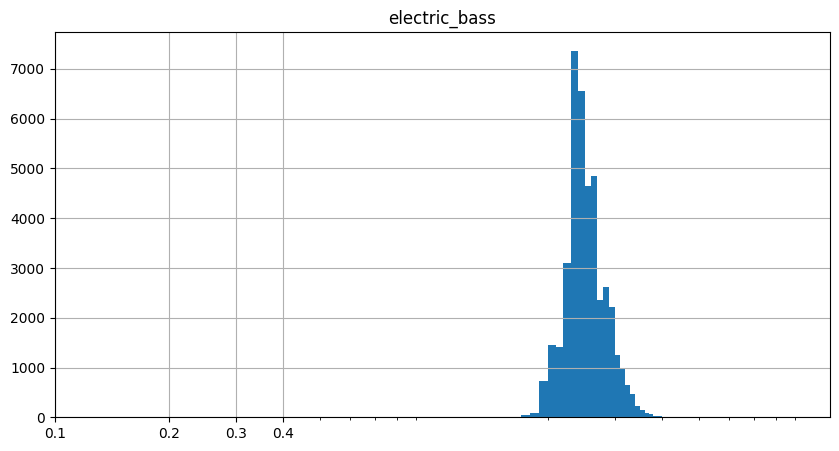

<Figure size 640x480 with 0 Axes>

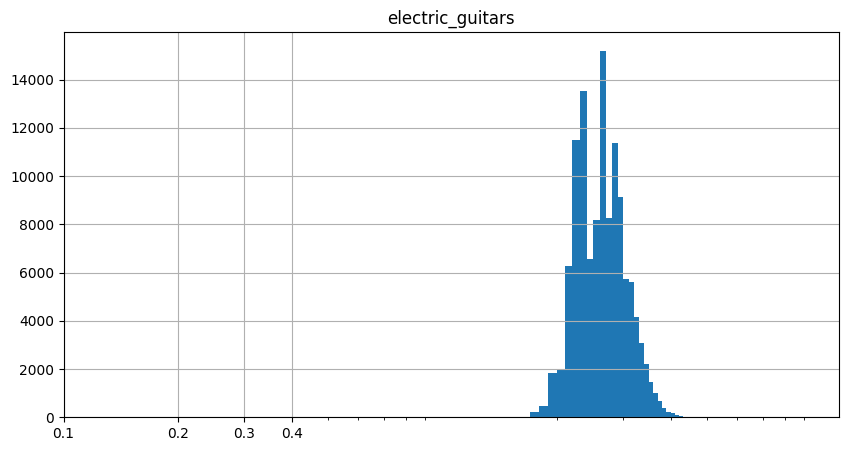

<Figure size 640x480 with 0 Axes>

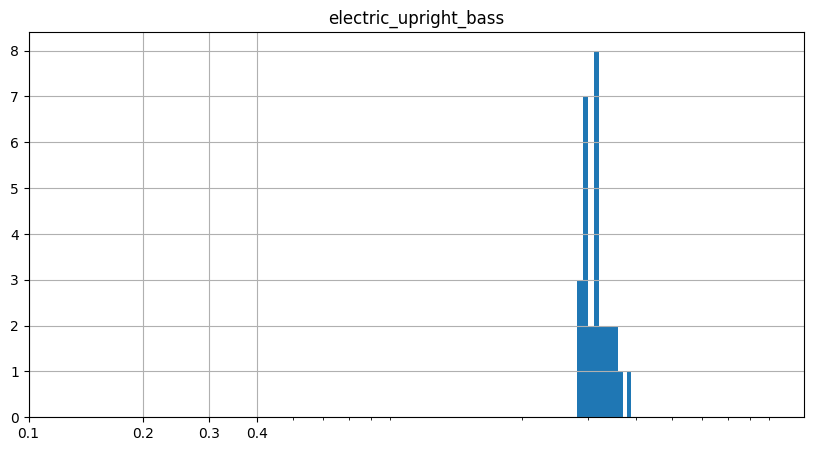

<Figure size 640x480 with 0 Axes>

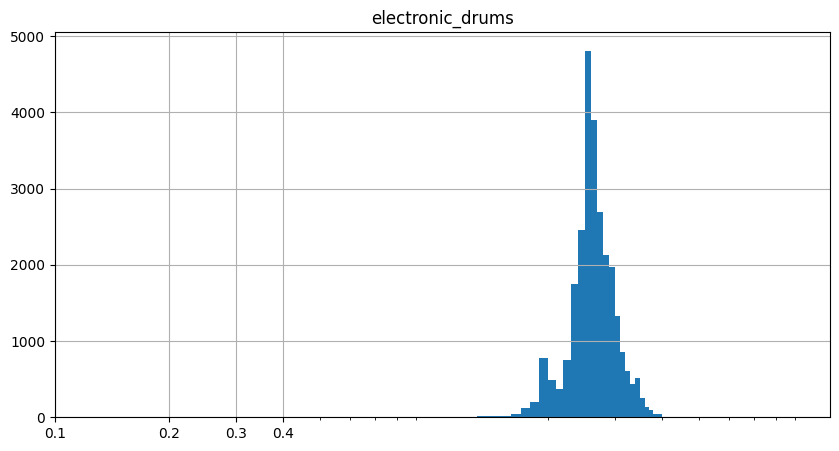

<Figure size 640x480 with 0 Axes>

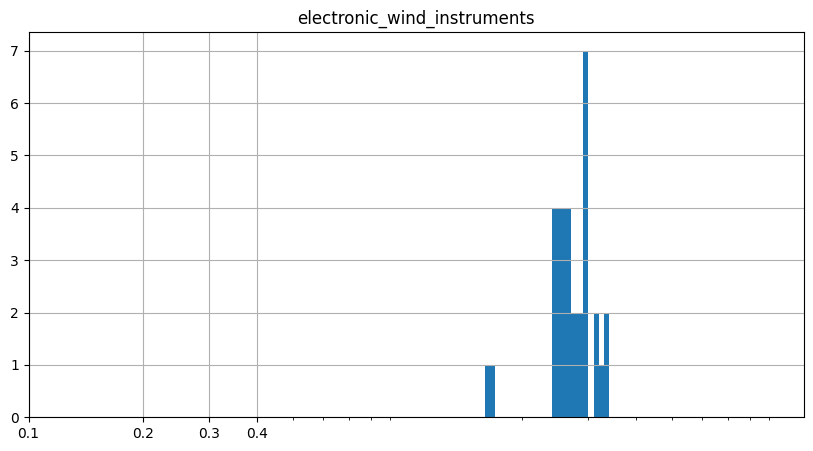

<Figure size 640x480 with 0 Axes>

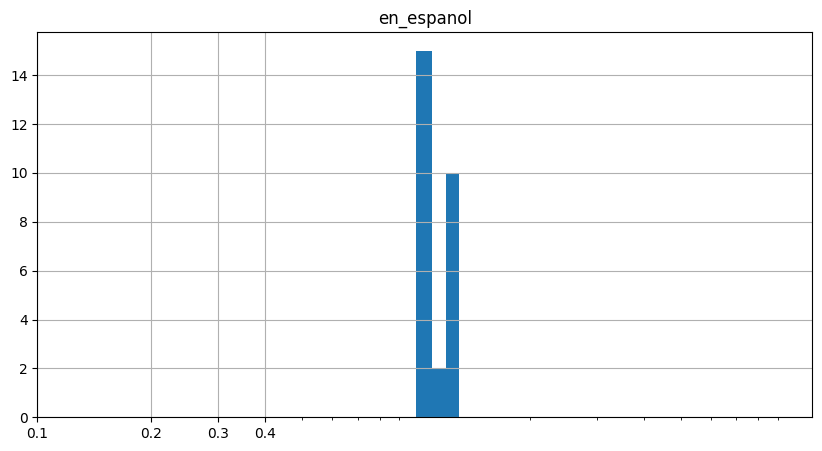

<Figure size 640x480 with 0 Axes>

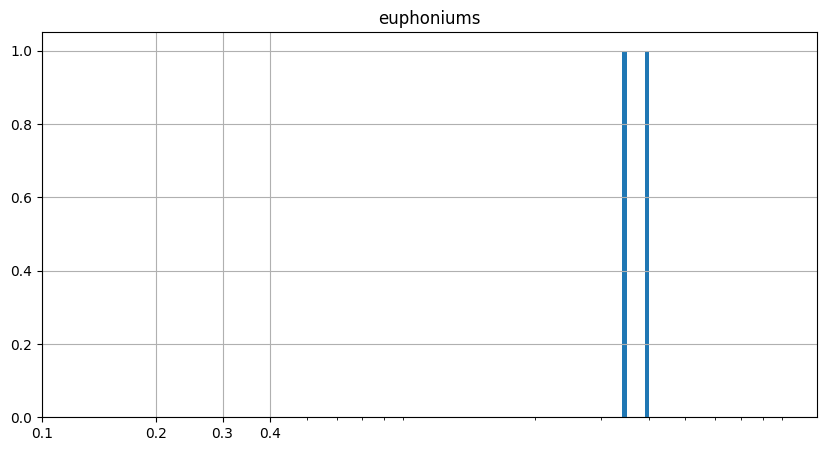

<Figure size 640x480 with 0 Axes>

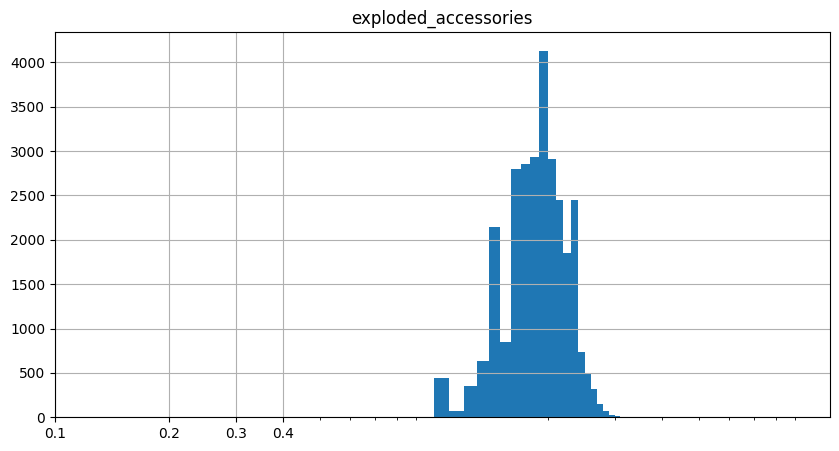

<Figure size 640x480 with 0 Axes>

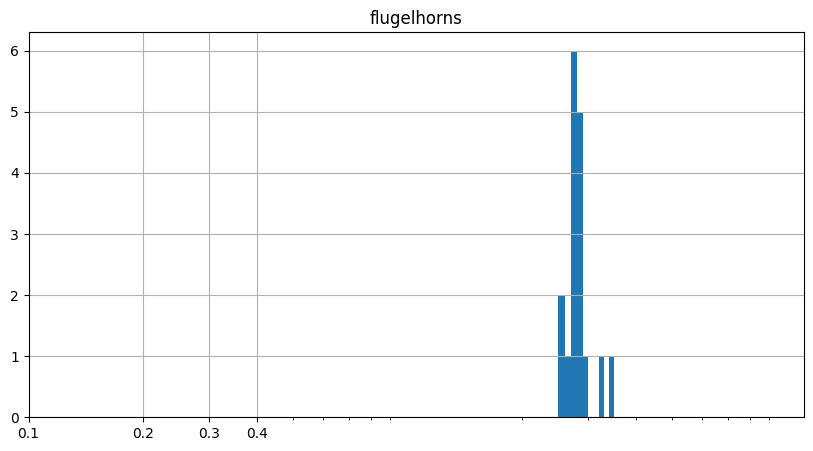

<Figure size 640x480 with 0 Axes>

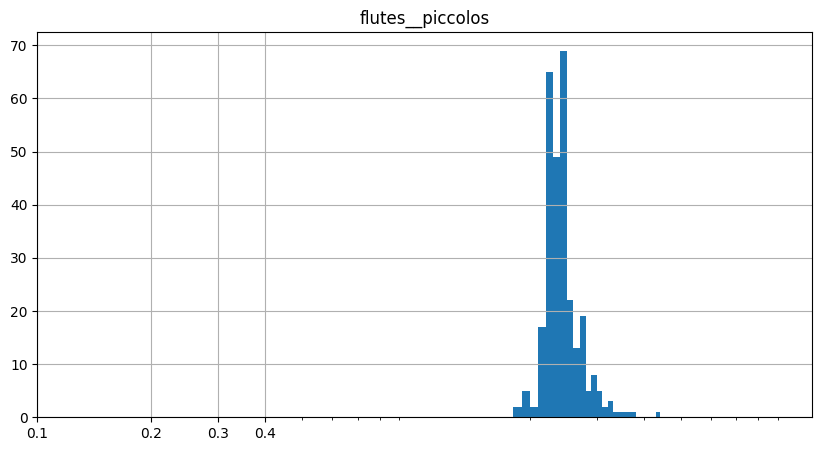

<Figure size 640x480 with 0 Axes>

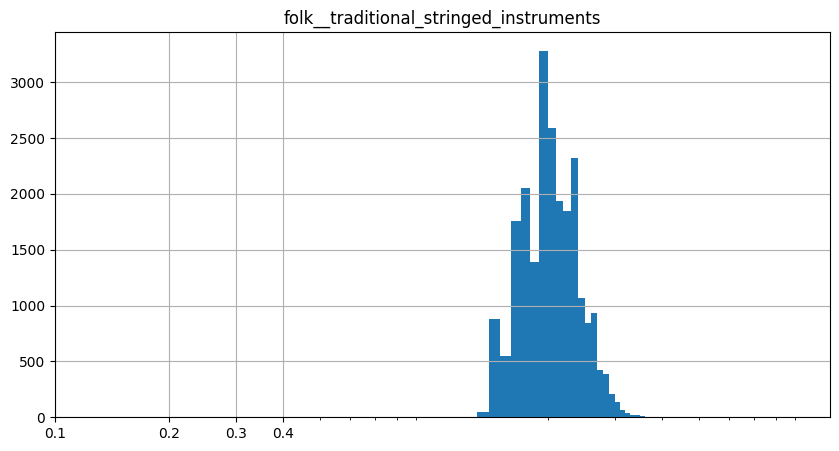

<Figure size 640x480 with 0 Axes>

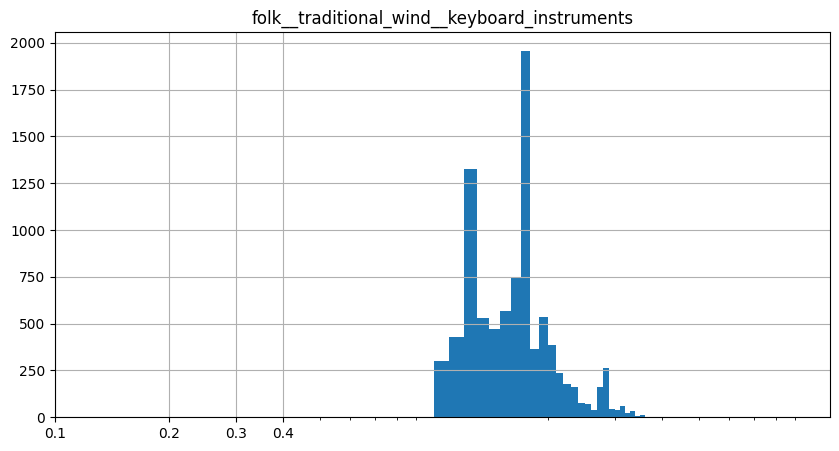

<Figure size 640x480 with 0 Axes>

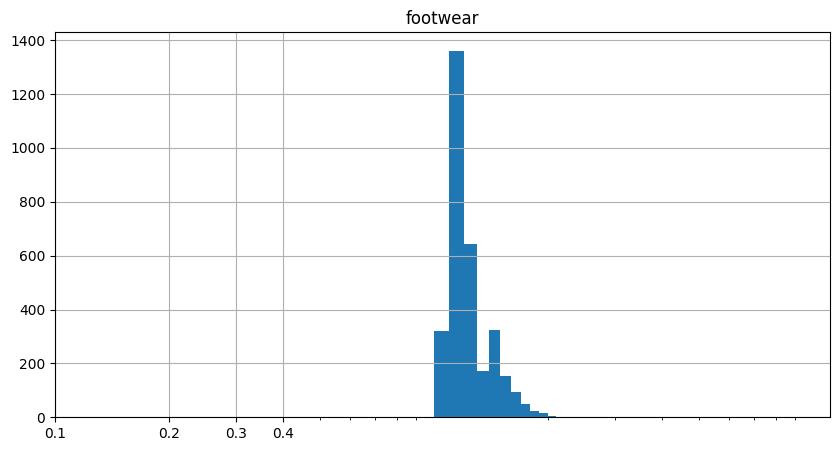

<Figure size 640x480 with 0 Axes>

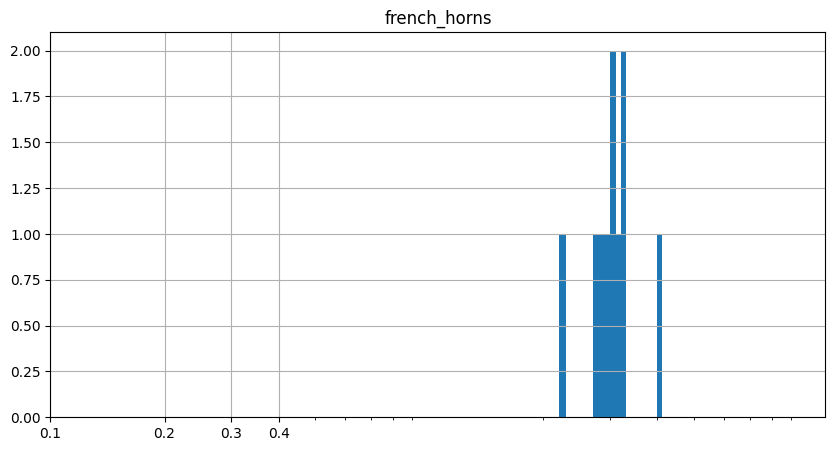

<Figure size 640x480 with 0 Axes>

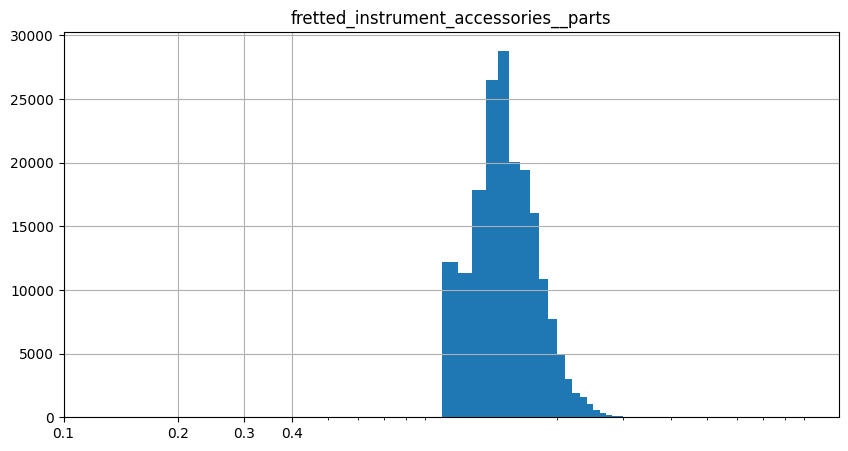

<Figure size 640x480 with 0 Axes>

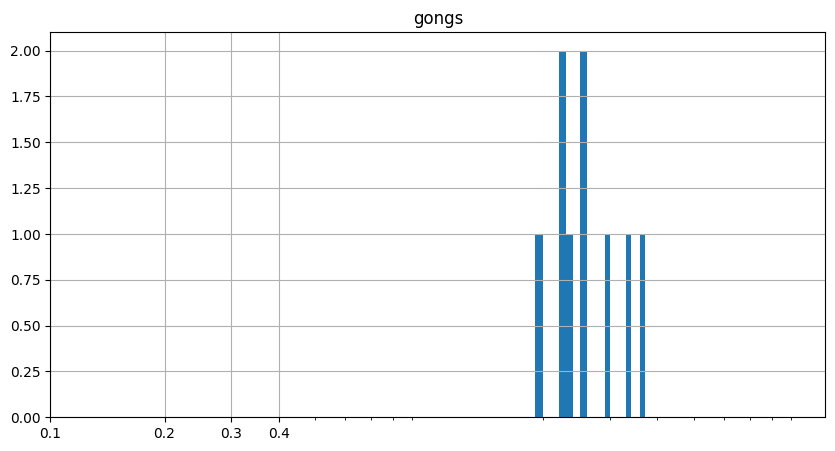

<Figure size 640x480 with 0 Axes>

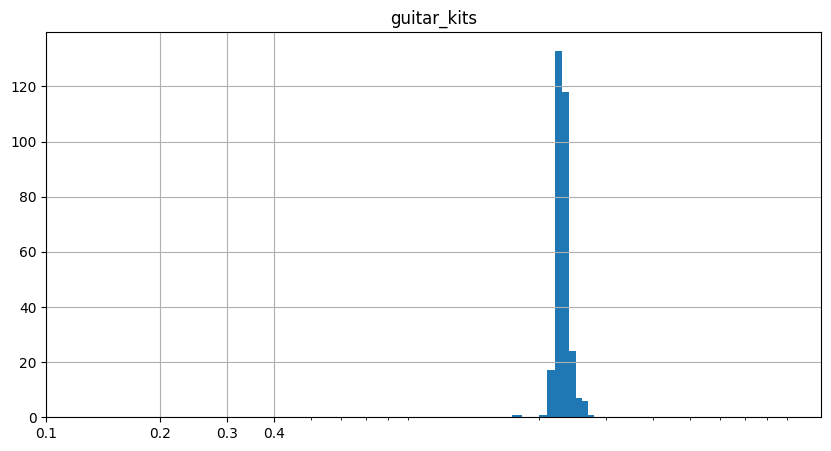

<Figure size 640x480 with 0 Axes>

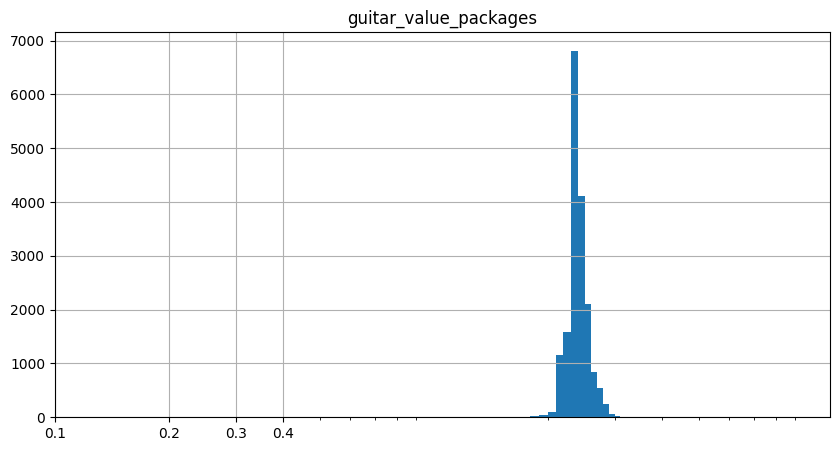

<Figure size 640x480 with 0 Axes>

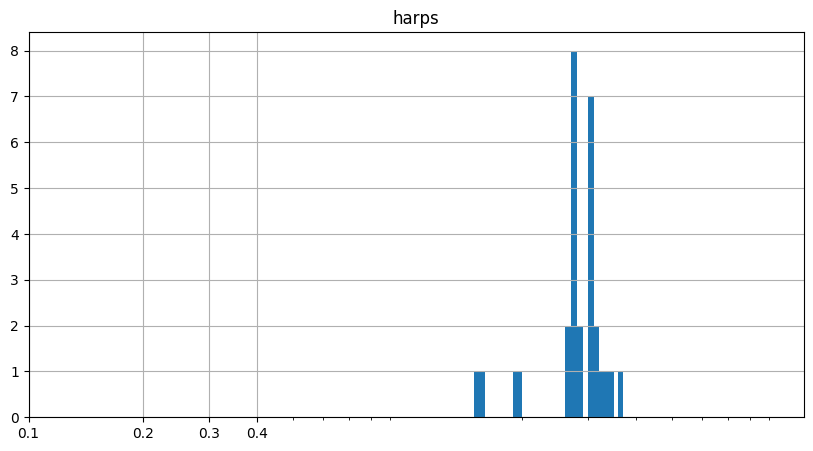

<Figure size 640x480 with 0 Axes>

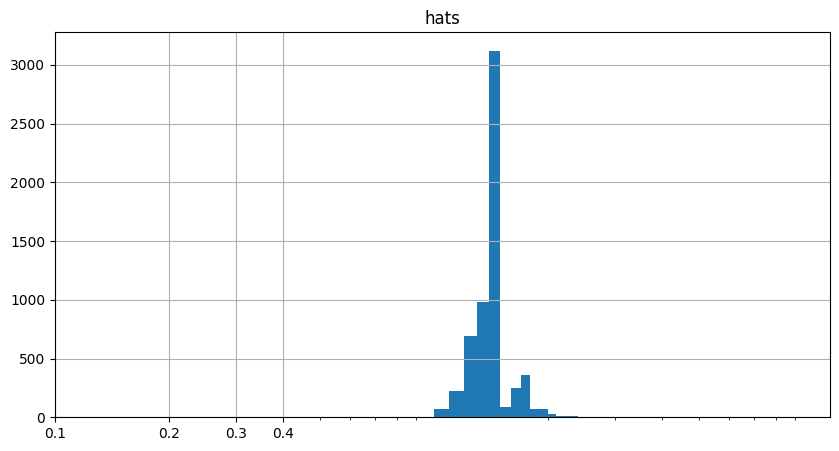

<Figure size 640x480 with 0 Axes>

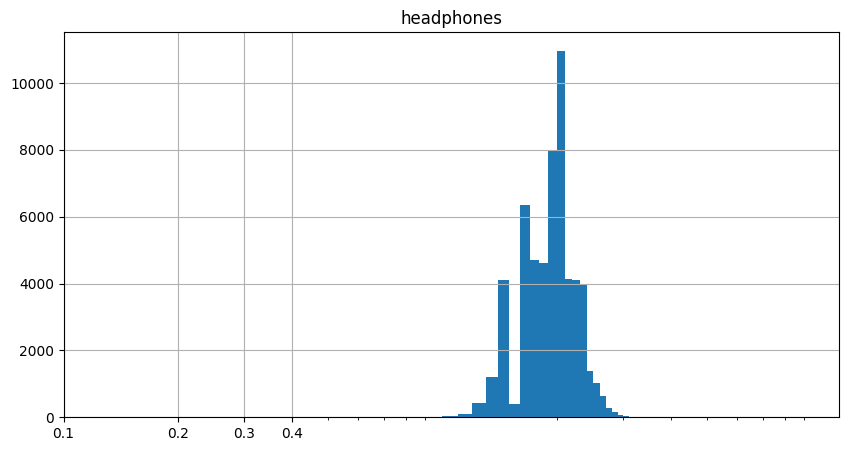

<Figure size 640x480 with 0 Axes>

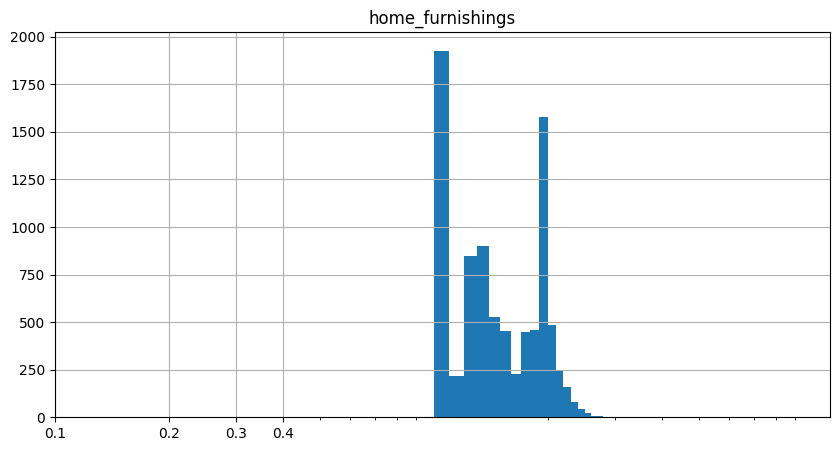

<Figure size 640x480 with 0 Axes>

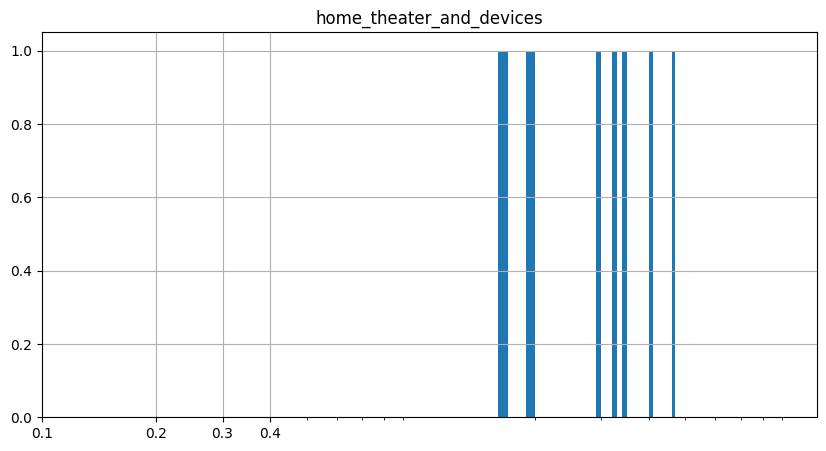

<Figure size 640x480 with 0 Axes>

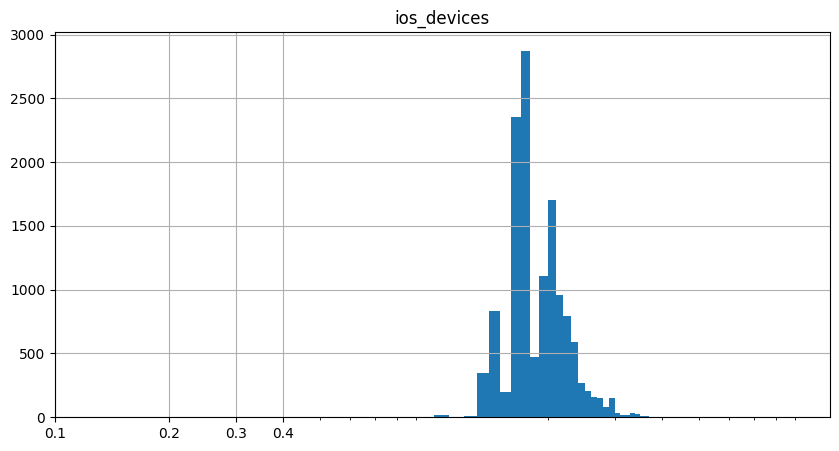

<Figure size 640x480 with 0 Axes>

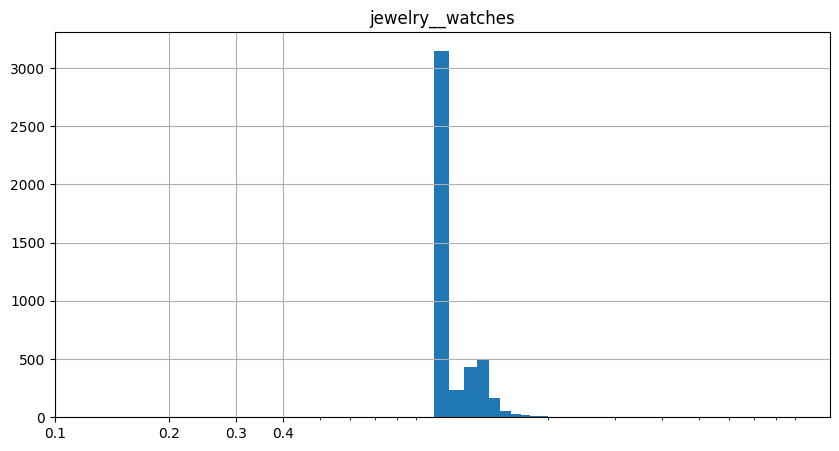

<Figure size 640x480 with 0 Axes>

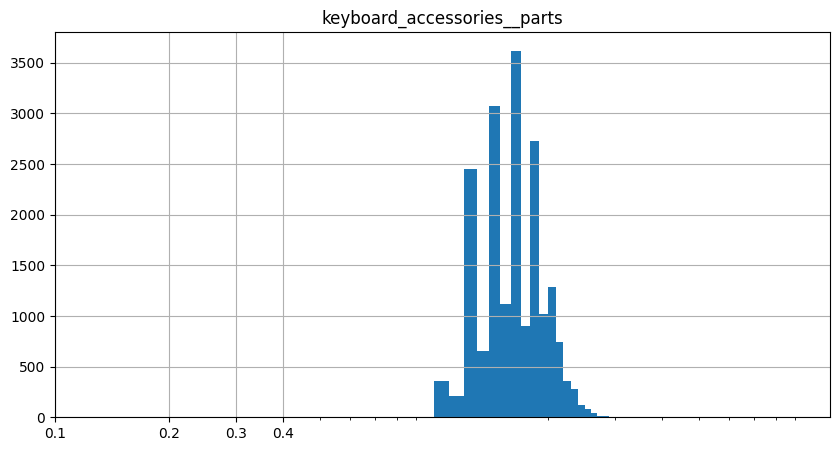

<Figure size 640x480 with 0 Axes>

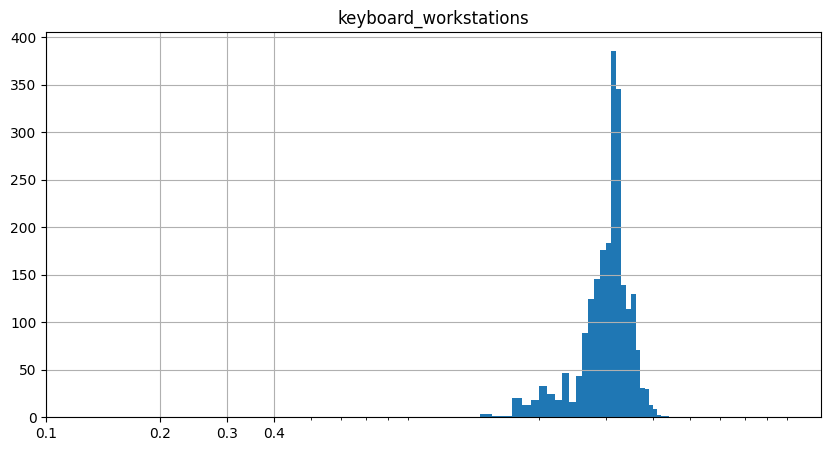

<Figure size 640x480 with 0 Axes>

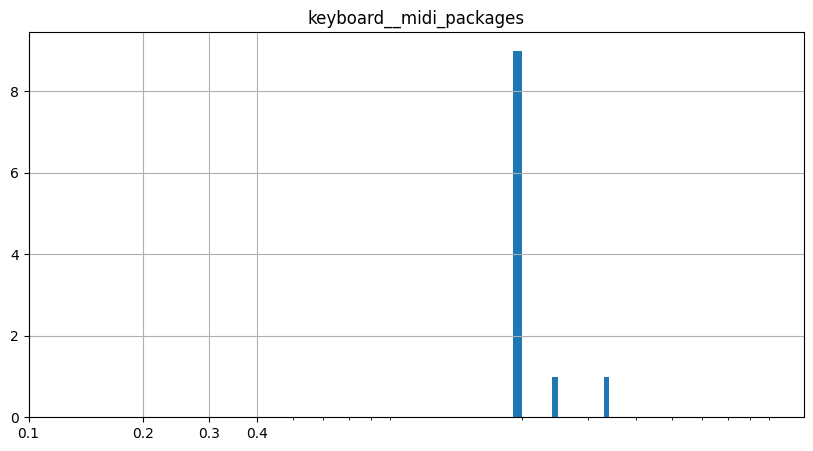

<Figure size 640x480 with 0 Axes>

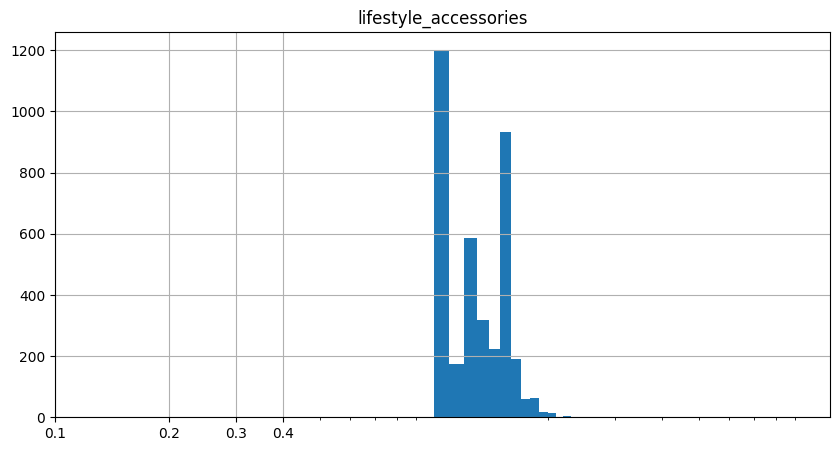

<Figure size 640x480 with 0 Axes>

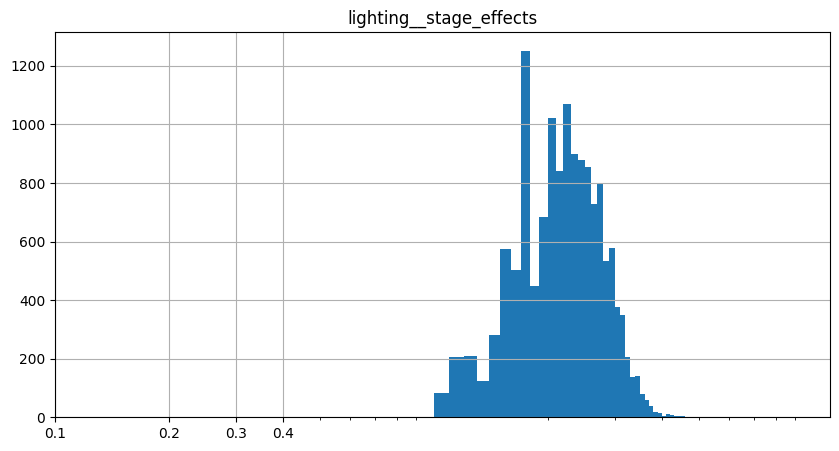

<Figure size 640x480 with 0 Axes>

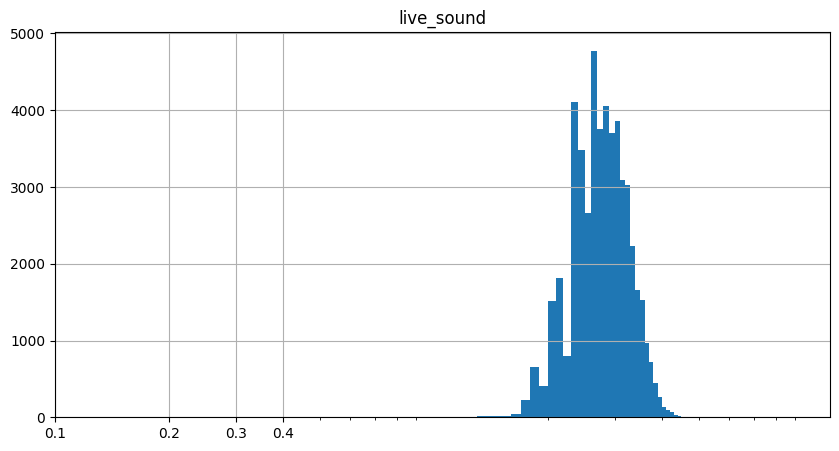

<Figure size 640x480 with 0 Axes>

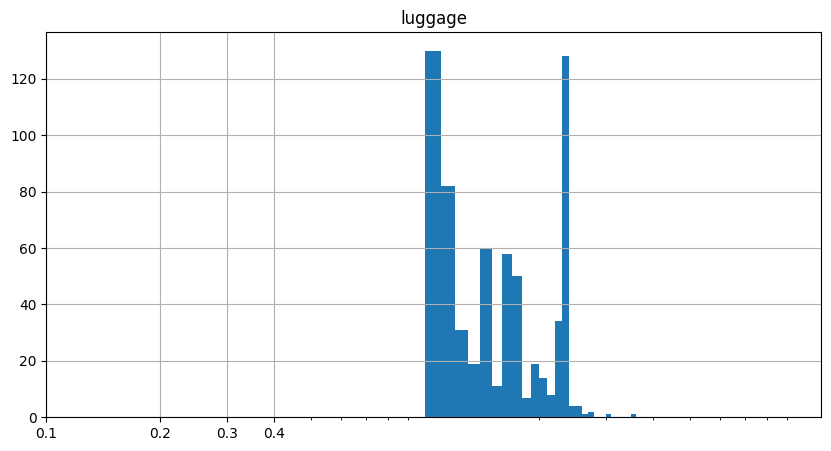

<Figure size 640x480 with 0 Axes>

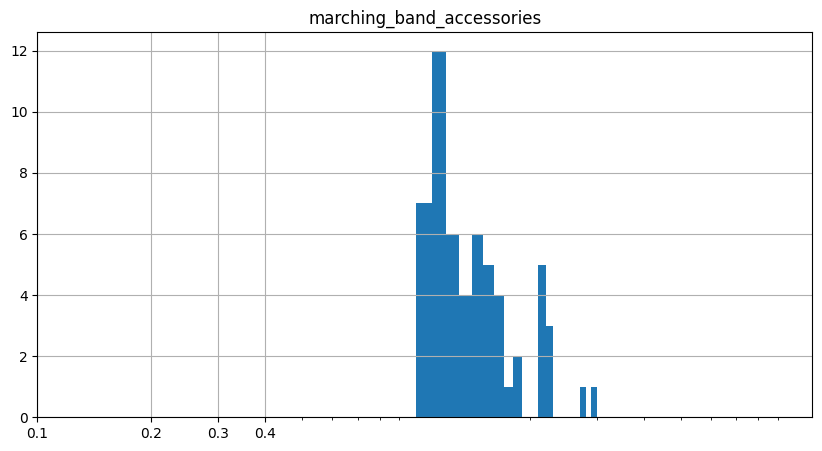

<Figure size 640x480 with 0 Axes>

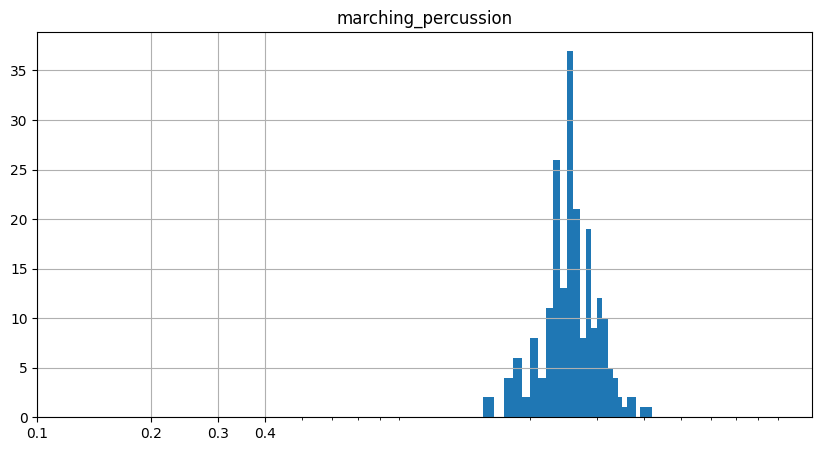

<Figure size 640x480 with 0 Axes>

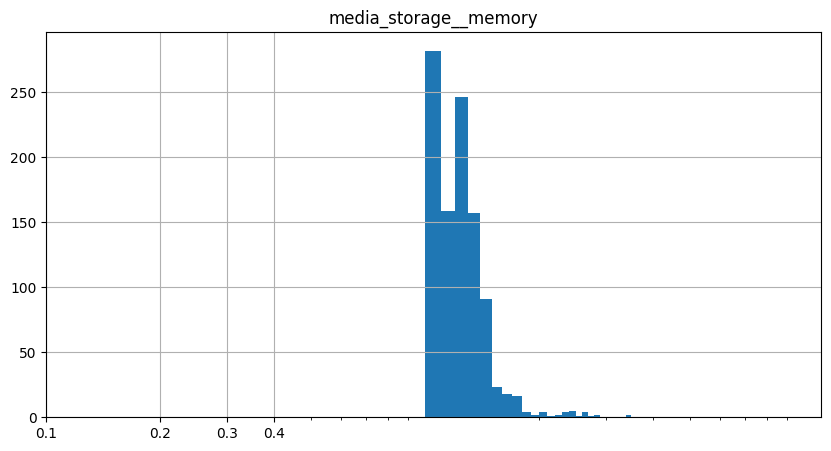

<Figure size 640x480 with 0 Axes>

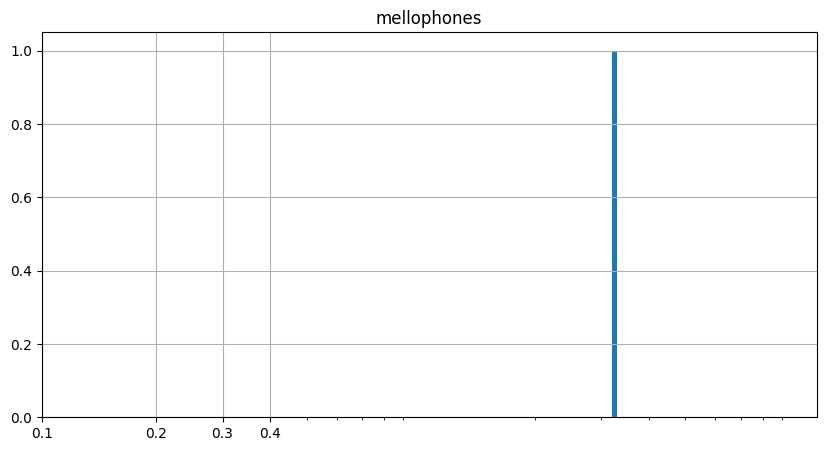

<Figure size 640x480 with 0 Axes>

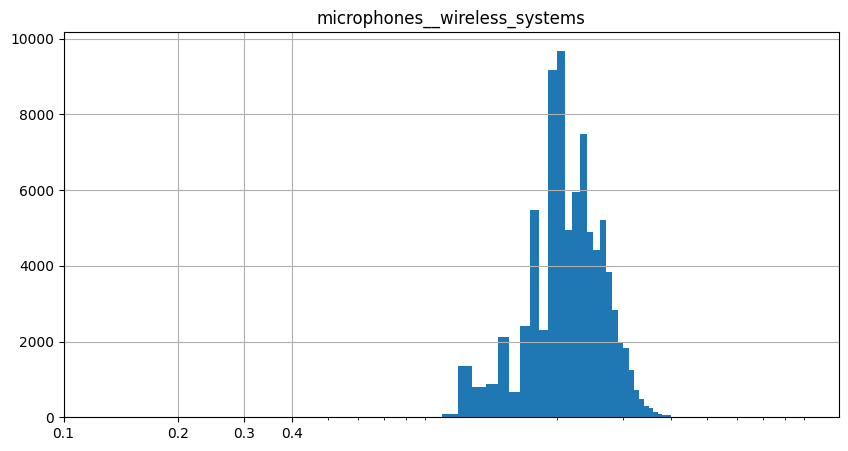

<Figure size 640x480 with 0 Axes>

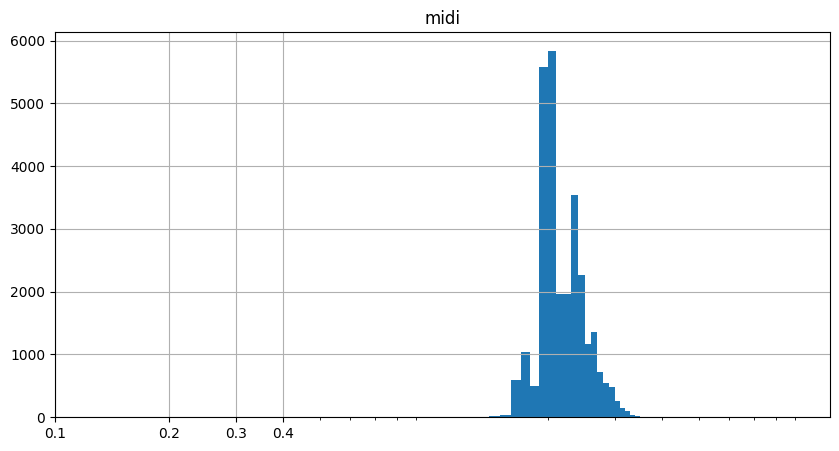

<Figure size 640x480 with 0 Axes>

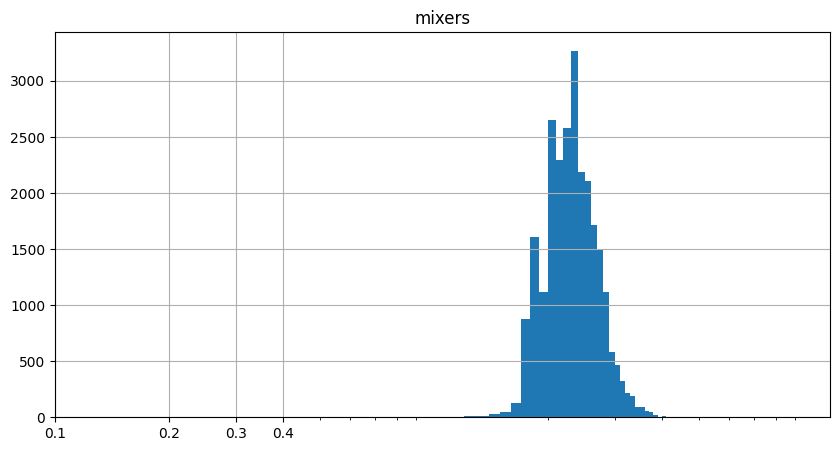

<Figure size 640x480 with 0 Axes>

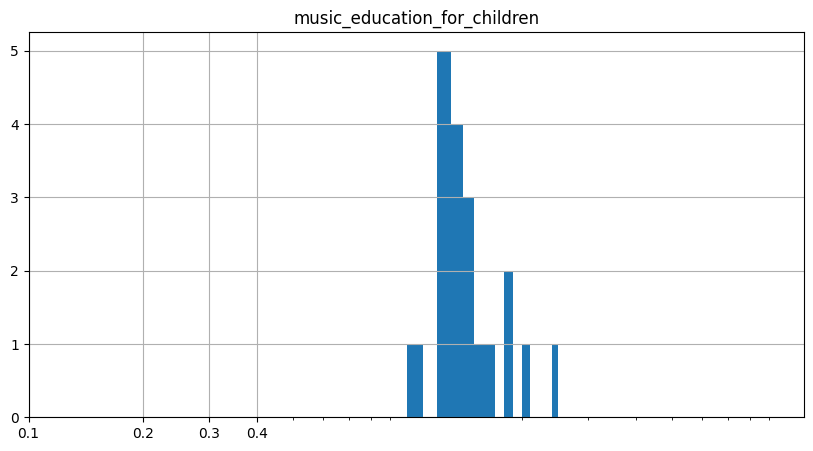

<Figure size 640x480 with 0 Axes>

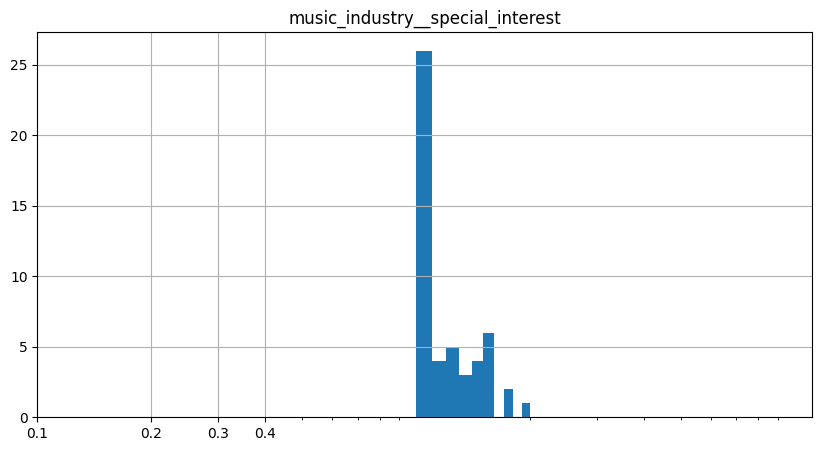

<Figure size 640x480 with 0 Axes>

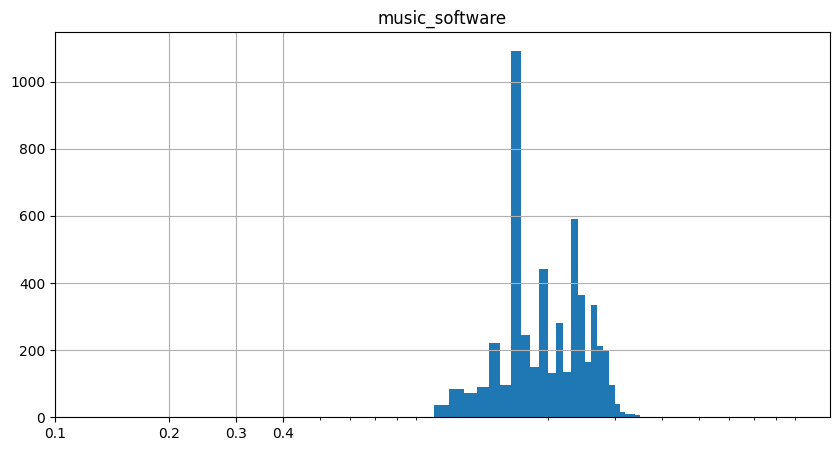

<Figure size 640x480 with 0 Axes>

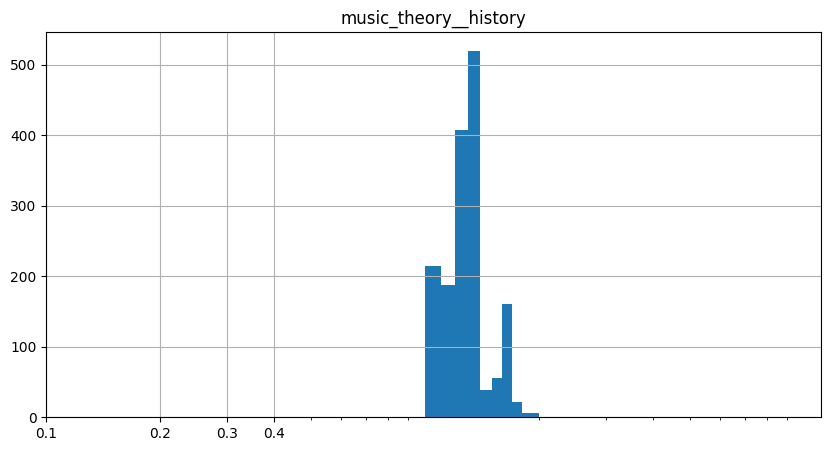

<Figure size 640x480 with 0 Axes>

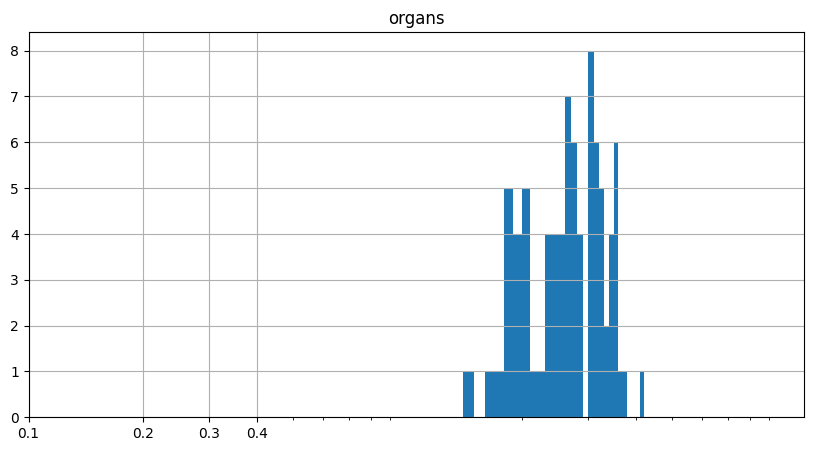

<Figure size 640x480 with 0 Axes>

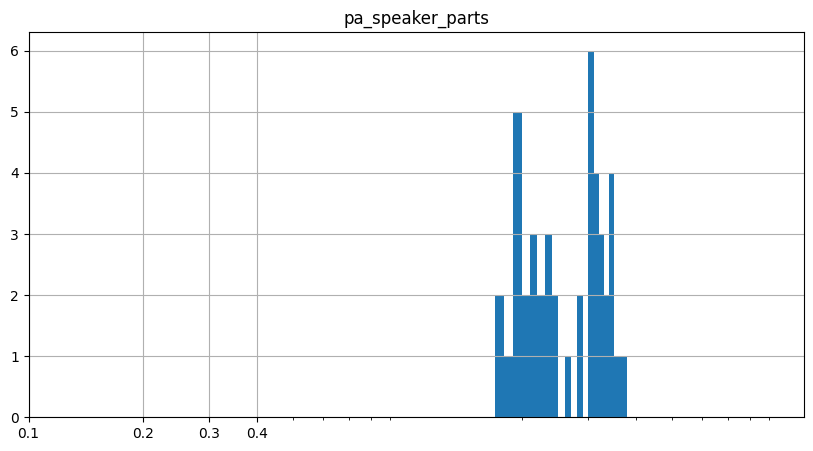

<Figure size 640x480 with 0 Axes>

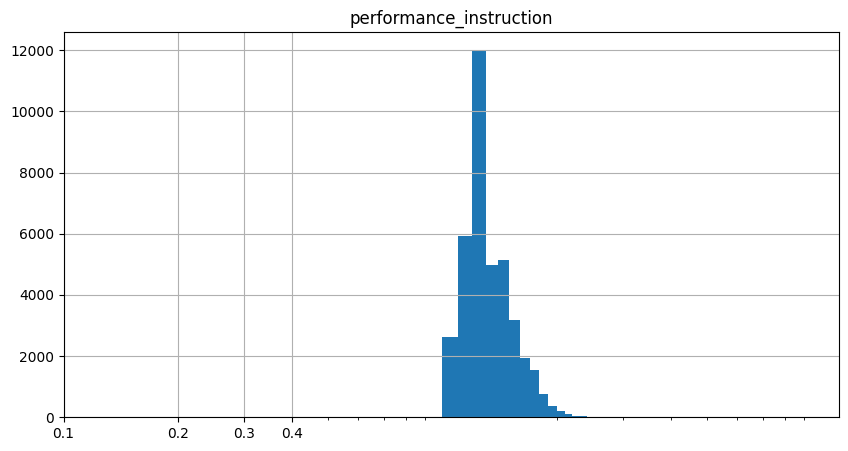

<Figure size 640x480 with 0 Axes>

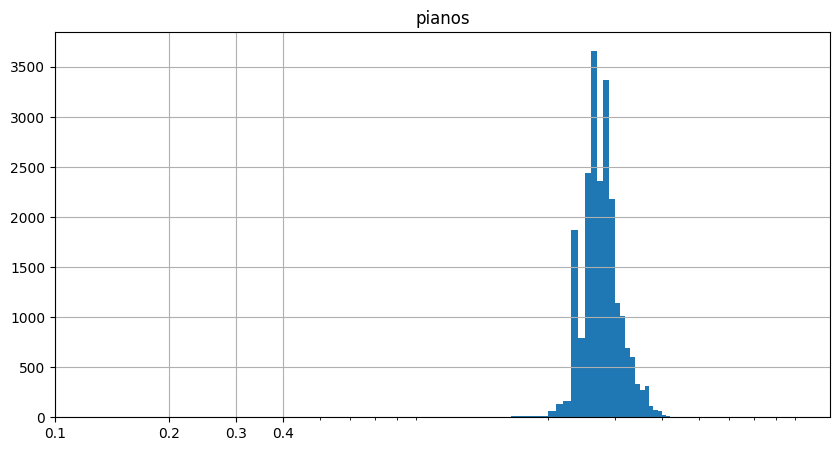

<Figure size 640x480 with 0 Axes>

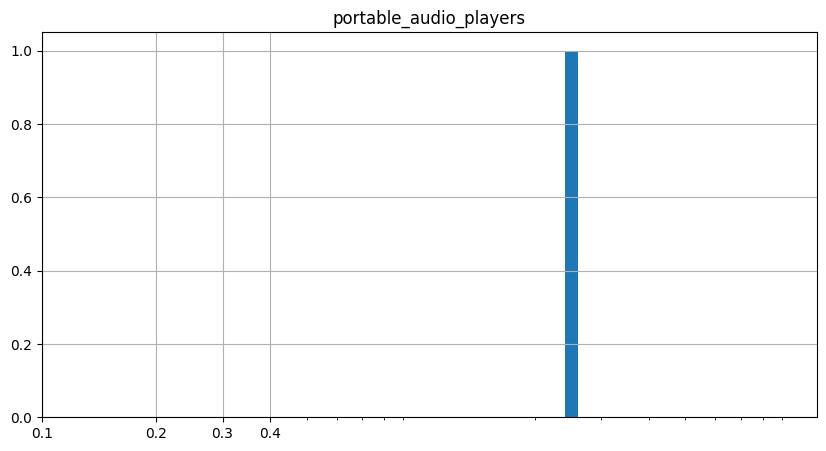

<Figure size 640x480 with 0 Axes>

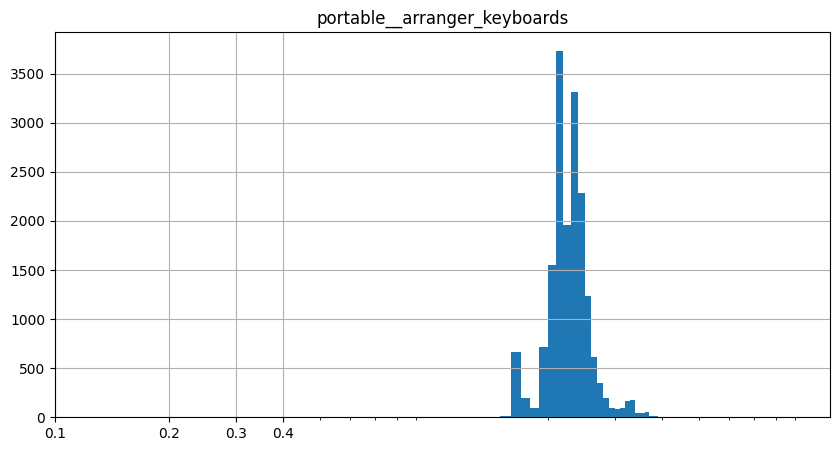

<Figure size 640x480 with 0 Axes>

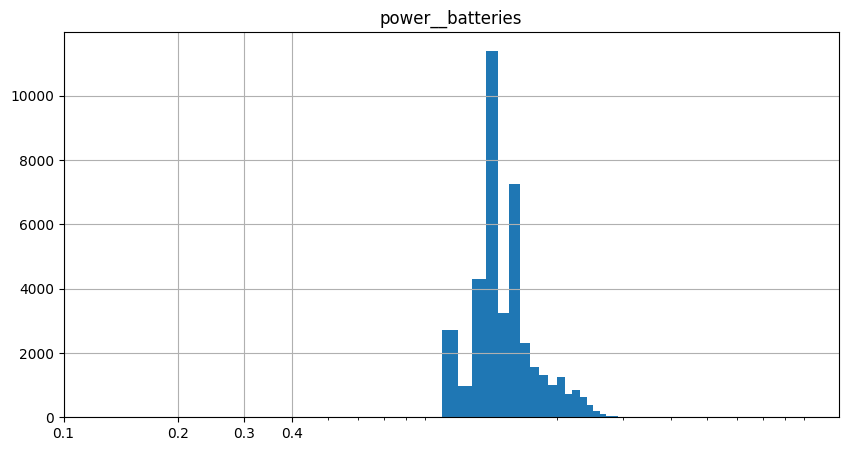

<Figure size 640x480 with 0 Axes>

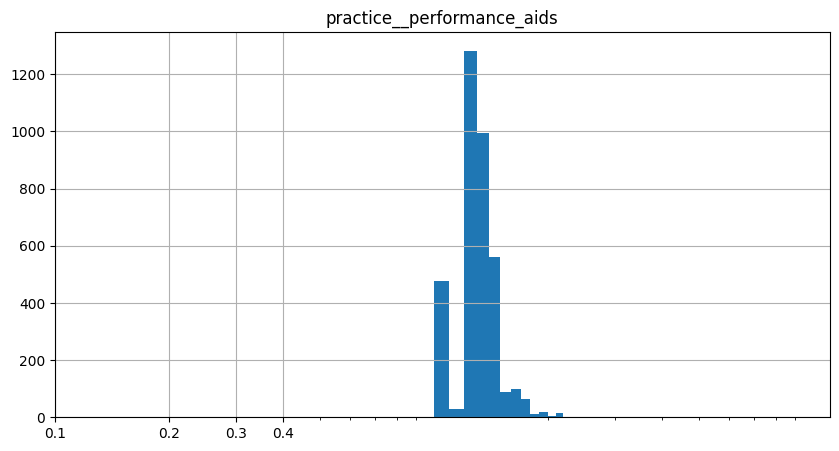

<Figure size 640x480 with 0 Axes>

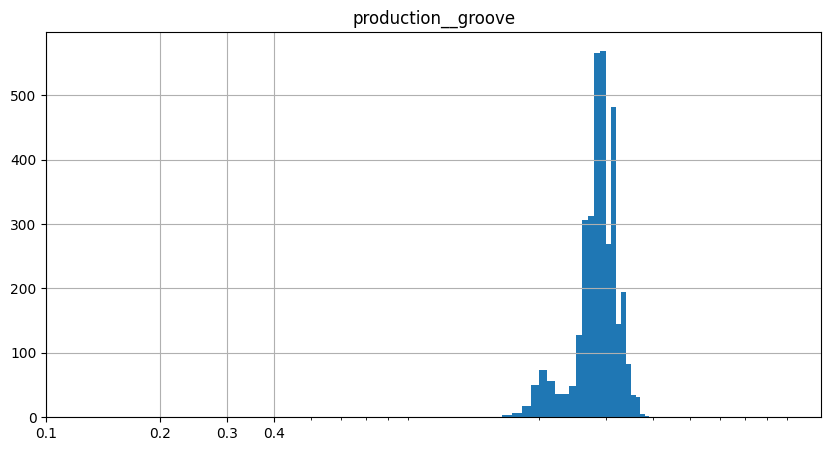

<Figure size 640x480 with 0 Axes>

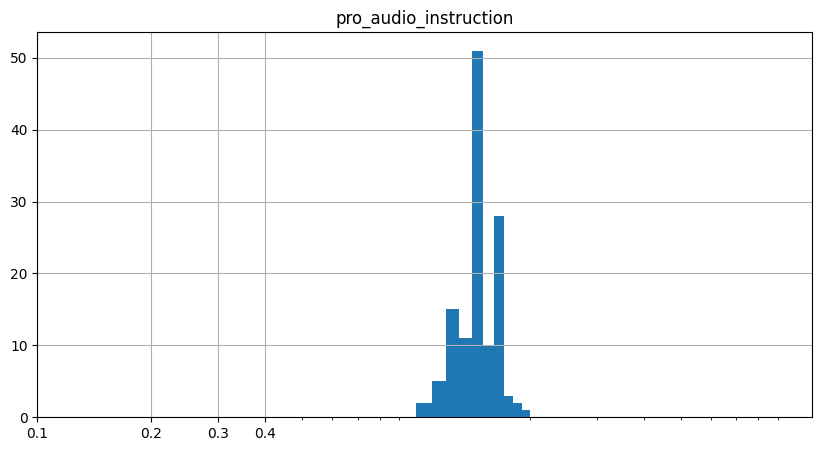

<Figure size 640x480 with 0 Axes>

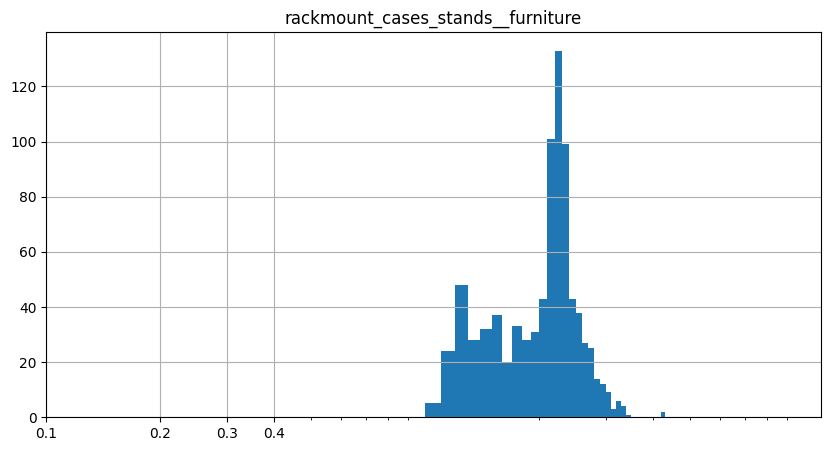

<Figure size 640x480 with 0 Axes>

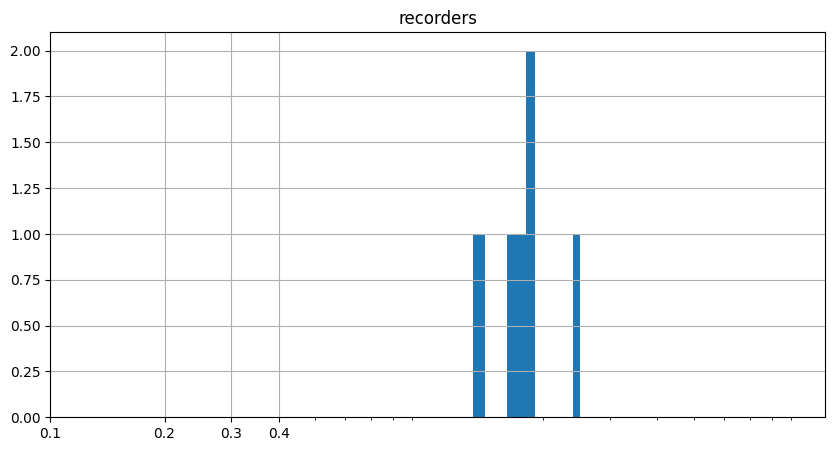

<Figure size 640x480 with 0 Axes>

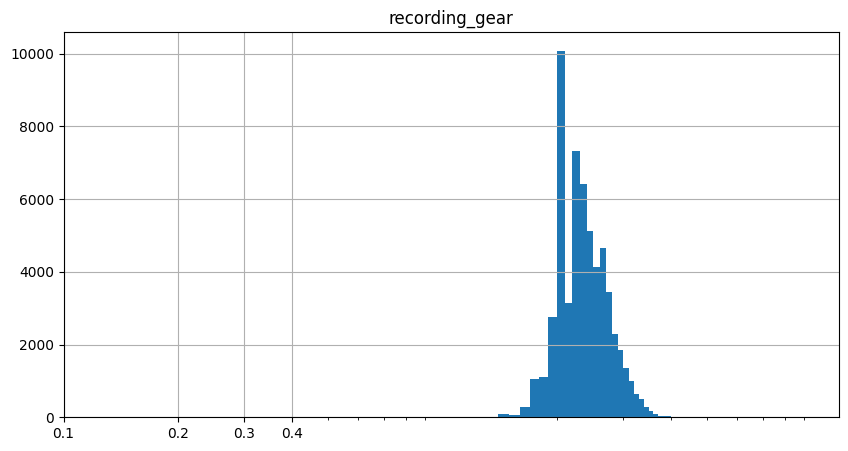

<Figure size 640x480 with 0 Axes>

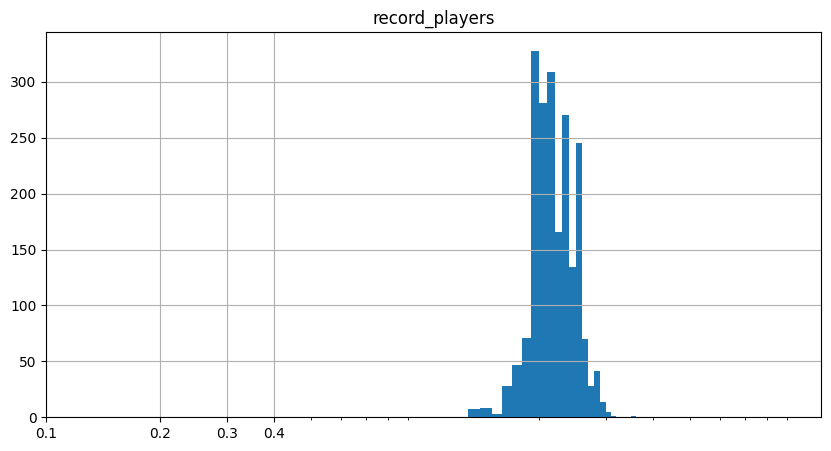

<Figure size 640x480 with 0 Axes>

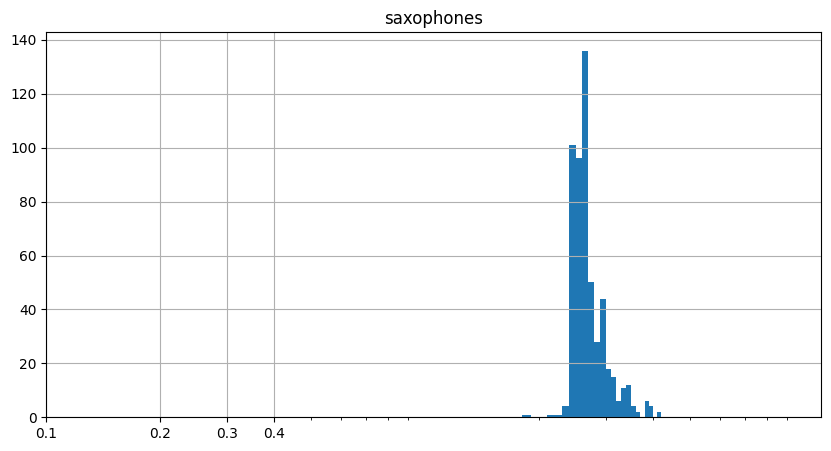

<Figure size 640x480 with 0 Axes>

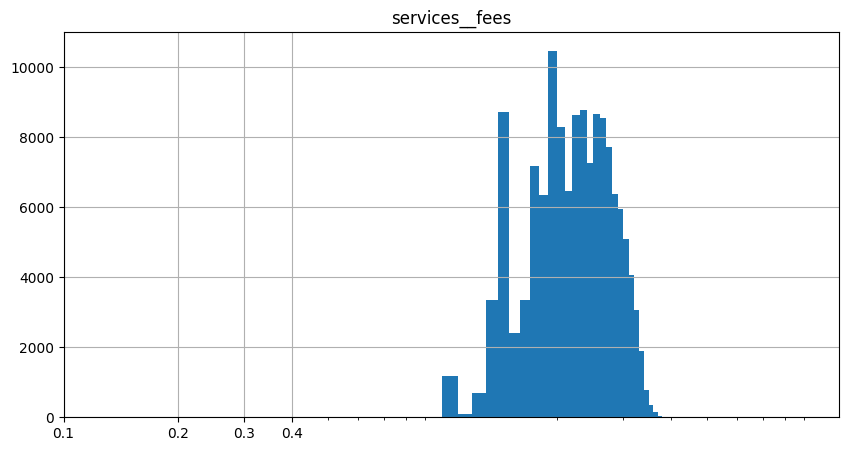

<Figure size 640x480 with 0 Axes>

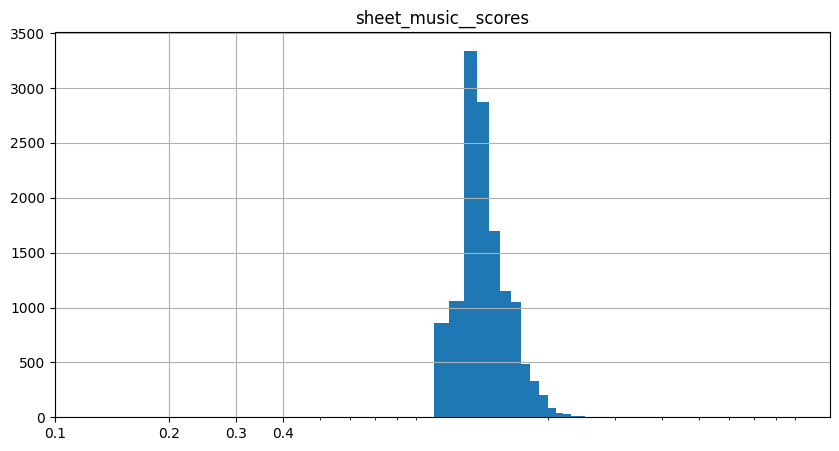

<Figure size 640x480 with 0 Axes>

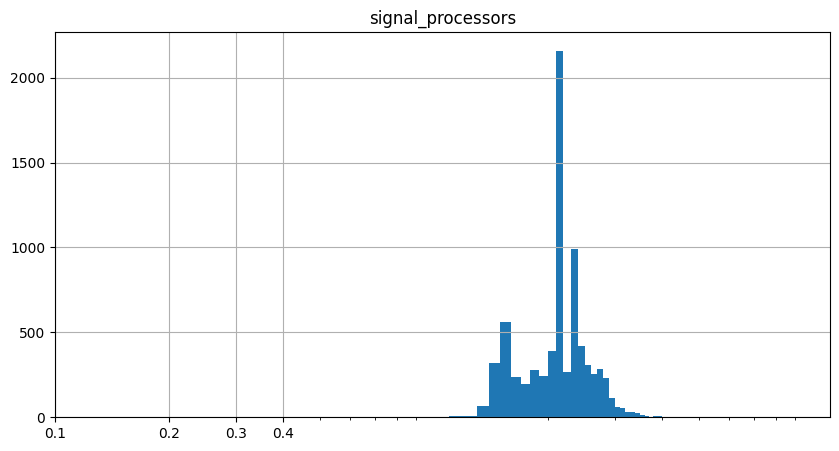

<Figure size 640x480 with 0 Axes>

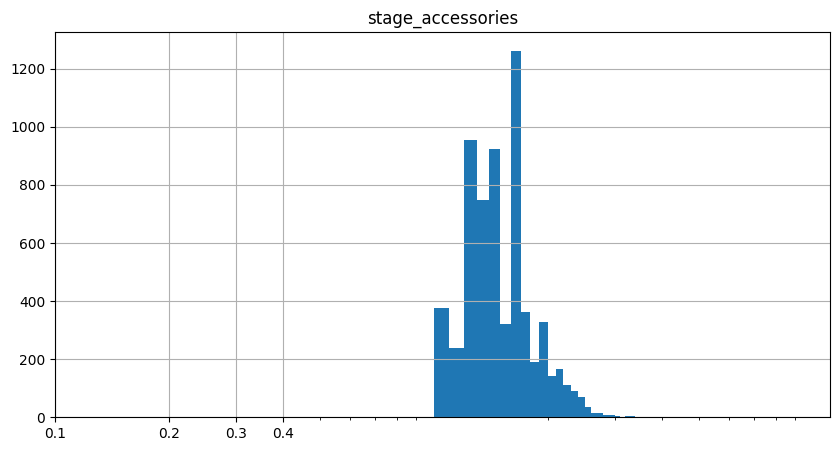

<Figure size 640x480 with 0 Axes>

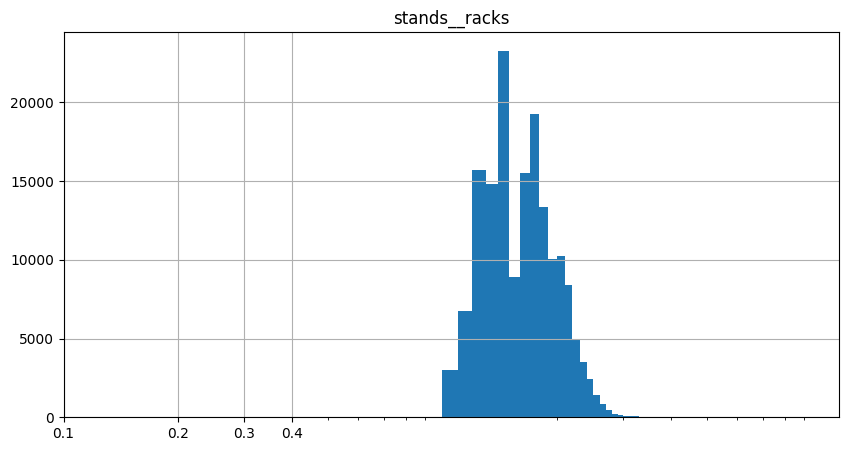

<Figure size 640x480 with 0 Axes>

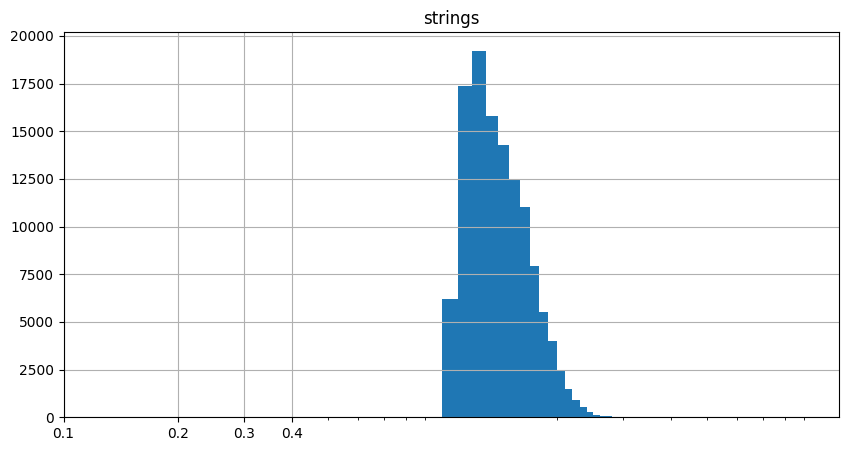

<Figure size 640x480 with 0 Axes>

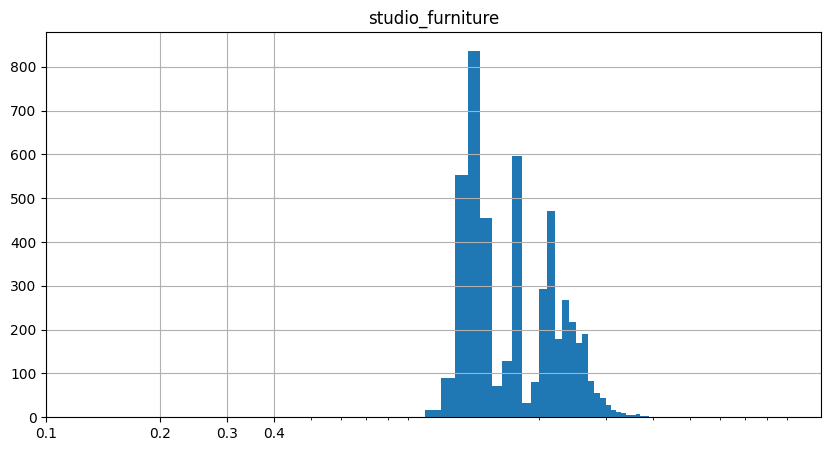

<Figure size 640x480 with 0 Axes>

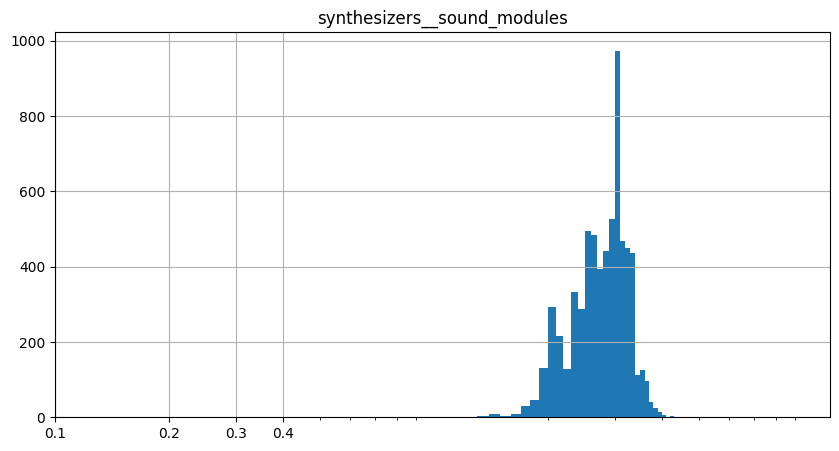

<Figure size 640x480 with 0 Axes>

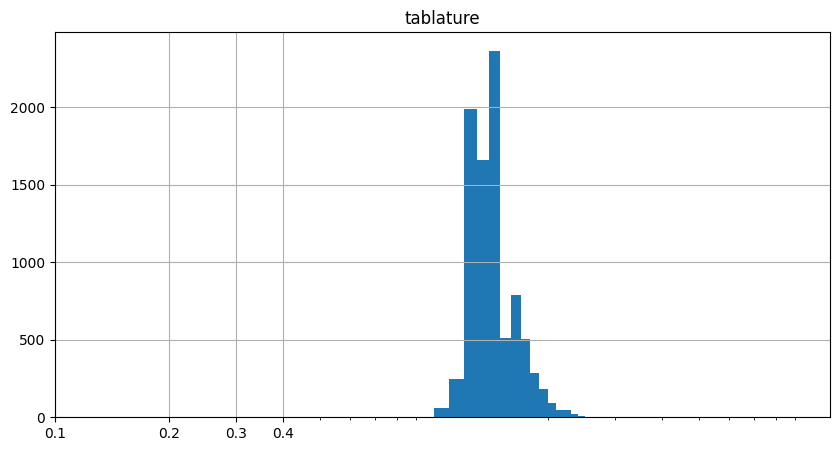

<Figure size 640x480 with 0 Axes>

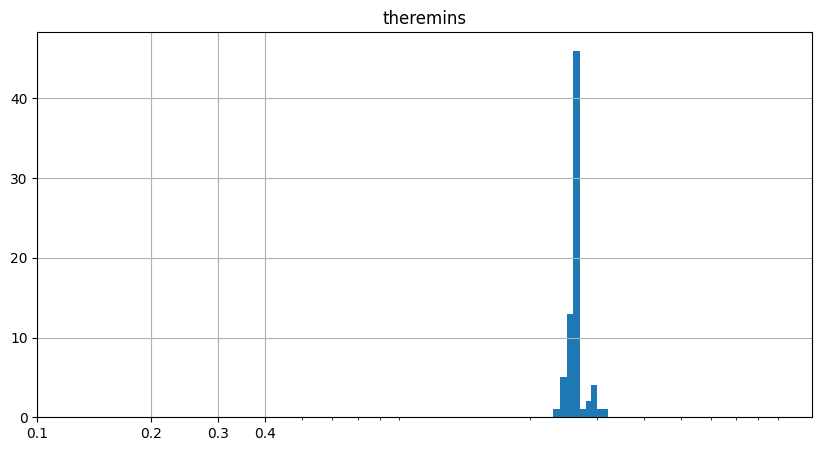

<Figure size 640x480 with 0 Axes>

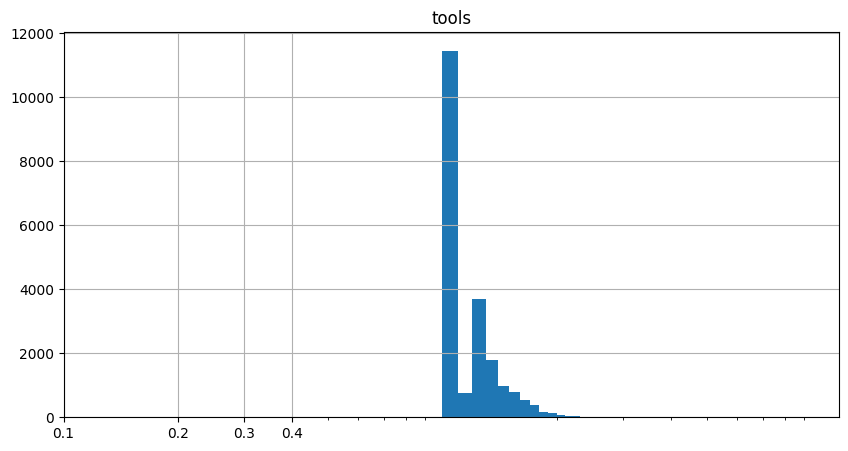

<Figure size 640x480 with 0 Axes>

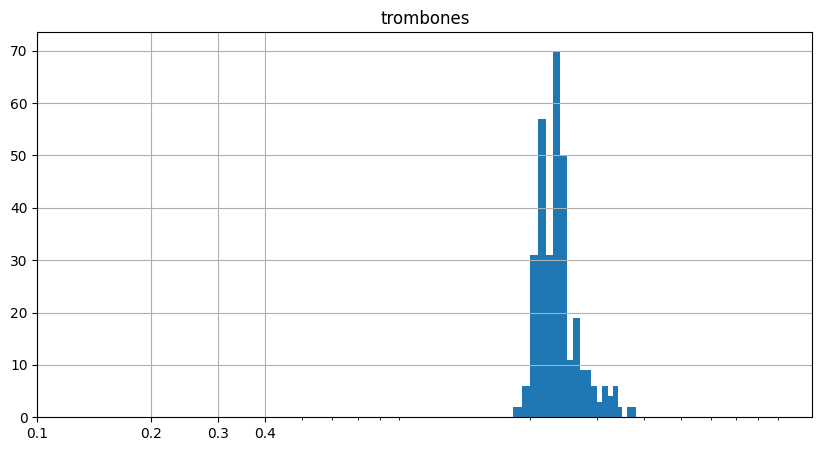

<Figure size 640x480 with 0 Axes>

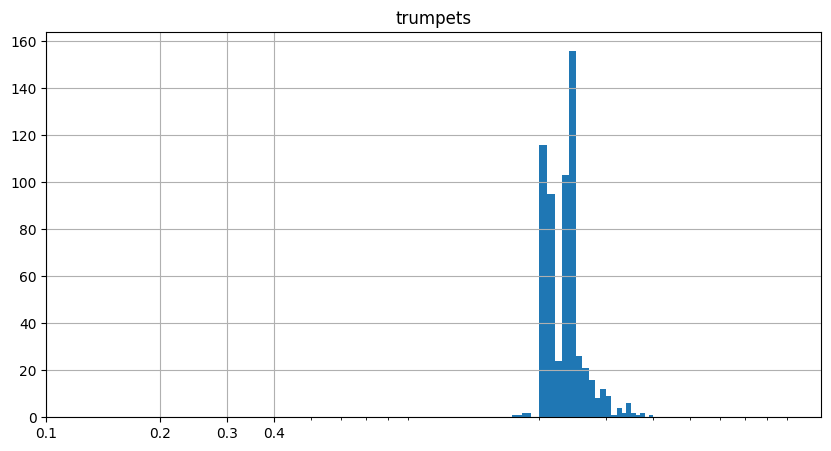

<Figure size 640x480 with 0 Axes>

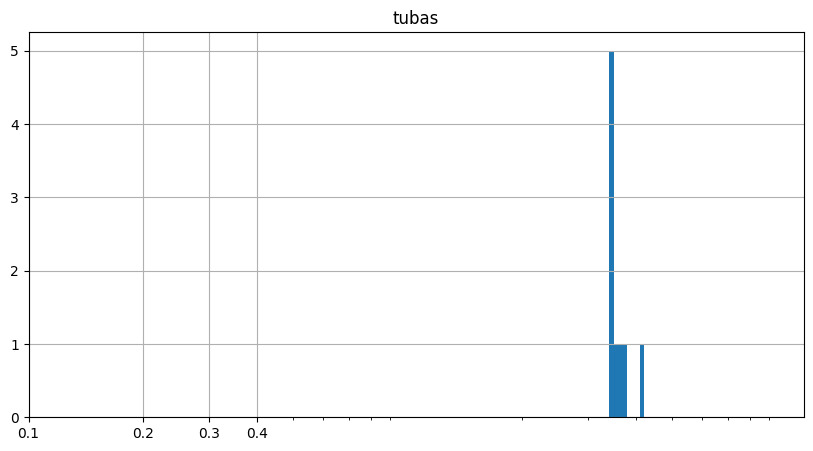

<Figure size 640x480 with 0 Axes>

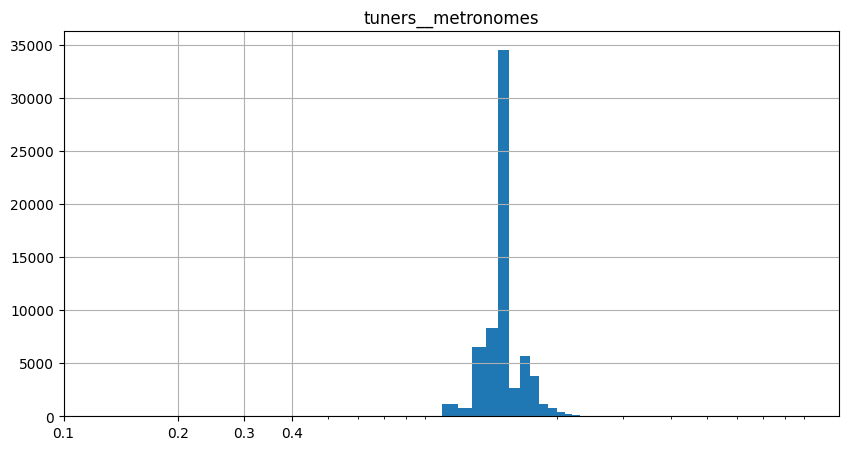

<Figure size 640x480 with 0 Axes>

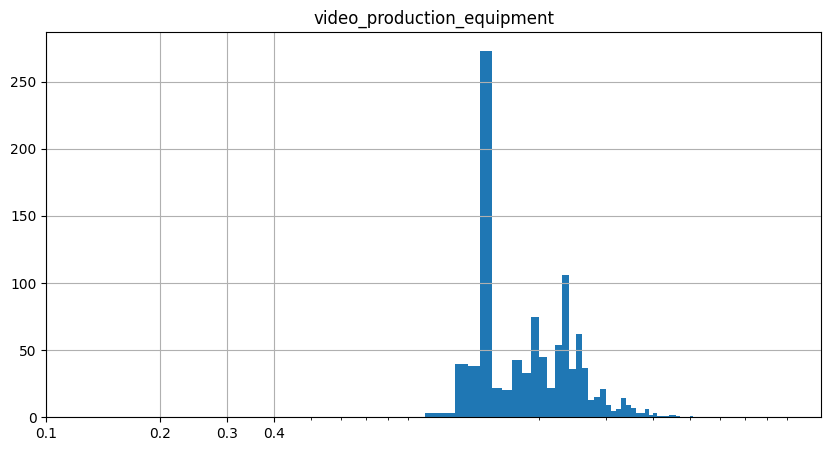

<Figure size 640x480 with 0 Axes>

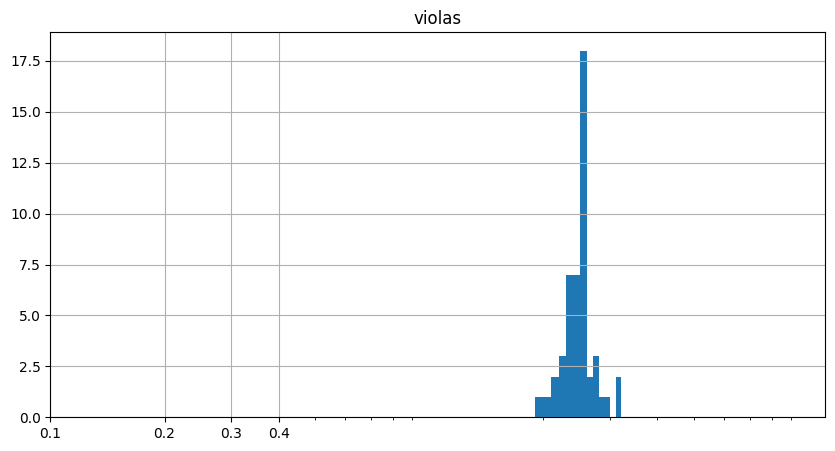

<Figure size 640x480 with 0 Axes>

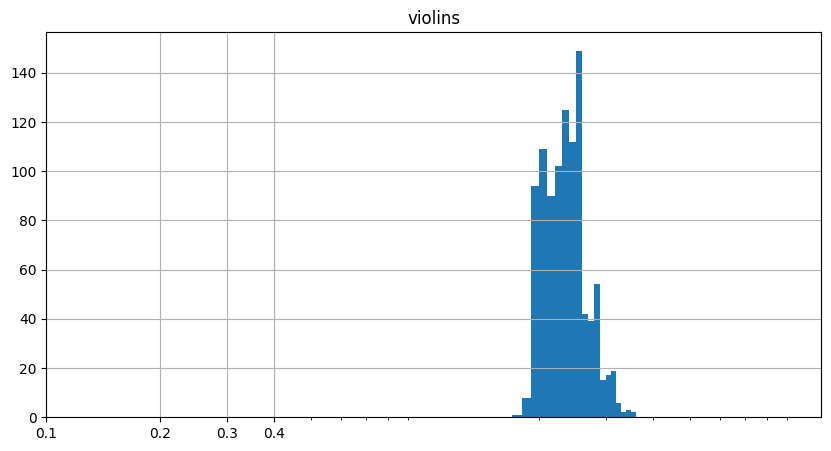

<Figure size 640x480 with 0 Axes>

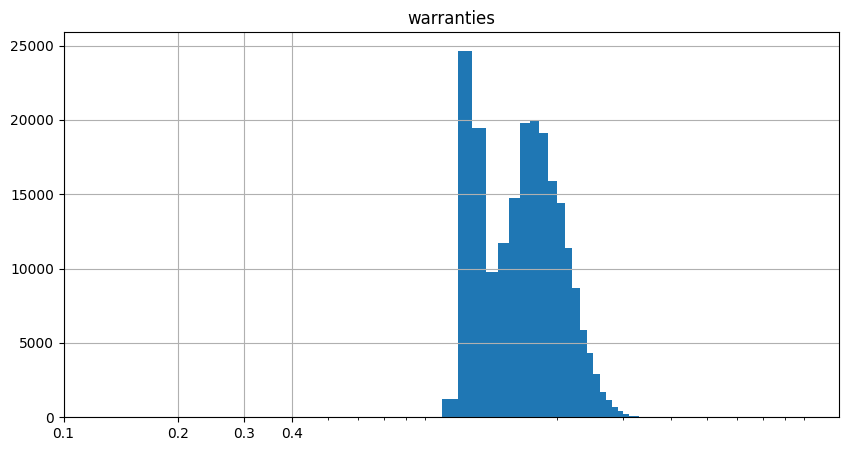

<Figure size 640x480 with 0 Axes>

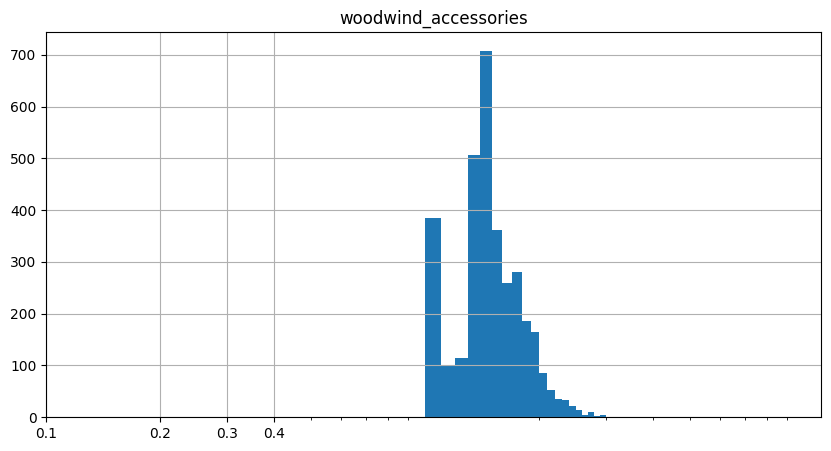

<Figure size 640x480 with 0 Axes>

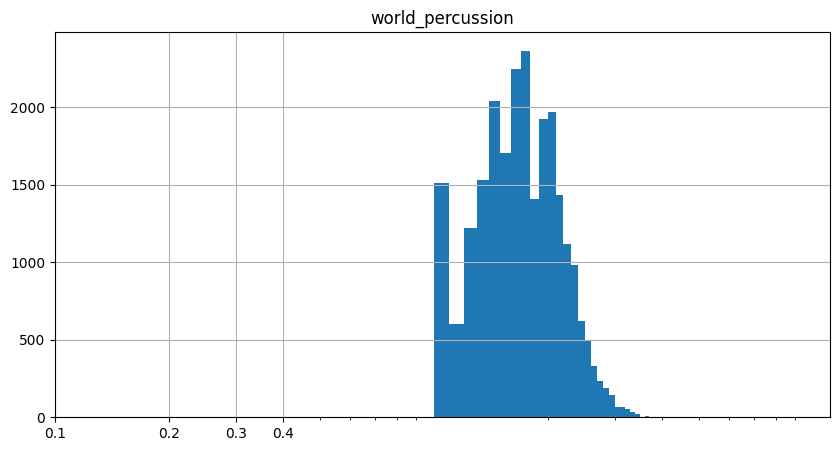

In [ ]:
for column in temp.columns:
    plt.figure();
    bins= np.arange(1,10,0.1)
    ticks=[0.1,0.2,0.3,0.4]
    labels=['{}'.format(v) for v in ticks]
    temp.hist([column],figsize=(10,5), bins=bins);
    plt.xscale('log')
    plt.xticks(ticks,labels);

Check for outliers again

In [ ]:
out=check_ouliers(temp)
out.shape[0]/pdf.shape[0]

0.7287330363122002

In [ ]:
# copy temp data frame numerical columns after log treansformation
pdf[temp.columns]=temp[temp.columns]

In [ ]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585368 entries, 0 to 585367
Columns: 123 entries, cs_active_lesson_flg to world_percussion
dtypes: float64(119), object(4)
memory usage: 549.3+ MB


In [ ]:
#pdf.to_csv('data_cleaned.csv')

Categorical Data Encoding

In [ ]:

le = LabelEncoder()

# Fit the encoder to the categories and transform the categories
pdf[categorical_columns] = pdf[categorical_columns].apply(lambda col: le.fit_transform(col))

# Print the encoded categories
print(pdf[categorical_columns])

        cs_active_lesson_flg  rfm_group_dsc  age_range  gender
0                          0              1          3       2
1                          0              1          3       2
2                          0              1          6       2
3                          0              1          5       1
4                          0              2          3       2
...                      ...            ...        ...     ...
585363                     0              1          6       2
585364                     0              1          6       0
585365                     0              2          6       2
585366                     0              2          6       0
585367                     1              1          3       2

[585368 rows x 4 columns]


#### Apply feature selection

Filtering methods, wrapper methods, and embedded methods.

Correlation Matrix

In [ ]:
corr_matrix=pdf.corr()
corr_matrix

cs_active_lesson_flg  rfm_group_dsc  \
cs_active_lesson_flg                           1.000000      -0.080860   
rfm_group_dsc                                 -0.080860       1.000000   
age_range                                     -0.078124      -0.017675   
gender                                         0.101817      -0.073498   
accessories_for_brass_instruments             -0.008303       0.001448   
...                                                 ...            ...   
violas                                        -0.002141      -0.002782   
violins                                       -0.007651       0.000401   
warranties                                    -0.074983      -0.229670   
woodwind_accessories                          -0.010122       0.009393   
world_percussion                              -0.032283      -0.034999   

                                   age_range    gender  \
cs_active_lesson_flg               -0.078124  0.101817   
rfm_group_dsc                      -0.017675 -0.073498   
age_range                           1.000000  0.334130   
gender                              0.334130  1.000000   
accessories_for_brass_instruments   0.002247 -0.000883   
...                                      ...       ...   
violas                             -0.003584 -0.006599   
violins                            -0.011418 -0.009053   
warranties                          0.039638 -0.009281   
woodwind_accessories                0.005017 -0.004639   
world_percussion                    0.025817 -0.004817   

                                   accessories_for_brass_instruments  \
cs_active_lesson_flg                                       -0.008303   
rfm_group_dsc                                               0.001448   
age_range                                                   0.002247   
gender                                                     -0.000883   
accessories_for_brass_instruments                           1.000000   
...                                                              ...   
violas                                                      0.002815   
violins                                                     0.005669   
warranties                                                  0.003082   
woodwind_accessories                                        0.099733   
world_percussion                                            0.026290   

                                   accessories_for_orchestral_strings  \
cs_active_lesson_flg                                        -0.009305   
rfm_group_dsc                                                0.002656   
age_range                                                    0.003696   
gender                                                      -0.002115   
accessories_for_brass_instruments                            0.040901   
...                                                               ...   
violas                                                       0.036061   
violins                                                      0.172990   
warranties                                                  -0.001174   
woodwind_accessories                                         0.042900   
world_percussion                                             0.020063   

                                   acoustic_bass  acoustic_drums  \
cs_active_lesson_flg                   -0.014714       -0.023607   
rfm_group_dsc                          -0.029818       -0.059436   
age_range                               0.003389       -0.021860   
gender                                  0.004649       -0.022327   
accessories_for_brass_instruments       0.004546        0.005412   
...                                          ...             ...   
violas                                  0.001543        0.001226   
violins                                 0.001963        0.000599   
warranties                              0.028258        0.047449   
woodwind_accessories       

In [ ]:
# get upper triangle of the absolutes correlation matrix
abs_corr_matrix=corr_matrix.abs()
upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(np.bool))


# find features with correlation greater than 0.9

to_drop = [column for column in upper.columns if any(upper[column] > 0.51)]

# drop highly correlated features
print(len(to_drop))
to_drop

1


<ipython-input-19-b8911d26ae24>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(np.bool))


['services__fees']

In [ ]:
#temp=pdf.copy()
#temp.drop(to_drop, axis=1, inplace=True)



Using the variance inflation factor (VIF)

In [ ]:
# calculate VIF for each feature
'''
vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(pdf.values, i) for i in range(pdf.shape[1])]

vif["features"] = pdf.columns

# print VIF values

print(vif)
'''

'\nvif = pd.DataFrame()\n\nvif["VIF Factor"] = [variance_inflation_factor(pdf.values, i) for i in range(pdf.shape[1])]\n\nvif["features"] = pdf.columns\n\n# print VIF values\n\nprint(vif)\n'

K-best

In [ ]:
'''
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import f_regression

# define number of features to keep

k = 10

# perform feature selection

X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)

# get feature names of selected features

selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]

# print selected features

print(selected_features)
'''

#### Data Scaling

one possible side effect of robust scaling is that some of the resulting values may be negative. This can happen if the median of the data is greater than the 25th percentile (i.e., the first quartile) of the data. In this case, subtracting the median from each value will result in some negative values.

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
data_scaled=pdf.copy()
# Scale the data
data_scaled[numerical_cols] = scaler.fit_transform(pdf[numerical_cols])
data_scaled=pd.DataFrame(data_scaled,columns=pdf.columns)
# Print the resulting data
data_scaled.head(1)


cs_active_lesson_flg  rfm_group_dsc  age_range  gender  \
0                     0              1          3       2   

   accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                0.0                                 0.0   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            0.0             0.0                        0.0               0.0   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                0.0         0.0              0.0             0.0   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0             0.0     0.0        1.155954             0.0   

   cases_gig_bags__covers  cds__vinyl  cellos  clarinets  \
0                     0.0         0.0     0.0        0.0   

   classical__nylon_guitars  classroom_aids  classroom_furniture  \
0                  2.681241             0.0                  0.0   

   classroom_musical_instruments  clothing  collectibles  \
0                            0.0       0.0           0.0   

   computers__peripherals  concert_cymbals  concert_drums  \
0                     0.0              0.0            0.0   

   concert_hand__mounted_percussion  concert_mallet_percussion  \
0                               0.0                        0.0   

   connected_home  consumer_electronics_accessories  consumer_speakers  \
0             0.0                               0.0                0.0   

   cornets  cymbals  dj_gear  dj_lifestyle  double_basses  \
0      0.0      0.0      0.0           0.0            0.0   

   double_reed_instruments  drum__percussion_accessories  effects  \
0                      0.0                           0.0      0.0   

   electric_bass  electric_guitars  electric_upright_bass  electronic_drums  \
0       2.399656          2.232971                    0.0               0.0   

   electronic_wind_instruments  en_espanol  euphoniums  exploded_accessories  \
0                          0.0         0.0         0.0                   0.0   

   flugelhorns  flutes__piccolos  folk__traditional_stringed_instruments  \
0          0.0               0.0                                     0.0   

   folk__traditional_wind__keyboard_instruments  footwear  french_horns  \
0                                           0.0       0.0           0.0   

   fretted_instrument_accessories__parts  gongs  guitar_kits  \
0                               1.261727    0.0          0.0   

   guitar_value_packages  harps  hats  headphones  home_furnishings  \
0                    0.0    0.0   0.0         0.0               0.0   

   home_theater_and_devices  ios_devices  jewelry__watches  \
0                       0.0          0.0               0.0   

   keyboard_accessories__parts  keyboard_workstations  \
0                     1.278525                    0.0   

   keyboard__midi_packages  lifestyle_accessories  lighting__stage_effects  \
0                      0.0                    0.0                      0.0   

   live_sound  luggage  marching_band_accessories  marching_percussion  \
0         0.0      0.0                        0.0                  0.0   

   media_storage__memory  mellophones  microphones__wireless_systems  \
0                    0.0          0.0                       0.999565   

       midi  mixers  music_education_for_children  \
0  2.079181     0.0                           0.0   

   music_industry__special_interest  music_software  music_theory__history  \
0                               0.0             0.0                    0.0   

   organs  pa_speaker_parts  performance_instruction  pianos  \
0     0.0               0.0                 1.040998     0.0   

   portable_audio_players  portable__arranger_keyboards  power__batteries  \
0                     0.0                           0.0               0.0   

   practice__performance_aids  production__groove  pro_audio_instruction  \
0                         0.0                

In [ ]:
data_scaled.to_csv('data_scaled.csv')

## 2. Modeling

In [ ]:
file_id = '1Aj-BUzMR63PcggAaRnDODyGJOfwi8yUg' #<-- You add in here the id from you google drive file, you can find it

download = drive.CreateFile({'id': file_id})
download.GetContentFile('data_scaled.csv')

# create a SparkSession object
spark = SparkSession.builder.appName("Segmentation Modeling").config("spark.driver.memory", "20g").getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# read a CSV file
sdf = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("data_scaled.csv")


In [ ]:
features = sdf.columns[1:]

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features")

assembled_data = assembler.transform(sdf)


assembled_data.show(10)

+---+--------------------+-------------+---------+------+---------------------------------+----------------------------------+-------------+--------------+-------------------------+------------------+-----------------+------------------+---------------+--------------+--------------+------+------------------+--------------+----------------------+----------+------+---------+------------------------+--------------+-------------------+-----------------------------+--------+------------+----------------------+---------------+-------------+--------------------------------+-------------------------+--------------+--------------------------------+-----------------+-------+-----------------+-------+------------+-------------+-----------------------+----------------------------+-----------------+-----------------+------------------+---------------------+------------------+---------------------------+----------+----------+--------------------+-----------+----------------+-------------------------

#### Dimensionality Reduction:

Visualize data in 3 dimension

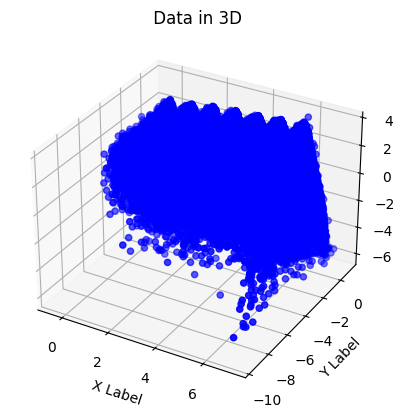

In [ ]:
rows=assembled_data.count()
k=3
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(assembled_data)
components = pca_model.transform(assembled_data).select("pcaFeatures").collect()
components=np.array(components).reshape(rows, k)
pdf = pd.DataFrame(components)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(pdf.iloc[:,0], pdf.iloc[:,1], pdf.iloc[:,2], c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title(" Data in 3D")
plt.show()

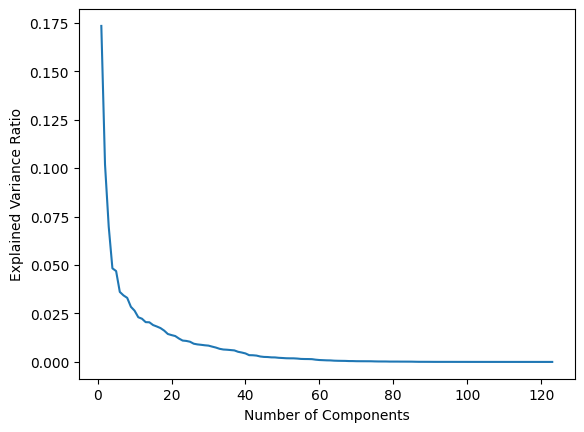

In [ ]:
cols=len(assembled_data.columns)-2
# plot the explained variance ration
pca = PCA(k=cols, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(assembled_data)

# plot the explained variance ratio as a function of the number of components
plt.plot(range(1, cols+1), model.explainedVariance.toArray())
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [ ]:
k=15
rows=assembled_data.count()

pca = PCA(k=k, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(assembled_data)
components = pca_model.transform(assembled_data).select("pcaFeatures").collect()
components=np.array(components).reshape(rows, k)

In [ ]:

components_df = spark.createDataFrame(data=components)
features = components_df.columns[1:]

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features")

assembled_data = assembler.transform(components_df)
assembled_data.show(truncate=False)


+------------------+---------------------+--------------------+--------------------+--------------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_1                |_2                   |_3                  |_4                  |_5                  |_6                   |_7                  |_8                   |_9                   |_10                  |_11                 |_12                |_13                 |_14                 |_15                 |features                                                                       

In [ ]:
# drop the features column
#assembled_data = assembled_data.drop("features")

### K-means clustering

In [ ]:
# Define the KMeans model
'''

kmeans = KMeans()

# Define the hyperparameter grid to search over
paramGrid = ParamGridBuilder() \
    .addGrid(kmeans.k, [5]) \
    .addGrid(kmeans.maxIter, [10, 20, 30]) \
    .addGrid(kmeans.initMode, ['k-means||', 'random']) \
    .addGrid(kmeans.initSteps, [2, 5]) \
    .build()

# Define the evaluation metric to use
evaluator = ClusteringEvaluator(metricName="silhouette", distanceMeasure="squaredEuclidean")

# Define the cross-validation object
cv = CrossValidator(estimator=kmeans, estimatorParamMaps=paramGrid, evaluator=evaluator)

# Train the model
model = cv.fit(assembled_data)

# Make predictions on the test data
predictions = model.transform(assembled_data)

# Evaluate the model using the evaluation metric
silhouette = evaluator.evaluate(predictions)

# Print the best hyperparameters found during tuning
print("Best hyperparameters: ", model.bestModel.extractParamMap())

# Print the silhouette score
print("Silhouette score: ", silhouette)
'''

According to that tuning takes extensive running time, however the starting point determines the model performance.
Instead of tuning we set a seed to save the best results and try the algorithm many time until we get a good starting point.


Text(0, 0.5, 'cost')

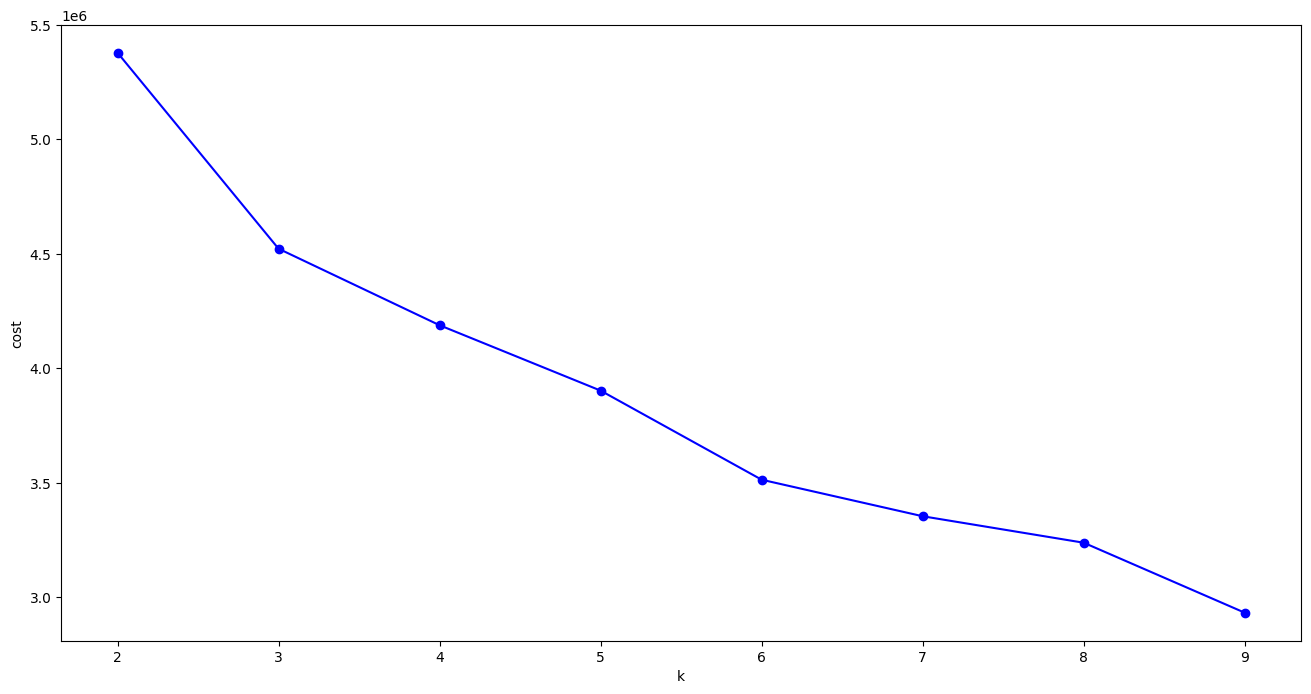

In [ ]:

costs = {}

for k in range(2, 10):
    k_means = KMeans(featuresCol='features', k=k,seed=1)
    model = k_means.fit(assembled_data)
    costs[k] = model.summary.trainingCost
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot(costs.keys(), costs.values(), '-ob')
ax.set_xlabel('k')
ax.set_ylabel('cost')

# ax.plot(3, costs[3], 'bo')

In [ ]:
k_means = KMeans(featuresCol='features', k=5,seed=1)
model = k_means.fit(assembled_data)
predictions = model.transform(assembled_data)
result = predictions.select('features','prediction')
result.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-2.1504364672472...|         1|
|[-1.8730001975068...|         1|
|[0.04123604879456...|         0|
|[-1.3857934388673...|         0|
|[-2.3315160607283...|         1|
|[-1.9243922844886...|         4|
|[0.56813648635546...|         3|
|[-0.2030303326460...|         0|
|[0.38628816287262...|         3|
|[-0.0437898833286...|         0|
|[0.53413137999564...|         0|
|[-1.1950702757690...|         2|
|[-3.8670717568431...|         1|
|[-7.9886280386635...|         1|
|[0.19716004727412...|         3|
|[-0.5834092952916...|         0|
|[-0.6081504425217...|         0|
|[-0.5679336684437...|         2|
|[0.00293344860004...|         3|
|[-2.0138046932662...|         0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
# evaluate clustering by computing Silhouette score
silhouette(predictions)


silhouette score =  0.31076224222351795


Model Visualization

In [ ]:
#reduce the number of partitions to 1 and convert the entire DataFrame to a Pandas DataFrame.
result_df=result.coalesce(1).toPandas()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [ ]:

file_id = '1DFiKulPzAaP2-3j4jHeV6n6EcITmd8oZ' #<-- You add in here the id from you google drive file, you can find it

download = drive.CreateFile({'id': file_id})

# Download the file to a local disc
download.GetContentFile('data_cleaned.csv')


pdf = pd.read_csv('data_cleaned.csv')



In [171]:
#pdf.dropna(inplace=True)
result_combined = result_df.join( pdf)


In [172]:
result_combined.head()

features  prediction  Unnamed: 0  \
0  [-2.1504364672472884, -0.39858171912702667, -0...           1           0   
1  [-1.8730001975068404, 1.0038361424957947, 0.16...           1           1   
2  [0.041236048794561636, 0.5760119108476686, 0.1...           0           2   
3  [-1.385793438867378, 0.0643975765655089, -0.16...           0           3   
4  [-2.331516060728321, 1.1352550274286393, 0.389...           1           4   

  cs_active_lesson_flg rfm_group_dsc age_range   gender  \
0                    N        01-VIP     45-54  Unknown   
1                    N        01-VIP     45-54  Unknown   
2                    N        01-VIP       OOR  Unknown   
3                    N        01-VIP       65+     Male   
4                    N   02-Loyalist     45-54  Unknown   

   accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                0.0                                 0.0   
1                                0.0                                 0.0   
2                                0.0                                 0.0   
3                                0.0                                 0.0   
4                                0.0                                 0.0   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            0.0             0.0                        0.0               0.0   
1            0.0             0.0                        0.0               0.0   
2            0.0             0.0                        0.0               0.0   
3            0.0             0.0                        0.0               0.0   
4            0.0             0.0                        0.0               0.0   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                0.0        0.00              0.0             0.0   
1                0.0        0.00              0.0             0.0   
2                0.0        0.00              0.0             0.0   
3                0.0      129.99              0.0             0.0   
4                0.0        0.00              0.0             0.0   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0             0.0     0.0           51.94             0.0   
1             0.0     0.0            0.00             0.0   
2             0.0     0.0            0.00             0.0   
3             0.0     0.0           24.99             0.0   
4             0.0     0.0            0.00             0.0   

   cases_gig_bags__covers  cds__vinyl  cellos  clarinets  \
0                     0.0         0.0     0.0        0.0   
1                     0.0         0.0     0.0        0.0   
2                     0.0         0.0     0.0        0.0   
3                     0.0         0.0     0.0        0.0   
4                     0.0         0.0     0.0        0.0   

   classical__nylon_guitars  classroom_aids  classroom_furniture  \
0                     479.0             0.0                  0.0   
1                       0.0             0.0                  0.0   
2                       0.0             0.0                  0.0   
3                       0.0             0.0                  0.0   
4                       0.0             0.0                  0.0   

   classroom_musical_instruments  clothing  collectibles  \
0                            0.0       0.0           0.0   
1                            0.0       0.0           0.0   
2                            0.0       0.0           0.0   
3                            0.0       0.0           0.0   
4                            0.0       0.0           0.0   

   computers__peripherals  concert_cymbals  concert_drums  \
0                     0.0              0.0            0.0   
1                     0.0              0.0            0.0   
2                     0.0              0.0            0.0   
3                     0.0              0.0            0.0   
4                     0.0              0.0    

In [173]:
result_combined.dropna(inplace=True)

In [174]:
result_combined.drop(['Unnamed: 0'],inplace=True,axis=1)


In [175]:
result_combined.drop(['features'],inplace=True,axis=1)


In [176]:
result_combined['classes']=result_combined['prediction'].replace([0,1,2,3,4], ['class1','class2','class3','class4','class5'])
result_combined.head(10)

prediction cs_active_lesson_flg rfm_group_dsc age_range   gender  \
0           1                    N        01-VIP     45-54  Unknown   
1           1                    N        01-VIP     45-54  Unknown   
2           0                    N        01-VIP       OOR  Unknown   
3           0                    N        01-VIP       65+     Male   
4           1                    N   02-Loyalist     45-54  Unknown   
5           4                    N        01-VIP     35-44     Male   
6           3                    N        01-VIP     45-54     Male   
7           0                    N        01-VIP       65+  Unknown   
8           3                    N   02-Loyalist       OOR  Unknown   
9           0                    N  03-Potential       OOR  Unknown   

   accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                0.0                                 0.0   
1                                0.0                                 0.0   
2                                0.0                                 0.0   
3                                0.0                                 0.0   
4                                0.0                                 0.0   
5                                0.0                                 0.0   
6                                0.0                                 0.0   
7                                0.0                                 0.0   
8                                0.0                                 0.0   
9                                0.0                                 0.0   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            0.0             0.0                       0.00              0.00   
1            0.0             0.0                       0.00              0.00   
2            0.0             0.0                       0.00              0.00   
3            0.0             0.0                       0.00              0.00   
4            0.0             0.0                       0.00              0.00   
5            0.0             0.0                    2330.15              0.00   
6            0.0             0.0                       0.00              0.00   
7            0.0             0.0                       0.00            399.00   
8            0.0             0.0                       0.00              0.00   
9            0.0             0.0                       0.00            129.99   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                0.0        0.00              0.0             0.0   
1                0.0        0.00              0.0             0.0   
2                0.0        0.00              0.0             0.0   
3                0.0      129.99              0.0             0.0   
4                0.0        0.00              0.0             0.0   
5                0.0      199.00              0.0             0.0   
6                0.0        0.00              0.0             0.0   
7                0.0        0.00              0.0             0.0   
8                0.0        0.00              0.0             0.0   
9                0.0        0.00              0.0             0.0   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0             0.0     0.0           51.94             0.0   
1             0.0     0.0            0.00             0.0   
2             0.0     0.0            0.00             0.0   
3             0.0     0.0           24.99             0.0   
4             0.0     0.0            0.00             0.0   
5             0.0     0.0            0.00             0.0   
6             0.0     0.0            0.00             0.0   
7             0.0     0.0            0.00             0.0   
8             0.0     0.0            0.00             0.0   
9             0.0     0.0            0.00             0.0   

   cases_gig_bags__covers  cds__vinyl  cellos  clarinets  \


In [177]:
result_combined['Sum_Purchases']=result_combined.iloc[:,5:-1].sum(skipna=True,axis=1)

In [178]:
result_combined.head()

prediction cs_active_lesson_flg rfm_group_dsc age_range   gender  \
0           1                    N        01-VIP     45-54  Unknown   
1           1                    N        01-VIP     45-54  Unknown   
2           0                    N        01-VIP       OOR  Unknown   
3           0                    N        01-VIP       65+     Male   
4           1                    N   02-Loyalist     45-54  Unknown   

   accessories_for_brass_instruments  accessories_for_orchestral_strings  \
0                                0.0                                 0.0   
1                                0.0                                 0.0   
2                                0.0                                 0.0   
3                                0.0                                 0.0   
4                                0.0                                 0.0   

   acoustic_bass  acoustic_drums  acoustic_electric_guitars  acoustic_guitars  \
0            0.0             0.0                        0.0               0.0   
1            0.0             0.0                        0.0               0.0   
2            0.0             0.0                        0.0               0.0   
3            0.0             0.0                        0.0               0.0   
4            0.0             0.0                        0.0               0.0   

   alto__tenor_horns  amplifiers  amplifier_parts  audio_playback  \
0                0.0        0.00              0.0             0.0   
1                0.0        0.00              0.0             0.0   
2                0.0        0.00              0.0             0.0   
3                0.0      129.99              0.0             0.0   
4                0.0        0.00              0.0             0.0   

   baritone_horns  bugles  cables__snakes  care__cleaning  \
0             0.0     0.0           51.94             0.0   
1             0.0     0.0            0.00             0.0   
2             0.0     0.0            0.00             0.0   
3             0.0     0.0           24.99             0.0   
4             0.0     0.0            0.00             0.0   

   cases_gig_bags__covers  cds__vinyl  cellos  clarinets  \
0                     0.0         0.0     0.0        0.0   
1                     0.0         0.0     0.0        0.0   
2                     0.0         0.0     0.0        0.0   
3                     0.0         0.0     0.0        0.0   
4                     0.0         0.0     0.0        0.0   

   classical__nylon_guitars  classroom_aids  classroom_furniture  \
0                     479.0             0.0                  0.0   
1                       0.0             0.0                  0.0   
2                       0.0             0.0                  0.0   
3                       0.0             0.0                  0.0   
4                       0.0             0.0                  0.0   

   classroom_musical_instruments  clothing  collectibles  \
0                            0.0       0.0           0.0   
1                            0.0       0.0           0.0   
2                            0.0       0.0           0.0   
3                            0.0       0.0           0.0   
4                            0.0       0.0           0.0   

   computers__peripherals  concert_cymbals  concert_drums  \
0                     0.0              0.0            0.0   
1                     0.0              0.0            0.0   
2                     0.0              0.0            0.0   
3                     0.0              0.0            0.0   
4                     0.0              0.0            0.0   

   concert_hand__mounted_percussion  concert_mallet_percussion  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0                        0.0   
3                               0.0                        0.0   
4                     

In [180]:
sum_purchase.sort_values(ascending=False,by='Sum of Purchases')

index  Sum of Purchases
41           electric_guitars       97733344.32
70                 live_sound       63651967.67
98             services__fees       56742408.05
4   acoustic_electric_guitars       49637883.64
7                  amplifiers       43943852.05
..                        ...               ...
45                 en_espanol            642.09
94                  recorders            555.20
6           alto__tenor_horns            511.15
35               dj_lifestyle            419.99
11                     bugles             79.90

[119 rows x 2 columns]

<ipython-input-181-0744934f347c>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



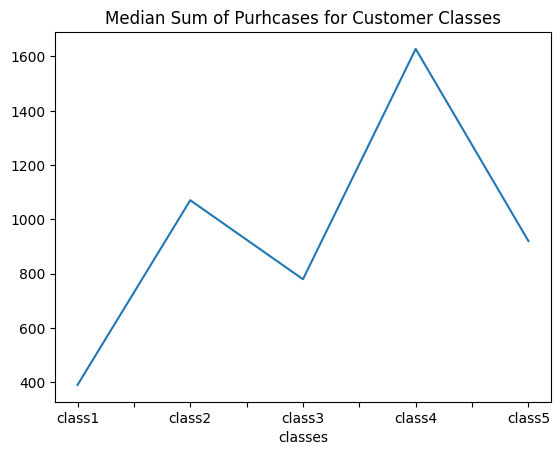

In [181]:
result_combined.groupby(['classes']).median()['Sum_Purchases'].plot();
plt.title('Median Sum of Purhcases for Customer Classes');

In [ ]:
# get the data frame that already have purchased values


In [ ]:
#combined_result.write.format('csv').option('header','true').mode('overwrite').save('combined_result.csv')
#combined_result_df=pd.read_csv('combined_result.csv')
# takes 40 minutes in runtime
#combined_result_df = combined_result.toPandas()

Text(0.5, 1.0, 'Clusters Histogram')

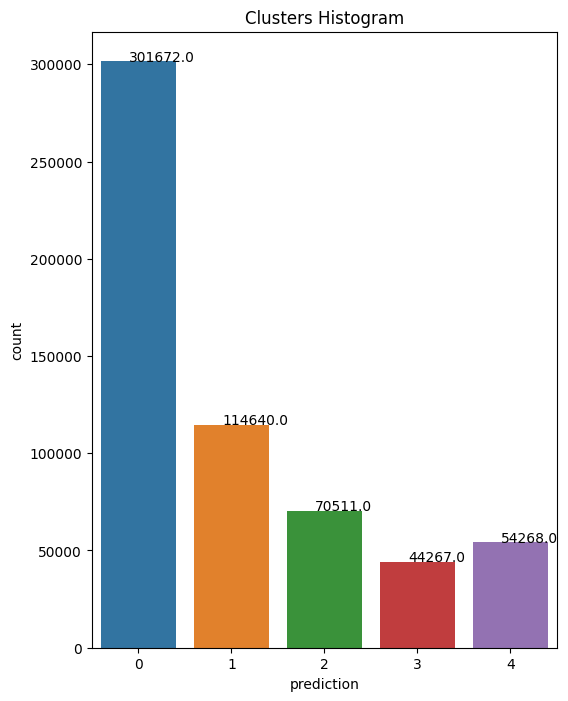

In [167]:

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=result_combined)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))
plt.title('Clusters Histogram')

<Axes: xlabel='gender', ylabel='Count'>

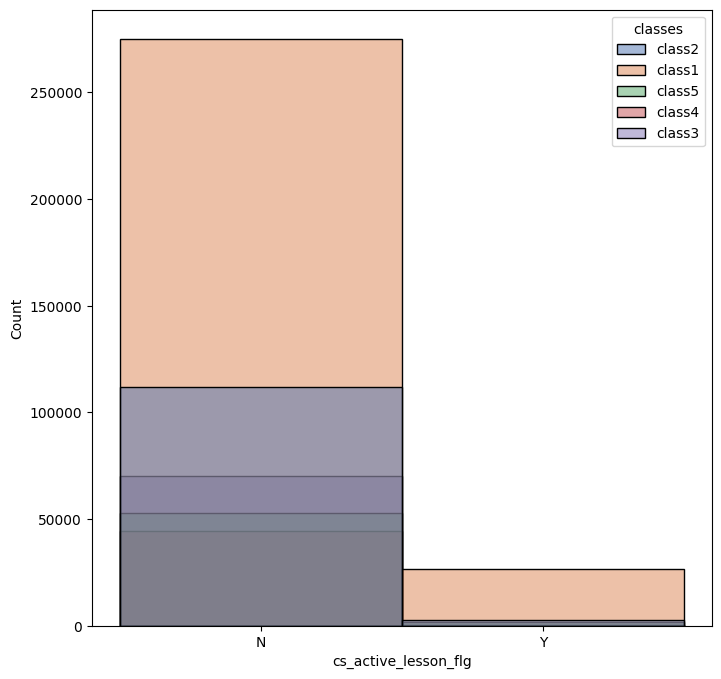

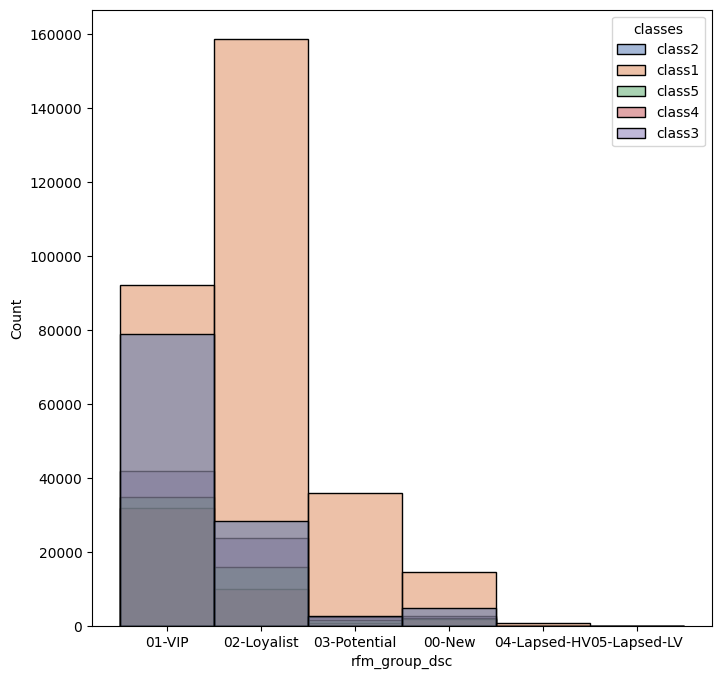

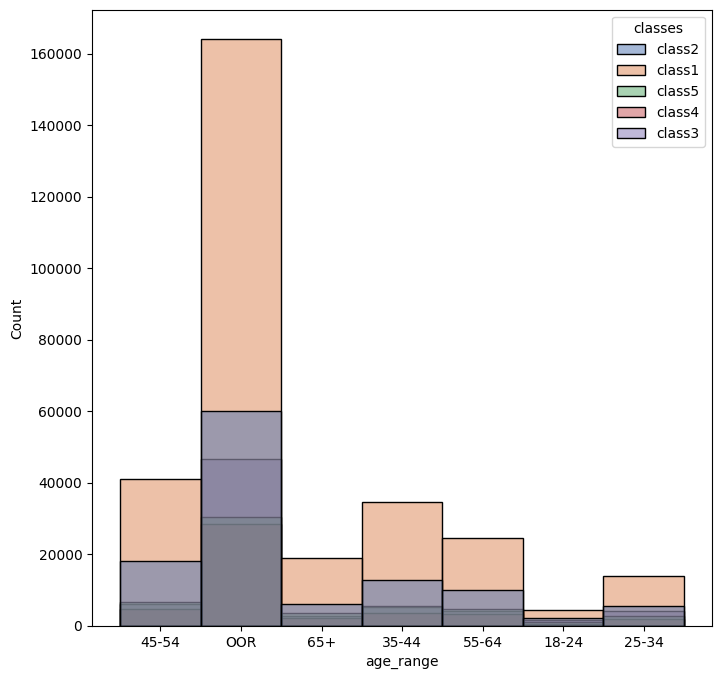

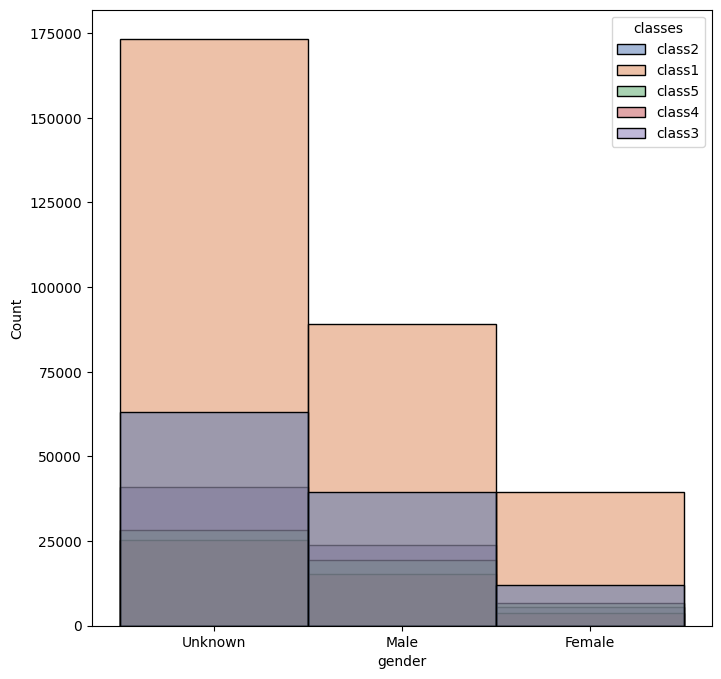

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(x='cs_active_lesson_flg', data=result_combined, hue='classes', palette="deep")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(x='rfm_group_dsc', data=result_combined, hue='classes', palette="deep")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(x='age_range', data=result_combined, hue='classes', palette="deep")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.histplot(x='gender', data=result_combined, hue='classes', palette="deep")


In [190]:
plt.figure(figsize=(20,40))
sum_purchase=result_combined.iloc[:,5:-2].sum().to_frame(name='Sum of Purchases').reset_index()

fig = px.scatter(sum_purchase, x='index', y='Sum of Purchases', labels={'x': 'X Axis', 'y': 'Y Axis'})

fig.show()

<Figure size 2000x4000 with 0 Axes>

In [225]:

sum_purchase_gb=result_combined.groupby(['classes']).sum().reset_index()

sum_purchase_gb.drop(['Sum_Purchases','prediction'],axis=1,inplace=True)
sum_purchase_gb

<ipython-input-225-47e849c69deb>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



classes  accessories_for_brass_instruments  \
0  class1                           28991.19   
1  class2                            8286.30   
2  class3                            5000.08   
3  class4                            1786.88   
4  class5                            3068.48   

   accessories_for_orchestral_strings  acoustic_bass  acoustic_drums  \
0                            59609.80      744428.88      6887695.72   
1                            11689.96      209216.08      1340995.97   
2                             8478.85       71492.22       756985.81   
3                             5208.82       50690.53       781520.81   
4                             5468.89      272088.48       404310.80   

   acoustic_electric_guitars  acoustic_guitars  alto__tenor_horns  \
0                     935.48        9461647.25             511.15   
1                 6867623.72        3453629.55               0.00   
2                  410589.63         628781.24               0.00   
3                  678970.92         301949.80               0.00   
4                41679763.89        3830055.17               0.00   

    amplifiers  amplifier_parts  audio_playback  baritone_horns  bugles  \
0  12594628.62        164260.52        95887.59         6013.95   39.95   
1  25452413.94         39348.98         4045.49            0.00   39.95   
2   2044097.00          8166.57       118886.18            0.00    0.00   
3   1168573.73          2629.27        57942.30            0.00    0.00   
4   2684138.76          3714.32         2741.93            0.00    0.00   

   cables__snakes  care__cleaning  cases_gig_bags__covers  cds__vinyl  \
0      3764337.10       168084.61              4136871.12   215175.87   
1      3235342.31       212141.08              4621476.72   120760.61   
2      4500991.33        23442.55               674076.79    45598.35   
3      4843230.80         8907.34               906383.29    13073.19   
4       728283.01        76087.65              1999960.02    27518.15   

     cellos  clarinets  classical__nylon_guitars  classroom_aids  \
0  49515.80   92966.69                3104352.61         1783.26   
1  27792.29    8057.72                 982342.80           19.28   
2  10535.14    2796.31                 289427.90          409.54   
3   7479.58    5920.32                 173663.93           31.24   
4   8588.73    8330.91                 856992.79            0.00   

   classroom_furniture  classroom_musical_instruments   clothing  \
0              1898.95                       78684.69  106784.79   
1               428.99                       18529.98  103371.90   
2                 0.00                       19410.95   13719.87   
3              6109.71                       12125.03    6657.19   
4                 9.99                        7587.94   27363.40   

   collectibles  computers__peripherals  concert_cymbals  concert_drums  \
0     136494.47               142611.52          3743.87       60493.94   
1     123244.45                51866.63            29.99        7811.64   
2      21597.24               432736.98           630.00        3296.63   
3       8845.85               292677.55          1069.89        2193.95   
4      25923.10                17354.71             0.00        3188.85   

   concert_hand__mounted_percussion  concert_mallet_percussion  \
0                           7767.58                   37702.98   
1                           1160.69                     666.99   
2                           1663.47                    2040.00   
3                            706.62                    1183.02   
4                            431.66                       0.00   

   connected_home  consumer_electronics_accessories  consumer_speakers  \
0         1039.04                           3544.45          101839.31   
1          114.39                            239.99           28479.90   
2           52.00                          11156.46           48945.23   
3        2254

In [236]:
sum_purchase_gb[sum_purchase_gb['classes']=='class1'].drop('classes',axis=1).T

0
accessories_for_brass_instruments     28991.19
accessories_for_orchestral_strings    59609.80
acoustic_bass                        744428.88
acoustic_drums                      6887695.72
acoustic_electric_guitars               935.48
...                                        ...
violas                                12250.24
violins                              234579.14
warranties                          3932237.24
woodwind_accessories                 111052.88
world_percussion                    1686080.02

[119 rows x 1 columns]

In [242]:
class_sum_purchase_gb

index           0
0     accessories_for_brass_instruments    28991.19
1    accessories_for_orchestral_strings    59609.80
2                         acoustic_bass   744428.88
3                        acoustic_drums  6887695.72
4             acoustic_electric_guitars      935.48
..                                  ...         ...
114                              violas    12250.24
115                             violins   234579.14
116                          warranties  3932237.24
117                woodwind_accessories   111052.88
118                    world_percussion  1686080.02

[119 rows x 2 columns]

In [261]:
class_sum_purchase_gb=sum_purchase_gb[sum_purchase_gb['classes']=='class1'].drop('classes',axis=1).T.rename_axis('index').reset_index()
class_sum_purchase_gb = class_sum_purchase_gb.rename(columns={0: 'Sum of Purchases'})
fig = px.scatter(class_sum_purchase_gb, x='index', y='Sum of Purchases', labels={'x': 'X Axis', 'y': 'Y Axis'})
fig.show()

In [262]:
class_sum_purchase_gb.sort_values(ascending=False, by='Sum of Purchases' )

index  Sum of Purchases
98                    services__fees       45591843.01
7                         amplifiers       12594628.62
86                            pianos       12113777.54
43                  electronic_drums       11847993.69
40                     electric_bass       11045066.43
..                               ...               ...
80  music_industry__special_interest            441.84
87            portable_audio_players            349.00
45                        en_espanol            338.89
11                            bugles             39.95
35                      dj_lifestyle              0.00

[119 rows x 2 columns]

In [263]:
class_sum_purchase_gb=sum_purchase_gb[sum_purchase_gb['classes']=='class2'].drop('classes',axis=1).T.rename_axis('index').reset_index()
class_sum_purchase_gb = class_sum_purchase_gb.rename(columns={1: 'Sum of Purchases'})
fig = px.scatter(class_sum_purchase_gb, x='index', y='Sum of Purchases', labels={'x': 'X Axis', 'y': 'Y Axis'})
fig.show()

In [264]:
class_sum_purchase_gb.sort_values(ascending=False, by='Sum of Purchases' )

index  Sum of Purchases
41            electric_guitars       93106915.38
7                   amplifiers       25452413.94
4    acoustic_electric_guitars        6867623.72
40               electric_bass        6592703.91
98              services__fees        6425488.86
..                         ...               ...
111                      tubas              0.00
62    home_theater_and_devices              0.00
46                  euphoniums              0.00
6            alto__tenor_horns              0.00
10              baritone_horns              0.00

[119 rows x 2 columns]

In [275]:
class_sum_purchase_gb=sum_purchase_gb[sum_purchase_gb['classes']=='class3'].drop('classes',axis=1).T.rename_axis('index').reset_index()
class_sum_purchase_gb = class_sum_purchase_gb.rename(columns={2: 'Sum of Purchases'})
fig = px.scatter(class_sum_purchase_gb, x='index', y='Sum of Purchases', labels={'x': 'X Axis', 'y': 'Y Axis'})
fig.show()

In [276]:
class_sum_purchase_gb.sort_values(ascending=False, by='Sum of Purchases' )

index  Sum of Purchases
95                 recording_gear       19343698.32
76  microphones__wireless_systems       17327901.17
34                        dj_gear        5515036.69
12                 cables__snakes        4500991.33
77                           midi        3256085.43
..                            ...               ...
48                    flugelhorns              0.00
87         portable_audio_players              0.00
37        double_reed_instruments              0.00
94                      recorders              0.00
67        keyboard__midi_packages              0.00

[119 rows x 2 columns]

In [277]:
class_sum_purchase_gb=sum_purchase_gb[sum_purchase_gb['classes']=='class4'].drop('classes',axis=1).T.rename_axis('index').reset_index()
class_sum_purchase_gb = class_sum_purchase_gb.rename(columns={3: 'Sum of Purchases'})
fig = px.scatter(class_sum_purchase_gb, x='index', y='Sum of Purchases', labels={'x': 'X Axis', 'y': 'Y Axis'})
fig.show()

In [278]:
class_sum_purchase_gb.sort_values(ascending=False, by='Sum of Purchases' )

index  Sum of Purchases
70                        live_sound       61164219.05
76     microphones__wireless_systems        7959515.14
34                           dj_gear        6397414.67
78                            mixers        5542631.81
12                    cables__snakes        4843230.80
..                               ...               ...
35                      dj_lifestyle              0.00
37           double_reed_instruments              0.00
80  music_industry__special_interest              0.00
48                       flugelhorns              0.00
46                        euphoniums              0.00

[119 rows x 2 columns]

In [279]:
class_sum_purchase_gb=sum_purchase_gb[sum_purchase_gb['classes']=='class5'].drop('classes',axis=1).T.rename_axis('index').reset_index()
class_sum_purchase_gb = class_sum_purchase_gb.rename(columns={4: 'Sum of Purchases'})
fig = px.scatter(class_sum_purchase_gb, x='index', y='Sum of Purchases', labels={'x': 'X Axis', 'y': 'Y Axis'})
fig.show()

In [280]:
class_sum_purchase_gb.sort_values(ascending=False, by='Sum of Purchases' )

index  Sum of Purchases
4   acoustic_electric_guitars       41679763.89
5            acoustic_guitars        3830055.17
41           electric_guitars        3268157.32
98             services__fees        2944907.54
7                  amplifiers        2684138.76
..                        ...               ...
10             baritone_horns              0.00
36              double_basses              0.00
11                     bugles              0.00
55                      gongs              0.00
35               dj_lifestyle              0.00

[119 rows x 2 columns]

### DBSCAN

In [ ]:
#assembled_data_pdf=assembled_data.coalesce(1).toPandas()
#assembled_data_pdf.head()

In [ ]:

#clustering = DBSCAN(eps=3, min_samples=2).fit(assembled_data_pdf.iloc[:,:-1])
#predictions=clustering.labels_


In [ ]:
#ssembled_data_dbscan=assembled_data.drop('features')

In [ ]:

'''
import dbscan
from scipy.spatial import distance


df_clusters = dbscan.process(spark, assembled_data_dbscan, .2, 5, distance.euclidean, 2, "checkpoint")
'''

In [ ]:
'''
import dbscan
from sklearn.datasets import make_blobs
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance

spark = SparkSession \
        .builder \
        .appName("DBSCAN") \
        .config("spark.jars.packages", "graphframes:graphframes:0.7.0-spark2.3-s_2.11") \
        .config('spark.driver.host', '127.0.0.1') \
        .getOrCreate()
X, labels_true = make_blobs(n_samples=750, centers=3, cluster_std=0.4, random_state=5)
data = [(i, [float(item) for item in X[i]]) for i in range(X.shape[0])]
schema = T.StructType([T.StructField("id", T.IntegerType(), False),
                               T.StructField("value", T.ArrayType(T.FloatType()), False)])
#please repartition appropriately
df = spark.createDataFrame(data, schema=schema).repartition(10)
df_clusters = dbscan.process(spark, df, .2, 10, distance.euclidean, 2, "checkpoint")
'''

In [ ]:
'''
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from sklearn.cluster import DBSCAN
import numpy as np


# convert features to numpy array
to_array_udf = udf(lambda v: np.array(v.toArray().tolist()), np.ndarrayType())
features = assembled_data.select(to_array_udf("features").alias("features")).rdd.flatMap(lambda x: x).collect()

# run DBSCAN on the features
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(features)

# convert labels to Spark DataFrame
labels_df = spark.createDataFrame([(Vectors.dense(f), int(l)) for f, l in zip(features, labels)], ["features", "label"])

# join the labels with the original DataFrame
clustered_data = assembled_data.join(labels_df, ["features"])
'''

DBSCAN Seems to perfrom extensive computaion , the run time takes a huge amount of memory. Not recommended.

### Hierarchical clustering



#### Bisection KMeans

/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


Text(0, 0.5, 'cost')

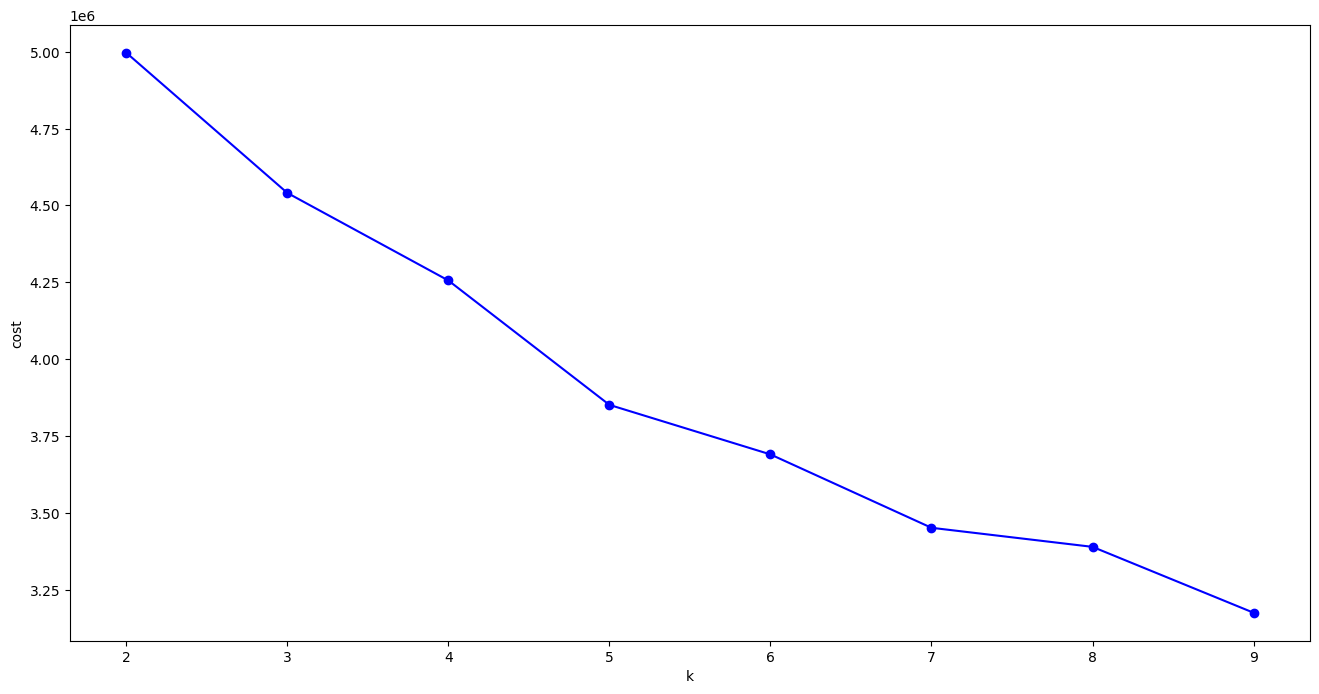

In [ ]:

costs = {}

for k in range(2, 10):
    bkm = BisectingKMeans().setK(k).setSeed(1)
    model = bkm.fit(assembled_data)
    costs[k] = model.computeCost(assembled_data)
fig, ax = plt.subplots(1, 1, figsize =(16, 8))

ax.plot(costs.keys(), costs.values(), '-ob')
ax.set_xlabel('k')
ax.set_ylabel('cost')


In [ ]:
from pyspark.ml.clustering import BisectingKMeans


# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(5).setSeed(1)
model = bkm.fit(assembled_data)

model.predict(assembled_data.head().features)

# Evaluate clustering.
cost = model.computeCost(assembled_data)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


Within Set Sum of Squared Errors = 3851279.560431865
Cluster Centers: 
[-3.09159929  0.93733051 -0.55129147  0.80537711 -0.59285007 -0.06534622
 -0.15940987  0.23523994 -0.12360464  0.72350903 -0.5976271   0.50279482
  0.04779808  0.105298  ]
[-2.04123877  0.67886833 -0.86933128 -0.09648483  1.81107192  0.00420687
  0.46879958 -0.03946332  0.08653951  0.64705047 -0.49766897  0.63409469
  0.06386098  0.16608109]
[-0.02902436 -0.98985247 -1.33692299  0.51205099 -0.06944006 -0.04914797
  0.15728067  0.22060036 -0.11845263  0.72232837 -0.62068518  0.62346692
  0.08730961  0.04480161]
[-0.29287373  0.82843083 -0.06741601 -0.23630562  0.21916569 -0.09098362
 -0.09190316  0.32753398 -0.14285201  0.64315532 -0.51992533  0.56965768
  0.01016459  0.2322014 ]
[ 0.14874744  2.26752485 -1.78536555  0.55170066  0.16612756 -0.08547919
 -0.08306294  0.18977285 -0.11852892  0.75749038 -0.53453766  0.52040257
 -0.02392677  0.0864486 ]


In [ ]:
plt.plot(centers);

In [ ]:
#model.predict(.features)
predictions = model.transform(assembled_data).select( "features","prediction")
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-2.1504364672472...|         0|
|[-1.8730001975068...|         0|
|[0.04123604879456...|         3|
|[-1.3857934388673...|         3|
|[-2.3315160607283...|         0|
|[-1.9243922844886...|         1|
|[0.56813648635546...|         2|
|[-0.2030303326460...|         3|
|[0.38628816287262...|         2|
|[-0.0437898833286...|         3|
|[0.53413137999564...|         4|
|[-1.1950702757690...|         2|
|[-3.8670717568431...|         0|
|[-7.9886280386635...|         0|
|[0.19716004727412...|         2|
|[-0.5834092952916...|         3|
|[-0.6081504425217...|         3|
|[-0.5679336684437...|         2|
|[0.00293344860004...|         2|
|[-2.0138046932662...|         1|
+--------------------+----------+
only showing top 20 rows



In [ ]:
silhouette(predictions)

silhouette score =  0.25209373404454805


#### GMM

In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
gmm = GaussianMixture(tol=0.0001).setK(5).setSeed(1)
model = gmm.fit(assembled_data)
#print("Gaussians shown as a DataFrame: ")
#model.gaussiansDF.show(truncate=False)

In [ ]:
predictions = model.transform(assembled_data).select( "features","prediction")
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-2.1504364672472...|         2|
|[-1.8730001975068...|         1|
|[0.04123604879456...|         4|
|[-1.3857934388673...|         3|
|[-2.3315160607283...|         1|
|[-1.9243922844886...|         2|
|[0.56813648635546...|         0|
|[-0.2030303326460...|         4|
|[0.38628816287262...|         0|
|[-0.0437898833286...|         4|
|[0.53413137999564...|         0|
|[-1.1950702757690...|         4|
|[-3.8670717568431...|         1|
|[-7.9886280386635...|         2|
|[0.19716004727412...|         0|
|[-0.5834092952916...|         4|
|[-0.6081504425217...|         0|
|[-0.5679336684437...|         2|
|[0.00293344860004...|         0|
|[-2.0138046932662...|         3|
+--------------------+----------+
only showing top 20 rows



In [ ]:
silhouette(predictions)

silhouette score =  0.11493229013006137


### LDA

LDA can be used for customer segmentation by treating each customer as a document and the products they purchase or the actions they take as the words in the document. The topic distribution of each customer represents their interests or preferences, and clustering customers based on their topic distributions can reveal different segments of customers with similar preferences.

In [ ]:
'''
from pyspark.ml.clustering import LDA

# Trains a LDA model.
lda = LDA(k=5).setSeed(1)
model = lda.fit(assembled_data)

ll = model.logLikelihood(assembled_data)
lp = model.logPerplexity(assembled_data)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

# Describe topics.
topics = model.describeTopics(3)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

# Shows the result
transformed = model.transform(assembled_data)
transformed.show(truncate=False)
'''

'\nfrom pyspark.ml.clustering import LDA\n\n# Trains a LDA model.\nlda = LDA(k=5).setSeed(1)\nmodel = lda.fit(assembled_data)\n\nll = model.logLikelihood(assembled_data)\nlp = model.logPerplexity(assembled_data)\nprint("The lower bound on the log likelihood of the entire corpus: " + str(ll))\nprint("The upper bound on perplexity: " + str(lp))\n\n# Describe topics.\ntopics = model.describeTopics(3)\nprint("The topics described by their top-weighted terms:")\ntopics.show(truncate=False)\n\n# Shows the result\ntransformed = model.transform(assembled_data)\ntransformed.show(truncate=False)\n'



LDA Seems to perfrom extensive computaion , the run time takes a huge amount of memory. Not recommended.

### 2.6 Association rule mining:

CF

In [ ]:
'''
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

lines = spark.read.text("data/mllib/als/sample_movielens_ratings.txt").rdd
parts = lines.map(lambda row: row.value.split("::"))
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2]), timestamp=int(p[3])))
ratings = spark.createDataFrame(ratingsRDD)
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

# Generate top 10 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)
'''